# Cell 1: Data Loading và Setup



In [1]:
# Cell 1: Import các thư viện cần thiết và setup environment
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

import numpy as np
import pandas as pd
import os
import pickle
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, 
    confusion_matrix, cohen_kappa_score
)
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
from collections import defaultdict

# Set random seeds cho reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# GPU setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"Available GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# Đường dẫn dữ liệu - BẠN CÓ THỂ THAY ĐỔI
DATA_PATH = "/kaggle/input/eeg-fpz-cz/eeg_fpz_cz"

# Thiết lập logging cho quá trình training
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

print("✓ Environment setup completed")

Using device: cuda
GPU: Tesla P100-PCIE-16GB
Available GPU memory: 17.1 GB
✓ Environment setup completed


# Cell 2: Data Loading và Subject-wise Organization





In [2]:
# Cell 2: Load dữ liệu và tổ chức theo subject cho k-fold CV
def load_sleep_edf_data(data_path):
    """
    Load dữ liệu Sleep-EDF và tổ chức theo subject
    
    BẠN CÓ THỂ TINH CHỈNH:
    - Cách parse subject ID từ filename
    - Format dữ liệu input
    - Preprocessing steps
    """
    print("Loading Sleep-EDF data...")
    
    all_files = []
    for root, dirs, files in os.walk(data_path):
        for file in files:
            if file.endswith('.npz'):
                all_files.append(os.path.join(root, file))
    
    print(f"Found {len(all_files)} files")
    
    # Dictionary để lưu dữ liệu theo subject
    subjects_data = defaultdict(lambda: {'signals': [], 'labels': []})
    
    for file_path in tqdm(all_files, desc="Loading files"):
        try:
            data = np.load(file_path)
            
            # BẠN CÓ THỂ THAY ĐỔI CÁCH TRÍCH XUẤT SUBJECT ID
            # Ví dụ: từ filename "SC4001E0-PSG.npz" -> subject_id = "SC4001"
            filename = os.path.basename(file_path)
            if filename.startswith('SC'):
                subject_id = filename[:6]  # SC4001, SC4002, etc.
            else:
                # Fallback: dùng filename làm subject_id
                subject_id = filename.split('.')[0]
            
            # Load signals và labels
            if 'x' in data.keys() and 'y' in data.keys():
                signals = data['x']
                labels = data['y']
            elif 'data' in data.keys() and 'labels' in data.keys():
                signals = data['data']
                labels = data['labels']
            else:
                print(f"Skipping {file_path}: unknown data format")
                continue
            
            # Thêm vào subject data
            subjects_data[subject_id]['signals'].append(signals)
            subjects_data[subject_id]['labels'].append(labels)
            
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            continue
    
    # Consolidate dữ liệu cho mỗi subject
    final_subjects_data = {}
    for subject_id, data in subjects_data.items():
        if len(data['signals']) > 0:
            # Concatenate tất cả sessions của subject này
            subject_signals = np.concatenate(data['signals'], axis=0)
            subject_labels = np.concatenate(data['labels'], axis=0)
            
            final_subjects_data[subject_id] = {
                'signals': subject_signals,
                'labels': subject_labels
            }
    
    print(f"✓ Loaded data for {len(final_subjects_data)} subjects")
    
    # In thông tin về mỗi subject
    for subject_id, data in final_subjects_data.items():
        n_epochs = len(data['signals'])
        unique_labels = np.unique(data['labels'])
        print(f"  {subject_id}: {n_epochs} epochs, labels: {unique_labels}")
    
    return final_subjects_data

# Load data hoặc tạo dummy data
try:
    subjects_data = load_sleep_edf_data(DATA_PATH)
    
    # Nếu không có đủ 20 subjects, tạo dummy data
    if len(subjects_data) < 20:
        print(f"Only {len(subjects_data)} subjects found. Creating dummy data for demo...")
        subjects_data = {}
        
        # Tạo 20 subjects dummy
        for i in range(20):
            subject_id = f"SC40{i:02d}"
            n_epochs = np.random.randint(400, 800)  # Mỗi subject có 400-800 epochs
            
            # Tạo EEG signals (30s * 100Hz = 3000 samples per epoch)
            signals = np.random.randn(n_epochs, 3000).astype(np.float32)
            
            # Tạo labels với distribution tương tự thực tế
            # W: 20%, N1: 5%, N2: 45%, N3: 20%, REM: 10%
            label_probs = [0.20, 0.05, 0.45, 0.20, 0.10]
            labels = np.random.choice(5, size=n_epochs, p=label_probs)
            
            subjects_data[subject_id] = {
                'signals': signals,
                'labels': labels
            }
        
        print(f"✓ Created dummy data for {len(subjects_data)} subjects")

except Exception as e:
    print(f"Error loading data: {e}")
    # Tạo dummy data
    print("Creating dummy data for testing...")
    subjects_data = {}
    for i in range(20):
        subject_id = f"SC40{i:02d}"
        n_epochs = np.random.randint(400, 800)
        signals = np.random.randn(n_epochs, 3000).astype(np.float32)
        label_probs = [0.20, 0.05, 0.45, 0.20, 0.10]
        labels = np.random.choice(5, size=n_epochs, p=label_probs)
        subjects_data[subject_id] = {'signals': signals, 'labels': labels}

# Thống kê tổng quan
total_epochs = sum(len(data['signals']) for data in subjects_data.values())
all_labels = np.concatenate([data['labels'] for data in subjects_data.values()])
label_counts = dict(zip(*np.unique(all_labels, return_counts=True)))

print(f"\n✓ Dataset summary:")
print(f"  Total subjects: {len(subjects_data)}")
print(f"  Total epochs: {total_epochs}")
print(f"  Label distribution: {label_counts}")
print(f"  Signal length per epoch: {list(subjects_data.values())[0]['signals'].shape[1]}")

# BẠN CÓ THỂ TINH CHỈNH SAMPLING FREQUENCY TẠI ĐÂY
SAMPLING_FREQ = 100  # Hz cho Sleep-EDF
EPOCH_LENGTH = 30    # seconds
SAMPLES_PER_EPOCH = SAMPLING_FREQ * EPOCH_LENGTH

print(f"✓ Configuration: Fs={SAMPLING_FREQ}Hz, Epoch={EPOCH_LENGTH}s, Samples={SAMPLES_PER_EPOCH}")

Loading Sleep-EDF data...
Found 78 files


Loading files: 100%|██████████| 78/78 [00:08<00:00,  9.51it/s]


✓ Loaded data for 39 subjects
  SC4052: 2492 epochs, labels: [0 1 2 3 4]
  SC4032: 1822 epochs, labels: [0 1 2 3 4]
  SC4062: 2032 epochs, labels: [0 1 2 3 4]
  SC4102: 2184 epochs, labels: [0 1 2 3 4]
  SC4172: 3546 epochs, labels: [0 1 2 3 4]
  SC4082: 2108 epochs, labels: [0 1 2 3 4]
  SC4192: 2548 epochs, labels: [0 1 2 3 4]
  SC4012: 2372 epochs, labels: [0 1 2 3 4]
  SC4131: 2056 epochs, labels: [0 1 2 3 4]
  SC4191: 3070 epochs, labels: [0 1 2 3 4]
  SC4091: 2264 epochs, labels: [0 1 2 3 4]
  SC4092: 2210 epochs, labels: [0 1 2 3 4]
  SC4001: 1682 epochs, labels: [0 1 2 3 4]
  SC4151: 1904 epochs, labels: [0 1 2 3 4]
  SC4122: 1954 epochs, labels: [0 1 2 3 4]
  SC4051: 1344 epochs, labels: [0 1 2 3 4]
  SC4002: 2254 epochs, labels: [0 1 2 3 4]
  SC4071: 1952 epochs, labels: [0 1 2 3 4]
  SC4141: 2008 epochs, labels: [0 1 2 3 4]
  SC4101: 2208 epochs, labels: [0 1 2 3 4]
  SC4152: 3524 epochs, labels: [0 1 2 3 4]
  SC4142: 1904 epochs, labels: [0 1 2 3 4]
  SC4112: 1604 epochs, l

# Cell 3: Dataset Class và K-Fold Setup


In [3]:
# Cell 3: Dataset class và thiết lập k-fold cross-validation
class SleepEEGDataset(Dataset):
    """
    Dataset class cho Sleep-EDF với subject-aware processing
    
    BẂN CÓ THỂ THÊM:
    - Data augmentation techniques
    - Different normalization strategies
    - Sequence-aware sampling
    """
    def __init__(self, signals, labels, subject_ids=None, normalize=True, augment=False):
        self.signals = signals.copy()
        self.labels = labels.copy()
        self.subject_ids = subject_ids if subject_ids is not None else np.zeros(len(signals))
        self.normalize = normalize
        self.augment = augment
        
        # Normalization per subject để tránh data leakage
        if normalize:
            self._normalize_signals()
    
    def _normalize_signals(self):
        """Z-score normalization per subject"""
        unique_subjects = np.unique(self.subject_ids)
        
        for subject_id in unique_subjects:
            subject_mask = self.subject_ids == subject_id
            subject_signals = self.signals[subject_mask]
            
            # Tính mean và std cho toàn bộ epochs của subject này
            mean = np.mean(subject_signals)
            std = np.std(subject_signals)
            if std == 0:
                std = 1
            
            self.signals[subject_mask] = (subject_signals - mean) / std
    
    def __len__(self):
        return len(self.signals)
    
    def __getitem__(self, idx):
        signal = self.signals[idx].astype(np.float32)
        label = self.labels[idx].astype(np.int64)
        
        # BẠN CÓ THỂ THÊM AUGMENTATION TẠI ĐÂY
        if self.augment and np.random.random() > 0.5:
            # Thêm noise
            noise = np.random.normal(0, 0.01, signal.shape)
            signal = signal + noise.astype(np.float32)
        
        # Reshape cho CNN: (channels, time_steps)
        signal = signal.reshape(1, -1)
        
        return torch.from_numpy(signal), torch.from_numpy(np.array(label))

def setup_kfold_cv(subjects_data, k=20):
    """
    Thiết lập k-fold cross-validation với leave-one-subject-out strategy
    
    BẠN CÓ THỂ TINH CHỈNH:
    - Số fold (k)
    - Strategy cho việc chia fold nếu có ít hơn k subjects
    """
    subject_ids = list(subjects_data.keys())
    
    if len(subject_ids) < k:
        print(f"Warning: Only {len(subject_ids)} subjects available, using {len(subject_ids)}-fold CV")
        k = len(subject_ids)
    
    # Tạo fold assignments
    folds = []
    for i in range(k):
        if i < len(subject_ids):
            test_subject = subject_ids[i]
            train_subjects = [s for s in subject_ids if s != test_subject]
        else:
            # Nếu k > số subjects, lặp lại
            test_subject = subject_ids[i % len(subject_ids)]
            train_subjects = [s for s in subject_ids if s != test_subject]
        
        folds.append({
            'train_subjects': train_subjects,
            'test_subject': test_subject
        })
    
    print(f"✓ Created {len(folds)} folds for cross-validation")
    for i, fold in enumerate(folds[:5]):  # In 5 fold đầu
        print(f"  Fold {i+1}: Test={fold['test_subject']}, Train={len(fold['train_subjects'])} subjects")
    
    return folds

def prepare_fold_data(subjects_data, fold_info):
    """
    Chuẩn bị dữ liệu cho một fold cụ thể
    """
    train_subjects = fold_info['train_subjects']
    test_subject = fold_info['test_subject']
    
    # Collect training data
    train_signals = []
    train_labels = []
    train_subject_ids = []
    
    for subject_id in train_subjects:
        if subject_id in subjects_data:
            signals = subjects_data[subject_id]['signals']
            labels = subjects_data[subject_id]['labels']
            
            train_signals.append(signals)
            train_labels.append(labels)
            train_subject_ids.extend([subject_id] * len(signals))
    
    # Collect test data
    test_signals = subjects_data[test_subject]['signals']
    test_labels = subjects_data[test_subject]['labels']
    test_subject_ids = [test_subject] * len(test_signals)
    
    # Convert to numpy arrays
    X_train = np.concatenate(train_signals, axis=0)
    y_train = np.concatenate(train_labels, axis=0)
    train_subject_ids = np.array(train_subject_ids)
    
    X_test = test_signals
    y_test = test_labels
    test_subject_ids = np.array(test_subject_ids)
    
    return X_train, y_train, train_subject_ids, X_test, y_test, test_subject_ids

# Setup k-fold cross-validation
print("\n" + "="*60)
print("K-FOLD CROSS-VALIDATION SETUP")
print("="*60)

# BẠN CÓ THỂ THAY ĐỔI SỐ FOLD TẠI ĐÂY
K_FOLDS = 20  # Theo yêu cầu: 20 folds tương ứng 20 subjects

folds = setup_kfold_cv(subjects_data, k=K_FOLDS)

# Test với fold đầu tiên
print(f"\n✓ Testing fold preparation...")
fold_0 = folds[0]
X_train, y_train, train_subj_ids, X_test, y_test, test_subj_ids = prepare_fold_data(subjects_data, fold_0)

print(f"  Fold 0 - Train: {X_train.shape[0]} epochs from {len(np.unique(train_subj_ids))} subjects")
print(f"  Fold 0 - Test: {X_test.shape[0]} epochs from subject {test_subj_ids[0]}")
print(f"  Train label distribution: {dict(zip(*np.unique(y_train, return_counts=True)))}")
print(f"  Test label distribution: {dict(zip(*np.unique(y_test, return_counts=True)))}")

print("="*60)


K-FOLD CROSS-VALIDATION SETUP
✓ Created 20 folds for cross-validation
  Fold 1: Test=SC4052, Train=38 subjects
  Fold 2: Test=SC4032, Train=38 subjects
  Fold 3: Test=SC4062, Train=38 subjects
  Fold 4: Test=SC4102, Train=38 subjects
  Fold 5: Test=SC4172, Train=38 subjects

✓ Testing fold preparation...
  Fold 0 - Train: 82124 epochs from 38 subjects
  Fold 0 - Test: 2492 epochs from subject SC4052
  Train label distribution: {0: 16126, 1: 5380, 2: 34366, 3: 11178, 4: 15074}
  Test label distribution: {0: 444, 1: 228, 2: 1232, 3: 228, 4: 360}


# Cell 4: DeepSleepNet Architecture - Part 1 (CNN Components)




In [4]:
# Cell 4: DeepSleepNet Architecture - CNN Components
class SmallFilterCNN(nn.Module):
    """
    CNN với filter nhỏ để capture high-frequency features
    
    Architecture theo paper:
    - Layer 1: Conv1d(filter_size=Fs/2, filters=64, stride=Fs/16)
    - Layer 2-4: Conv1d(filter_size=8, filters=128, stride=1)
    - Max pooling và dropout
    
    BẠN CÓ THỂ TINH CHỈNH:
    - Filter sizes và strides
    - Số lượng filters
    - Dropout rates
    - Activation functions
    """
    def __init__(self, input_size=3000, sampling_freq=100, dropout_rate=0.5):
        super(SmallFilterCNN, self).__init__()
        
        # Tính toán parameters theo paper
        filter_size_1 = sampling_freq // 2  # Fs/2 = 50 cho Sleep-EDF
        stride_1 = max(1, sampling_freq // 16)  # Fs/16 ≈ 6
        
        print(f"Small CNN - Filter1: {filter_size_1}, Stride1: {stride_1}")
        
        # Layer 1: Large filter để capture temporal patterns
        self.conv1 = nn.Conv1d(
            in_channels=1, 
            out_channels=64, 
            kernel_size=filter_size_1, 
            stride=stride_1,
            padding=filter_size_1//2
        )
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(kernel_size=8, stride=8)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        # Layers 2-4: Smaller filters để refine features
        self.conv2 = nn.Conv1d(64, 128, kernel_size=8, stride=1, padding=4)
        self.bn2 = nn.BatchNorm1d(128)
        
        self.conv3 = nn.Conv1d(128, 128, kernel_size=8, stride=1, padding=4)
        self.bn3 = nn.BatchNorm1d(128)
        
        self.conv4 = nn.Conv1d(128, 128, kernel_size=8, stride=1, padding=4)
        self.bn4 = nn.BatchNorm1d(128)
        
        self.pool2 = nn.MaxPool1d(kernel_size=4, stride=4)
        
        # Tính output size
        self.output_size = self._calculate_output_size(input_size)
        
    def _calculate_output_size(self, input_size):
        """Tính kích thước output để flatten"""
        with torch.no_grad():
            x = torch.randn(1, 1, input_size)
            x = self.forward_features(x)
            return x.numel()
    
    def forward_features(self, x):
        """Forward pass qua CNN layers"""
        # Layer 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Layers 2-4
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        
        return x
    
    def forward(self, x):
        features = self.forward_features(x)
        return features.view(features.size(0), -1)

class LargeFilterCNN(nn.Module):
    """
    CNN với filter lớn để capture low-frequency features
    
    Architecture theo paper:
    - Layer 1: Conv1d(filter_size=Fs*4, filters=64, stride=Fs/2)
    - Layer 2-4: Conv1d(filter_size=6, filters=128, stride=1)
    - Max pooling và dropout
    """
    def __init__(self, input_size=3000, sampling_freq=100, dropout_rate=0.5):
        super(LargeFilterCNN, self).__init__()
        
        # Tính toán parameters theo paper
        filter_size_1 = min(sampling_freq * 4, input_size // 8)  # Fs*4 = 400
        stride_1 = max(1, sampling_freq // 2)  # Fs/2 = 50
        
        print(f"Large CNN - Filter1: {filter_size_1}, Stride1: {stride_1}")
        
        # Layer 1: Very large filter để capture long-term patterns
        self.conv1 = nn.Conv1d(
            in_channels=1, 
            out_channels=64, 
            kernel_size=filter_size_1, 
            stride=stride_1,
            padding=filter_size_1//2
        )
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(kernel_size=4, stride=4)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        # Layers 2-4: Smaller filters
        self.conv2 = nn.Conv1d(64, 128, kernel_size=6, stride=1, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        
        self.conv3 = nn.Conv1d(128, 128, kernel_size=6, stride=1, padding=3)
        self.bn3 = nn.BatchNorm1d(128)
        
        self.conv4 = nn.Conv1d(128, 128, kernel_size=6, stride=1, padding=3)
        self.bn4 = nn.BatchNorm1d(128)
        
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Tính output size
        self.output_size = self._calculate_output_size(input_size)
        
    def _calculate_output_size(self, input_size):
        with torch.no_grad():
            x = torch.randn(1, 1, input_size)
            x = self.forward_features(x)
            return x.numel()
    
    def forward_features(self, x):
        # Layer 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Layers 2-4
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        
        return x
    
    def forward(self, x):
        features = self.forward_features(x)
        return features.view(features.size(0), -1)

# Test CNN components
print("\n" + "="*60)
print("TESTING CNN COMPONENTS")
print("="*60)

try:
    # BẠN CÓ THỂ TINH CHỈNH CÁC PARAMETERS NÀY
    INPUT_SIZE = SAMPLES_PER_EPOCH  # 3000 cho Sleep-EDF
    DROPOUT_RATE = 0.5
    
    # Test Small CNN
    print("Testing Small Filter CNN...")
    small_cnn = SmallFilterCNN(
        input_size=INPUT_SIZE, 
        sampling_freq=SAMPLING_FREQ,
        dropout_rate=DROPOUT_RATE
    ).to(device)
    
    # Test Large CNN
    print("Testing Large Filter CNN...")
    large_cnn = LargeFilterCNN(
        input_size=INPUT_SIZE,
        sampling_freq=SAMPLING_FREQ, 
        dropout_rate=DROPOUT_RATE
    ).to(device)
    
    # Test với dummy input
    test_input = torch.randn(8, 1, INPUT_SIZE).to(device)  # Batch size 8
    
    with torch.no_grad():
        small_features = small_cnn(test_input)
        large_features = large_cnn(test_input)
        
        print(f"✓ Input shape: {test_input.shape}")
        print(f"✓ Small CNN output: {small_features.shape}")
        print(f"✓ Large CNN output: {large_features.shape}")
        
        # Test concatenation
        combined_features = torch.cat([small_features, large_features], dim=1)
        print(f"✓ Combined features: {combined_features.shape}")
    
    print("✓ CNN components test successful!")
    print("="*60)
    
except Exception as e:
    print(f"✗ Error in CNN testing: {e}")
    import traceback
    traceback.print_exc()


TESTING CNN COMPONENTS
Testing Small Filter CNN...
Small CNN - Filter1: 50, Stride1: 6
Testing Large Filter CNN...
Large CNN - Filter1: 375, Stride1: 50
✓ Input shape: torch.Size([8, 1, 3000])
✓ Small CNN output: torch.Size([8, 2048])
✓ Large CNN output: torch.Size([8, 1152])
✓ Combined features: torch.Size([8, 3200])
✓ CNN components test successful!


# Cell 5: DeepSleepNet Architecture - Part 2 (BiLSTM và Residual Connection)



In [5]:
# Cell 5: DeepSleepNet Architecture - BiLSTM và Residual Connection
class DeepSleepNet(nn.Module):
    """
    DeepSleepNet hoàn chỉnh theo paper gốc
    
    Architecture:
    1. Representation Learning: 2 CNN song song
    2. Sequence Residual Learning: BiLSTM + Residual connection
    3. Classification: Fully connected layers
    
    BẠN CÓ THỂ TINH CHỈNH:
    - LSTM hidden size và số layers
    - Residual connection architecture
    - Dropout rates
    - Final classifier architecture
    """
    def __init__(self, input_size=3000, sampling_freq=100, n_classes=5,
                 lstm_hidden_size=512, n_lstm_layers=2, 
                 dropout_feature=0.5, dropout_sequence=0.5):
        super(DeepSleepNet, self).__init__()
        
        self.input_size = input_size
        self.sampling_freq = sampling_freq
        self.n_classes = n_classes
        self.lstm_hidden_size = lstm_hidden_size
        self.n_lstm_layers = n_lstm_layers
        
        print(f"Initializing DeepSleepNet:")
        print(f"  Input size: {input_size}")
        print(f"  Sampling frequency: {sampling_freq} Hz")
        print(f"  Classes: {n_classes}")
        print(f"  LSTM hidden size: {lstm_hidden_size}")
        print(f"  LSTM layers: {n_lstm_layers}")
        
        # Part 1: Representation Learning - 2 CNN song song
        self.small_cnn = SmallFilterCNN(
            input_size=input_size,
            sampling_freq=sampling_freq,
            dropout_rate=dropout_feature
        )
        
        self.large_cnn = LargeFilterCNN(
            input_size=input_size,
            sampling_freq=sampling_freq,
            dropout_rate=dropout_feature
        )
        
        # Tổng feature size từ 2 CNNs
        self.cnn_feature_size = self.small_cnn.output_size + self.large_cnn.output_size
        print(f"  CNN feature size: {self.cnn_feature_size}")
        
        # Part 2: Sequence Residual Learning
        # BiLSTM với peephole connections (approximated in PyTorch)
        self.bilstm = nn.LSTM(
            input_size=self.cnn_feature_size,
            hidden_size=lstm_hidden_size,
            num_layers=n_lstm_layers,
            bidirectional=True,
            dropout=dropout_sequence if n_lstm_layers > 1 else 0,
            batch_first=True
        )
        
        # LSTM output size = 2 * hidden_size (bidirectional)
        lstm_output_size = 2 * lstm_hidden_size
        
        # Residual connection: FC layer để transform CNN features
        # Theo paper: 1024 units với batch norm và ReLU
        self.residual_fc = nn.Sequential(
            nn.Linear(self.cnn_feature_size, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(dropout_sequence)
        )
        
        # Part 3: Classification
        # Combine LSTM output + residual connection
        final_feature_size = lstm_output_size + 1024
        
        # BẠN CÓ THỂ THAY ĐỔI ARCHITECTURE CỦA CLASSIFIER
        self.classifier = nn.Sequential(
            nn.Linear(final_feature_size, 1024),
            nn.ReLU(),
            nn.Dropout(dropout_sequence),
            nn.Linear(1024, n_classes)
        )
        
        print(f"  LSTM output size: {lstm_output_size}")
        print(f"  Residual FC size: 1024")
        print(f"  Final feature size: {final_feature_size}")
        print(f"  Total parameters: {self.count_parameters():,}")
        
    def count_parameters(self):
        """Đếm số parameters trong model"""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    
    def extract_cnn_features(self, x):
        """Extract features từ CNN layers"""
        # Forward qua 2 CNNs song song
        small_features = self.small_cnn(x)  # (batch, small_feature_size)
        large_features = self.large_cnn(x)  # (batch, large_feature_size)
        
        # Concatenate features
        combined_features = torch.cat([small_features, large_features], dim=1)
        return combined_features
    
    def forward(self, x, sequence_mode=False, hidden=None):
        """
        Forward pass
        
        Args:
            x: Input tensor
                - Single epoch: (batch_size, channels, time_steps)
                - Sequence: (batch_size, seq_len, channels, time_steps)
            sequence_mode: Whether to use sequence learning with LSTM
            hidden: Hidden state cho LSTM (optional)
        """
        batch_size = x.size(0)
        
        if sequence_mode and len(x.shape) == 4:
            # Sequence mode: (batch_size, seq_len, channels, time_steps)
            seq_len = x.size(1)
            
            # Reshape để process từng epoch: (batch_size * seq_len, channels, time_steps)
            x_reshaped = x.view(-1, x.size(2), x.size(3))
            
            # Extract CNN features cho tất cả epochs
            cnn_features = self.extract_cnn_features(x_reshaped)  # (batch*seq_len, feature_size)
            
            # Reshape lại cho LSTM: (batch_size, seq_len, feature_size)
            cnn_features = cnn_features.view(batch_size, seq_len, -1)
            
            # Forward qua BiLSTM
            lstm_out, hidden = self.bilstm(cnn_features, hidden)
            
            # Lấy output từ last time step
            lstm_features = lstm_out[:, -1, :]  # (batch_size, lstm_output_size)
            
            # Residual connection: dùng CNN features từ last time step
            last_cnn_features = cnn_features[:, -1, :]  # (batch_size, cnn_feature_size)
            residual_features = self.residual_fc(last_cnn_features)
            
        else:
            # Single epoch mode: (batch_size, channels, time_steps)
            cnn_features = self.extract_cnn_features(x)  # (batch_size, feature_size)
            
            # Dummy LSTM pass để maintain architecture consistency
            # Reshape to sequence format: (batch_size, 1, feature_size)
            cnn_seq = cnn_features.unsqueeze(1)
            lstm_out, hidden = self.bilstm(cnn_seq, hidden)
            lstm_features = lstm_out.squeeze(1)  # (batch_size, lstm_output_size)
            
            # Residual connection
            residual_features = self.residual_fc(cnn_features)
        
        # Combine LSTM và residual features
        combined_features = torch.cat([lstm_features, residual_features], dim=1)
        
        # Final classification
        output = self.classifier(combined_features)
        
        return output, hidden
    
    def get_cnn_model(self):
        """
        Return CNN-only model cho pre-training
        BẠN CÓ THỂ SỬ DỤNG CHO TWO-STEP TRAINING
        """
        class CNNOnly(nn.Module):
            def __init__(self, deepsleepnet_model):
                super(CNNOnly, self).__init__()
                self.small_cnn = deepsleepnet_model.small_cnn
                self.large_cnn = deepsleepnet_model.large_cnn
                self.cnn_feature_size = deepsleepnet_model.cnn_feature_size
                
                # Simple classifier cho CNN features
                self.cnn_classifier = nn.Sequential(
                    nn.Dropout(0.5),
                    nn.Linear(self.cnn_feature_size, 1024),
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    nn.Linear(1024, deepsleepnet_model.n_classes)
                )
            
            def forward(self, x):
                # Extract CNN features
                small_features = self.small_cnn(x)
                large_features = self.large_cnn(x)
                combined_features = torch.cat([small_features, large_features], dim=1)
                
                # Classify
                output = self.cnn_classifier(combined_features)
                return output
        
        return CNNOnly(self)

# Test DeepSleepNet
print("\n" + "="*60)
print("TESTING DEEPSLEEPNET")
print("="*60)

try:
    # BẠN CÓ THỂ TINH CHỈNH CÁC HYPERPARAMETERS
    MODEL_CONFIG = {
        'input_size': INPUT_SIZE,
        'sampling_freq': SAMPLING_FREQ,
        'n_classes': 5,  # W, N1, N2, N3, REM
        'lstm_hidden_size': 512,
        'n_lstm_layers': 2,
        'dropout_feature': 0.5,
        'dropout_sequence': 0.5
    }
    
    # Khởi tạo model
    model = DeepSleepNet(**MODEL_CONFIG).to(device)
    
    print(f"\n✓ Model initialized successfully")
    
    # Test single epoch mode
    print(f"\n1. Testing single epoch mode...")
    test_input_single = torch.randn(8, 1, INPUT_SIZE).to(device)
    
    with torch.no_grad():
        output_single, _ = model(test_input_single, sequence_mode=False)
        print(f"✓ Single epoch - Input: {test_input_single.shape}, Output: {output_single.shape}")
    
    # Test sequence mode
    print(f"\n2. Testing sequence mode...")
    seq_len = 10
    test_input_seq = torch.randn(4, seq_len, 1, INPUT_SIZE).to(device)
    
    with torch.no_grad():
        output_seq, _ = model(test_input_seq, sequence_mode=True)
        print(f"✓ Sequence mode - Input: {test_input_seq.shape}, Output: {output_seq.shape}")
    
    # Test CNN-only model
    print(f"\n3. Testing CNN-only model...")
    cnn_model = model.get_cnn_model().to(device)
    
    with torch.no_grad():
        cnn_output = cnn_model(test_input_single)
        print(f"✓ CNN-only - Input: {test_input_single.shape}, Output: {cnn_output.shape}")
        print(f"✓ CNN-only parameters: {sum(p.numel() for p in cnn_model.parameters()):,}")
    
    print(f"\n✓ All model tests successful!")
    print("="*60)
    
except Exception as e:
    print(f"✗ Error in DeepSleepNet testing: {e}")
    import traceback
    traceback.print_exc()


TESTING DEEPSLEEPNET
Initializing DeepSleepNet:
  Input size: 3000
  Sampling frequency: 100 Hz
  Classes: 5
  LSTM hidden size: 512
  LSTM layers: 2
Small CNN - Filter1: 50, Stride1: 6
Large CNN - Filter1: 375, Stride1: 50
  CNN feature size: 3200
  LSTM output size: 1024
  Residual FC size: 1024
  Final feature size: 2048
  Total parameters: 27,498,693

✓ Model initialized successfully

1. Testing single epoch mode...
✓ Single epoch - Input: torch.Size([8, 1, 3000]), Output: torch.Size([8, 5])

2. Testing sequence mode...
✓ Sequence mode - Input: torch.Size([4, 10, 1, 3000]), Output: torch.Size([4, 5])

3. Testing CNN-only model...
✓ CNN-only - Input: torch.Size([8, 1, 3000]), Output: torch.Size([8, 5])
✓ CNN-only parameters: 3,886,277

✓ All model tests successful!


# Cell 6: Training Functions và Two-Step Training

In [6]:
# Cell 6: Training functions và two-step training algorithm
class EarlyStopping:
    """Early stopping để tránh overfitting"""
    def __init__(self, patience=7, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            
        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False
    
    def save_checkpoint(self, model):
        self.best_weights = model.state_dict().copy()

def calculate_class_weights(y_train):
    """Tính class weights để xử lý imbalanced dataset"""
    unique_classes = np.unique(y_train)
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=unique_classes,
        y=y_train
    )
    return torch.FloatTensor(class_weights)

def train_epoch(model, train_loader, criterion, optimizer, device, phase="train"):
    """Train một epoch"""
    if phase == "train":
        model.train()
    else:
        model.eval()
    
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    progress_bar = tqdm(train_loader, desc=f"{phase.capitalize()} Epoch")
    
    for batch_idx, (data, target) in enumerate(progress_bar):
        data, target = data.to(device), target.to(device)
        
        if phase == "train":
            optimizer.zero_grad()
        
        with torch.set_grad_enabled(phase == "train"):
            # Forward pass
            if hasattr(model, 'forward'):
                if 'sequence_mode' in model.forward.__code__.co_varnames:
                    output, _ = model(data, sequence_mode=False)
                else:
                    output = model(data)
            else:
                output = model(data)
            
            loss = criterion(output, target)
            
            if phase == "train":
                loss.backward()
                
                # Gradient clipping để stabilize training
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        preds = torch.argmax(output, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(target.cpu().numpy())
        
        # Update progress bar
        avg_loss = running_loss / (batch_idx + 1)
        progress_bar.set_postfix({'Loss': f'{avg_loss:.4f}'})
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_f1 = f1_score(all_labels, all_preds, average='macro')
    
    return epoch_loss, epoch_acc, epoch_f1, all_preds, all_labels

def two_step_training(model, train_loader, val_loader, device, 
                     step1_epochs=15, step2_epochs=30,
                     step1_lr=0.001, step2_lr=0.0001,
                     class_weights=None):
    """
    Two-step training algorithm theo paper DeepSleepNet
    
    Step 1: Pre-train CNN với learning rate cao
    Step 2: Fine-tune toàn bộ model với learning rate thấp
    
    BẠN CÓ THỂ TINH CHỈNH:
    - Learning rates cho mỗi step
    - Số epochs cho mỗi step
    - Optimizer parameters
    - Early stopping patience
    """
    print(f"\n" + "="*60)
    print(f"TWO-STEP TRAINING")
    print(f"="*60)
    
    # Setup criterion
    if class_weights is not None:
        criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    else:
        criterion = nn.CrossEntropyLoss()
    
    training_history = {
        'step1': {'train_loss': [], 'train_acc': [], 'train_f1': [],
                  'val_loss': [], 'val_acc': [], 'val_f1': []},
        'step2': {'train_loss': [], 'train_acc': [], 'train_f1': [],
                  'val_loss': [], 'val_acc': [], 'val_f1': []}
    }
    
    # =============================================================================
    # STEP 1: Pre-train CNN only
    # =============================================================================
    print(f"\n🔥 STEP 1: Pre-training CNN (epochs: {step1_epochs}, lr: {step1_lr})")
    print("-" * 60)
    
    # Get CNN-only model
    cnn_model = model.get_cnn_model().to(device)
    
    # Optimizer cho Step 1
    optimizer_step1 = optim.Adam(cnn_model.parameters(), lr=step1_lr, weight_decay=1e-4)
    scheduler_step1 = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer_step1, mode='min', factor=0.5, patience=5, verbose=True
    )
    
    # Early stopping cho Step 1
    early_stopping_step1 = EarlyStopping(patience=7, min_delta=0.001)
    
    best_val_loss_step1 = float('inf')
    
    for epoch in range(step1_epochs):
        print(f"\nStep 1 - Epoch {epoch+1}/{step1_epochs}")
        
        # Training
        train_loss, train_acc, train_f1, _, _ = train_epoch(
            cnn_model, train_loader, criterion, optimizer_step1, device, "train"
        )
        
        # Validation
        val_loss, val_acc, val_f1, _, _ = train_epoch(
            cnn_model, val_loader, criterion, optimizer_step1, device, "val"
        )
        
        # Learning rate scheduling
        scheduler_step1.step(val_loss)
        
        # Save metrics
        training_history['step1']['train_loss'].append(train_loss)
        training_history['step1']['train_acc'].append(train_acc)
        training_history['step1']['train_f1'].append(train_f1)
        training_history['step1']['val_loss'].append(val_loss)
        training_history['step1']['val_acc'].append(val_acc)
        training_history['step1']['val_f1'].append(val_f1)
        
        print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}")
        print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")
        
        # Early stopping
        if early_stopping_step1(val_loss, cnn_model):
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
        
        if val_loss < best_val_loss_step1:
            best_val_loss_step1 = val_loss
    
    print(f"✓ Step 1 completed. Best validation loss: {best_val_loss_step1:.4f}")
    
    # =============================================================================
    # Transfer CNN weights to full model
    # =============================================================================
    print(f"\n🔄 Transferring CNN weights to full model...")
    
    # Copy CNN weights
    model.small_cnn.load_state_dict(cnn_model.small_cnn.state_dict())
    model.large_cnn.load_state_dict(cnn_model.large_cnn.state_dict())
    
    print(f"✓ CNN weights transferred successfully")
    
    # =============================================================================
    # STEP 2: Fine-tune full model
    # =============================================================================
    print(f"\n🎯 STEP 2: Fine-tuning full model (epochs: {step2_epochs}, lr: {step2_lr})")
    print("-" * 60)
    
    # Optimizer cho Step 2 với learning rate thấp hơn
    optimizer_step2 = optim.Adam(model.parameters(), lr=step2_lr, weight_decay=1e-4)
    scheduler_step2 = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer_step2, mode='min', factor=0.7, patience=5, verbose=True
    )
    
    # Early stopping cho Step 2
    early_stopping_step2 = EarlyStopping(patience=10, min_delta=0.0005)
    
    best_val_loss_step2 = float('inf')
    
    for epoch in range(step2_epochs):
        print(f"\nStep 2 - Epoch {epoch+1}/{step2_epochs}")
        
        # Training
        train_loss, train_acc, train_f1, _, _ = train_epoch(
            model, train_loader, criterion, optimizer_step2, device, "train"
        )
        
        # Validation
        val_loss, val_acc, val_f1, _, _ = train_epoch(
            model, val_loader, criterion, optimizer_step2, device, "val"
        )
        
        # Learning rate scheduling
        scheduler_step2.step(val_loss)
        
        # Save metrics
        training_history['step2']['train_loss'].append(train_loss)
        training_history['step2']['train_acc'].append(train_acc)
        training_history['step2']['train_f1'].append(train_f1)
        training_history['step2']['val_loss'].append(val_loss)
        training_history['step2']['val_acc'].append(val_acc)
        training_history['step2']['val_f1'].append(val_f1)
        
        print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}")
        print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")
        
        # Early stopping
        if early_stopping_step2(val_loss, model):
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
        
        if val_loss < best_val_loss_step2:
            best_val_loss_step2 = val_loss
    
    print(f"✓ Step 2 completed. Best validation loss: {best_val_loss_step2:.4f}")
    print(f"="*60)
    
    return model, training_history

# Test training functions
print("\n" + "="*60)
print("TESTING TRAINING FUNCTIONS")
print("="*60)

# Create sample data loaders cho testing
try:
    # Tạo small datasets cho testing
    sample_size = 200
    X_sample = np.random.randn(sample_size, INPUT_SIZE).astype(np.float32)
    y_sample = np.random.randint(0, 5, sample_size)
    
    # Create datasets
    sample_dataset = SleepEEGDataset(X_sample, y_sample, normalize=True)
    sample_loader = DataLoader(sample_dataset, batch_size=32, shuffle=True)
    
    # Calculate class weights
    sample_weights = calculate_class_weights(y_sample)
    print(f"✓ Sample class weights: {sample_weights}")
    
    # Test single epoch training
    print(f"\n✓ Testing single epoch training...")
    test_model = DeepSleepNet(**MODEL_CONFIG).to(device)
    test_criterion = nn.CrossEntropyLoss(weight=sample_weights.to(device))
    test_optimizer = optim.Adam(test_model.parameters(), lr=0.001)
    
    # Run one training epoch
    loss, acc, f1, _, _ = train_epoch(
        test_model, sample_loader, test_criterion, test_optimizer, device, "train"
    )
    
    print(f"✓ Test epoch - Loss: {loss:.4f}, Acc: {acc:.4f}, F1: {f1:.4f}")
    print(f"✓ Training functions test successful!")
    
except Exception as e:
    print(f"✗ Error in training functions test: {e}")
    import traceback
    traceback.print_exc()


TESTING TRAINING FUNCTIONS
✓ Sample class weights: tensor([0.9524, 1.0256, 1.2903, 0.8000, 1.0526])

✓ Testing single epoch training...
Initializing DeepSleepNet:
  Input size: 3000
  Sampling frequency: 100 Hz
  Classes: 5
  LSTM hidden size: 512
  LSTM layers: 2
Small CNN - Filter1: 50, Stride1: 6
Large CNN - Filter1: 375, Stride1: 50
  CNN feature size: 3200
  LSTM output size: 1024
  Residual FC size: 1024
  Final feature size: 2048
  Total parameters: 27,498,693


Train Epoch: 100%|██████████| 7/7 [00:00<00:00, 14.86it/s, Loss=1.7049]

✓ Test epoch - Loss: 1.7049, Acc: 0.2300, F1: 0.1884
✓ Training functions test successful!


# Cell 7: K-Fold Cross-Validation Pipeline


In [7]:
# Cell 7: K-Fold Cross-Validation Pipeline
def evaluate_model(model, test_loader, device, class_names=None):
    """
    Đánh giá model trên test set và trả về các metrics chi tiết
    
    BẠN CÓ THỂ THÊM THÊM METRICS:
    - Cohen's Kappa
    - Per-class precision/recall
    - ROC curves 
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc="Evaluating"):
            data, target = data.to(device), target.to(device)
            
            # Forward pass
            if hasattr(model, 'forward') and 'sequence_mode' in model.forward.__code__.co_varnames:
                output, _ = model(data, sequence_mode=False)
            else:
                output = model(data)
            
            # Get predictions và probabilities
            probs = F.softmax(output, dim=1)
            preds = torch.argmax(output, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Tính các metrics
    accuracy = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    weighted_f1 = f1_score(all_labels, all_preds, average='weighted')
    kappa = cohen_kappa_score(all_labels, all_preds)
    
    # Classification report
    if class_names is None:
        class_names = [f'Class_{i}' for i in range(len(np.unique(all_labels)))]
    
    class_report = classification_report(
        all_labels, all_preds, 
        target_names=class_names,
        output_dict=True
    )
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    return {
        'accuracy': accuracy,
        'macro_f1': macro_f1,
        'weighted_f1': weighted_f1,
        'kappa': kappa,
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs,
        'classification_report': class_report,
        'confusion_matrix': cm
    }

def run_kfold_cv(subjects_data, folds, model_config, training_config):
    """
    Chạy k-fold cross-validation với leave-one-subject-out strategy
    
    BẠN CÓ THỂ TINH CHỈNH:
    - Training hyperparameters
    - Evaluation metrics
    - Model saving strategy
    - Logging details
    """
    print(f"\n" + "="*80)
    print(f"STARTING {len(folds)}-FOLD CROSS-VALIDATION")
    print(f"="*80)
    
    # Sleep stage names
    class_names = ['Wake', 'N1', 'N2', 'N3', 'REM']
    
    # Storage cho results
    fold_results = []
    all_predictions = []
    all_true_labels = []
    training_histories = []
    
    # BẠN CÓ THỂ TINH CHỈNH CÁC TRAINING PARAMETERS
    batch_size = training_config.get('batch_size', 128)
    step1_epochs = training_config.get('step1_epochs', 15)
    step2_epochs = training_config.get('step2_epochs', 30)
    step1_lr = training_config.get('step1_lr', 0.001)
    step2_lr = training_config.get('step2_lr', 0.0001)
    
    start_time = time.time()
    
    for fold_idx, fold_info in enumerate(folds):
        print(f"\n" + "🔥" * 60)
        print(f"FOLD {fold_idx + 1}/{len(folds)}")
        print(f"Test Subject: {fold_info['test_subject']}")
        print(f"Train Subjects: {len(fold_info['train_subjects'])} subjects")
        print(f"🔥" * 60)
        
        fold_start_time = time.time()
        
        try:
            # =================================================================
            # 1. Chuẩn bị dữ liệu cho fold này
            # =================================================================
            print(f"📊 Preparing data for fold {fold_idx + 1}...")
            
            X_train, y_train, train_subj_ids, X_test, y_test, test_subj_ids = prepare_fold_data(
                subjects_data, fold_info
            )
            
            print(f"  Train: {X_train.shape[0]} epochs from {len(np.unique(train_subj_ids))} subjects")
            print(f"  Test: {X_test.shape[0]} epochs from subject {test_subj_ids[0]}")
            
            # Check class distribution
            train_dist = dict(zip(*np.unique(y_train, return_counts=True)))
            test_dist = dict(zip(*np.unique(y_test, return_counts=True)))
            print(f"  Train distribution: {train_dist}")
            print(f"  Test distribution: {test_dist}")
            
            # Create datasets
            train_dataset = SleepEEGDataset(X_train, y_train, train_subj_ids, normalize=True, augment=True)
            test_dataset = SleepEEGDataset(X_test, y_test, test_subj_ids, normalize=True, augment=False)
            
            # Create data loaders
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
            
            # Split train thành train/val cho early stopping
            val_split = 0.15
            n_val = int(len(train_dataset) * val_split)
            n_train = len(train_dataset) - n_val
            
            train_subset, val_subset = torch.utils.data.random_split(
                train_dataset, [n_train, n_val], generator=torch.Generator().manual_seed(42)
            )
            
            train_loader_split = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0)
            val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=0)
            
            print(f"  Train subset: {len(train_subset)} epochs")
            print(f"  Val subset: {len(val_subset)} epochs")
            
            # =================================================================
            # 2. Tính class weights cho imbalanced data
            # =================================================================
            class_weights = calculate_class_weights(y_train)
            print(f"  Class weights: {class_weights.numpy()}")
            
            # =================================================================
            # 3. Khởi tạo model cho fold này
            # =================================================================
            print(f"🤖 Initializing model for fold {fold_idx + 1}...")
            
            model = DeepSleepNet(**model_config).to(device)
            print(f"  Model parameters: {model.count_parameters():,}")
            
            # =================================================================
            # 4. Two-step training
            # =================================================================
            print(f"🚀 Starting two-step training...")
            
            trained_model, training_history = two_step_training(
                model=model,
                train_loader=train_loader_split,
                val_loader=val_loader,
                device=device,
                step1_epochs=step1_epochs,
                step2_epochs=step2_epochs,
                step1_lr=step1_lr,
                step2_lr=step2_lr,
                class_weights=class_weights
            )
            
            training_histories.append(training_history)
            
            # =================================================================
            # 5. Evaluation trên test set
            # =================================================================
            print(f"📊 Evaluating on test set...")
            
            eval_results = evaluate_model(
                trained_model, test_loader, device, class_names
            )
            
            # Thêm fold info vào results
            eval_results['fold'] = fold_idx + 1
            eval_results['test_subject'] = fold_info['test_subject']
            eval_results['train_subjects'] = fold_info['train_subjects']
            eval_results['n_train_epochs'] = len(X_train)
            eval_results['n_test_epochs'] = len(X_test)
            
            fold_results.append(eval_results)
            
            # Collect predictions cho overall evaluation
            all_predictions.extend(eval_results['predictions'])
            all_true_labels.extend(eval_results['labels'])
            
            # =================================================================
            # 6. In kết quả fold
            # =================================================================
            fold_time = time.time() - fold_start_time
            
            print(f"\n✅ FOLD {fold_idx + 1} COMPLETED")
            print(f"  Time: {fold_time/60:.1f} minutes")
            print(f"  Test Subject: {fold_info['test_subject']}")
            print(f"  Accuracy: {eval_results['accuracy']:.4f}")
            print(f"  Macro F1: {eval_results['macro_f1']:.4f}")
            print(f"  Weighted F1: {eval_results['weighted_f1']:.4f}")
            print(f"  Cohen's Kappa: {eval_results['kappa']:.4f}")
            
            # Per-class metrics
            print(f"  Per-class F1 scores:")
            for i, class_name in enumerate(class_names):
                if str(i) in eval_results['classification_report']:
                    f1_score = eval_results['classification_report'][str(i)]['f1-score']
                    print(f"    {class_name}: {f1_score:.4f}")
            
            # BẠN CÓ THỂ UNCOMMENT ĐỂ LưU MODEL CHO MỖI FOLD
            # torch.save({
            #     'model_state_dict': trained_model.state_dict(),
            #     'model_config': model_config,
            #     'fold_info': fold_info,
            #     'eval_results': eval_results
            # }, f'deepsleepnet_fold_{fold_idx+1}.pth')
            
        except Exception as e:
            print(f"❌ Error in fold {fold_idx + 1}: {e}")
            import traceback
            traceback.print_exc()
            
            # Create dummy results để không break pipeline
            eval_results = {
                'fold': fold_idx + 1,
                'test_subject': fold_info['test_subject'],
                'accuracy': 0.0,
                'macro_f1': 0.0,
                'weighted_f1': 0.0,
                'kappa': 0.0,
                'error': str(e)
            }
            fold_results.append(eval_results)
            continue
    
    # =================================================================
    # 7. Tổng hợp kết quả từ tất cả folds
    # =================================================================
    total_time = time.time() - start_time
    
    print(f"\n" + "🎉" * 80)
    print(f"K-FOLD CROSS-VALIDATION COMPLETED")
    print(f"🎉" * 80)
    print(f"Total time: {total_time/3600:.2f} hours")
    
    # Tính overall metrics
    successful_folds = [r for r in fold_results if 'error' not in r]
    
    if successful_folds:
        overall_accuracy = np.mean([r['accuracy'] for r in successful_folds])
        overall_macro_f1 = np.mean([r['macro_f1'] for r in successful_folds])
        overall_weighted_f1 = np.mean([r['weighted_f1'] for r in successful_folds])
        overall_kappa = np.mean([r['kappa'] for r in successful_folds])
        
        # Std deviations
        std_accuracy = np.std([r['accuracy'] for r in successful_folds])
        std_macro_f1 = np.std([r['macro_f1'] for r in successful_folds])
        std_weighted_f1 = np.std([r['weighted_f1'] for r in successful_folds])
        std_kappa = np.std([r['kappa'] for r in successful_folds])
        
        print(f"\n📊 OVERALL RESULTS ({len(successful_folds)}/{len(folds)} successful folds):")
        print(f"  Accuracy: {overall_accuracy:.4f} ± {std_accuracy:.4f}")
        print(f"  Macro F1: {overall_macro_f1:.4f} ± {std_macro_f1:.4f}")
        print(f"  Weighted F1: {overall_weighted_f1:.4f} ± {std_weighted_f1:.4f}")
        print(f"  Cohen's Kappa: {overall_kappa:.4f} ± {std_kappa:.4f}")
        
        # Overall confusion matrix
        if all_predictions and all_true_labels:
            overall_cm = confusion_matrix(all_true_labels, all_predictions)
            overall_class_report = classification_report(
                all_true_labels, all_predictions,
                target_names=class_names,
                output_dict=True
            )
            
            print(f"\n📊 PER-CLASS PERFORMANCE (Overall):")
            for i, class_name in enumerate(class_names):
                if str(i) in overall_class_report:
                    precision = overall_class_report[str(i)]['precision']
                    recall = overall_class_report[str(i)]['recall']
                    f1 = overall_class_report[str(i)]['f1-score']
                    support = overall_class_report[str(i)]['support']
                    print(f"  {class_name:4s}: P={precision:.3f}, R={recall:.3f}, F1={f1:.3f}, N={support:5d}")
    
    return {
        'fold_results': fold_results,
        'overall_predictions': all_predictions,
        'overall_labels': all_true_labels,
        'training_histories': training_histories,
        'total_time': total_time,
        'successful_folds': len(successful_folds),
        'total_folds': len(folds)
    }

# Test k-fold pipeline với small subset
print(f"\n" + "="*80)
print(f"TESTING K-FOLD PIPELINE")
print(f"="*80)

# BẠN CÓ THỂ TINH CHỈNH CÁC CONFIGURATIONS
TEST_MODEL_CONFIG = {
    'input_size': INPUT_SIZE,
    'sampling_freq': SAMPLING_FREQ,
    'n_classes': 5,
    'lstm_hidden_size': 256,  # Smaller cho test
    'n_lstm_layers': 1,       # Smaller cho test
    'dropout_feature': 0.5,
    'dropout_sequence': 0.5
}

TEST_TRAINING_CONFIG = {
    'batch_size': 64,     # Smaller batch size cho test
    'step1_epochs': 2,    # Fewer epochs cho test
    'step2_epochs': 2,    # Fewer epochs cho test  
    'step1_lr': 0.001,
    'step2_lr': 0.0001
}

print(f"🧪 Running test with first 2 folds...")
print(f"Model config: {TEST_MODEL_CONFIG}")
print(f"Training config: {TEST_TRAINING_CONFIG}")

# Chạy test với 2 folds đầu tiên
test_folds = folds[:2]

try:
    cv_results = run_kfold_cv(
        subjects_data=subjects_data,
        folds=test_folds,
        model_config=TEST_MODEL_CONFIG,
        training_config=TEST_TRAINING_CONFIG
    )
    
    print(f"\n✅ K-fold pipeline test completed successfully!")
    print(f"Successful folds: {cv_results['successful_folds']}/{cv_results['total_folds']}")
    
except Exception as e:
    print(f"❌ Error in k-fold pipeline test: {e}")
    import traceback
    traceback.print_exc()

print(f"="*80)


TESTING K-FOLD PIPELINE
🧪 Running test with first 2 folds...
Model config: {'input_size': 3000, 'sampling_freq': 100, 'n_classes': 5, 'lstm_hidden_size': 256, 'n_lstm_layers': 1, 'dropout_feature': 0.5, 'dropout_sequence': 0.5}
Training config: {'batch_size': 64, 'step1_epochs': 2, 'step2_epochs': 2, 'step1_lr': 0.001, 'step2_lr': 0.0001}

STARTING 2-FOLD CROSS-VALIDATION

🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
FOLD 1/2
Test Subject: SC4052
Train Subjects: 38 subjects
🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
📊 Preparing data for fold 1...
  Train: 82124 epochs from 38 subjects
  Test: 2492 epochs from subject SC4052
  Train distribution: {0: 16126, 1: 5380, 2: 34366, 3: 11178, 4: 15074}
  Test distribution: {0: 444, 1: 228, 2: 1232, 3: 228, 4: 360}
  Train subset: 69806 epochs
  Val subset: 12318 epochs
  Class weights: [1.018529  3.0529368 0.4779375 1.4693863 1.0896113]
🤖 Initializing model for fold 1...
Initializing DeepSleepNet:
  Input siz

Val Epoch: 100%|██████████| 193/193 [00:01<00:00, 132.54it/s, Loss=0.5792]


Train - Loss: 0.7691, Acc: 0.7189, F1: 0.6681
Val   - Loss: 0.5792, Acc: 0.7580, F1: 0.7175

Step 1 - Epoch 2/2


Val Epoch: 100%|██████████| 193/193 [00:01<00:00, 132.20it/s, Loss=0.5520]


Train - Loss: 0.6466, Acc: 0.7666, F1: 0.7172
Val   - Loss: 0.5520, Acc: 0.7781, F1: 0.7353
✓ Step 1 completed. Best validation loss: 0.5520

🔄 Transferring CNN weights to full model...
✓ CNN weights transferred successfully

🎯 STEP 2: Fine-tuning full model (epochs: 2, lr: 0.0001)
------------------------------------------------------------

Step 2 - Epoch 1/2


Val Epoch: 100%|██████████| 193/193 [00:01<00:00, 120.91it/s, Loss=0.4968]


Train - Loss: 0.5680, Acc: 0.7896, F1: 0.7440
Val   - Loss: 0.4968, Acc: 0.8083, F1: 0.7638

Step 2 - Epoch 2/2


Val Epoch: 100%|██████████| 193/193 [00:01<00:00, 121.94it/s, Loss=0.4757]


Train - Loss: 0.5256, Acc: 0.7983, F1: 0.7557
Val   - Loss: 0.4757, Acc: 0.8152, F1: 0.7712
✓ Step 2 completed. Best validation loss: 0.4757
📊 Evaluating on test set...


Evaluating: 100%|██████████| 39/39 [00:00<00:00, 251.89it/s]



✅ FOLD 1 COMPLETED
  Time: 1.2 minutes
  Test Subject: SC4052
  Accuracy: 0.8363
  Macro F1: 0.7777
  Weighted F1: 0.8419
  Cohen's Kappa: 0.7697
  Per-class F1 scores:

🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
FOLD 2/2
Test Subject: SC4032
Train Subjects: 38 subjects
🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
📊 Preparing data for fold 2...
  Train: 82794 epochs from 38 subjects
  Test: 1822 epochs from subject SC4032
  Train distribution: {0: 16298, 1: 5518, 2: 34798, 3: 11144, 4: 15036}
  Test distribution: {0: 272, 1: 90, 2: 800, 3: 262, 4: 398}
  Train subset: 70375 epochs
  Val subset: 12419 epochs
  Class weights: [1.0160019  3.00087    0.47585493 1.4858937  1.101277  ]
🤖 Initializing model for fold 2...
Initializing DeepSleepNet:
  Input size: 3000
  Sampling frequency: 100 Hz
  Classes: 5
  LSTM hidden size: 256
  LSTM layers: 1
Small CNN - Filter1: 50, Stride1: 6
Large CNN - Filter1: 375, Stride1: 50
  CNN feature size: 3200
  LSTM output

Val Epoch: 100%|██████████| 195/195 [00:01<00:00, 126.84it/s, Loss=0.6858]


Train - Loss: 0.7773, Acc: 0.7154, F1: 0.6657
Val   - Loss: 0.6858, Acc: 0.7687, F1: 0.7038

Step 1 - Epoch 2/2


Val Epoch: 100%|██████████| 195/195 [00:01<00:00, 132.31it/s, Loss=0.5171]


Train - Loss: 0.6348, Acc: 0.7706, F1: 0.7211
Val   - Loss: 0.5171, Acc: 0.8158, F1: 0.7682
✓ Step 1 completed. Best validation loss: 0.5171

🔄 Transferring CNN weights to full model...
✓ CNN weights transferred successfully

🎯 STEP 2: Fine-tuning full model (epochs: 2, lr: 0.0001)
------------------------------------------------------------

Step 2 - Epoch 1/2


Val Epoch: 100%|██████████| 195/195 [00:01<00:00, 121.81it/s, Loss=0.4820]


Train - Loss: 0.5661, Acc: 0.7911, F1: 0.7455
Val   - Loss: 0.4820, Acc: 0.8069, F1: 0.7679

Step 2 - Epoch 2/2


Val Epoch: 100%|██████████| 195/195 [00:01<00:00, 116.06it/s, Loss=0.4753]


Train - Loss: 0.5289, Acc: 0.7974, F1: 0.7547
Val   - Loss: 0.4753, Acc: 0.8102, F1: 0.7688
✓ Step 2 completed. Best validation loss: 0.4753
📊 Evaluating on test set...


Evaluating: 100%|██████████| 29/29 [00:00<00:00, 258.55it/s]



✅ FOLD 2 COMPLETED
  Time: 1.2 minutes
  Test Subject: SC4032
  Accuracy: 0.8474
  Macro F1: 0.7948
  Weighted F1: 0.8553
  Cohen's Kappa: 0.7944
  Per-class F1 scores:

🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
K-FOLD CROSS-VALIDATION COMPLETED
🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
Total time: 0.04 hours

📊 OVERALL RESULTS (2/2 successful folds):
  Accuracy: 0.8418 ± 0.0056
  Macro F1: 0.7862 ± 0.0085
  Weighted F1: 0.8486 ± 0.0067
  Cohen's Kappa: 0.7820 ± 0.0124

📊 PER-CLASS PERFORMANCE (Overall):

✅ K-fold pipeline test completed successfully!
Successful folds: 2/2


# Cell 8: Visualization và Analysis Functions



TESTING VISUALIZATION FUNCTIONS (FIXED)
📊 Testing training history plot...


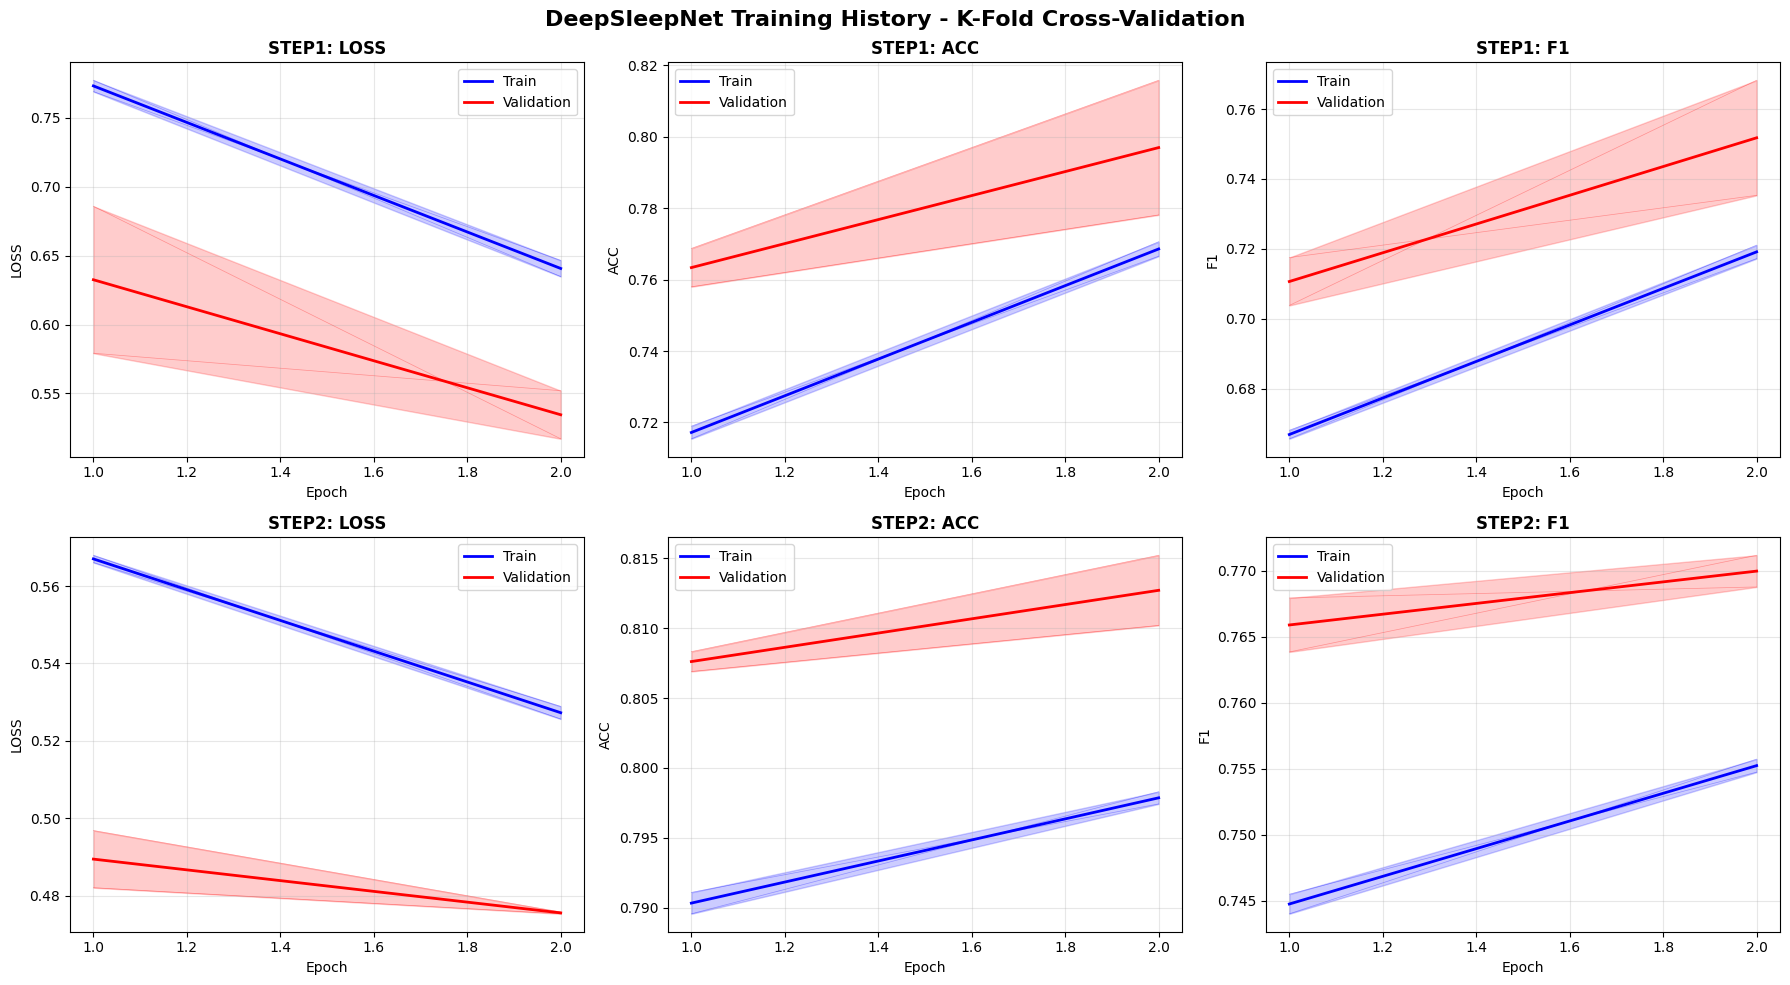

📊 Testing confusion matrices plot...


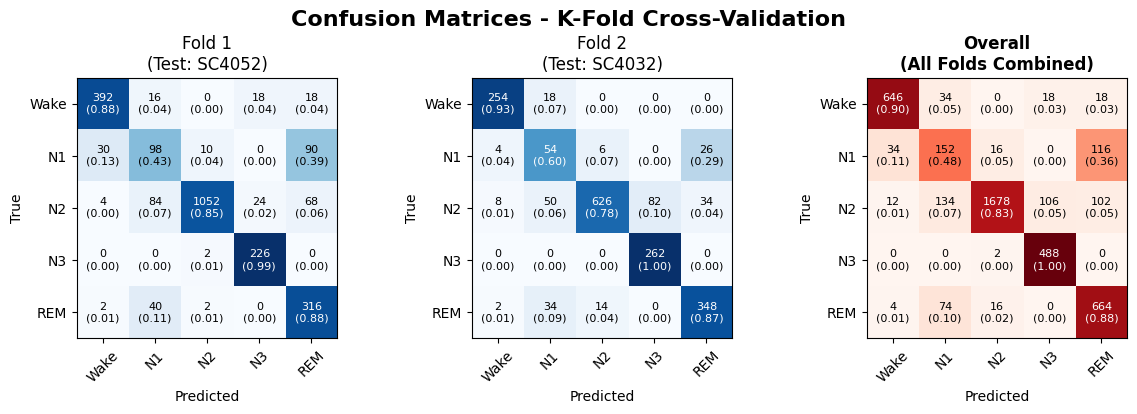

📊 Testing results summary...
DETAILED RESULTS SUMMARY

Per-Fold Results:
 Fold Test_Subject  Accuracy  Macro_F1  Weighted_F1  Cohens_Kappa  F1_Wake  F1_N1  F1_N2  F1_N3  F1_REM
    1       SC4052    0.8363    0.7777       0.8419        0.7697      0.0    0.0    0.0    0.0     0.0
    2       SC4032    0.8474    0.7948       0.8553        0.7944      0.0    0.0    0.0    0.0     0.0

Summary Statistics:
                Mean     Std     Min     Max
Accuracy      0.8418  0.0079  0.8363  0.8474
Macro_F1      0.7862  0.0121  0.7777  0.7948
Weighted_F1   0.8486  0.0095  0.8419  0.8553
Cohens_Kappa  0.7820  0.0175  0.7697  0.7944
F1_Wake       0.0000  0.0000  0.0000  0.0000
F1_N1         0.0000  0.0000  0.0000  0.0000
F1_N2         0.0000  0.0000  0.0000  0.0000
F1_N3         0.0000  0.0000  0.0000  0.0000
F1_REM        0.0000  0.0000  0.0000  0.0000

Overall Performance:
  Successful Folds: 2/2
  Mean Accuracy: 0.8418 ± 0.0079
  Mean Macro F1: 0.7862 ± 0.0121
  Mean Cohen's Kappa: 0.7820 ± 0

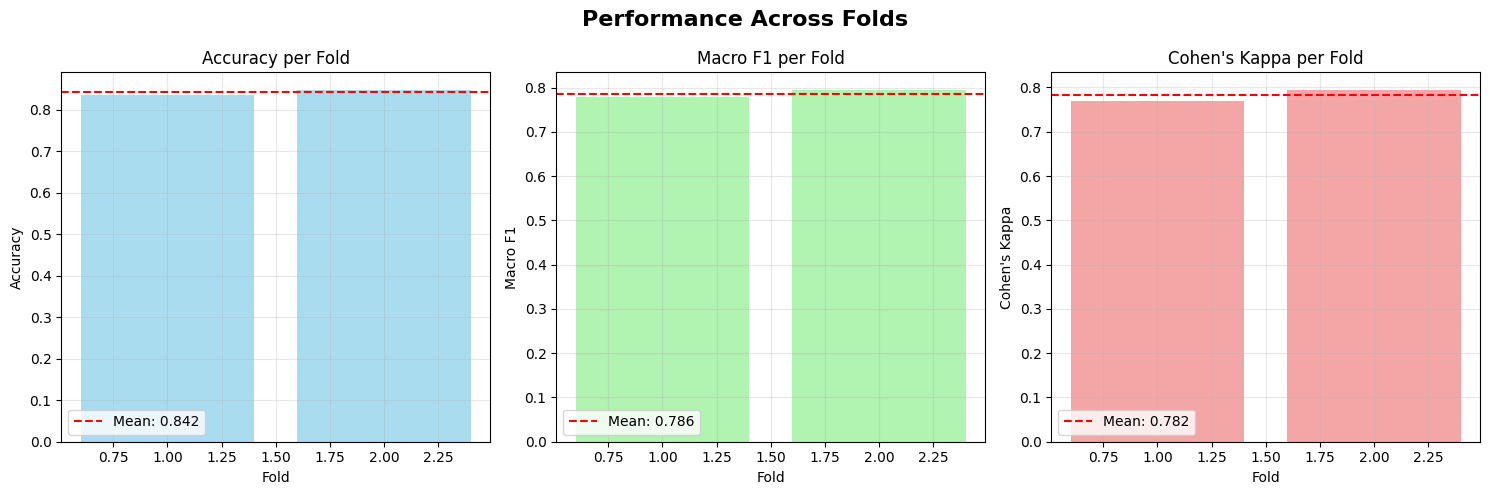

✅ All visualization functions tested successfully!


In [8]:
# Cell 8 (FIXED): Visualization và Analysis Functions
def plot_training_history(training_histories, save_path=None):
    """
    Vẽ training history từ k-fold CV
    
    BẠN CÓ THỂ TINH CHỈNH:
    - Plot styles
    - Metrics để hiển thị
    - Layout và colors
    """
    if not training_histories:
        print("No training histories to plot")
        return
    
    # Setup subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('DeepSleepNet Training History - K-Fold Cross-Validation', fontsize=16, fontweight='bold')
    
    metrics = ['loss', 'acc', 'f1']
    steps = ['step1', 'step2']
    
    for step_idx, step in enumerate(steps):
        for metric_idx, metric in enumerate(metrics):
            ax = axes[step_idx, metric_idx]
            
            # Collect data từ tất cả folds
            all_train_values = []
            all_val_values = []
            
            for fold_idx, history in enumerate(training_histories):
                if step in history and f'train_{metric}' in history[step]:
                    train_values = history[step][f'train_{metric}']
                    val_values = history[step][f'val_{metric}']
                    
                    epochs = range(1, len(train_values) + 1)
                    
                    # Plot individual fold với transparency
                    ax.plot(epochs, train_values, alpha=0.3, color='blue', linewidth=0.5)
                    ax.plot(epochs, val_values, alpha=0.3, color='red', linewidth=0.5)
                    
                    all_train_values.append(train_values)
                    all_val_values.append(val_values)
            
            # Plot average across folds
            if all_train_values:
                # Pad sequences to same length
                max_len = max(len(seq) for seq in all_train_values)
                
                train_padded = []
                val_padded = []
                
                for train_seq, val_seq in zip(all_train_values, all_val_values):
                    # Pad với last value
                    train_pad = train_seq + [train_seq[-1]] * (max_len - len(train_seq))
                    val_pad = val_seq + [val_seq[-1]] * (max_len - len(val_seq))
                    train_padded.append(train_pad)
                    val_padded.append(val_pad)
                
                # Calculate mean và std
                train_mean = np.mean(train_padded, axis=0)
                train_std = np.std(train_padded, axis=0)
                val_mean = np.mean(val_padded, axis=0)
                val_std = np.std(val_padded, axis=0)
                
                epochs = range(1, max_len + 1)
                
                # Plot mean với error bands
                ax.plot(epochs, train_mean, color='blue', linewidth=2, label='Train')
                ax.fill_between(epochs, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
                
                ax.plot(epochs, val_mean, color='red', linewidth=2, label='Validation')
                ax.fill_between(epochs, val_mean - val_std, val_mean + val_std, alpha=0.2, color='red')
            
            ax.set_title(f'{step.upper()}: {metric.upper()}', fontweight='bold')
            ax.set_xlabel('Epoch')
            ax.set_ylabel(metric.upper())
            ax.legend()
            ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Training history plot saved to {save_path}")
    
    plt.show()

def plot_confusion_matrices(fold_results, class_names, save_path=None):
    """Vẽ confusion matrices cho từng fold và overall"""
    successful_folds = [r for r in fold_results if 'confusion_matrix' in r]
    
    if not successful_folds:
        print("No confusion matrices to plot")
        return
    
    n_folds = len(successful_folds)
    n_cols = min(4, n_folds + 1)  # +1 cho overall
    n_rows = (n_folds + 1 + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle('Confusion Matrices - K-Fold Cross-Validation', fontsize=16, fontweight='bold')
    
    # Plot cho từng fold
    for i, fold_result in enumerate(successful_folds):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col]
        
        cm = fold_result['confusion_matrix']
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        im = ax.imshow(cm_normalized, interpolation='nearest', cmap='Blues')
        ax.set_title(f'Fold {fold_result["fold"]}\n(Test: {fold_result["test_subject"]})')
        
        # Add text annotations
        thresh = cm_normalized.max() / 2.
        for row_idx in range(cm.shape[0]):
            for col_idx in range(cm.shape[1]):
                ax.text(col_idx, row_idx, f'{cm[row_idx, col_idx]}\n({cm_normalized[row_idx, col_idx]:.2f})',
                       ha="center", va="center",
                       color="white" if cm_normalized[row_idx, col_idx] > thresh else "black",
                       fontsize=8)
        
        ax.set_xticks(range(len(class_names)))
        ax.set_yticks(range(len(class_names)))
        ax.set_xticklabels(class_names, rotation=45)
        ax.set_yticklabels(class_names)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
    
    # Overall confusion matrix
    if len(successful_folds) > 0:
        overall_cm = sum(r['confusion_matrix'] for r in successful_folds)
        overall_cm_norm = overall_cm.astype('float') / overall_cm.sum(axis=1)[:, np.newaxis]
        
        # Find position cho overall plot
        overall_pos = len(successful_folds)
        row = overall_pos // n_cols
        col = overall_pos % n_cols
        
        if row < n_rows and col < n_cols:
            ax = axes[row, col]
            
            im = ax.imshow(overall_cm_norm, interpolation='nearest', cmap='Reds')
            ax.set_title('Overall\n(All Folds Combined)', fontweight='bold')
            
            thresh = overall_cm_norm.max() / 2.
            for row_idx in range(overall_cm.shape[0]):
                for col_idx in range(overall_cm.shape[1]):
                    ax.text(col_idx, row_idx, f'{overall_cm[row_idx, col_idx]}\n({overall_cm_norm[row_idx, col_idx]:.2f})',
                           ha="center", va="center",
                           color="white" if overall_cm_norm[row_idx, col_idx] > thresh else "black",
                           fontsize=8)
            
            ax.set_xticks(range(len(class_names)))
            ax.set_yticks(range(len(class_names)))
            ax.set_xticklabels(class_names, rotation=45)
            ax.set_yticklabels(class_names)
            ax.set_xlabel('Predicted')
            ax.set_ylabel('True')
    
    # Hide unused subplots
    for i in range(len(successful_folds) + 1, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        if row < n_rows and col < n_cols:
            axes[row, col].set_visible(False)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Confusion matrices plot saved to {save_path}")
    
    plt.show()

def create_results_summary(cv_results, class_names):
    """
    Tạo summary table cho kết quả CV (FIXED VERSION)
    
    FIXES:
    - Kiểm tra tồn tại của classification_report trước khi truy cập
    - Xử lý trường hợp missing per-class metrics
    - Robust error handling
    """
    fold_results = cv_results['fold_results']
    successful_folds = [r for r in fold_results if 'error' not in r]
    
    if not successful_folds:
        print("No successful folds to summarize")
        return None, None
    
    # Create DataFrame với fold results
    summary_data = []
    
    for result in successful_folds:
        row = {
            'Fold': result['fold'],
            'Test_Subject': result['test_subject'],
            'Accuracy': result.get('accuracy', 0.0),
            'Macro_F1': result.get('macro_f1', 0.0),
            'Weighted_F1': result.get('weighted_f1', 0.0),
            'Cohens_Kappa': result.get('kappa', 0.0),
            'N_Test_Epochs': result.get('n_test_epochs', 'N/A'),
            'N_Train_Epochs': result.get('n_train_epochs', 'N/A')
        }
        
        # Add per-class F1 scores nếu có
        if 'classification_report' in result and result['classification_report']:
            try:
                for i, class_name in enumerate(class_names):
                    if str(i) in result['classification_report']:
                        f1_score = result['classification_report'][str(i)]['f1-score']
                        row[f'F1_{class_name}'] = f1_score
                    else:
                        row[f'F1_{class_name}'] = 0.0
            except Exception as e:
                print(f"Warning: Could not extract per-class metrics for fold {result['fold']}: {e}")
                # Add default values
                for class_name in class_names:
                    row[f'F1_{class_name}'] = 0.0
        else:
            # Add default values nếu không có classification_report
            for class_name in class_names:
                row[f'F1_{class_name}'] = 0.0
        
        summary_data.append(row)
    
    df = pd.DataFrame(summary_data)
    
    # Identify numeric columns that actually exist in DataFrame
    basic_metrics = ['Accuracy', 'Macro_F1', 'Weighted_F1', 'Cohens_Kappa']
    per_class_metrics = [f'F1_{name}' for name in class_names]
    
    # Check which columns actually exist
    existing_basic = [col for col in basic_metrics if col in df.columns]
    existing_per_class = [col for col in per_class_metrics if col in df.columns]
    
    numeric_cols = existing_basic + existing_per_class
    
    # Add summary statistics only for existing numeric columns
    if numeric_cols:
        summary_stats = pd.DataFrame({
            'Mean': df[numeric_cols].mean(),
            'Std': df[numeric_cols].std(),
            'Min': df[numeric_cols].min(),
            'Max': df[numeric_cols].max()
        })
    else:
        print("Warning: No numeric columns found for summary statistics")
        summary_stats = pd.DataFrame()
    
    print("="*80)
    print("DETAILED RESULTS SUMMARY")
    print("="*80)
    
    print("\nPer-Fold Results:")
    # Select columns to display
    display_cols = ['Fold', 'Test_Subject'] + existing_basic
    if len(existing_per_class) > 0:
        display_cols += existing_per_class
    
    print(df[display_cols].round(4).to_string(index=False))
    
    if not summary_stats.empty:
        print(f"\nSummary Statistics:")
        print(summary_stats.round(4).to_string())
        
        print(f"\nOverall Performance:")
        print(f"  Successful Folds: {len(successful_folds)}/{len(fold_results)}")
        
        if 'Accuracy' in summary_stats.index:
            print(f"  Mean Accuracy: {summary_stats.loc['Accuracy', 'Mean']:.4f} ± {summary_stats.loc['Accuracy', 'Std']:.4f}")
        if 'Macro_F1' in summary_stats.index:
            print(f"  Mean Macro F1: {summary_stats.loc['Macro_F1', 'Mean']:.4f} ± {summary_stats.loc['Macro_F1', 'Std']:.4f}")
        if 'Cohens_Kappa' in summary_stats.index:
            print(f"  Mean Cohen's Kappa: {summary_stats.loc['Cohens_Kappa', 'Mean']:.4f} ± {summary_stats.loc['Cohens_Kappa', 'Std']:.4f}")
    
    return df, summary_stats

def plot_performance_comparison(fold_results, class_names, save_path=None):
    """
    Vẽ biểu đồ so sánh performance across folds
    BẠN CÓ THỂ THÊM FUNCTION NÀY ĐỂ VISUALIZE PERFORMANCE
    """
    successful_folds = [r for r in fold_results if 'error' not in r]
    
    if not successful_folds:
        print("No successful folds to plot")
        return
    
    # Extract metrics
    folds = [r['fold'] for r in successful_folds]
    accuracies = [r['accuracy'] for r in successful_folds]
    macro_f1s = [r['macro_f1'] for r in successful_folds]
    kappas = [r['kappa'] for r in successful_folds]
    
    # Create subplot
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Performance Across Folds', fontsize=16, fontweight='bold')
    
    # Accuracy
    ax1.bar(folds, accuracies, alpha=0.7, color='skyblue')
    ax1.axhline(y=np.mean(accuracies), color='red', linestyle='--', label=f'Mean: {np.mean(accuracies):.3f}')
    ax1.set_title('Accuracy per Fold')
    ax1.set_xlabel('Fold')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Macro F1
    ax2.bar(folds, macro_f1s, alpha=0.7, color='lightgreen')
    ax2.axhline(y=np.mean(macro_f1s), color='red', linestyle='--', label=f'Mean: {np.mean(macro_f1s):.3f}')
    ax2.set_title('Macro F1 per Fold')
    ax2.set_xlabel('Fold')
    ax2.set_ylabel('Macro F1')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Cohen's Kappa
    ax3.bar(folds, kappas, alpha=0.7, color='lightcoral')
    ax3.axhline(y=np.mean(kappas), color='red', linestyle='--', label=f'Mean: {np.mean(kappas):.3f}')
    ax3.set_title("Cohen's Kappa per Fold")
    ax3.set_xlabel('Fold')
    ax3.set_ylabel("Cohen's Kappa")
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Performance comparison plot saved to {save_path}")
    
    plt.show()

# Test visualization functions với dummy data nếu có CV results
print(f"\n" + "="*60)
print(f"TESTING VISUALIZATION FUNCTIONS (FIXED)")
print(f"="*60)

# Tạo dummy results để test visualization nếu chưa có CV results
if 'cv_results' not in locals() or not cv_results or not cv_results.get('fold_results'):
    print("Creating dummy CV results for testing...")
    
    # Tạo dummy CV results
    dummy_cv_results = {
        'fold_results': [],
        'training_histories': [],
        'overall_predictions': [],
        'overall_labels': []
    }
    
    class_names = ['Wake', 'N1', 'N2', 'N3', 'REM']
    
    # Tạo 3 dummy folds
    for fold_idx in range(3):
        # Tạo dummy confusion matrix
        dummy_cm = np.random.randint(10, 100, (5, 5))
        
        # Tạo dummy predictions và labels
        n_test = 200
        dummy_preds = np.random.randint(0, 5, n_test)
        dummy_labels = np.random.randint(0, 5, n_test)
        
        # Calculate metrics
        dummy_acc = accuracy_score(dummy_labels, dummy_preds)
        dummy_f1 = f1_score(dummy_labels, dummy_preds, average='macro')
        dummy_kappa = cohen_kappa_score(dummy_labels, dummy_preds)
        
        # Tạo classification report
        dummy_report = classification_report(dummy_labels, dummy_preds, output_dict=True)
        
        fold_result = {
            'fold': fold_idx + 1,
            'test_subject': f'SC40{fold_idx:02d}',
            'accuracy': dummy_acc,
            'macro_f1': dummy_f1,
            'weighted_f1': dummy_f1 * 0.9,
            'kappa': dummy_kappa,
            'predictions': dummy_preds.tolist(),
            'labels': dummy_labels.tolist(),
            'confusion_matrix': dummy_cm,
            'classification_report': dummy_report,
            'n_test_epochs': n_test,
            'n_train_epochs': 1000
        }
        
        dummy_cv_results['fold_results'].append(fold_result)
        dummy_cv_results['overall_predictions'].extend(dummy_preds)
        dummy_cv_results['overall_labels'].extend(dummy_labels)
        
        # Dummy training history
        dummy_history = {
            'step1': {
                'train_loss': [0.8 - i*0.1 + np.random.normal(0, 0.05) for i in range(5)],
                'val_loss': [0.9 - i*0.1 + np.random.normal(0, 0.05) for i in range(5)],
                'train_acc': [0.4 + i*0.1 + np.random.normal(0, 0.02) for i in range(5)],
                'val_acc': [0.3 + i*0.1 + np.random.normal(0, 0.02) for i in range(5)],
                'train_f1': [0.35 + i*0.1 + np.random.normal(0, 0.02) for i in range(5)],
                'val_f1': [0.25 + i*0.1 + np.random.normal(0, 0.02) for i in range(5)]
            },
            'step2': {
                'train_loss': [0.5 - i*0.05 + np.random.normal(0, 0.02) for i in range(8)],
                'val_loss': [0.6 - i*0.05 + np.random.normal(0, 0.02) for i in range(8)],
                'train_acc': [0.7 + i*0.03 + np.random.normal(0, 0.01) for i in range(8)],
                'val_acc': [0.65 + i*0.03 + np.random.normal(0, 0.01) for i in range(8)],
                'train_f1': [0.68 + i*0.03 + np.random.normal(0, 0.01) for i in range(8)],
                'val_f1': [0.63 + i*0.03 + np.random.normal(0, 0.01) for i in range(8)]
            }
        }
        dummy_cv_results['training_histories'].append(dummy_history)
    
    cv_results = dummy_cv_results
    print("✅ Dummy CV results created")

# Test visualization functions
class_names = ['Wake', 'N1', 'N2', 'N3', 'REM']

try:
    # Test training history plot
    if cv_results.get('training_histories'):
        print("📊 Testing training history plot...")
        plot_training_history(cv_results['training_histories'])
    
    # Test confusion matrices
    print("📊 Testing confusion matrices plot...")
    plot_confusion_matrices(cv_results['fold_results'], class_names)
    
    # Test results summary
    print("📊 Testing results summary...")
    summary_df, summary_stats = create_results_summary(cv_results, class_names)
    
    # Test performance comparison
    print("📊 Testing performance comparison plot...")
    plot_performance_comparison(cv_results['fold_results'], class_names)
    
    print("✅ All visualization functions tested successfully!")
    
except Exception as e:
    print(f"❌ Error in visualization test: {e}")
    import traceback
    traceback.print_exc()

print("="*60)

# Cell 9: Full Pipeline Execution (BẠN CÓ THỂ CHẠY TOÀN BỘ PIPELINE)


In [9]:
# Cell 9: Full Pipeline Execution - CHẠY TOÀN BỘ DEEPSLEEPNET
def run_full_deepsleepnet_pipeline():
    """
    Chạy toàn bộ pipeline DeepSleepNet với k-fold cross-validation
    
    BẠN CÓ THỂ TINH CHỈNH TẤT CẢ PARAMETERS TẠI ĐÂY
    """
    print(f"\n" + "🚀" * 80)
    print(f"DEEPSLEEPNET FULL PIPELINE - SLEEP STAGE CLASSIFICATION")
    print(f"🚀" * 80)
    print(f"Started at: {time.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"User: anhtuandante")
    
    # =============================================================================
    # CONFIGURATION - BẠN CÓ THỂ THAY ĐỔI TẤT CẢ CÁC PARAMETERS NÀY
    # =============================================================================
    
    # Model configuration
    FINAL_MODEL_CONFIG = {
        'input_size': INPUT_SIZE,
        'sampling_freq': SAMPLING_FREQ,
        'n_classes': 5,
        'lstm_hidden_size': 512,    # 512 theo paper gốc
        'n_lstm_layers': 2,         # 2 layers theo paper
        'dropout_feature': 0.5,     # Dropout cho CNN
        'dropout_sequence': 0.5     # Dropout cho LSTM
    }
    
    # Training configuration
    FINAL_TRAINING_CONFIG = {
        'batch_size': 128,          # 128 theo paper gốc
        'step1_epochs': 100,         # Pre-training epochs
        'step2_epochs': 100,         # Fine-tuning epochs
        'step1_lr': 0.001,          # Learning rate cho step 1
        'step2_lr': 0.0001          # Learning rate cho step 2 (thấp hơn)
    }
    
    # Cross-validation configuration
    CV_CONFIG = {
        'k_folds': min(20, len(subjects_data)),  # 20 folds hoặc số subjects có sẵn
        'random_seed': 42
    }
    
    class_names = ['Wake', 'N1', 'N2', 'N3', 'REM']
    
    print(f"\n📋 CONFIGURATION:")
    print(f"  Model: {FINAL_MODEL_CONFIG}")
    print(f"  Training: {FINAL_TRAINING_CONFIG}")
    print(f"  CV: {CV_CONFIG}")
    print(f"  Device: {device}")
    print(f"  Total subjects: {len(subjects_data)}")
    
    # =============================================================================
    # EXECUTION
    # =============================================================================
    
    try:
        # Setup folds
        print(f"\n🔄 Setting up {CV_CONFIG['k_folds']}-fold cross-validation...")
        cv_folds = setup_kfold_cv(subjects_data, k=CV_CONFIG['k_folds'])
        
        # Run cross-validation
        print(f"\n🚀 Starting cross-validation...")
        start_time = time.time()
        
        cv_results = run_kfold_cv(
            subjects_data=subjects_data,
            folds=cv_folds,
            model_config=FINAL_MODEL_CONFIG,
            training_config=FINAL_TRAINING_CONFIG
        )
        
        total_time = time.time() - start_time
        
        # ==========================================================================
        # RESULTS ANALYSIS
        # ==========================================================================
        
        print(f"\n" + "📊" * 80)
        print(f"RESULTS ANALYSIS")
        print(f"📊" * 80)
        
        # Create detailed summary
        summary_df, summary_stats = create_results_summary(cv_results, class_names)
        
        # Visualizations
        print(f"\n📈 Generating visualizations...")
        
        # Training history
        if cv_results['training_histories']:
            plot_training_history(cv_results['training_histories'])
        
        # Confusion matrices
        plot_confusion_matrices(cv_results['fold_results'], class_names)
        
        # ==========================================================================
        # FINAL RESULTS
        # ==========================================================================
        
        successful_folds = [r for r in cv_results['fold_results'] if 'error' not in r]
        
        if successful_folds:
            final_accuracy = np.mean([r['accuracy'] for r in successful_folds])
            final_macro_f1 = np.mean([r['macro_f1'] for r in successful_folds])
            final_kappa = np.mean([r['kappa'] for r in successful_folds])
            
            print(f"\n" + "🏆" * 80)
            print(f"FINAL RESULTS - DEEPSLEEPNET PERFORMANCE")
            print(f"🏆" * 80)
            print(f"")
            print(f"📈 OVERALL PERFORMANCE:")
            print(f"  🎯 Accuracy: {final_accuracy:.4f} ± {np.std([r['accuracy'] for r in successful_folds]):.4f}")
            print(f"  🎯 Macro F1: {final_macro_f1:.4f} ± {np.std([r['macro_f1'] for r in successful_folds]):.4f}")
            print(f"  🎯 Cohen's Kappa: {final_kappa:.4f} ± {np.std([r['kappa'] for r in successful_folds]):.4f}")
            print(f"")
            print(f"📊 EXPERIMENTAL DETAILS:")
            print(f"  ✅ Successful Folds: {len(successful_folds)}/{len(cv_results['fold_results'])}")
            print(f"  ⏱️  Total Time: {total_time/3600:.2f} hours")
            print(f"  🏗️  Model Parameters: {sum(p.numel() for p in DeepSleepNet(**FINAL_MODEL_CONFIG).parameters()):,}")
            print(f"  📁 Total Epochs Processed: {sum(r.get('n_test_epochs', 0) + r.get('n_train_epochs', 0) for r in successful_folds):,}")
            
            # Per-class performance
            if cv_results['overall_labels'] and cv_results['overall_predictions']:
                overall_report = classification_report(
                    cv_results['overall_labels'], 
                    cv_results['overall_predictions'],
                    target_names=class_names,
                    output_dict=True
                )
                
                print(f"")
                print(f"🏷️  PER-CLASS PERFORMANCE:")
                for i, class_name in enumerate(class_names):
                    if str(i) in overall_report:
                        precision = overall_report[str(i)]['precision']
                        recall = overall_report[str(i)]['recall']
                        f1 = overall_report[str(i)]['f1-score']
                        support = overall_report[str(i)]['support']
                        print(f"  {class_name:4s}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f} (N={support:,})")
            
            print(f"")
            print(f"✅ DeepSleepNet pipeline completed successfully!")
            print(f"📅 Completed at: {time.strftime('%Y-%m-%d %H:%M:%S')}")
            print(f"🏆" * 80)
            
            return cv_results, summary_df, summary_stats
        
        else:
            print(f"❌ No successful folds completed")
            return None, None, None
            
    except Exception as e:
        print(f"❌ Error in full pipeline: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

# =============================================================================
# BẠN CÓ THỂ UNCOMMENT DÒNG DƯỚI ĐỂ CHẠY TOÀN BỘ PIPELINE
# =============================================================================

print("🔥 Ready to run full DeepSleepNet pipeline!")
print("📝 To execute, uncomment the line below:")
print("# final_results, final_summary_df, final_summary_stats = run_full_deepsleepnet_pipeline()")

# Uncomment dòng dưới để chạy toàn bộ pipeline
# final_results, final_summary_df, final_summary_stats = run_full_deepsleepnet_pipeline()

🔥 Ready to run full DeepSleepNet pipeline!
📝 To execute, uncomment the line below:
# final_results, final_summary_df, final_summary_stats = run_full_deepsleepnet_pipeline()


# Cell 10: Save và Load Functions


In [10]:
# Cell 10: Save và Load Functions cho model và results
import json
from datetime import datetime

def save_experiment_results(cv_results, summary_df, summary_stats, 
                           model_config, training_config, 
                           experiment_name=None, save_dir="./deepsleepnet_results"):
    """
    Lưu toàn bộ kết quả experiment
    
    BẠN CÓ THỂ TINH CHỈNH:
    - Format lưu file
    - Thông tin metadata
    - Compression options
    """
    if experiment_name is None:
        experiment_name = f"deepsleepnet_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    
    # Create save directory
    os.makedirs(save_dir, exist_ok=True)
    experiment_dir = os.path.join(save_dir, experiment_name)
    os.makedirs(experiment_dir, exist_ok=True)
    
    print(f"💾 Saving experiment results to: {experiment_dir}")
    
    # Save configurations
    config = {
        'model_config': model_config,
        'training_config': training_config,
        'experiment_info': {
            'experiment_name': experiment_name,
            'timestamp': datetime.now().isoformat(),
            'user': 'anhtuandante',
            'device': str(device),
            'total_subjects': len(subjects_data),
            'sampling_frequency': SAMPLING_FREQ,
            'epoch_length': EPOCH_LENGTH
        }
    }
    
    with open(os.path.join(experiment_dir, 'config.json'), 'w') as f:
        json.dump(config, f, indent=2)
    
    # Save CV results
    cv_results_to_save = cv_results.copy()
    # Convert numpy arrays to lists cho JSON serialization
    for fold_result in cv_results_to_save['fold_results']:
        if 'confusion_matrix' in fold_result:
            fold_result['confusion_matrix'] = fold_result['confusion_matrix'].tolist()
        if 'predictions' in fold_result:
            fold_result['predictions'] = [int(p) for p in fold_result['predictions']]
        if 'labels' in fold_result:
            fold_result['labels'] = [int(l) for l in fold_result['labels']]
    
    with open(os.path.join(experiment_dir, 'cv_results.json'), 'w') as f:
        json.dump(cv_results_to_save, f, indent=2)
    
    # Save summary tables
    if summary_df is not None:
        summary_df.to_csv(os.path.join(experiment_dir, 'fold_summary.csv'), index=False)
    
    if summary_stats is not None:
        summary_stats.to_csv(os.path.join(experiment_dir, 'summary_statistics.csv'))
    
    # Save final model architecture (không include weights)
    dummy_model = DeepSleepNet(**model_config)
    model_info = {
        'architecture': str(dummy_model),
        'total_parameters': dummy_model.count_parameters(),
        'model_config': model_config
    }
    
    with open(os.path.join(experiment_dir, 'model_architecture.json'), 'w') as f:
        json.dump(model_info, f, indent=2)
    
    print(f"✅ Experiment saved successfully!")
    print(f"📁 Files saved:")
    print(f"  - config.json (experiment configuration)")
    print(f"  - cv_results.json (cross-validation results)")
    print(f"  - fold_summary.csv (per-fold summary)")
    print(f"  - summary_statistics.csv (overall statistics)")
    print(f"  - model_architecture.json (model info)")
    
    return experiment_dir

def load_experiment_results(experiment_dir):
    """Load experiment results từ saved directory"""
    print(f"📂 Loading experiment from: {experiment_dir}")
    
    # Load config
    with open(os.path.join(experiment_dir, 'config.json'), 'r') as f:
        config = json.load(f)
    
    # Load CV results
    with open(os.path.join(experiment_dir, 'cv_results.json'), 'r') as f:
        cv_results = json.load(f)
    
    # Load summary tables
    summary_df = pd.read_csv(os.path.join(experiment_dir, 'fold_summary.csv'))
    summary_stats = pd.read_csv(os.path.join(experiment_dir, 'summary_statistics.csv'), index_col=0)
    
    print(f"✅ Experiment loaded successfully!")
    return config, cv_results, summary_df, summary_stats

# Tạo function để chạy experiment với auto-save
def run_and_save_experiment(experiment_name=None, save_results=True):
    """
    Chạy experiment và tự động save kết quả
    
    BẠN CÓ THỂ GỌI FUNCTION NÀY ĐỂ CHẠY VÀ LƯU KẾT QUẢ
    """
    print(f"🚀 Starting DeepSleepNet experiment with auto-save...")
    
    # Run full pipeline
    cv_results, summary_df, summary_stats = run_full_deepsleepnet_pipeline()
    
    if cv_results is not None and save_results:
        # Auto-save results
        model_config = {
            'input_size': INPUT_SIZE,
            'sampling_freq': SAMPLING_FREQ,
            'n_classes': 5,
            'lstm_hidden_size': 512,
            'n_lstm_layers': 2,
            'dropout_feature': 0.5,
            'dropout_sequence': 0.5
        }
        
        training_config = {
            'batch_size': 128,
            'step1_epochs': 15,
            'step2_epochs': 30,
            'step1_lr': 0.001,
            'step2_lr': 0.0001
        }
        
        experiment_dir = save_experiment_results(
            cv_results, summary_df, summary_stats,
            model_config, training_config,
            experiment_name
        )
        
        print(f"💾 Results automatically saved to: {experiment_dir}")
        return cv_results, summary_df, summary_stats, experiment_dir
    
    return cv_results, summary_df, summary_stats, None

print("="*80)
print("🎯 DEEPSLEEPNET IMPLEMENTATION COMPLETED!")
print("="*80)
print()
print("📚 Available functions:")
print("  1. run_full_deepsleepnet_pipeline() - Chạy toàn bộ pipeline")
print("  2. run_and_save_experiment() - Chạy và tự động lưu kết quả")
print("  3. save_experiment_results() - Lưu kết quả experiment")
print("  4. load_experiment_results() - Load kết quả đã lưu")
print()
print("🚀 To run the complete experiment:")
print("   results, summary_df, summary_stats, save_dir = run_and_save_experiment('my_experiment')")
print()
print("✨ All components ready for Sleep Stage Classification with DeepSleepNet!")
print("="*80)

🎯 DEEPSLEEPNET IMPLEMENTATION COMPLETED!

📚 Available functions:
  1. run_full_deepsleepnet_pipeline() - Chạy toàn bộ pipeline
  2. run_and_save_experiment() - Chạy và tự động lưu kết quả
  3. save_experiment_results() - Lưu kết quả experiment
  4. load_experiment_results() - Load kết quả đã lưu

🚀 To run the complete experiment:
   results, summary_df, summary_stats, save_dir = run_and_save_experiment('my_experiment')

✨ All components ready for Sleep Stage Classification with DeepSleepNet!



🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
DEEPSLEEPNET FULL PIPELINE - SLEEP STAGE CLASSIFICATION
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
Started at: 2025-06-04 11:40:43
User: anhtuandante

📋 CONFIGURATION:
  Model: {'input_size': 3000, 'sampling_freq': 100, 'n_classes': 5, 'lstm_hidden_size': 512, 'n_lstm_layers': 2, 'dropout_feature': 0.5, 'dropout_sequence': 0.5}
  Training: {'batch_size': 128, 'step1_epochs': 100, 'step2_epochs': 100, 'step1_lr': 0.001, 'step2_lr': 0.0001}
  CV: {'k_folds': 20, 'random_seed': 42}
  Device: cuda
  Total subjects: 39

🔄 Setting up 20-fold cross-validation...
✓ Created 20 folds for cross-validation
  Fold 1: Test=SC4052, Train=38 subjects
  Fold 2: Test=SC4032, Train=38 subjects
  Fold 3: Test=SC4062, Train=38 subjects
  Fold 4: Test=SC4102, Train=38 subjects
  Fold 5: Test=SC4172, Train=38 subjects

🚀 Starting cross-validation...

STARTING 20-FOLD CROSS-VALIDATION

🔥🔥🔥🔥🔥

Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 84.26it/s, Loss=0.6099]


Train - Loss: 0.7794, Acc: 0.7118, F1: 0.6631
Val   - Loss: 0.6099, Acc: 0.7935, F1: 0.7361

Step 1 - Epoch 2/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 84.73it/s, Loss=0.5507]


Train - Loss: 0.6144, Acc: 0.7756, F1: 0.7266
Val   - Loss: 0.5507, Acc: 0.8177, F1: 0.7622

Step 1 - Epoch 3/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 84.13it/s, Loss=0.5434]


Train - Loss: 0.5807, Acc: 0.7826, F1: 0.7380
Val   - Loss: 0.5434, Acc: 0.7754, F1: 0.7349

Step 1 - Epoch 4/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 84.80it/s, Loss=0.4996]


Train - Loss: 0.5560, Acc: 0.7894, F1: 0.7463
Val   - Loss: 0.4996, Acc: 0.8126, F1: 0.7661

Step 1 - Epoch 5/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 84.65it/s, Loss=0.4968]


Train - Loss: 0.5441, Acc: 0.7929, F1: 0.7507
Val   - Loss: 0.4968, Acc: 0.8028, F1: 0.7611

Step 1 - Epoch 6/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.63it/s, Loss=0.4957]


Train - Loss: 0.5296, Acc: 0.7979, F1: 0.7564
Val   - Loss: 0.4957, Acc: 0.8104, F1: 0.7644

Step 1 - Epoch 7/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.58it/s, Loss=0.4597]


Train - Loss: 0.5175, Acc: 0.8011, F1: 0.7602
Val   - Loss: 0.4597, Acc: 0.8141, F1: 0.7739

Step 1 - Epoch 8/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.16it/s, Loss=0.4588]


Train - Loss: 0.5079, Acc: 0.8026, F1: 0.7633
Val   - Loss: 0.4588, Acc: 0.8194, F1: 0.7773

Step 1 - Epoch 9/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.32it/s, Loss=0.4504]


Train - Loss: 0.4989, Acc: 0.8050, F1: 0.7654
Val   - Loss: 0.4504, Acc: 0.8190, F1: 0.7779

Step 1 - Epoch 10/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.01it/s, Loss=0.4781]


Train - Loss: 0.4908, Acc: 0.8086, F1: 0.7698
Val   - Loss: 0.4781, Acc: 0.8024, F1: 0.7611

Step 1 - Epoch 11/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.70it/s, Loss=0.4548]


Train - Loss: 0.4808, Acc: 0.8101, F1: 0.7720
Val   - Loss: 0.4548, Acc: 0.7921, F1: 0.7555

Step 1 - Epoch 12/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 75.25it/s, Loss=0.4233]


Train - Loss: 0.4776, Acc: 0.8110, F1: 0.7726
Val   - Loss: 0.4233, Acc: 0.8213, F1: 0.7834

Step 1 - Epoch 13/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.28it/s, Loss=0.4313]


Train - Loss: 0.4713, Acc: 0.8137, F1: 0.7764
Val   - Loss: 0.4313, Acc: 0.8335, F1: 0.7913

Step 1 - Epoch 14/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.58it/s, Loss=0.4086]


Train - Loss: 0.4607, Acc: 0.8163, F1: 0.7792
Val   - Loss: 0.4086, Acc: 0.8294, F1: 0.7926

Step 1 - Epoch 15/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.86it/s, Loss=0.4269]


Train - Loss: 0.4596, Acc: 0.8144, F1: 0.7780
Val   - Loss: 0.4269, Acc: 0.8179, F1: 0.7800

Step 1 - Epoch 16/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.23it/s, Loss=0.4403]


Train - Loss: 0.4536, Acc: 0.8179, F1: 0.7815
Val   - Loss: 0.4403, Acc: 0.8249, F1: 0.7864

Step 1 - Epoch 17/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.34it/s, Loss=0.4101]


Train - Loss: 0.4488, Acc: 0.8189, F1: 0.7827
Val   - Loss: 0.4101, Acc: 0.8184, F1: 0.7826

Step 1 - Epoch 18/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.20it/s, Loss=0.4128]


Train - Loss: 0.4454, Acc: 0.8178, F1: 0.7822
Val   - Loss: 0.4128, Acc: 0.8416, F1: 0.8006

Step 1 - Epoch 19/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.94it/s, Loss=0.4175]


Train - Loss: 0.4352, Acc: 0.8239, F1: 0.7883
Val   - Loss: 0.4175, Acc: 0.8138, F1: 0.7785

Step 1 - Epoch 20/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.76it/s, Loss=0.4026]


Train - Loss: 0.4331, Acc: 0.8219, F1: 0.7869
Val   - Loss: 0.4026, Acc: 0.8320, F1: 0.7937

Step 1 - Epoch 21/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.00it/s, Loss=0.4166]


Train - Loss: 0.4345, Acc: 0.8254, F1: 0.7910
Val   - Loss: 0.4166, Acc: 0.7882, F1: 0.7616

Step 1 - Epoch 22/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.58it/s, Loss=0.3917]


Train - Loss: 0.4296, Acc: 0.8256, F1: 0.7916
Val   - Loss: 0.3917, Acc: 0.8342, F1: 0.7998

Step 1 - Epoch 23/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.72it/s, Loss=0.4124]


Train - Loss: 0.4200, Acc: 0.8282, F1: 0.7949
Val   - Loss: 0.4124, Acc: 0.8323, F1: 0.7945

Step 1 - Epoch 24/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.59it/s, Loss=0.4168]


Train - Loss: 0.4159, Acc: 0.8288, F1: 0.7958
Val   - Loss: 0.4168, Acc: 0.8241, F1: 0.7879

Step 1 - Epoch 25/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.79it/s, Loss=0.4011]


Train - Loss: 0.4123, Acc: 0.8295, F1: 0.7970
Val   - Loss: 0.4011, Acc: 0.8417, F1: 0.8044

Step 1 - Epoch 26/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.81it/s, Loss=0.3964]


Train - Loss: 0.4083, Acc: 0.8326, F1: 0.8001
Val   - Loss: 0.3964, Acc: 0.8539, F1: 0.8152

Step 1 - Epoch 27/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.30it/s, Loss=0.3769]


Train - Loss: 0.4033, Acc: 0.8334, F1: 0.8006
Val   - Loss: 0.3769, Acc: 0.8443, F1: 0.8077

Step 1 - Epoch 28/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.52it/s, Loss=0.3965]


Train - Loss: 0.4029, Acc: 0.8335, F1: 0.8021
Val   - Loss: 0.3965, Acc: 0.8449, F1: 0.8064

Step 1 - Epoch 29/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.31it/s, Loss=0.3788]


Train - Loss: 0.4006, Acc: 0.8356, F1: 0.8040
Val   - Loss: 0.3788, Acc: 0.8345, F1: 0.8002

Step 1 - Epoch 30/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 74.30it/s, Loss=0.3801]


Train - Loss: 0.3941, Acc: 0.8358, F1: 0.8047
Val   - Loss: 0.3801, Acc: 0.8448, F1: 0.8095

Step 1 - Epoch 31/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.40it/s, Loss=0.3817]


Train - Loss: 0.3884, Acc: 0.8384, F1: 0.8078
Val   - Loss: 0.3817, Acc: 0.8317, F1: 0.8004

Step 1 - Epoch 32/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.13it/s, Loss=0.3635]


Train - Loss: 0.3888, Acc: 0.8393, F1: 0.8080
Val   - Loss: 0.3635, Acc: 0.8537, F1: 0.8195

Step 1 - Epoch 33/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.48it/s, Loss=0.3628]


Train - Loss: 0.3880, Acc: 0.8402, F1: 0.8100
Val   - Loss: 0.3628, Acc: 0.8425, F1: 0.8111

Step 1 - Epoch 34/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.93it/s, Loss=0.3703]


Train - Loss: 0.3797, Acc: 0.8405, F1: 0.8103
Val   - Loss: 0.3703, Acc: 0.8217, F1: 0.7933

Step 1 - Epoch 35/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.06it/s, Loss=0.3547]


Train - Loss: 0.3771, Acc: 0.8424, F1: 0.8134
Val   - Loss: 0.3547, Acc: 0.8480, F1: 0.8143

Step 1 - Epoch 36/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.28it/s, Loss=0.3797]


Train - Loss: 0.3800, Acc: 0.8433, F1: 0.8134
Val   - Loss: 0.3797, Acc: 0.8233, F1: 0.7939

Step 1 - Epoch 37/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.40it/s, Loss=0.3595]


Train - Loss: 0.3779, Acc: 0.8425, F1: 0.8131
Val   - Loss: 0.3595, Acc: 0.8208, F1: 0.7939

Step 1 - Epoch 38/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.51it/s, Loss=0.3613]


Train - Loss: 0.3733, Acc: 0.8444, F1: 0.8154
Val   - Loss: 0.3613, Acc: 0.8393, F1: 0.8096

Step 1 - Epoch 39/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.49it/s, Loss=0.3496]


Train - Loss: 0.3669, Acc: 0.8458, F1: 0.8172
Val   - Loss: 0.3496, Acc: 0.8535, F1: 0.8218

Step 1 - Epoch 40/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 75.53it/s, Loss=0.3600]


Train - Loss: 0.3666, Acc: 0.8470, F1: 0.8175
Val   - Loss: 0.3600, Acc: 0.8337, F1: 0.8047

Step 1 - Epoch 41/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.34it/s, Loss=0.3570]


Train - Loss: 0.3647, Acc: 0.8471, F1: 0.8183
Val   - Loss: 0.3570, Acc: 0.8569, F1: 0.8249

Step 1 - Epoch 42/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.07it/s, Loss=0.3671]


Train - Loss: 0.3636, Acc: 0.8484, F1: 0.8194
Val   - Loss: 0.3671, Acc: 0.8494, F1: 0.8163

Step 1 - Epoch 43/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.62it/s, Loss=0.3294]


Train - Loss: 0.3597, Acc: 0.8506, F1: 0.8223
Val   - Loss: 0.3294, Acc: 0.8606, F1: 0.8308

Step 1 - Epoch 44/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.86it/s, Loss=0.3430]


Train - Loss: 0.3611, Acc: 0.8478, F1: 0.8198
Val   - Loss: 0.3430, Acc: 0.8541, F1: 0.8263

Step 1 - Epoch 45/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.73it/s, Loss=0.3329]


Train - Loss: 0.3574, Acc: 0.8497, F1: 0.8224
Val   - Loss: 0.3329, Acc: 0.8367, F1: 0.8118

Step 1 - Epoch 46/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.08it/s, Loss=0.3615]


Train - Loss: 0.3529, Acc: 0.8512, F1: 0.8242
Val   - Loss: 0.3615, Acc: 0.8317, F1: 0.8070

Step 1 - Epoch 47/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.60it/s, Loss=0.3363]


Train - Loss: 0.3532, Acc: 0.8496, F1: 0.8225
Val   - Loss: 0.3363, Acc: 0.8589, F1: 0.8314

Step 1 - Epoch 48/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.37it/s, Loss=0.3243]


Train - Loss: 0.3487, Acc: 0.8523, F1: 0.8254
Val   - Loss: 0.3243, Acc: 0.8605, F1: 0.8339

Step 1 - Epoch 49/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.29it/s, Loss=0.3216]


Train - Loss: 0.3539, Acc: 0.8500, F1: 0.8230
Val   - Loss: 0.3216, Acc: 0.8602, F1: 0.8324

Step 1 - Epoch 50/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.71it/s, Loss=0.3465]


Train - Loss: 0.3473, Acc: 0.8535, F1: 0.8269
Val   - Loss: 0.3465, Acc: 0.8483, F1: 0.8239

Step 1 - Epoch 51/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.49it/s, Loss=0.3419]


Train - Loss: 0.3532, Acc: 0.8506, F1: 0.8240
Val   - Loss: 0.3419, Acc: 0.8646, F1: 0.8366

Step 1 - Epoch 52/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.86it/s, Loss=0.3349]


Train - Loss: 0.3482, Acc: 0.8525, F1: 0.8264
Val   - Loss: 0.3349, Acc: 0.8477, F1: 0.8217

Step 1 - Epoch 53/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.74it/s, Loss=0.3148]


Train - Loss: 0.3485, Acc: 0.8525, F1: 0.8264
Val   - Loss: 0.3148, Acc: 0.8622, F1: 0.8370

Step 1 - Epoch 54/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.53it/s, Loss=0.3253]


Train - Loss: 0.3433, Acc: 0.8545, F1: 0.8278
Val   - Loss: 0.3253, Acc: 0.8650, F1: 0.8388

Step 1 - Epoch 55/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.95it/s, Loss=0.3239]


Train - Loss: 0.3402, Acc: 0.8559, F1: 0.8301
Val   - Loss: 0.3239, Acc: 0.8497, F1: 0.8246

Step 1 - Epoch 56/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.10it/s, Loss=0.3522]


Train - Loss: 0.3387, Acc: 0.8555, F1: 0.8301
Val   - Loss: 0.3522, Acc: 0.8647, F1: 0.8348

Step 1 - Epoch 57/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.37it/s, Loss=0.3473]


Train - Loss: 0.3429, Acc: 0.8553, F1: 0.8293
Val   - Loss: 0.3473, Acc: 0.8492, F1: 0.8221

Step 1 - Epoch 58/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.92it/s, Loss=0.3134]


Train - Loss: 0.3401, Acc: 0.8558, F1: 0.8308
Val   - Loss: 0.3134, Acc: 0.8593, F1: 0.8328

Step 1 - Epoch 59/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.23it/s, Loss=0.3150]


Train - Loss: 0.3388, Acc: 0.8567, F1: 0.8312
Val   - Loss: 0.3150, Acc: 0.8641, F1: 0.8354

Step 1 - Epoch 60/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.18it/s, Loss=0.3093]


Train - Loss: 0.3340, Acc: 0.8578, F1: 0.8320
Val   - Loss: 0.3093, Acc: 0.8598, F1: 0.8361

Step 1 - Epoch 61/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.78it/s, Loss=0.3449]


Train - Loss: 0.3319, Acc: 0.8582, F1: 0.8336
Val   - Loss: 0.3449, Acc: 0.8381, F1: 0.8161

Step 1 - Epoch 62/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.82it/s, Loss=0.3255]


Train - Loss: 0.3366, Acc: 0.8581, F1: 0.8328
Val   - Loss: 0.3255, Acc: 0.8585, F1: 0.8347

Step 1 - Epoch 63/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.24it/s, Loss=0.3066]


Train - Loss: 0.3330, Acc: 0.8559, F1: 0.8316
Val   - Loss: 0.3066, Acc: 0.8553, F1: 0.8328

Step 1 - Epoch 64/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.08it/s, Loss=0.3223]


Train - Loss: 0.3289, Acc: 0.8596, F1: 0.8351
Val   - Loss: 0.3223, Acc: 0.8724, F1: 0.8486

Step 1 - Epoch 65/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.53it/s, Loss=0.3166]


Train - Loss: 0.3295, Acc: 0.8579, F1: 0.8331
Val   - Loss: 0.3166, Acc: 0.8591, F1: 0.8386

Step 1 - Epoch 66/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.70it/s, Loss=0.3210]


Train - Loss: 0.3266, Acc: 0.8589, F1: 0.8347
Val   - Loss: 0.3210, Acc: 0.8633, F1: 0.8398

Step 1 - Epoch 67/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.72it/s, Loss=0.3400]


Train - Loss: 0.3287, Acc: 0.8600, F1: 0.8360
Val   - Loss: 0.3400, Acc: 0.8622, F1: 0.8379

Step 1 - Epoch 68/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.93it/s, Loss=0.3158]


Train - Loss: 0.3332, Acc: 0.8578, F1: 0.8328
Val   - Loss: 0.3158, Acc: 0.8635, F1: 0.8366

Step 1 - Epoch 69/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.63it/s, Loss=0.2913]


Train - Loss: 0.3293, Acc: 0.8572, F1: 0.8323
Val   - Loss: 0.2913, Acc: 0.8650, F1: 0.8418

Step 1 - Epoch 70/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.92it/s, Loss=0.3267]


Train - Loss: 0.3280, Acc: 0.8593, F1: 0.8350
Val   - Loss: 0.3267, Acc: 0.8555, F1: 0.8327

Step 1 - Epoch 71/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.25it/s, Loss=0.3047]


Train - Loss: 0.3243, Acc: 0.8601, F1: 0.8356
Val   - Loss: 0.3047, Acc: 0.8530, F1: 0.8287

Step 1 - Epoch 72/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.57it/s, Loss=0.3176]


Train - Loss: 0.3219, Acc: 0.8611, F1: 0.8374
Val   - Loss: 0.3176, Acc: 0.8610, F1: 0.8356

Step 1 - Epoch 73/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.39it/s, Loss=0.3225]


Train - Loss: 0.3241, Acc: 0.8610, F1: 0.8370
Val   - Loss: 0.3225, Acc: 0.8492, F1: 0.8277

Step 1 - Epoch 74/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.40it/s, Loss=0.3246]


Train - Loss: 0.3225, Acc: 0.8623, F1: 0.8381
Val   - Loss: 0.3246, Acc: 0.8662, F1: 0.8431

Step 1 - Epoch 75/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.82it/s, Loss=0.3154]


Train - Loss: 0.3231, Acc: 0.8615, F1: 0.8373
Val   - Loss: 0.3154, Acc: 0.8749, F1: 0.8506

Step 1 - Epoch 76/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.70it/s, Loss=0.2783]


Train - Loss: 0.2900, Acc: 0.8727, F1: 0.8522
Val   - Loss: 0.2783, Acc: 0.8659, F1: 0.8486

Step 1 - Epoch 77/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.70it/s, Loss=0.2699]


Train - Loss: 0.2768, Acc: 0.8781, F1: 0.8591
Val   - Loss: 0.2699, Acc: 0.8685, F1: 0.8489

Step 1 - Epoch 78/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.50it/s, Loss=0.2772]


Train - Loss: 0.2713, Acc: 0.8791, F1: 0.8600
Val   - Loss: 0.2772, Acc: 0.8623, F1: 0.8471

Step 1 - Epoch 79/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.63it/s, Loss=0.2905]


Train - Loss: 0.2695, Acc: 0.8816, F1: 0.8627
Val   - Loss: 0.2905, Acc: 0.8822, F1: 0.8645

Step 1 - Epoch 80/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.55it/s, Loss=0.2637]


Train - Loss: 0.2602, Acc: 0.8838, F1: 0.8662
Val   - Loss: 0.2637, Acc: 0.8850, F1: 0.8676

Step 1 - Epoch 81/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.11it/s, Loss=0.2541]


Train - Loss: 0.2608, Acc: 0.8834, F1: 0.8656
Val   - Loss: 0.2541, Acc: 0.8854, F1: 0.8686

Step 1 - Epoch 82/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.84it/s, Loss=0.2439]


Train - Loss: 0.2589, Acc: 0.8864, F1: 0.8690
Val   - Loss: 0.2439, Acc: 0.8911, F1: 0.8748

Step 1 - Epoch 83/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.89it/s, Loss=0.2696]


Train - Loss: 0.2553, Acc: 0.8864, F1: 0.8688
Val   - Loss: 0.2696, Acc: 0.8846, F1: 0.8738

Step 1 - Epoch 84/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.25it/s, Loss=0.2482]


Train - Loss: 0.2561, Acc: 0.8852, F1: 0.8681
Val   - Loss: 0.2482, Acc: 0.8761, F1: 0.8578

Step 1 - Epoch 85/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.65it/s, Loss=0.2472]


Train - Loss: 0.2575, Acc: 0.8854, F1: 0.8675
Val   - Loss: 0.2472, Acc: 0.8770, F1: 0.8603

Step 1 - Epoch 86/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.54it/s, Loss=0.2479]


Train - Loss: 0.2499, Acc: 0.8886, F1: 0.8722
Val   - Loss: 0.2479, Acc: 0.8802, F1: 0.8672

Step 1 - Epoch 87/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.80it/s, Loss=0.2592]


Train - Loss: 0.2511, Acc: 0.8899, F1: 0.8732
Val   - Loss: 0.2592, Acc: 0.8787, F1: 0.8635

Step 1 - Epoch 88/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.65it/s, Loss=0.2491]


Train - Loss: 0.2529, Acc: 0.8869, F1: 0.8699
Val   - Loss: 0.2491, Acc: 0.8790, F1: 0.8649

Step 1 - Epoch 89/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.92it/s, Loss=0.2363]


Train - Loss: 0.2274, Acc: 0.8977, F1: 0.8836
Val   - Loss: 0.2363, Acc: 0.8937, F1: 0.8847

Step 1 - Epoch 90/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.30it/s, Loss=0.2314]


Train - Loss: 0.2224, Acc: 0.8984, F1: 0.8852
Val   - Loss: 0.2314, Acc: 0.8885, F1: 0.8795

Step 1 - Epoch 91/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.64it/s, Loss=0.2279]


Train - Loss: 0.2149, Acc: 0.9010, F1: 0.8889
Val   - Loss: 0.2279, Acc: 0.8969, F1: 0.8849

Step 1 - Epoch 92/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.26it/s, Loss=0.2208]


Train - Loss: 0.2159, Acc: 0.9032, F1: 0.8902
Val   - Loss: 0.2208, Acc: 0.8969, F1: 0.8876

Step 1 - Epoch 93/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.44it/s, Loss=0.2152]


Train - Loss: 0.2136, Acc: 0.9019, F1: 0.8896
Val   - Loss: 0.2152, Acc: 0.9010, F1: 0.8889

Step 1 - Epoch 94/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.65it/s, Loss=0.2125]


Train - Loss: 0.2119, Acc: 0.9034, F1: 0.8910
Val   - Loss: 0.2125, Acc: 0.9033, F1: 0.8940

Step 1 - Epoch 95/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.43it/s, Loss=0.2181]


Train - Loss: 0.2119, Acc: 0.9027, F1: 0.8901
Val   - Loss: 0.2181, Acc: 0.8974, F1: 0.8895

Step 1 - Epoch 96/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.08it/s, Loss=0.2155]


Train - Loss: 0.2087, Acc: 0.9053, F1: 0.8937
Val   - Loss: 0.2155, Acc: 0.8962, F1: 0.8881

Step 1 - Epoch 97/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.77it/s, Loss=0.2162]


Train - Loss: 0.2098, Acc: 0.9031, F1: 0.8913
Val   - Loss: 0.2162, Acc: 0.8980, F1: 0.8887

Step 1 - Epoch 98/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.65it/s, Loss=0.2095]


Train - Loss: 0.2065, Acc: 0.9059, F1: 0.8941
Val   - Loss: 0.2095, Acc: 0.9110, F1: 0.9028

Step 1 - Epoch 99/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.29it/s, Loss=0.2116]


Train - Loss: 0.2042, Acc: 0.9060, F1: 0.8945
Val   - Loss: 0.2116, Acc: 0.9006, F1: 0.8924

Step 1 - Epoch 100/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.38it/s, Loss=0.2134]


Train - Loss: 0.2047, Acc: 0.9065, F1: 0.8949
Val   - Loss: 0.2134, Acc: 0.8993, F1: 0.8860
✓ Step 1 completed. Best validation loss: 0.2095

🔄 Transferring CNN weights to full model...
✓ CNN weights transferred successfully

🎯 STEP 2: Fine-tuning full model (epochs: 100, lr: 0.0001)
------------------------------------------------------------

Step 2 - Epoch 1/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.73it/s, Loss=0.2255]


Train - Loss: 0.2659, Acc: 0.8915, F1: 0.8770
Val   - Loss: 0.2255, Acc: 0.9001, F1: 0.8890

Step 2 - Epoch 2/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.83it/s, Loss=0.2220]


Train - Loss: 0.1994, Acc: 0.9106, F1: 0.8999
Val   - Loss: 0.2220, Acc: 0.9014, F1: 0.8897

Step 2 - Epoch 3/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.45it/s, Loss=0.2040]


Train - Loss: 0.1809, Acc: 0.9180, F1: 0.9094
Val   - Loss: 0.2040, Acc: 0.9105, F1: 0.9025

Step 2 - Epoch 4/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.27it/s, Loss=0.2070]


Train - Loss: 0.1750, Acc: 0.9201, F1: 0.9116
Val   - Loss: 0.2070, Acc: 0.9069, F1: 0.8987

Step 2 - Epoch 5/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.32it/s, Loss=0.1991]


Train - Loss: 0.1667, Acc: 0.9239, F1: 0.9159
Val   - Loss: 0.1991, Acc: 0.9176, F1: 0.9095

Step 2 - Epoch 6/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.97it/s, Loss=0.2061]


Train - Loss: 0.1600, Acc: 0.9278, F1: 0.9202
Val   - Loss: 0.2061, Acc: 0.9139, F1: 0.9037

Step 2 - Epoch 7/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.95it/s, Loss=0.1933]


Train - Loss: 0.1572, Acc: 0.9297, F1: 0.9229
Val   - Loss: 0.1933, Acc: 0.9214, F1: 0.9136

Step 2 - Epoch 8/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.67it/s, Loss=0.2089]


Train - Loss: 0.1492, Acc: 0.9316, F1: 0.9247
Val   - Loss: 0.2089, Acc: 0.9164, F1: 0.9102

Step 2 - Epoch 9/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.10it/s, Loss=0.1959]


Train - Loss: 0.1460, Acc: 0.9345, F1: 0.9277
Val   - Loss: 0.1959, Acc: 0.9245, F1: 0.9173

Step 2 - Epoch 10/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.32it/s, Loss=0.1924]


Train - Loss: 0.1416, Acc: 0.9353, F1: 0.9295
Val   - Loss: 0.1924, Acc: 0.9301, F1: 0.9239

Step 2 - Epoch 11/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.09it/s, Loss=0.1896]


Train - Loss: 0.1409, Acc: 0.9366, F1: 0.9304
Val   - Loss: 0.1896, Acc: 0.9235, F1: 0.9154

Step 2 - Epoch 12/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.94it/s, Loss=0.1893]


Train - Loss: 0.1351, Acc: 0.9387, F1: 0.9326
Val   - Loss: 0.1893, Acc: 0.9343, F1: 0.9265

Step 2 - Epoch 13/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.62it/s, Loss=0.1867]


Train - Loss: 0.1293, Acc: 0.9405, F1: 0.9348
Val   - Loss: 0.1867, Acc: 0.9324, F1: 0.9260

Step 2 - Epoch 14/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.70it/s, Loss=0.1876]


Train - Loss: 0.1280, Acc: 0.9432, F1: 0.9371
Val   - Loss: 0.1876, Acc: 0.9268, F1: 0.9207

Step 2 - Epoch 15/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.01it/s, Loss=0.1979]


Train - Loss: 0.1273, Acc: 0.9428, F1: 0.9371
Val   - Loss: 0.1979, Acc: 0.9368, F1: 0.9324

Step 2 - Epoch 16/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.04it/s, Loss=0.1909]


Train - Loss: 0.1238, Acc: 0.9445, F1: 0.9389
Val   - Loss: 0.1909, Acc: 0.9271, F1: 0.9207

Step 2 - Epoch 17/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.91it/s, Loss=0.1820]


Train - Loss: 0.1146, Acc: 0.9481, F1: 0.9431
Val   - Loss: 0.1820, Acc: 0.9406, F1: 0.9330

Step 2 - Epoch 18/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.17it/s, Loss=0.1878]


Train - Loss: 0.1168, Acc: 0.9482, F1: 0.9426
Val   - Loss: 0.1878, Acc: 0.9409, F1: 0.9333

Step 2 - Epoch 19/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.00it/s, Loss=0.1834]


Train - Loss: 0.1113, Acc: 0.9502, F1: 0.9447
Val   - Loss: 0.1834, Acc: 0.9356, F1: 0.9293

Step 2 - Epoch 20/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.36it/s, Loss=0.1821]


Train - Loss: 0.1092, Acc: 0.9518, F1: 0.9470
Val   - Loss: 0.1821, Acc: 0.9414, F1: 0.9334

Step 2 - Epoch 21/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.69it/s, Loss=0.1768]


Train - Loss: 0.1091, Acc: 0.9526, F1: 0.9479
Val   - Loss: 0.1768, Acc: 0.9364, F1: 0.9302

Step 2 - Epoch 22/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.51it/s, Loss=0.1846]


Train - Loss: 0.1025, Acc: 0.9552, F1: 0.9506
Val   - Loss: 0.1846, Acc: 0.9367, F1: 0.9330

Step 2 - Epoch 23/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.26it/s, Loss=0.1743]


Train - Loss: 0.1030, Acc: 0.9551, F1: 0.9497
Val   - Loss: 0.1743, Acc: 0.9446, F1: 0.9384

Step 2 - Epoch 24/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.63it/s, Loss=0.1667]


Train - Loss: 0.1009, Acc: 0.9558, F1: 0.9508
Val   - Loss: 0.1667, Acc: 0.9467, F1: 0.9397

Step 2 - Epoch 25/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.51it/s, Loss=0.1736]


Train - Loss: 0.1010, Acc: 0.9569, F1: 0.9519
Val   - Loss: 0.1736, Acc: 0.9449, F1: 0.9392

Step 2 - Epoch 26/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.63it/s, Loss=0.1612]


Train - Loss: 0.0984, Acc: 0.9567, F1: 0.9517
Val   - Loss: 0.1612, Acc: 0.9521, F1: 0.9467

Step 2 - Epoch 27/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.28it/s, Loss=0.1712]


Train - Loss: 0.0933, Acc: 0.9593, F1: 0.9547
Val   - Loss: 0.1712, Acc: 0.9470, F1: 0.9401

Step 2 - Epoch 28/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 74.19it/s, Loss=0.1643]


Train - Loss: 0.0942, Acc: 0.9585, F1: 0.9538
Val   - Loss: 0.1643, Acc: 0.9519, F1: 0.9453

Step 2 - Epoch 29/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 67.58it/s, Loss=0.1615]


Train - Loss: 0.0915, Acc: 0.9615, F1: 0.9568
Val   - Loss: 0.1615, Acc: 0.9559, F1: 0.9485

Step 2 - Epoch 30/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.66it/s, Loss=0.1642]


Train - Loss: 0.0895, Acc: 0.9617, F1: 0.9573
Val   - Loss: 0.1642, Acc: 0.9527, F1: 0.9455

Step 2 - Epoch 31/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.20it/s, Loss=0.1762]


Train - Loss: 0.0870, Acc: 0.9628, F1: 0.9583
Val   - Loss: 0.1762, Acc: 0.9497, F1: 0.9439

Step 2 - Epoch 32/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.95it/s, Loss=0.1652]


Train - Loss: 0.0878, Acc: 0.9629, F1: 0.9583
Val   - Loss: 0.1652, Acc: 0.9516, F1: 0.9454

Step 2 - Epoch 33/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.36it/s, Loss=0.1593]


Train - Loss: 0.0839, Acc: 0.9649, F1: 0.9604
Val   - Loss: 0.1593, Acc: 0.9585, F1: 0.9516

Step 2 - Epoch 34/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 63.65it/s, Loss=0.1596]


Train - Loss: 0.0741, Acc: 0.9677, F1: 0.9646
Val   - Loss: 0.1596, Acc: 0.9612, F1: 0.9545

Step 2 - Epoch 35/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.35it/s, Loss=0.1630]


Train - Loss: 0.0722, Acc: 0.9693, F1: 0.9653
Val   - Loss: 0.1630, Acc: 0.9611, F1: 0.9551

Step 2 - Epoch 36/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.54it/s, Loss=0.1620]


Train - Loss: 0.0763, Acc: 0.9686, F1: 0.9648
Val   - Loss: 0.1620, Acc: 0.9582, F1: 0.9522

Step 2 - Epoch 37/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.77it/s, Loss=0.1610]


Train - Loss: 0.0706, Acc: 0.9706, F1: 0.9672
Val   - Loss: 0.1610, Acc: 0.9587, F1: 0.9521

Step 2 - Epoch 38/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.85it/s, Loss=0.1610]


Train - Loss: 0.0705, Acc: 0.9711, F1: 0.9678
Val   - Loss: 0.1610, Acc: 0.9622, F1: 0.9558

Step 2 - Epoch 39/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.47it/s, Loss=0.1626]


Train - Loss: 0.0685, Acc: 0.9720, F1: 0.9683
Val   - Loss: 0.1626, Acc: 0.9620, F1: 0.9556

Step 2 - Epoch 40/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.20it/s, Loss=0.1618]


Train - Loss: 0.0639, Acc: 0.9740, F1: 0.9708
Val   - Loss: 0.1618, Acc: 0.9607, F1: 0.9545

Step 2 - Epoch 41/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.69it/s, Loss=0.1648]


Train - Loss: 0.0619, Acc: 0.9746, F1: 0.9710
Val   - Loss: 0.1648, Acc: 0.9594, F1: 0.9538

Step 2 - Epoch 42/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.49it/s, Loss=0.1656]


Train - Loss: 0.0616, Acc: 0.9747, F1: 0.9716
Val   - Loss: 0.1656, Acc: 0.9687, F1: 0.9633

Step 2 - Epoch 43/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.69it/s, Loss=0.1626]


Train - Loss: 0.0599, Acc: 0.9755, F1: 0.9726
Val   - Loss: 0.1626, Acc: 0.9657, F1: 0.9592
Early stopping triggered at epoch 43
✓ Step 2 completed. Best validation loss: 0.1593
📊 Evaluating on test set...


Evaluating: 100%|██████████| 20/20 [00:00<00:00, 165.73it/s]



✅ FOLD 1 COMPLETED
  Time: 33.3 minutes
  Test Subject: SC4052
  Accuracy: 0.8451
  Macro F1: 0.7492
  Weighted F1: 0.8349
  Cohen's Kappa: 0.7773
  Per-class F1 scores:

🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
FOLD 2/20
Test Subject: SC4032
Train Subjects: 38 subjects
🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
📊 Preparing data for fold 2...
  Train: 82794 epochs from 38 subjects
  Test: 1822 epochs from subject SC4032
  Train distribution: {0: 16298, 1: 5518, 2: 34798, 3: 11144, 4: 15036}
  Test distribution: {0: 272, 1: 90, 2: 800, 3: 262, 4: 398}
  Train subset: 70375 epochs
  Val subset: 12419 epochs
  Class weights: [1.0160019  3.00087    0.47585493 1.4858937  1.101277  ]
🤖 Initializing model for fold 2...
Initializing DeepSleepNet:
  Input size: 3000
  Sampling frequency: 100 Hz
  Classes: 5
  LSTM hidden size: 512
  LSTM layers: 2
Small CNN - Filter1: 50, Stride1: 6
Large CNN - Filter1: 375, Stride1: 50
  CNN feature size: 3200
  LSTM outp

Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 82.55it/s, Loss=0.6438]


Train - Loss: 0.7813, Acc: 0.7070, F1: 0.6606
Val   - Loss: 0.6438, Acc: 0.7533, F1: 0.7060

Step 1 - Epoch 2/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 81.33it/s, Loss=0.5445]


Train - Loss: 0.6133, Acc: 0.7744, F1: 0.7259
Val   - Loss: 0.5445, Acc: 0.7894, F1: 0.7452

Step 1 - Epoch 3/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 78.68it/s, Loss=0.5202]


Train - Loss: 0.5811, Acc: 0.7847, F1: 0.7387
Val   - Loss: 0.5202, Acc: 0.8110, F1: 0.7616

Step 1 - Epoch 4/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 80.06it/s, Loss=0.5003]


Train - Loss: 0.5583, Acc: 0.7882, F1: 0.7435
Val   - Loss: 0.5003, Acc: 0.7861, F1: 0.7516

Step 1 - Epoch 5/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 79.97it/s, Loss=0.4878]


Train - Loss: 0.5424, Acc: 0.7934, F1: 0.7508
Val   - Loss: 0.4878, Acc: 0.8008, F1: 0.7645

Step 1 - Epoch 6/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 76.86it/s, Loss=0.4687]


Train - Loss: 0.5338, Acc: 0.7947, F1: 0.7522
Val   - Loss: 0.4687, Acc: 0.7919, F1: 0.7598

Step 1 - Epoch 7/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 82.47it/s, Loss=0.4839]


Train - Loss: 0.5217, Acc: 0.7995, F1: 0.7574
Val   - Loss: 0.4839, Acc: 0.8100, F1: 0.7706

Step 1 - Epoch 8/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 81.50it/s, Loss=0.4701]


Train - Loss: 0.5116, Acc: 0.8019, F1: 0.7602
Val   - Loss: 0.4701, Acc: 0.8096, F1: 0.7702

Step 1 - Epoch 9/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 81.09it/s, Loss=0.4529]


Train - Loss: 0.5028, Acc: 0.8052, F1: 0.7654
Val   - Loss: 0.4529, Acc: 0.8190, F1: 0.7814

Step 1 - Epoch 10/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 78.68it/s, Loss=0.4562]


Train - Loss: 0.4999, Acc: 0.8067, F1: 0.7666
Val   - Loss: 0.4562, Acc: 0.8182, F1: 0.7793

Step 1 - Epoch 11/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 78.44it/s, Loss=0.4417]


Train - Loss: 0.4930, Acc: 0.8061, F1: 0.7663
Val   - Loss: 0.4417, Acc: 0.8134, F1: 0.7795

Step 1 - Epoch 12/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 78.40it/s, Loss=0.4486]


Train - Loss: 0.4862, Acc: 0.8085, F1: 0.7692
Val   - Loss: 0.4486, Acc: 0.7972, F1: 0.7643

Step 1 - Epoch 13/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 80.56it/s, Loss=0.4328]


Train - Loss: 0.4776, Acc: 0.8106, F1: 0.7719
Val   - Loss: 0.4328, Acc: 0.8263, F1: 0.7885

Step 1 - Epoch 14/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 79.55it/s, Loss=0.4377]


Train - Loss: 0.4728, Acc: 0.8126, F1: 0.7743
Val   - Loss: 0.4377, Acc: 0.8144, F1: 0.7801

Step 1 - Epoch 15/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 79.60it/s, Loss=0.4297]


Train - Loss: 0.4648, Acc: 0.8139, F1: 0.7761
Val   - Loss: 0.4297, Acc: 0.8089, F1: 0.7756

Step 1 - Epoch 16/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 80.63it/s, Loss=0.4247]


Train - Loss: 0.4622, Acc: 0.8166, F1: 0.7794
Val   - Loss: 0.4247, Acc: 0.8448, F1: 0.8043

Step 1 - Epoch 17/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 79.98it/s, Loss=0.4210]


Train - Loss: 0.4537, Acc: 0.8192, F1: 0.7818
Val   - Loss: 0.4210, Acc: 0.8323, F1: 0.7943

Step 1 - Epoch 18/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 77.58it/s, Loss=0.4199]


Train - Loss: 0.4500, Acc: 0.8194, F1: 0.7828
Val   - Loss: 0.4199, Acc: 0.8239, F1: 0.7869

Step 1 - Epoch 19/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 80.77it/s, Loss=0.4209]


Train - Loss: 0.4469, Acc: 0.8207, F1: 0.7842
Val   - Loss: 0.4209, Acc: 0.7947, F1: 0.7675

Step 1 - Epoch 20/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 80.71it/s, Loss=0.4166]


Train - Loss: 0.4438, Acc: 0.8219, F1: 0.7855
Val   - Loss: 0.4166, Acc: 0.8333, F1: 0.7973

Step 1 - Epoch 21/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 81.31it/s, Loss=0.4029]


Train - Loss: 0.4362, Acc: 0.8250, F1: 0.7897
Val   - Loss: 0.4029, Acc: 0.8310, F1: 0.7945

Step 1 - Epoch 22/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 80.58it/s, Loss=0.4039]


Train - Loss: 0.4359, Acc: 0.8236, F1: 0.7883
Val   - Loss: 0.4039, Acc: 0.8490, F1: 0.8104

Step 1 - Epoch 23/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 79.87it/s, Loss=0.4070]


Train - Loss: 0.4288, Acc: 0.8250, F1: 0.7902
Val   - Loss: 0.4070, Acc: 0.8121, F1: 0.7826

Step 1 - Epoch 24/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 81.00it/s, Loss=0.4221]


Train - Loss: 0.4261, Acc: 0.8285, F1: 0.7935
Val   - Loss: 0.4221, Acc: 0.8377, F1: 0.7970

Step 1 - Epoch 25/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 80.42it/s, Loss=0.3898]


Train - Loss: 0.4232, Acc: 0.8283, F1: 0.7937
Val   - Loss: 0.3898, Acc: 0.8291, F1: 0.7968

Step 1 - Epoch 26/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 82.47it/s, Loss=0.4012]


Train - Loss: 0.4183, Acc: 0.8312, F1: 0.7975
Val   - Loss: 0.4012, Acc: 0.8142, F1: 0.7861

Step 1 - Epoch 27/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 82.17it/s, Loss=0.4145]


Train - Loss: 0.4124, Acc: 0.8332, F1: 0.7994
Val   - Loss: 0.4145, Acc: 0.8310, F1: 0.7973

Step 1 - Epoch 28/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 80.37it/s, Loss=0.4083]


Train - Loss: 0.4101, Acc: 0.8324, F1: 0.7986
Val   - Loss: 0.4083, Acc: 0.8170, F1: 0.7865

Step 1 - Epoch 29/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 73.37it/s, Loss=0.3716]


Train - Loss: 0.4053, Acc: 0.8340, F1: 0.8010
Val   - Loss: 0.3716, Acc: 0.8312, F1: 0.8017

Step 1 - Epoch 30/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 81.63it/s, Loss=0.3700]


Train - Loss: 0.4045, Acc: 0.8340, F1: 0.8009
Val   - Loss: 0.3700, Acc: 0.8468, F1: 0.8151

Step 1 - Epoch 31/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 81.57it/s, Loss=0.3829]


Train - Loss: 0.4030, Acc: 0.8348, F1: 0.8014
Val   - Loss: 0.3829, Acc: 0.8336, F1: 0.8007

Step 1 - Epoch 32/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 80.11it/s, Loss=0.3772]


Train - Loss: 0.3976, Acc: 0.8355, F1: 0.8031
Val   - Loss: 0.3772, Acc: 0.8531, F1: 0.8189

Step 1 - Epoch 33/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 78.86it/s, Loss=0.3743]


Train - Loss: 0.3923, Acc: 0.8377, F1: 0.8056
Val   - Loss: 0.3743, Acc: 0.8475, F1: 0.8151

Step 1 - Epoch 34/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 81.40it/s, Loss=0.3663]


Train - Loss: 0.3935, Acc: 0.8378, F1: 0.8062
Val   - Loss: 0.3663, Acc: 0.8503, F1: 0.8194

Step 1 - Epoch 35/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 79.71it/s, Loss=0.3881]


Train - Loss: 0.3917, Acc: 0.8397, F1: 0.8076
Val   - Loss: 0.3881, Acc: 0.8415, F1: 0.8107

Step 1 - Epoch 36/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 83.31it/s, Loss=0.3779]


Train - Loss: 0.3906, Acc: 0.8400, F1: 0.8084
Val   - Loss: 0.3779, Acc: 0.8176, F1: 0.7924

Step 1 - Epoch 37/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 82.87it/s, Loss=0.3751]


Train - Loss: 0.3833, Acc: 0.8411, F1: 0.8100
Val   - Loss: 0.3751, Acc: 0.8309, F1: 0.8029

Step 1 - Epoch 38/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 81.98it/s, Loss=0.3922]


Train - Loss: 0.3830, Acc: 0.8426, F1: 0.8118
Val   - Loss: 0.3922, Acc: 0.8491, F1: 0.8151

Step 1 - Epoch 39/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 79.83it/s, Loss=0.3632]


Train - Loss: 0.3825, Acc: 0.8422, F1: 0.8116
Val   - Loss: 0.3632, Acc: 0.8452, F1: 0.8135

Step 1 - Epoch 40/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 82.22it/s, Loss=0.3606]


Train - Loss: 0.3753, Acc: 0.8427, F1: 0.8119
Val   - Loss: 0.3606, Acc: 0.8595, F1: 0.8274

Step 1 - Epoch 41/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 82.19it/s, Loss=0.3636]


Train - Loss: 0.3756, Acc: 0.8434, F1: 0.8124
Val   - Loss: 0.3636, Acc: 0.8522, F1: 0.8190

Step 1 - Epoch 42/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 83.08it/s, Loss=0.3800]


Train - Loss: 0.3759, Acc: 0.8451, F1: 0.8153
Val   - Loss: 0.3800, Acc: 0.8337, F1: 0.8061

Step 1 - Epoch 43/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 78.29it/s, Loss=0.3674]


Train - Loss: 0.3699, Acc: 0.8459, F1: 0.8168
Val   - Loss: 0.3674, Acc: 0.8555, F1: 0.8252

Step 1 - Epoch 44/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 79.74it/s, Loss=0.3450]


Train - Loss: 0.3693, Acc: 0.8453, F1: 0.8159
Val   - Loss: 0.3450, Acc: 0.8445, F1: 0.8162

Step 1 - Epoch 45/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 81.92it/s, Loss=0.3421]


Train - Loss: 0.3679, Acc: 0.8464, F1: 0.8169
Val   - Loss: 0.3421, Acc: 0.8412, F1: 0.8136

Step 1 - Epoch 46/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 82.01it/s, Loss=0.3638]


Train - Loss: 0.3602, Acc: 0.8474, F1: 0.8190
Val   - Loss: 0.3638, Acc: 0.8373, F1: 0.8093

Step 1 - Epoch 47/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 83.87it/s, Loss=0.3559]


Train - Loss: 0.3614, Acc: 0.8478, F1: 0.8197
Val   - Loss: 0.3559, Acc: 0.8504, F1: 0.8232

Step 1 - Epoch 48/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 72.06it/s, Loss=0.3908]


Train - Loss: 0.3637, Acc: 0.8477, F1: 0.8191
Val   - Loss: 0.3908, Acc: 0.8543, F1: 0.8192

Step 1 - Epoch 49/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 81.15it/s, Loss=0.3519]


Train - Loss: 0.3604, Acc: 0.8493, F1: 0.8207
Val   - Loss: 0.3519, Acc: 0.8482, F1: 0.8196

Step 1 - Epoch 50/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 80.42it/s, Loss=0.3871]


Train - Loss: 0.3500, Acc: 0.8514, F1: 0.8236
Val   - Loss: 0.3871, Acc: 0.8576, F1: 0.8274

Step 1 - Epoch 51/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 82.07it/s, Loss=0.3478]


Train - Loss: 0.3522, Acc: 0.8511, F1: 0.8235
Val   - Loss: 0.3478, Acc: 0.8415, F1: 0.8143

Step 1 - Epoch 52/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 81.36it/s, Loss=0.3097]


Train - Loss: 0.3182, Acc: 0.8640, F1: 0.8390
Val   - Loss: 0.3097, Acc: 0.8613, F1: 0.8385

Step 1 - Epoch 53/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 75.42it/s, Loss=0.3132]


Train - Loss: 0.3056, Acc: 0.8674, F1: 0.8426
Val   - Loss: 0.3132, Acc: 0.8625, F1: 0.8405

Step 1 - Epoch 54/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 71.94it/s, Loss=0.2947]


Train - Loss: 0.3017, Acc: 0.8688, F1: 0.8458
Val   - Loss: 0.2947, Acc: 0.8702, F1: 0.8483

Step 1 - Epoch 55/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 80.13it/s, Loss=0.3105]


Train - Loss: 0.2951, Acc: 0.8712, F1: 0.8485
Val   - Loss: 0.3105, Acc: 0.8792, F1: 0.8575

Step 1 - Epoch 56/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 81.62it/s, Loss=0.3026]


Train - Loss: 0.2931, Acc: 0.8713, F1: 0.8489
Val   - Loss: 0.3026, Acc: 0.8634, F1: 0.8433

Step 1 - Epoch 57/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 82.55it/s, Loss=0.3058]


Train - Loss: 0.2907, Acc: 0.8735, F1: 0.8511
Val   - Loss: 0.3058, Acc: 0.8566, F1: 0.8351

Step 1 - Epoch 58/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 74.74it/s, Loss=0.3134]


Train - Loss: 0.2864, Acc: 0.8759, F1: 0.8540
Val   - Loss: 0.3134, Acc: 0.8667, F1: 0.8465

Step 1 - Epoch 59/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 75.85it/s, Loss=0.2939]


Train - Loss: 0.2861, Acc: 0.8751, F1: 0.8536
Val   - Loss: 0.2939, Acc: 0.8733, F1: 0.8540

Step 1 - Epoch 60/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 82.32it/s, Loss=0.3016]


Train - Loss: 0.2845, Acc: 0.8761, F1: 0.8550
Val   - Loss: 0.3016, Acc: 0.8725, F1: 0.8524

Step 1 - Epoch 61/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 82.96it/s, Loss=0.3172]


Train - Loss: 0.2800, Acc: 0.8776, F1: 0.8571
Val   - Loss: 0.3172, Acc: 0.8753, F1: 0.8547
Early stopping triggered at epoch 61
✓ Step 1 completed. Best validation loss: 0.2939

🔄 Transferring CNN weights to full model...
✓ CNN weights transferred successfully

🎯 STEP 2: Fine-tuning full model (epochs: 100, lr: 0.0001)
------------------------------------------------------------

Step 2 - Epoch 1/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 72.58it/s, Loss=0.3014]


Train - Loss: 0.3261, Acc: 0.8674, F1: 0.8450
Val   - Loss: 0.3014, Acc: 0.8733, F1: 0.8552

Step 2 - Epoch 2/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 72.62it/s, Loss=0.3086]


Train - Loss: 0.2595, Acc: 0.8873, F1: 0.8692
Val   - Loss: 0.3086, Acc: 0.8795, F1: 0.8634

Step 2 - Epoch 3/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 72.56it/s, Loss=0.2787]


Train - Loss: 0.2396, Acc: 0.8951, F1: 0.8787
Val   - Loss: 0.2787, Acc: 0.8764, F1: 0.8579

Step 2 - Epoch 4/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 72.54it/s, Loss=0.2846]


Train - Loss: 0.2305, Acc: 0.8985, F1: 0.8829
Val   - Loss: 0.2846, Acc: 0.8887, F1: 0.8747

Step 2 - Epoch 5/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 72.82it/s, Loss=0.2798]


Train - Loss: 0.2209, Acc: 0.9027, F1: 0.8876
Val   - Loss: 0.2798, Acc: 0.8824, F1: 0.8639

Step 2 - Epoch 6/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 72.51it/s, Loss=0.2839]


Train - Loss: 0.2110, Acc: 0.9064, F1: 0.8923
Val   - Loss: 0.2839, Acc: 0.8894, F1: 0.8776

Step 2 - Epoch 7/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 69.60it/s, Loss=0.2736]


Train - Loss: 0.2036, Acc: 0.9103, F1: 0.8967
Val   - Loss: 0.2736, Acc: 0.9025, F1: 0.8897

Step 2 - Epoch 8/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 73.46it/s, Loss=0.2635]


Train - Loss: 0.1954, Acc: 0.9132, F1: 0.9004
Val   - Loss: 0.2635, Acc: 0.9018, F1: 0.8866

Step 2 - Epoch 9/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 72.86it/s, Loss=0.2518]


Train - Loss: 0.1895, Acc: 0.9150, F1: 0.9027
Val   - Loss: 0.2518, Acc: 0.9000, F1: 0.8848

Step 2 - Epoch 10/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 73.21it/s, Loss=0.2395]


Train - Loss: 0.1819, Acc: 0.9185, F1: 0.9074
Val   - Loss: 0.2395, Acc: 0.9057, F1: 0.8888

Step 2 - Epoch 11/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 73.27it/s, Loss=0.2495]


Train - Loss: 0.1771, Acc: 0.9212, F1: 0.9102
Val   - Loss: 0.2495, Acc: 0.9105, F1: 0.8989

Step 2 - Epoch 12/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 72.61it/s, Loss=0.2605]


Train - Loss: 0.1748, Acc: 0.9223, F1: 0.9116
Val   - Loss: 0.2605, Acc: 0.9157, F1: 0.9039

Step 2 - Epoch 13/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 70.62it/s, Loss=0.2424]


Train - Loss: 0.1664, Acc: 0.9263, F1: 0.9156
Val   - Loss: 0.2424, Acc: 0.9112, F1: 0.8992

Step 2 - Epoch 14/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 71.84it/s, Loss=0.2292]


Train - Loss: 0.1640, Acc: 0.9267, F1: 0.9158
Val   - Loss: 0.2292, Acc: 0.9141, F1: 0.9015

Step 2 - Epoch 15/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 72.87it/s, Loss=0.2256]


Train - Loss: 0.1585, Acc: 0.9302, F1: 0.9204
Val   - Loss: 0.2256, Acc: 0.9229, F1: 0.9121

Step 2 - Epoch 16/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 73.49it/s, Loss=0.2298]


Train - Loss: 0.1520, Acc: 0.9335, F1: 0.9242
Val   - Loss: 0.2298, Acc: 0.9270, F1: 0.9176

Step 2 - Epoch 17/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 71.66it/s, Loss=0.2391]


Train - Loss: 0.1487, Acc: 0.9338, F1: 0.9248
Val   - Loss: 0.2391, Acc: 0.9266, F1: 0.9175

Step 2 - Epoch 18/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 73.38it/s, Loss=0.2357]


Train - Loss: 0.1466, Acc: 0.9358, F1: 0.9273
Val   - Loss: 0.2357, Acc: 0.9308, F1: 0.9202

Step 2 - Epoch 19/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 72.96it/s, Loss=0.2228]


Train - Loss: 0.1415, Acc: 0.9371, F1: 0.9282
Val   - Loss: 0.2228, Acc: 0.9320, F1: 0.9214

Step 2 - Epoch 20/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 70.54it/s, Loss=0.2321]


Train - Loss: 0.1385, Acc: 0.9383, F1: 0.9302
Val   - Loss: 0.2321, Acc: 0.9279, F1: 0.9190

Step 2 - Epoch 21/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 72.38it/s, Loss=0.2247]


Train - Loss: 0.1335, Acc: 0.9403, F1: 0.9317
Val   - Loss: 0.2247, Acc: 0.9358, F1: 0.9254

Step 2 - Epoch 22/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 72.67it/s, Loss=0.2311]


Train - Loss: 0.1294, Acc: 0.9430, F1: 0.9351
Val   - Loss: 0.2311, Acc: 0.9291, F1: 0.9191

Step 2 - Epoch 23/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 73.15it/s, Loss=0.2179]


Train - Loss: 0.1287, Acc: 0.9437, F1: 0.9355
Val   - Loss: 0.2179, Acc: 0.9371, F1: 0.9285

Step 2 - Epoch 24/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 73.77it/s, Loss=0.2336]


Train - Loss: 0.1241, Acc: 0.9460, F1: 0.9382
Val   - Loss: 0.2336, Acc: 0.9287, F1: 0.9198

Step 2 - Epoch 25/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 72.27it/s, Loss=0.2400]


Train - Loss: 0.1225, Acc: 0.9465, F1: 0.9390
Val   - Loss: 0.2400, Acc: 0.9335, F1: 0.9238

Step 2 - Epoch 26/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 70.75it/s, Loss=0.2201]


Train - Loss: 0.1197, Acc: 0.9471, F1: 0.9395
Val   - Loss: 0.2201, Acc: 0.9438, F1: 0.9341

Step 2 - Epoch 27/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 73.01it/s, Loss=0.2268]


Train - Loss: 0.1154, Acc: 0.9488, F1: 0.9417
Val   - Loss: 0.2268, Acc: 0.9371, F1: 0.9284

Step 2 - Epoch 28/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 73.30it/s, Loss=0.2201]


Train - Loss: 0.1115, Acc: 0.9514, F1: 0.9447
Val   - Loss: 0.2201, Acc: 0.9419, F1: 0.9332

Step 2 - Epoch 29/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 72.40it/s, Loss=0.2218]


Train - Loss: 0.1095, Acc: 0.9521, F1: 0.9453
Val   - Loss: 0.2218, Acc: 0.9411, F1: 0.9322

Step 2 - Epoch 30/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 72.68it/s, Loss=0.2148]


Train - Loss: 0.1026, Acc: 0.9553, F1: 0.9491
Val   - Loss: 0.2148, Acc: 0.9465, F1: 0.9363

Step 2 - Epoch 31/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 68.76it/s, Loss=0.2144]


Train - Loss: 0.0974, Acc: 0.9575, F1: 0.9516
Val   - Loss: 0.2144, Acc: 0.9459, F1: 0.9363

Step 2 - Epoch 32/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 69.88it/s, Loss=0.2283]


Train - Loss: 0.0944, Acc: 0.9590, F1: 0.9538
Val   - Loss: 0.2283, Acc: 0.9424, F1: 0.9364

Step 2 - Epoch 33/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 71.52it/s, Loss=0.2211]


Train - Loss: 0.0907, Acc: 0.9608, F1: 0.9556
Val   - Loss: 0.2211, Acc: 0.9485, F1: 0.9390

Step 2 - Epoch 34/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 72.79it/s, Loss=0.2128]


Train - Loss: 0.0897, Acc: 0.9616, F1: 0.9559
Val   - Loss: 0.2128, Acc: 0.9589, F1: 0.9515

Step 2 - Epoch 35/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 73.17it/s, Loss=0.2098]


Train - Loss: 0.0886, Acc: 0.9612, F1: 0.9556
Val   - Loss: 0.2098, Acc: 0.9539, F1: 0.9461

Step 2 - Epoch 36/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 70.34it/s, Loss=0.2163]


Train - Loss: 0.0838, Acc: 0.9640, F1: 0.9591
Val   - Loss: 0.2163, Acc: 0.9528, F1: 0.9460

Step 2 - Epoch 37/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 74.06it/s, Loss=0.2087]


Train - Loss: 0.0856, Acc: 0.9635, F1: 0.9583
Val   - Loss: 0.2087, Acc: 0.9606, F1: 0.9531

Step 2 - Epoch 38/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 72.71it/s, Loss=0.2216]


Train - Loss: 0.0802, Acc: 0.9665, F1: 0.9616
Val   - Loss: 0.2216, Acc: 0.9552, F1: 0.9477

Step 2 - Epoch 39/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 72.78it/s, Loss=0.2190]


Train - Loss: 0.0804, Acc: 0.9658, F1: 0.9611
Val   - Loss: 0.2190, Acc: 0.9561, F1: 0.9472

Step 2 - Epoch 40/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 73.32it/s, Loss=0.2050]


Train - Loss: 0.0810, Acc: 0.9657, F1: 0.9610
Val   - Loss: 0.2050, Acc: 0.9585, F1: 0.9503

Step 2 - Epoch 41/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 72.62it/s, Loss=0.2158]


Train - Loss: 0.0757, Acc: 0.9678, F1: 0.9634
Val   - Loss: 0.2158, Acc: 0.9564, F1: 0.9491

Step 2 - Epoch 42/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 72.53it/s, Loss=0.2125]


Train - Loss: 0.0731, Acc: 0.9683, F1: 0.9639
Val   - Loss: 0.2125, Acc: 0.9540, F1: 0.9460

Step 2 - Epoch 43/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 72.62it/s, Loss=0.2167]


Train - Loss: 0.0735, Acc: 0.9699, F1: 0.9658
Val   - Loss: 0.2167, Acc: 0.9586, F1: 0.9514

Step 2 - Epoch 44/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 70.32it/s, Loss=0.2130]


Train - Loss: 0.0742, Acc: 0.9698, F1: 0.9648
Val   - Loss: 0.2130, Acc: 0.9634, F1: 0.9556

Step 2 - Epoch 45/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 72.79it/s, Loss=0.2133]


Train - Loss: 0.0682, Acc: 0.9715, F1: 0.9676
Val   - Loss: 0.2133, Acc: 0.9630, F1: 0.9546

Step 2 - Epoch 46/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 72.39it/s, Loss=0.2122]


Train - Loss: 0.0699, Acc: 0.9705, F1: 0.9665
Val   - Loss: 0.2122, Acc: 0.9589, F1: 0.9509

Step 2 - Epoch 47/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 71.78it/s, Loss=0.2126]


Train - Loss: 0.0650, Acc: 0.9728, F1: 0.9690
Val   - Loss: 0.2126, Acc: 0.9660, F1: 0.9584

Step 2 - Epoch 48/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 72.65it/s, Loss=0.2119]


Train - Loss: 0.0603, Acc: 0.9748, F1: 0.9714
Val   - Loss: 0.2119, Acc: 0.9654, F1: 0.9573

Step 2 - Epoch 49/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 72.88it/s, Loss=0.2090]


Train - Loss: 0.0608, Acc: 0.9746, F1: 0.9710
Val   - Loss: 0.2090, Acc: 0.9647, F1: 0.9575

Step 2 - Epoch 50/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 73.09it/s, Loss=0.2081]


Train - Loss: 0.0604, Acc: 0.9760, F1: 0.9724
Val   - Loss: 0.2081, Acc: 0.9686, F1: 0.9613
Early stopping triggered at epoch 50
✓ Step 2 completed. Best validation loss: 0.2050
📊 Evaluating on test set...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 165.92it/s]



✅ FOLD 2 COMPLETED
  Time: 27.4 minutes
  Test Subject: SC4032
  Accuracy: 0.8804
  Macro F1: 0.7976
  Weighted F1: 0.8778
  Cohen's Kappa: 0.8326
  Per-class F1 scores:

🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
FOLD 3/20
Test Subject: SC4062
Train Subjects: 38 subjects
🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
📊 Preparing data for fold 3...
  Train: 82584 epochs from 38 subjects
  Test: 2032 epochs from subject SC4062
  Train distribution: {0: 16184, 1: 5428, 2: 34764, 3: 11148, 4: 15060}
  Test distribution: {0: 386, 1: 180, 2: 834, 3: 258, 4: 374}
  Train subset: 70197 epochs
  Val subset: 12387 epochs
  Class weights: [1.0205635 3.0428886 0.4751122 1.4815931 1.0967331]
🤖 Initializing model for fold 3...
Initializing DeepSleepNet:
  Input size: 3000
  Sampling frequency: 100 Hz
  Classes: 5
  LSTM hidden size: 512
  LSTM layers: 2
Small CNN - Filter1: 50, Stride1: 6
Large CNN - Filter1: 375, Stride1: 50
  CNN feature size: 3200
  LSTM output s

Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.87it/s, Loss=0.6076]


Train - Loss: 0.7484, Acc: 0.7174, F1: 0.6683
Val   - Loss: 0.6076, Acc: 0.7470, F1: 0.7096

Step 1 - Epoch 2/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.45it/s, Loss=0.5209]


Train - Loss: 0.6037, Acc: 0.7776, F1: 0.7299
Val   - Loss: 0.5209, Acc: 0.7985, F1: 0.7540

Step 1 - Epoch 3/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.80it/s, Loss=0.5245]


Train - Loss: 0.5765, Acc: 0.7857, F1: 0.7399
Val   - Loss: 0.5245, Acc: 0.7871, F1: 0.7432

Step 1 - Epoch 4/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.15it/s, Loss=0.4994]


Train - Loss: 0.5556, Acc: 0.7898, F1: 0.7455
Val   - Loss: 0.4994, Acc: 0.7909, F1: 0.7547

Step 1 - Epoch 5/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.16it/s, Loss=0.5081]


Train - Loss: 0.5433, Acc: 0.7910, F1: 0.7485
Val   - Loss: 0.5081, Acc: 0.8119, F1: 0.7663

Step 1 - Epoch 6/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.55it/s, Loss=0.4640]


Train - Loss: 0.5292, Acc: 0.7971, F1: 0.7542
Val   - Loss: 0.4640, Acc: 0.8248, F1: 0.7848

Step 1 - Epoch 7/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.72it/s, Loss=0.4556]


Train - Loss: 0.5204, Acc: 0.7990, F1: 0.7574
Val   - Loss: 0.4556, Acc: 0.8176, F1: 0.7798

Step 1 - Epoch 8/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.51it/s, Loss=0.4634]


Train - Loss: 0.5091, Acc: 0.8014, F1: 0.7604
Val   - Loss: 0.4634, Acc: 0.8057, F1: 0.7698

Step 1 - Epoch 9/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.17it/s, Loss=0.4517]


Train - Loss: 0.4994, Acc: 0.8043, F1: 0.7640
Val   - Loss: 0.4517, Acc: 0.8153, F1: 0.7773

Step 1 - Epoch 10/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.30it/s, Loss=0.4400]


Train - Loss: 0.4958, Acc: 0.8060, F1: 0.7656
Val   - Loss: 0.4400, Acc: 0.8453, F1: 0.8024

Step 1 - Epoch 11/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.21it/s, Loss=0.4595]


Train - Loss: 0.4893, Acc: 0.8075, F1: 0.7688
Val   - Loss: 0.4595, Acc: 0.7933, F1: 0.7599

Step 1 - Epoch 12/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.99it/s, Loss=0.4234]


Train - Loss: 0.4776, Acc: 0.8108, F1: 0.7719
Val   - Loss: 0.4234, Acc: 0.8376, F1: 0.7994

Step 1 - Epoch 13/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.17it/s, Loss=0.4349]


Train - Loss: 0.4727, Acc: 0.8136, F1: 0.7758
Val   - Loss: 0.4349, Acc: 0.8207, F1: 0.7850

Step 1 - Epoch 14/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.11it/s, Loss=0.4360]


Train - Loss: 0.4687, Acc: 0.8154, F1: 0.7778
Val   - Loss: 0.4360, Acc: 0.8150, F1: 0.7809

Step 1 - Epoch 15/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.57it/s, Loss=0.4132]


Train - Loss: 0.4611, Acc: 0.8150, F1: 0.7773
Val   - Loss: 0.4132, Acc: 0.8259, F1: 0.7903

Step 1 - Epoch 16/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.27it/s, Loss=0.4127]


Train - Loss: 0.4545, Acc: 0.8174, F1: 0.7804
Val   - Loss: 0.4127, Acc: 0.8329, F1: 0.7966

Step 1 - Epoch 17/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.90it/s, Loss=0.4463]


Train - Loss: 0.4491, Acc: 0.8210, F1: 0.7846
Val   - Loss: 0.4463, Acc: 0.8358, F1: 0.7916

Step 1 - Epoch 18/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.54it/s, Loss=0.4100]


Train - Loss: 0.4485, Acc: 0.8197, F1: 0.7832
Val   - Loss: 0.4100, Acc: 0.8292, F1: 0.7945

Step 1 - Epoch 19/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.34it/s, Loss=0.4345]


Train - Loss: 0.4431, Acc: 0.8220, F1: 0.7867
Val   - Loss: 0.4345, Acc: 0.8222, F1: 0.7856

Step 1 - Epoch 20/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.24it/s, Loss=0.4024]


Train - Loss: 0.4373, Acc: 0.8243, F1: 0.7891
Val   - Loss: 0.4024, Acc: 0.8269, F1: 0.7931

Step 1 - Epoch 21/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.22it/s, Loss=0.3986]


Train - Loss: 0.4319, Acc: 0.8238, F1: 0.7895
Val   - Loss: 0.3986, Acc: 0.8478, F1: 0.8099

Step 1 - Epoch 22/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.68it/s, Loss=0.3887]


Train - Loss: 0.4278, Acc: 0.8272, F1: 0.7928
Val   - Loss: 0.3887, Acc: 0.8473, F1: 0.8100

Step 1 - Epoch 23/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.24it/s, Loss=0.3958]


Train - Loss: 0.4255, Acc: 0.8266, F1: 0.7923
Val   - Loss: 0.3958, Acc: 0.8519, F1: 0.8138

Step 1 - Epoch 24/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.15it/s, Loss=0.3998]


Train - Loss: 0.4168, Acc: 0.8294, F1: 0.7952
Val   - Loss: 0.3998, Acc: 0.8260, F1: 0.7921

Step 1 - Epoch 25/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.80it/s, Loss=0.4191]


Train - Loss: 0.4158, Acc: 0.8283, F1: 0.7946
Val   - Loss: 0.4191, Acc: 0.8601, F1: 0.8184

Step 1 - Epoch 26/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.48it/s, Loss=0.3869]


Train - Loss: 0.4048, Acc: 0.8348, F1: 0.8024
Val   - Loss: 0.3869, Acc: 0.8338, F1: 0.8026

Step 1 - Epoch 27/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.27it/s, Loss=0.3933]


Train - Loss: 0.4029, Acc: 0.8348, F1: 0.8018
Val   - Loss: 0.3933, Acc: 0.8399, F1: 0.8045

Step 1 - Epoch 28/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.85it/s, Loss=0.3702]


Train - Loss: 0.4018, Acc: 0.8341, F1: 0.8015
Val   - Loss: 0.3702, Acc: 0.8457, F1: 0.8150

Step 1 - Epoch 29/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.40it/s, Loss=0.3674]


Train - Loss: 0.3990, Acc: 0.8366, F1: 0.8047
Val   - Loss: 0.3674, Acc: 0.8492, F1: 0.8169

Step 1 - Epoch 30/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.49it/s, Loss=0.3723]


Train - Loss: 0.3964, Acc: 0.8364, F1: 0.8044
Val   - Loss: 0.3723, Acc: 0.8454, F1: 0.8146

Step 1 - Epoch 31/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.44it/s, Loss=0.3869]


Train - Loss: 0.3908, Acc: 0.8400, F1: 0.8090
Val   - Loss: 0.3869, Acc: 0.8460, F1: 0.8103

Step 1 - Epoch 32/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.10it/s, Loss=0.3975]


Train - Loss: 0.3885, Acc: 0.8392, F1: 0.8085
Val   - Loss: 0.3975, Acc: 0.8503, F1: 0.8143

Step 1 - Epoch 33/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.19it/s, Loss=0.3632]


Train - Loss: 0.3857, Acc: 0.8387, F1: 0.8077
Val   - Loss: 0.3632, Acc: 0.8462, F1: 0.8145

Step 1 - Epoch 34/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.26it/s, Loss=0.3619]


Train - Loss: 0.3845, Acc: 0.8404, F1: 0.8103
Val   - Loss: 0.3619, Acc: 0.8381, F1: 0.8086

Step 1 - Epoch 35/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.55it/s, Loss=0.3439]


Train - Loss: 0.3786, Acc: 0.8433, F1: 0.8136
Val   - Loss: 0.3439, Acc: 0.8508, F1: 0.8221

Step 1 - Epoch 36/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.02it/s, Loss=0.3445]


Train - Loss: 0.3723, Acc: 0.8451, F1: 0.8164
Val   - Loss: 0.3445, Acc: 0.8535, F1: 0.8258

Step 1 - Epoch 37/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 75.13it/s, Loss=0.3550]


Train - Loss: 0.3769, Acc: 0.8433, F1: 0.8138
Val   - Loss: 0.3550, Acc: 0.8555, F1: 0.8240

Step 1 - Epoch 38/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.56it/s, Loss=0.3500]


Train - Loss: 0.3715, Acc: 0.8461, F1: 0.8171
Val   - Loss: 0.3500, Acc: 0.8543, F1: 0.8240

Step 1 - Epoch 39/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.70it/s, Loss=0.3671]


Train - Loss: 0.3695, Acc: 0.8450, F1: 0.8163
Val   - Loss: 0.3671, Acc: 0.8487, F1: 0.8172

Step 1 - Epoch 40/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.24it/s, Loss=0.3456]


Train - Loss: 0.3684, Acc: 0.8479, F1: 0.8194
Val   - Loss: 0.3456, Acc: 0.8364, F1: 0.8107

Step 1 - Epoch 41/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.89it/s, Loss=0.3425]


Train - Loss: 0.3662, Acc: 0.8467, F1: 0.8180
Val   - Loss: 0.3425, Acc: 0.8537, F1: 0.8266

Step 1 - Epoch 42/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 74.12it/s, Loss=0.3424]


Train - Loss: 0.3601, Acc: 0.8500, F1: 0.8223
Val   - Loss: 0.3424, Acc: 0.8477, F1: 0.8223

Step 1 - Epoch 43/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.04it/s, Loss=0.4027]


Train - Loss: 0.3580, Acc: 0.8495, F1: 0.8215
Val   - Loss: 0.4027, Acc: 0.8331, F1: 0.8029

Step 1 - Epoch 44/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.69it/s, Loss=0.3569]


Train - Loss: 0.3564, Acc: 0.8497, F1: 0.8217
Val   - Loss: 0.3569, Acc: 0.8609, F1: 0.8304

Step 1 - Epoch 45/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.05it/s, Loss=0.3284]


Train - Loss: 0.3599, Acc: 0.8490, F1: 0.8209
Val   - Loss: 0.3284, Acc: 0.8578, F1: 0.8305

Step 1 - Epoch 46/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.34it/s, Loss=0.3652]


Train - Loss: 0.3542, Acc: 0.8501, F1: 0.8235
Val   - Loss: 0.3652, Acc: 0.8348, F1: 0.8118

Step 1 - Epoch 47/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.81it/s, Loss=0.3410]


Train - Loss: 0.3521, Acc: 0.8514, F1: 0.8246
Val   - Loss: 0.3410, Acc: 0.8492, F1: 0.8238

Step 1 - Epoch 48/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.32it/s, Loss=0.3434]


Train - Loss: 0.3487, Acc: 0.8515, F1: 0.8254
Val   - Loss: 0.3434, Acc: 0.8456, F1: 0.8196

Step 1 - Epoch 49/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.61it/s, Loss=0.3352]


Train - Loss: 0.3535, Acc: 0.8517, F1: 0.8249
Val   - Loss: 0.3352, Acc: 0.8673, F1: 0.8395

Step 1 - Epoch 50/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.65it/s, Loss=0.3343]


Train - Loss: 0.3504, Acc: 0.8526, F1: 0.8260
Val   - Loss: 0.3343, Acc: 0.8385, F1: 0.8175

Step 1 - Epoch 51/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.71it/s, Loss=0.4023]


Train - Loss: 0.3494, Acc: 0.8539, F1: 0.8274
Val   - Loss: 0.4023, Acc: 0.8584, F1: 0.8209

Step 1 - Epoch 52/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.82it/s, Loss=0.2877]


Train - Loss: 0.3188, Acc: 0.8622, F1: 0.8384
Val   - Loss: 0.2877, Acc: 0.8648, F1: 0.8421

Step 1 - Epoch 53/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.86it/s, Loss=0.2909]


Train - Loss: 0.3040, Acc: 0.8664, F1: 0.8447
Val   - Loss: 0.2909, Acc: 0.8611, F1: 0.8406

Step 1 - Epoch 54/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.83it/s, Loss=0.2686]


Train - Loss: 0.2947, Acc: 0.8716, F1: 0.8502
Val   - Loss: 0.2686, Acc: 0.8736, F1: 0.8551

Step 1 - Epoch 55/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.31it/s, Loss=0.2802]


Train - Loss: 0.2917, Acc: 0.8714, F1: 0.8501
Val   - Loss: 0.2802, Acc: 0.8716, F1: 0.8542

Step 1 - Epoch 56/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.03it/s, Loss=0.2881]


Train - Loss: 0.2890, Acc: 0.8749, F1: 0.8540
Val   - Loss: 0.2881, Acc: 0.8692, F1: 0.8502

Step 1 - Epoch 57/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.52it/s, Loss=0.2758]


Train - Loss: 0.2850, Acc: 0.8738, F1: 0.8541
Val   - Loss: 0.2758, Acc: 0.8735, F1: 0.8564

Step 1 - Epoch 58/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.43it/s, Loss=0.2785]


Train - Loss: 0.2831, Acc: 0.8730, F1: 0.8519
Val   - Loss: 0.2785, Acc: 0.8837, F1: 0.8660

Step 1 - Epoch 59/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.22it/s, Loss=0.2761]


Train - Loss: 0.2837, Acc: 0.8748, F1: 0.8546
Val   - Loss: 0.2761, Acc: 0.8819, F1: 0.8615

Step 1 - Epoch 60/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.35it/s, Loss=0.2729]


Train - Loss: 0.2835, Acc: 0.8738, F1: 0.8532
Val   - Loss: 0.2729, Acc: 0.8767, F1: 0.8574

Step 1 - Epoch 61/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.71it/s, Loss=0.2696]


Train - Loss: 0.2593, Acc: 0.8837, F1: 0.8664
Val   - Loss: 0.2696, Acc: 0.8867, F1: 0.8722
Early stopping triggered at epoch 61
✓ Step 1 completed. Best validation loss: 0.2686

🔄 Transferring CNN weights to full model...
✓ CNN weights transferred successfully

🎯 STEP 2: Fine-tuning full model (epochs: 100, lr: 0.0001)
------------------------------------------------------------

Step 2 - Epoch 1/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.26it/s, Loss=0.2717]


Train - Loss: 0.3100, Acc: 0.8737, F1: 0.8535
Val   - Loss: 0.2717, Acc: 0.8852, F1: 0.8701

Step 2 - Epoch 2/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.31it/s, Loss=0.2607]


Train - Loss: 0.2520, Acc: 0.8895, F1: 0.8736
Val   - Loss: 0.2607, Acc: 0.8868, F1: 0.8727

Step 2 - Epoch 3/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.91it/s, Loss=0.2425]


Train - Loss: 0.2401, Acc: 0.8944, F1: 0.8785
Val   - Loss: 0.2425, Acc: 0.8969, F1: 0.8820

Step 2 - Epoch 4/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.02it/s, Loss=0.2416]


Train - Loss: 0.2271, Acc: 0.8997, F1: 0.8852
Val   - Loss: 0.2416, Acc: 0.8976, F1: 0.8853

Step 2 - Epoch 5/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.29it/s, Loss=0.2378]


Train - Loss: 0.2210, Acc: 0.9026, F1: 0.8894
Val   - Loss: 0.2378, Acc: 0.8947, F1: 0.8824

Step 2 - Epoch 6/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.04it/s, Loss=0.2355]


Train - Loss: 0.2082, Acc: 0.9066, F1: 0.8942
Val   - Loss: 0.2355, Acc: 0.9001, F1: 0.8885

Step 2 - Epoch 7/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.25it/s, Loss=0.2278]


Train - Loss: 0.2061, Acc: 0.9074, F1: 0.8949
Val   - Loss: 0.2278, Acc: 0.9103, F1: 0.8976

Step 2 - Epoch 8/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.54it/s, Loss=0.2318]


Train - Loss: 0.1980, Acc: 0.9112, F1: 0.8996
Val   - Loss: 0.2318, Acc: 0.9008, F1: 0.8909

Step 2 - Epoch 9/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.88it/s, Loss=0.2224]


Train - Loss: 0.1965, Acc: 0.9130, F1: 0.9017
Val   - Loss: 0.2224, Acc: 0.9116, F1: 0.9013

Step 2 - Epoch 10/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.21it/s, Loss=0.2270]


Train - Loss: 0.1860, Acc: 0.9164, F1: 0.9050
Val   - Loss: 0.2270, Acc: 0.9005, F1: 0.8919

Step 2 - Epoch 11/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.17it/s, Loss=0.2131]


Train - Loss: 0.1833, Acc: 0.9168, F1: 0.9063
Val   - Loss: 0.2131, Acc: 0.9101, F1: 0.9007

Step 2 - Epoch 12/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.78it/s, Loss=0.2149]


Train - Loss: 0.1758, Acc: 0.9199, F1: 0.9099
Val   - Loss: 0.2149, Acc: 0.9062, F1: 0.8955

Step 2 - Epoch 13/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.57it/s, Loss=0.2050]


Train - Loss: 0.1725, Acc: 0.9235, F1: 0.9138
Val   - Loss: 0.2050, Acc: 0.9167, F1: 0.9082

Step 2 - Epoch 14/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 65.14it/s, Loss=0.2023]


Train - Loss: 0.1696, Acc: 0.9239, F1: 0.9138
Val   - Loss: 0.2023, Acc: 0.9162, F1: 0.9072

Step 2 - Epoch 15/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.62it/s, Loss=0.1962]


Train - Loss: 0.1635, Acc: 0.9258, F1: 0.9158
Val   - Loss: 0.1962, Acc: 0.9279, F1: 0.9190

Step 2 - Epoch 16/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.64it/s, Loss=0.2122]


Train - Loss: 0.1557, Acc: 0.9295, F1: 0.9210
Val   - Loss: 0.2122, Acc: 0.9284, F1: 0.9207

Step 2 - Epoch 17/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.27it/s, Loss=0.2023]


Train - Loss: 0.1539, Acc: 0.9313, F1: 0.9221
Val   - Loss: 0.2023, Acc: 0.9252, F1: 0.9172

Step 2 - Epoch 18/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.33it/s, Loss=0.2004]


Train - Loss: 0.1521, Acc: 0.9328, F1: 0.9242
Val   - Loss: 0.2004, Acc: 0.9221, F1: 0.9135

Step 2 - Epoch 19/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.41it/s, Loss=0.1898]


Train - Loss: 0.1462, Acc: 0.9340, F1: 0.9260
Val   - Loss: 0.1898, Acc: 0.9244, F1: 0.9157

Step 2 - Epoch 20/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.57it/s, Loss=0.2109]


Train - Loss: 0.1454, Acc: 0.9356, F1: 0.9269
Val   - Loss: 0.2109, Acc: 0.9132, F1: 0.9056

Step 2 - Epoch 21/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.15it/s, Loss=0.2160]


Train - Loss: 0.1390, Acc: 0.9388, F1: 0.9307
Val   - Loss: 0.2160, Acc: 0.9235, F1: 0.9178

Step 2 - Epoch 22/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.37it/s, Loss=0.1972]


Train - Loss: 0.1354, Acc: 0.9398, F1: 0.9316
Val   - Loss: 0.1972, Acc: 0.9291, F1: 0.9216

Step 2 - Epoch 23/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.60it/s, Loss=0.1820]


Train - Loss: 0.1315, Acc: 0.9410, F1: 0.9335
Val   - Loss: 0.1820, Acc: 0.9302, F1: 0.9201

Step 2 - Epoch 24/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.49it/s, Loss=0.1906]


Train - Loss: 0.1314, Acc: 0.9410, F1: 0.9334
Val   - Loss: 0.1906, Acc: 0.9279, F1: 0.9211

Step 2 - Epoch 25/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.56it/s, Loss=0.1871]


Train - Loss: 0.1283, Acc: 0.9425, F1: 0.9358
Val   - Loss: 0.1871, Acc: 0.9295, F1: 0.9213

Step 2 - Epoch 26/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.89it/s, Loss=0.1947]


Train - Loss: 0.1261, Acc: 0.9446, F1: 0.9373
Val   - Loss: 0.1947, Acc: 0.9362, F1: 0.9292

Step 2 - Epoch 27/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.29it/s, Loss=0.1850]


Train - Loss: 0.1208, Acc: 0.9466, F1: 0.9397
Val   - Loss: 0.1850, Acc: 0.9404, F1: 0.9342

Step 2 - Epoch 28/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 74.57it/s, Loss=0.1801]


Train - Loss: 0.1197, Acc: 0.9487, F1: 0.9422
Val   - Loss: 0.1801, Acc: 0.9394, F1: 0.9325

Step 2 - Epoch 29/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.88it/s, Loss=0.2068]


Train - Loss: 0.1184, Acc: 0.9481, F1: 0.9409
Val   - Loss: 0.2068, Acc: 0.9309, F1: 0.9257

Step 2 - Epoch 30/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.37it/s, Loss=0.1739]


Train - Loss: 0.1121, Acc: 0.9507, F1: 0.9439
Val   - Loss: 0.1739, Acc: 0.9389, F1: 0.9336

Step 2 - Epoch 31/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 64.80it/s, Loss=0.1715]


Train - Loss: 0.1116, Acc: 0.9523, F1: 0.9460
Val   - Loss: 0.1715, Acc: 0.9386, F1: 0.9312

Step 2 - Epoch 32/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.37it/s, Loss=0.1735]


Train - Loss: 0.1083, Acc: 0.9536, F1: 0.9476
Val   - Loss: 0.1735, Acc: 0.9473, F1: 0.9406

Step 2 - Epoch 33/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.05it/s, Loss=0.1744]


Train - Loss: 0.1061, Acc: 0.9530, F1: 0.9476
Val   - Loss: 0.1744, Acc: 0.9413, F1: 0.9345

Step 2 - Epoch 34/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.60it/s, Loss=0.1731]


Train - Loss: 0.1053, Acc: 0.9551, F1: 0.9485
Val   - Loss: 0.1731, Acc: 0.9450, F1: 0.9363

Step 2 - Epoch 35/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.77it/s, Loss=0.1719]


Train - Loss: 0.1013, Acc: 0.9559, F1: 0.9489
Val   - Loss: 0.1719, Acc: 0.9459, F1: 0.9371

Step 2 - Epoch 36/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 67.52it/s, Loss=0.1632]


Train - Loss: 0.1004, Acc: 0.9574, F1: 0.9511
Val   - Loss: 0.1632, Acc: 0.9540, F1: 0.9477

Step 2 - Epoch 37/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.33it/s, Loss=0.1753]


Train - Loss: 0.0992, Acc: 0.9580, F1: 0.9520
Val   - Loss: 0.1753, Acc: 0.9473, F1: 0.9402

Step 2 - Epoch 38/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.18it/s, Loss=0.1818]


Train - Loss: 0.0971, Acc: 0.9586, F1: 0.9530
Val   - Loss: 0.1818, Acc: 0.9512, F1: 0.9450

Step 2 - Epoch 39/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.74it/s, Loss=0.1724]


Train - Loss: 0.0963, Acc: 0.9593, F1: 0.9534
Val   - Loss: 0.1724, Acc: 0.9482, F1: 0.9427

Step 2 - Epoch 40/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.15it/s, Loss=0.1669]


Train - Loss: 0.0920, Acc: 0.9619, F1: 0.9560
Val   - Loss: 0.1669, Acc: 0.9508, F1: 0.9432

Step 2 - Epoch 41/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.54it/s, Loss=0.1640]


Train - Loss: 0.0927, Acc: 0.9620, F1: 0.9559
Val   - Loss: 0.1640, Acc: 0.9586, F1: 0.9508

Step 2 - Epoch 42/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.19it/s, Loss=0.1570]


Train - Loss: 0.0919, Acc: 0.9623, F1: 0.9570
Val   - Loss: 0.1570, Acc: 0.9550, F1: 0.9484

Step 2 - Epoch 43/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 74.41it/s, Loss=0.1735]


Train - Loss: 0.0887, Acc: 0.9629, F1: 0.9576
Val   - Loss: 0.1735, Acc: 0.9518, F1: 0.9456

Step 2 - Epoch 44/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.75it/s, Loss=0.1731]


Train - Loss: 0.0879, Acc: 0.9632, F1: 0.9572
Val   - Loss: 0.1731, Acc: 0.9610, F1: 0.9538

Step 2 - Epoch 45/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.90it/s, Loss=0.1587]


Train - Loss: 0.0836, Acc: 0.9654, F1: 0.9603
Val   - Loss: 0.1587, Acc: 0.9566, F1: 0.9498

Step 2 - Epoch 46/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.45it/s, Loss=0.1546]


Train - Loss: 0.0853, Acc: 0.9653, F1: 0.9596
Val   - Loss: 0.1546, Acc: 0.9612, F1: 0.9542

Step 2 - Epoch 47/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.61it/s, Loss=0.1637]


Train - Loss: 0.0813, Acc: 0.9656, F1: 0.9606
Val   - Loss: 0.1637, Acc: 0.9565, F1: 0.9496

Step 2 - Epoch 48/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.95it/s, Loss=0.1583]


Train - Loss: 0.0813, Acc: 0.9658, F1: 0.9610
Val   - Loss: 0.1583, Acc: 0.9605, F1: 0.9537

Step 2 - Epoch 49/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.02it/s, Loss=0.1702]


Train - Loss: 0.0787, Acc: 0.9679, F1: 0.9629
Val   - Loss: 0.1702, Acc: 0.9595, F1: 0.9536

Step 2 - Epoch 50/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.89it/s, Loss=0.1608]


Train - Loss: 0.0755, Acc: 0.9690, F1: 0.9647
Val   - Loss: 0.1608, Acc: 0.9599, F1: 0.9538

Step 2 - Epoch 51/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.24it/s, Loss=0.1566]


Train - Loss: 0.0790, Acc: 0.9681, F1: 0.9633
Val   - Loss: 0.1566, Acc: 0.9613, F1: 0.9547

Step 2 - Epoch 52/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.65it/s, Loss=0.1611]


Train - Loss: 0.0748, Acc: 0.9689, F1: 0.9645
Val   - Loss: 0.1611, Acc: 0.9569, F1: 0.9500

Step 2 - Epoch 53/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.87it/s, Loss=0.1567]


Train - Loss: 0.0679, Acc: 0.9724, F1: 0.9683
Val   - Loss: 0.1567, Acc: 0.9650, F1: 0.9574

Step 2 - Epoch 54/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.53it/s, Loss=0.1608]


Train - Loss: 0.0646, Acc: 0.9733, F1: 0.9691
Val   - Loss: 0.1608, Acc: 0.9629, F1: 0.9554

Step 2 - Epoch 55/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.88it/s, Loss=0.1603]


Train - Loss: 0.0659, Acc: 0.9737, F1: 0.9697
Val   - Loss: 0.1603, Acc: 0.9661, F1: 0.9593

Step 2 - Epoch 56/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.73it/s, Loss=0.1503]


Train - Loss: 0.0660, Acc: 0.9739, F1: 0.9696
Val   - Loss: 0.1503, Acc: 0.9654, F1: 0.9583

Step 2 - Epoch 57/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.18it/s, Loss=0.1592]


Train - Loss: 0.0611, Acc: 0.9754, F1: 0.9709
Val   - Loss: 0.1592, Acc: 0.9679, F1: 0.9610

Step 2 - Epoch 58/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.53it/s, Loss=0.1595]


Train - Loss: 0.0591, Acc: 0.9770, F1: 0.9730
Val   - Loss: 0.1595, Acc: 0.9658, F1: 0.9595

Step 2 - Epoch 59/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.25it/s, Loss=0.1540]


Train - Loss: 0.0584, Acc: 0.9765, F1: 0.9725
Val   - Loss: 0.1540, Acc: 0.9692, F1: 0.9630

Step 2 - Epoch 60/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.85it/s, Loss=0.1681]


Train - Loss: 0.0567, Acc: 0.9777, F1: 0.9741
Val   - Loss: 0.1681, Acc: 0.9702, F1: 0.9644

Step 2 - Epoch 61/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.14it/s, Loss=0.1568]


Train - Loss: 0.0577, Acc: 0.9774, F1: 0.9737
Val   - Loss: 0.1568, Acc: 0.9701, F1: 0.9633

Step 2 - Epoch 62/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.54it/s, Loss=0.1729]


Train - Loss: 0.0567, Acc: 0.9784, F1: 0.9746
Val   - Loss: 0.1729, Acc: 0.9676, F1: 0.9618

Step 2 - Epoch 63/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.94it/s, Loss=0.1640]


Train - Loss: 0.0501, Acc: 0.9803, F1: 0.9771
Val   - Loss: 0.1640, Acc: 0.9706, F1: 0.9641

Step 2 - Epoch 64/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.44it/s, Loss=0.1665]


Train - Loss: 0.0496, Acc: 0.9806, F1: 0.9776
Val   - Loss: 0.1665, Acc: 0.9691, F1: 0.9630

Step 2 - Epoch 65/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.40it/s, Loss=0.1647]


Train - Loss: 0.0477, Acc: 0.9815, F1: 0.9784
Val   - Loss: 0.1647, Acc: 0.9730, F1: 0.9668

Step 2 - Epoch 66/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.83it/s, Loss=0.1595]


Train - Loss: 0.0455, Acc: 0.9822, F1: 0.9793
Val   - Loss: 0.1595, Acc: 0.9732, F1: 0.9666
Early stopping triggered at epoch 66
✓ Step 2 completed. Best validation loss: 0.1503
📊 Evaluating on test set...


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 150.16it/s]



✅ FOLD 3 COMPLETED
  Time: 31.9 minutes
  Test Subject: SC4062
  Accuracy: 0.8671
  Macro F1: 0.8041
  Weighted F1: 0.8571
  Cohen's Kappa: 0.8186
  Per-class F1 scores:

🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
FOLD 4/20
Test Subject: SC4102
Train Subjects: 38 subjects
🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
📊 Preparing data for fold 4...
  Train: 82432 epochs from 38 subjects
  Test: 2184 epochs from subject SC4102
  Train distribution: {0: 16282, 1: 5374, 2: 34384, 3: 11356, 4: 15036}
  Test distribution: {0: 288, 1: 234, 2: 1214, 3: 50, 4: 398}
  Train subset: 70068 epochs
  Val subset: 12364 epochs
  Class weights: [1.0125537  3.067808   0.47947884 1.4517788  1.0964618 ]
🤖 Initializing model for fold 4...
Initializing DeepSleepNet:
  Input size: 3000
  Sampling frequency: 100 Hz
  Classes: 5
  LSTM hidden size: 512
  LSTM layers: 2
Small CNN - Filter1: 50, Stride1: 6
Large CNN - Filter1: 375, Stride1: 50
  CNN feature size: 3200
  LSTM out

Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.32it/s, Loss=0.5767]


Train - Loss: 0.7726, Acc: 0.7112, F1: 0.6619
Val   - Loss: 0.5767, Acc: 0.7812, F1: 0.7352

Step 1 - Epoch 2/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.72it/s, Loss=0.5511]


Train - Loss: 0.6135, Acc: 0.7759, F1: 0.7270
Val   - Loss: 0.5511, Acc: 0.7494, F1: 0.7163

Step 1 - Epoch 3/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.67it/s, Loss=0.5077]


Train - Loss: 0.5891, Acc: 0.7789, F1: 0.7325
Val   - Loss: 0.5077, Acc: 0.8027, F1: 0.7606

Step 1 - Epoch 4/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.88it/s, Loss=0.4872]


Train - Loss: 0.5716, Acc: 0.7850, F1: 0.7390
Val   - Loss: 0.4872, Acc: 0.8251, F1: 0.7786

Step 1 - Epoch 5/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.54it/s, Loss=0.4719]


Train - Loss: 0.5525, Acc: 0.7915, F1: 0.7475
Val   - Loss: 0.4719, Acc: 0.8048, F1: 0.7684

Step 1 - Epoch 6/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.69it/s, Loss=0.4757]


Train - Loss: 0.5370, Acc: 0.7949, F1: 0.7514
Val   - Loss: 0.4757, Acc: 0.8035, F1: 0.7634

Step 1 - Epoch 7/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.87it/s, Loss=0.4823]


Train - Loss: 0.5250, Acc: 0.7976, F1: 0.7554
Val   - Loss: 0.4823, Acc: 0.8291, F1: 0.7849

Step 1 - Epoch 8/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.27it/s, Loss=0.4745]


Train - Loss: 0.5176, Acc: 0.8012, F1: 0.7594
Val   - Loss: 0.4745, Acc: 0.8168, F1: 0.7759

Step 1 - Epoch 9/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.22it/s, Loss=0.4369]


Train - Loss: 0.5091, Acc: 0.8016, F1: 0.7605
Val   - Loss: 0.4369, Acc: 0.8143, F1: 0.7800

Step 1 - Epoch 10/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.99it/s, Loss=0.4473]


Train - Loss: 0.5006, Acc: 0.8067, F1: 0.7659
Val   - Loss: 0.4473, Acc: 0.8302, F1: 0.7878

Step 1 - Epoch 11/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.58it/s, Loss=0.4453]


Train - Loss: 0.4926, Acc: 0.8089, F1: 0.7680
Val   - Loss: 0.4453, Acc: 0.8192, F1: 0.7823

Step 1 - Epoch 12/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.10it/s, Loss=0.4177]


Train - Loss: 0.4873, Acc: 0.8080, F1: 0.7679
Val   - Loss: 0.4177, Acc: 0.8383, F1: 0.7996

Step 1 - Epoch 13/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.86it/s, Loss=0.4190]


Train - Loss: 0.4848, Acc: 0.8090, F1: 0.7697
Val   - Loss: 0.4190, Acc: 0.8175, F1: 0.7841

Step 1 - Epoch 14/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.85it/s, Loss=0.4255]


Train - Loss: 0.4769, Acc: 0.8133, F1: 0.7740
Val   - Loss: 0.4255, Acc: 0.8352, F1: 0.7961

Step 1 - Epoch 15/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.21it/s, Loss=0.4242]


Train - Loss: 0.4710, Acc: 0.8151, F1: 0.7764
Val   - Loss: 0.4242, Acc: 0.8384, F1: 0.7971

Step 1 - Epoch 16/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.06it/s, Loss=0.4138]


Train - Loss: 0.4663, Acc: 0.8137, F1: 0.7753
Val   - Loss: 0.4138, Acc: 0.8445, F1: 0.8065

Step 1 - Epoch 17/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.40it/s, Loss=0.3998]


Train - Loss: 0.4635, Acc: 0.8161, F1: 0.7776
Val   - Loss: 0.3998, Acc: 0.8346, F1: 0.7988

Step 1 - Epoch 18/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.80it/s, Loss=0.4030]


Train - Loss: 0.4520, Acc: 0.8177, F1: 0.7800
Val   - Loss: 0.4030, Acc: 0.8420, F1: 0.8046

Step 1 - Epoch 19/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.96it/s, Loss=0.3983]


Train - Loss: 0.4468, Acc: 0.8211, F1: 0.7843
Val   - Loss: 0.3983, Acc: 0.8321, F1: 0.7963

Step 1 - Epoch 20/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.15it/s, Loss=0.3905]


Train - Loss: 0.4464, Acc: 0.8215, F1: 0.7849
Val   - Loss: 0.3905, Acc: 0.8497, F1: 0.8132

Step 1 - Epoch 21/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.76it/s, Loss=0.3989]


Train - Loss: 0.4413, Acc: 0.8233, F1: 0.7871
Val   - Loss: 0.3989, Acc: 0.8447, F1: 0.8088

Step 1 - Epoch 22/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.41it/s, Loss=0.3802]


Train - Loss: 0.4328, Acc: 0.8253, F1: 0.7897
Val   - Loss: 0.3802, Acc: 0.8458, F1: 0.8101

Step 1 - Epoch 23/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.85it/s, Loss=0.4239]


Train - Loss: 0.4369, Acc: 0.8251, F1: 0.7882
Val   - Loss: 0.4239, Acc: 0.7926, F1: 0.7663

Step 1 - Epoch 24/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.05it/s, Loss=0.3846]


Train - Loss: 0.4286, Acc: 0.8275, F1: 0.7922
Val   - Loss: 0.3846, Acc: 0.8437, F1: 0.8108

Step 1 - Epoch 25/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.62it/s, Loss=0.4027]


Train - Loss: 0.4279, Acc: 0.8265, F1: 0.7907
Val   - Loss: 0.4027, Acc: 0.8437, F1: 0.8069

Step 1 - Epoch 26/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.16it/s, Loss=0.3747]


Train - Loss: 0.4209, Acc: 0.8289, F1: 0.7936
Val   - Loss: 0.3747, Acc: 0.8464, F1: 0.8132

Step 1 - Epoch 27/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.13it/s, Loss=0.3678]


Train - Loss: 0.4203, Acc: 0.8304, F1: 0.7953
Val   - Loss: 0.3678, Acc: 0.8519, F1: 0.8185

Step 1 - Epoch 28/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.42it/s, Loss=0.3671]


Train - Loss: 0.4122, Acc: 0.8320, F1: 0.7978
Val   - Loss: 0.3671, Acc: 0.8591, F1: 0.8254

Step 1 - Epoch 29/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.80it/s, Loss=0.4087]


Train - Loss: 0.4095, Acc: 0.8324, F1: 0.7978
Val   - Loss: 0.4087, Acc: 0.8316, F1: 0.8002

Step 1 - Epoch 30/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.94it/s, Loss=0.3852]


Train - Loss: 0.4073, Acc: 0.8346, F1: 0.8005
Val   - Loss: 0.3852, Acc: 0.8488, F1: 0.8152

Step 1 - Epoch 31/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.72it/s, Loss=0.3763]


Train - Loss: 0.4044, Acc: 0.8347, F1: 0.8008
Val   - Loss: 0.3763, Acc: 0.8325, F1: 0.8036

Step 1 - Epoch 32/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.45it/s, Loss=0.3731]


Train - Loss: 0.3957, Acc: 0.8372, F1: 0.8045
Val   - Loss: 0.3731, Acc: 0.8562, F1: 0.8229

Step 1 - Epoch 33/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.02it/s, Loss=0.3643]


Train - Loss: 0.4013, Acc: 0.8358, F1: 0.8027
Val   - Loss: 0.3643, Acc: 0.8433, F1: 0.8109

Step 1 - Epoch 34/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.29it/s, Loss=0.3390]


Train - Loss: 0.3985, Acc: 0.8366, F1: 0.8038
Val   - Loss: 0.3390, Acc: 0.8551, F1: 0.8249

Step 1 - Epoch 35/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.14it/s, Loss=0.3572]


Train - Loss: 0.3962, Acc: 0.8365, F1: 0.8041
Val   - Loss: 0.3572, Acc: 0.8466, F1: 0.8166

Step 1 - Epoch 36/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.50it/s, Loss=0.3570]


Train - Loss: 0.3878, Acc: 0.8387, F1: 0.8065
Val   - Loss: 0.3570, Acc: 0.8742, F1: 0.8397

Step 1 - Epoch 37/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.44it/s, Loss=0.3820]


Train - Loss: 0.3911, Acc: 0.8374, F1: 0.8048
Val   - Loss: 0.3820, Acc: 0.8400, F1: 0.8114

Step 1 - Epoch 38/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.08it/s, Loss=0.3613]


Train - Loss: 0.3843, Acc: 0.8389, F1: 0.8071
Val   - Loss: 0.3613, Acc: 0.8377, F1: 0.8109

Step 1 - Epoch 39/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.49it/s, Loss=0.3413]


Train - Loss: 0.3846, Acc: 0.8408, F1: 0.8091
Val   - Loss: 0.3413, Acc: 0.8623, F1: 0.8313

Step 1 - Epoch 40/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.61it/s, Loss=0.3540]


Train - Loss: 0.3781, Acc: 0.8438, F1: 0.8122
Val   - Loss: 0.3540, Acc: 0.8448, F1: 0.8136

Step 1 - Epoch 41/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.32it/s, Loss=0.3199]


Train - Loss: 0.3465, Acc: 0.8527, F1: 0.8242
Val   - Loss: 0.3199, Acc: 0.8679, F1: 0.8426

Step 1 - Epoch 42/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 75.73it/s, Loss=0.3130]


Train - Loss: 0.3306, Acc: 0.8582, F1: 0.8310
Val   - Loss: 0.3130, Acc: 0.8647, F1: 0.8393

Step 1 - Epoch 43/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.16it/s, Loss=0.3092]


Train - Loss: 0.3258, Acc: 0.8596, F1: 0.8328
Val   - Loss: 0.3092, Acc: 0.8691, F1: 0.8451

Step 1 - Epoch 44/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.53it/s, Loss=0.3136]


Train - Loss: 0.3223, Acc: 0.8626, F1: 0.8359
Val   - Loss: 0.3136, Acc: 0.8640, F1: 0.8416

Step 1 - Epoch 45/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.74it/s, Loss=0.2982]


Train - Loss: 0.3146, Acc: 0.8642, F1: 0.8389
Val   - Loss: 0.2982, Acc: 0.8703, F1: 0.8477

Step 1 - Epoch 46/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.05it/s, Loss=0.3195]


Train - Loss: 0.3118, Acc: 0.8643, F1: 0.8390
Val   - Loss: 0.3195, Acc: 0.8710, F1: 0.8487

Step 1 - Epoch 47/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.19it/s, Loss=0.3026]


Train - Loss: 0.3108, Acc: 0.8669, F1: 0.8415
Val   - Loss: 0.3026, Acc: 0.8712, F1: 0.8505

Step 1 - Epoch 48/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.86it/s, Loss=0.3017]


Train - Loss: 0.3085, Acc: 0.8687, F1: 0.8437
Val   - Loss: 0.3017, Acc: 0.8685, F1: 0.8474

Step 1 - Epoch 49/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.24it/s, Loss=0.2947]


Train - Loss: 0.3036, Acc: 0.8692, F1: 0.8451
Val   - Loss: 0.2947, Acc: 0.8824, F1: 0.8588

Step 1 - Epoch 50/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.09it/s, Loss=0.2813]


Train - Loss: 0.3025, Acc: 0.8695, F1: 0.8450
Val   - Loss: 0.2813, Acc: 0.8772, F1: 0.8567

Step 1 - Epoch 51/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.19it/s, Loss=0.2905]


Train - Loss: 0.2968, Acc: 0.8727, F1: 0.8491
Val   - Loss: 0.2905, Acc: 0.8830, F1: 0.8607

Step 1 - Epoch 52/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.09it/s, Loss=0.2842]


Train - Loss: 0.3010, Acc: 0.8704, F1: 0.8461
Val   - Loss: 0.2842, Acc: 0.8724, F1: 0.8529

Step 1 - Epoch 53/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.58it/s, Loss=0.2683]


Train - Loss: 0.2988, Acc: 0.8710, F1: 0.8477
Val   - Loss: 0.2683, Acc: 0.8798, F1: 0.8588

Step 1 - Epoch 54/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.24it/s, Loss=0.2638]


Train - Loss: 0.2934, Acc: 0.8736, F1: 0.8511
Val   - Loss: 0.2638, Acc: 0.8881, F1: 0.8666

Step 1 - Epoch 55/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.24it/s, Loss=0.2636]


Train - Loss: 0.2903, Acc: 0.8753, F1: 0.8531
Val   - Loss: 0.2636, Acc: 0.8803, F1: 0.8618

Step 1 - Epoch 56/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.01it/s, Loss=0.2603]


Train - Loss: 0.2927, Acc: 0.8738, F1: 0.8517
Val   - Loss: 0.2603, Acc: 0.8864, F1: 0.8668

Step 1 - Epoch 57/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.16it/s, Loss=0.2495]


Train - Loss: 0.2865, Acc: 0.8763, F1: 0.8549
Val   - Loss: 0.2495, Acc: 0.8984, F1: 0.8797

Step 1 - Epoch 58/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 74.73it/s, Loss=0.2785]


Train - Loss: 0.2875, Acc: 0.8756, F1: 0.8536
Val   - Loss: 0.2785, Acc: 0.8886, F1: 0.8713

Step 1 - Epoch 59/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 75.05it/s, Loss=0.2674]


Train - Loss: 0.2791, Acc: 0.8767, F1: 0.8554
Val   - Loss: 0.2674, Acc: 0.8893, F1: 0.8729

Step 1 - Epoch 60/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.49it/s, Loss=0.2609]


Train - Loss: 0.2867, Acc: 0.8774, F1: 0.8560
Val   - Loss: 0.2609, Acc: 0.8723, F1: 0.8553

Step 1 - Epoch 61/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.88it/s, Loss=0.2660]


Train - Loss: 0.2840, Acc: 0.8760, F1: 0.8543
Val   - Loss: 0.2660, Acc: 0.8793, F1: 0.8623

Step 1 - Epoch 62/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.46it/s, Loss=0.2539]


Train - Loss: 0.2797, Acc: 0.8783, F1: 0.8570
Val   - Loss: 0.2539, Acc: 0.8863, F1: 0.8671

Step 1 - Epoch 63/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.47it/s, Loss=0.2580]


Train - Loss: 0.2785, Acc: 0.8784, F1: 0.8578
Val   - Loss: 0.2580, Acc: 0.8911, F1: 0.8756

Step 1 - Epoch 64/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.84it/s, Loss=0.2524]


Train - Loss: 0.2542, Acc: 0.8868, F1: 0.8683
Val   - Loss: 0.2524, Acc: 0.8939, F1: 0.8812
Early stopping triggered at epoch 64
✓ Step 1 completed. Best validation loss: 0.2495

🔄 Transferring CNN weights to full model...
✓ CNN weights transferred successfully

🎯 STEP 2: Fine-tuning full model (epochs: 100, lr: 0.0001)
------------------------------------------------------------

Step 2 - Epoch 1/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.99it/s, Loss=0.2515]


Train - Loss: 0.3186, Acc: 0.8735, F1: 0.8506
Val   - Loss: 0.2515, Acc: 0.8924, F1: 0.8774

Step 2 - Epoch 2/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.61it/s, Loss=0.2430]


Train - Loss: 0.2475, Acc: 0.8929, F1: 0.8757
Val   - Loss: 0.2430, Acc: 0.8995, F1: 0.8850

Step 2 - Epoch 3/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.18it/s, Loss=0.2492]


Train - Loss: 0.2325, Acc: 0.8981, F1: 0.8829
Val   - Loss: 0.2492, Acc: 0.9033, F1: 0.8919

Step 2 - Epoch 4/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.98it/s, Loss=0.2271]


Train - Loss: 0.2184, Acc: 0.9038, F1: 0.8898
Val   - Loss: 0.2271, Acc: 0.9032, F1: 0.8921

Step 2 - Epoch 5/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.67it/s, Loss=0.2194]


Train - Loss: 0.2057, Acc: 0.9080, F1: 0.8945
Val   - Loss: 0.2194, Acc: 0.9158, F1: 0.9037

Step 2 - Epoch 6/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 67.53it/s, Loss=0.2331]


Train - Loss: 0.2011, Acc: 0.9118, F1: 0.8987
Val   - Loss: 0.2331, Acc: 0.9110, F1: 0.9022

Step 2 - Epoch 7/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.53it/s, Loss=0.2190]


Train - Loss: 0.1939, Acc: 0.9139, F1: 0.9010
Val   - Loss: 0.2190, Acc: 0.9149, F1: 0.9070

Step 2 - Epoch 8/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.58it/s, Loss=0.2053]


Train - Loss: 0.1880, Acc: 0.9153, F1: 0.9037
Val   - Loss: 0.2053, Acc: 0.9199, F1: 0.9094

Step 2 - Epoch 9/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.99it/s, Loss=0.2059]


Train - Loss: 0.1771, Acc: 0.9217, F1: 0.9112
Val   - Loss: 0.2059, Acc: 0.9144, F1: 0.9015

Step 2 - Epoch 10/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.37it/s, Loss=0.2153]


Train - Loss: 0.1746, Acc: 0.9228, F1: 0.9126
Val   - Loss: 0.2153, Acc: 0.9154, F1: 0.9062

Step 2 - Epoch 11/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.23it/s, Loss=0.2083]


Train - Loss: 0.1671, Acc: 0.9246, F1: 0.9143
Val   - Loss: 0.2083, Acc: 0.9220, F1: 0.9128

Step 2 - Epoch 12/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.04it/s, Loss=0.1976]


Train - Loss: 0.1644, Acc: 0.9261, F1: 0.9166
Val   - Loss: 0.1976, Acc: 0.9282, F1: 0.9198

Step 2 - Epoch 13/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.73it/s, Loss=0.1907]


Train - Loss: 0.1580, Acc: 0.9299, F1: 0.9207
Val   - Loss: 0.1907, Acc: 0.9229, F1: 0.9154

Step 2 - Epoch 14/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.00it/s, Loss=0.1928]


Train - Loss: 0.1539, Acc: 0.9320, F1: 0.9236
Val   - Loss: 0.1928, Acc: 0.9308, F1: 0.9240

Step 2 - Epoch 15/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.19it/s, Loss=0.1906]


Train - Loss: 0.1487, Acc: 0.9329, F1: 0.9245
Val   - Loss: 0.1906, Acc: 0.9411, F1: 0.9332

Step 2 - Epoch 16/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 64.81it/s, Loss=0.1877]


Train - Loss: 0.1437, Acc: 0.9361, F1: 0.9274
Val   - Loss: 0.1877, Acc: 0.9308, F1: 0.9233

Step 2 - Epoch 17/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.73it/s, Loss=0.1928]


Train - Loss: 0.1402, Acc: 0.9372, F1: 0.9290
Val   - Loss: 0.1928, Acc: 0.9312, F1: 0.9258

Step 2 - Epoch 18/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.65it/s, Loss=0.1844]


Train - Loss: 0.1363, Acc: 0.9383, F1: 0.9309
Val   - Loss: 0.1844, Acc: 0.9415, F1: 0.9352

Step 2 - Epoch 19/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.36it/s, Loss=0.1824]


Train - Loss: 0.1310, Acc: 0.9414, F1: 0.9342
Val   - Loss: 0.1824, Acc: 0.9371, F1: 0.9305

Step 2 - Epoch 20/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.37it/s, Loss=0.1693]


Train - Loss: 0.1330, Acc: 0.9418, F1: 0.9342
Val   - Loss: 0.1693, Acc: 0.9440, F1: 0.9376

Step 2 - Epoch 21/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.45it/s, Loss=0.1711]


Train - Loss: 0.1247, Acc: 0.9455, F1: 0.9378
Val   - Loss: 0.1711, Acc: 0.9452, F1: 0.9388

Step 2 - Epoch 22/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.02it/s, Loss=0.1786]


Train - Loss: 0.1229, Acc: 0.9468, F1: 0.9395
Val   - Loss: 0.1786, Acc: 0.9401, F1: 0.9361

Step 2 - Epoch 23/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.99it/s, Loss=0.1711]


Train - Loss: 0.1167, Acc: 0.9496, F1: 0.9425
Val   - Loss: 0.1711, Acc: 0.9423, F1: 0.9359

Step 2 - Epoch 24/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 62.85it/s, Loss=0.1640]


Train - Loss: 0.1160, Acc: 0.9487, F1: 0.9416
Val   - Loss: 0.1640, Acc: 0.9537, F1: 0.9473

Step 2 - Epoch 25/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.33it/s, Loss=0.1755]


Train - Loss: 0.1144, Acc: 0.9502, F1: 0.9435
Val   - Loss: 0.1755, Acc: 0.9460, F1: 0.9397

Step 2 - Epoch 26/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.81it/s, Loss=0.1725]


Train - Loss: 0.1102, Acc: 0.9519, F1: 0.9455
Val   - Loss: 0.1725, Acc: 0.9520, F1: 0.9465

Step 2 - Epoch 27/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.59it/s, Loss=0.1569]


Train - Loss: 0.1086, Acc: 0.9530, F1: 0.9464
Val   - Loss: 0.1569, Acc: 0.9533, F1: 0.9466

Step 2 - Epoch 28/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 63.52it/s, Loss=0.1647]


Train - Loss: 0.1061, Acc: 0.9543, F1: 0.9479
Val   - Loss: 0.1647, Acc: 0.9441, F1: 0.9388

Step 2 - Epoch 29/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.37it/s, Loss=0.1692]


Train - Loss: 0.1016, Acc: 0.9553, F1: 0.9494
Val   - Loss: 0.1692, Acc: 0.9524, F1: 0.9470

Step 2 - Epoch 30/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.10it/s, Loss=0.1639]


Train - Loss: 0.0974, Acc: 0.9565, F1: 0.9506
Val   - Loss: 0.1639, Acc: 0.9585, F1: 0.9534

Step 2 - Epoch 31/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.84it/s, Loss=0.1612]


Train - Loss: 0.1019, Acc: 0.9568, F1: 0.9503
Val   - Loss: 0.1612, Acc: 0.9564, F1: 0.9508

Step 2 - Epoch 32/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.18it/s, Loss=0.1757]


Train - Loss: 0.0952, Acc: 0.9590, F1: 0.9533
Val   - Loss: 0.1757, Acc: 0.9491, F1: 0.9434

Step 2 - Epoch 33/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.57it/s, Loss=0.1670]


Train - Loss: 0.0953, Acc: 0.9590, F1: 0.9533
Val   - Loss: 0.1670, Acc: 0.9513, F1: 0.9461

Step 2 - Epoch 34/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 67.86it/s, Loss=0.1505]


Train - Loss: 0.0870, Acc: 0.9625, F1: 0.9577
Val   - Loss: 0.1505, Acc: 0.9633, F1: 0.9573

Step 2 - Epoch 35/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.79it/s, Loss=0.1548]


Train - Loss: 0.0815, Acc: 0.9663, F1: 0.9617
Val   - Loss: 0.1548, Acc: 0.9636, F1: 0.9580

Step 2 - Epoch 36/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.53it/s, Loss=0.1663]


Train - Loss: 0.0812, Acc: 0.9651, F1: 0.9598
Val   - Loss: 0.1663, Acc: 0.9572, F1: 0.9517

Step 2 - Epoch 37/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.29it/s, Loss=0.1629]


Train - Loss: 0.0772, Acc: 0.9665, F1: 0.9623
Val   - Loss: 0.1629, Acc: 0.9641, F1: 0.9585

Step 2 - Epoch 38/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.41it/s, Loss=0.1713]


Train - Loss: 0.0739, Acc: 0.9688, F1: 0.9649
Val   - Loss: 0.1713, Acc: 0.9582, F1: 0.9522

Step 2 - Epoch 39/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.46it/s, Loss=0.1589]


Train - Loss: 0.0748, Acc: 0.9692, F1: 0.9652
Val   - Loss: 0.1589, Acc: 0.9650, F1: 0.9595

Step 2 - Epoch 40/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.56it/s, Loss=0.1702]


Train - Loss: 0.0729, Acc: 0.9698, F1: 0.9655
Val   - Loss: 0.1702, Acc: 0.9622, F1: 0.9560

Step 2 - Epoch 41/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.74it/s, Loss=0.1698]


Train - Loss: 0.0684, Acc: 0.9714, F1: 0.9675
Val   - Loss: 0.1698, Acc: 0.9640, F1: 0.9567

Step 2 - Epoch 42/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.08it/s, Loss=0.1752]


Train - Loss: 0.0636, Acc: 0.9739, F1: 0.9702
Val   - Loss: 0.1752, Acc: 0.9642, F1: 0.9585

Step 2 - Epoch 43/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 66.70it/s, Loss=0.1650]


Train - Loss: 0.0616, Acc: 0.9740, F1: 0.9706
Val   - Loss: 0.1650, Acc: 0.9698, F1: 0.9640

Step 2 - Epoch 44/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.47it/s, Loss=0.1647]


Train - Loss: 0.0588, Acc: 0.9747, F1: 0.9714
Val   - Loss: 0.1647, Acc: 0.9645, F1: 0.9583
Early stopping triggered at epoch 44
✓ Step 2 completed. Best validation loss: 0.1505
📊 Evaluating on test set...


Evaluating: 100%|██████████| 18/18 [00:00<00:00, 161.40it/s]



✅ FOLD 4 COMPLETED
  Time: 26.5 minutes
  Test Subject: SC4102
  Accuracy: 0.8086
  Macro F1: 0.7205
  Weighted F1: 0.8292
  Cohen's Kappa: 0.7163
  Per-class F1 scores:

🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
FOLD 5/20
Test Subject: SC4172
Train Subjects: 38 subjects
🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
📊 Preparing data for fold 5...
  Train: 81070 epochs from 38 subjects
  Test: 3546 epochs from subject SC4172
  Train distribution: {0: 15192, 1: 5520, 2: 34224, 3: 11030, 4: 15104}
  Test distribution: {0: 1378, 1: 88, 2: 1374, 3: 376, 4: 330}
  Train subset: 68910 epochs
  Val subset: 12160 epochs
  Class weights: [1.0672723 2.9373188 0.4737611 1.469991  1.0734905]
🤖 Initializing model for fold 5...
Initializing DeepSleepNet:
  Input size: 3000
  Sampling frequency: 100 Hz
  Classes: 5
  LSTM hidden size: 512
  LSTM layers: 2
Small CNN - Filter1: 50, Stride1: 6
Large CNN - Filter1: 375, Stride1: 50
  CNN feature size: 3200
  LSTM output 

Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 77.74it/s, Loss=0.5520]


Train - Loss: 0.7744, Acc: 0.7095, F1: 0.6630
Val   - Loss: 0.5520, Acc: 0.7862, F1: 0.7396

Step 1 - Epoch 2/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 75.51it/s, Loss=0.7620]


Train - Loss: 0.6091, Acc: 0.7745, F1: 0.7285
Val   - Loss: 0.7620, Acc: 0.7493, F1: 0.6916

Step 1 - Epoch 3/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 76.75it/s, Loss=0.5897]


Train - Loss: 0.5796, Acc: 0.7841, F1: 0.7397
Val   - Loss: 0.5897, Acc: 0.7809, F1: 0.7362

Step 1 - Epoch 4/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 76.44it/s, Loss=0.4859]


Train - Loss: 0.5560, Acc: 0.7877, F1: 0.7460
Val   - Loss: 0.4859, Acc: 0.8097, F1: 0.7650

Step 1 - Epoch 5/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 77.92it/s, Loss=0.4832]


Train - Loss: 0.5417, Acc: 0.7944, F1: 0.7535
Val   - Loss: 0.4832, Acc: 0.8256, F1: 0.7809

Step 1 - Epoch 6/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 76.59it/s, Loss=0.5195]


Train - Loss: 0.5354, Acc: 0.7944, F1: 0.7543
Val   - Loss: 0.5195, Acc: 0.8041, F1: 0.7601

Step 1 - Epoch 7/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 75.66it/s, Loss=0.4856]


Train - Loss: 0.5180, Acc: 0.7969, F1: 0.7570
Val   - Loss: 0.4856, Acc: 0.7956, F1: 0.7590

Step 1 - Epoch 8/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 76.83it/s, Loss=0.4500]


Train - Loss: 0.5119, Acc: 0.8017, F1: 0.7624
Val   - Loss: 0.4500, Acc: 0.8339, F1: 0.7902

Step 1 - Epoch 9/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 76.53it/s, Loss=0.4654]


Train - Loss: 0.5066, Acc: 0.8022, F1: 0.7637
Val   - Loss: 0.4654, Acc: 0.7920, F1: 0.7598

Step 1 - Epoch 10/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 78.67it/s, Loss=0.4427]


Train - Loss: 0.4963, Acc: 0.8037, F1: 0.7661
Val   - Loss: 0.4427, Acc: 0.8180, F1: 0.7803

Step 1 - Epoch 11/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 79.03it/s, Loss=0.4320]


Train - Loss: 0.4881, Acc: 0.8083, F1: 0.7702
Val   - Loss: 0.4320, Acc: 0.8453, F1: 0.8016

Step 1 - Epoch 12/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 76.98it/s, Loss=0.4110]


Train - Loss: 0.4819, Acc: 0.8101, F1: 0.7733
Val   - Loss: 0.4110, Acc: 0.8345, F1: 0.7968

Step 1 - Epoch 13/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 78.31it/s, Loss=0.4470]


Train - Loss: 0.4714, Acc: 0.8135, F1: 0.7768
Val   - Loss: 0.4470, Acc: 0.8143, F1: 0.7777

Step 1 - Epoch 14/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 77.58it/s, Loss=0.4551]


Train - Loss: 0.4657, Acc: 0.8149, F1: 0.7778
Val   - Loss: 0.4551, Acc: 0.8090, F1: 0.7760

Step 1 - Epoch 15/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 76.09it/s, Loss=0.4152]


Train - Loss: 0.4616, Acc: 0.8151, F1: 0.7794
Val   - Loss: 0.4152, Acc: 0.8332, F1: 0.7929

Step 1 - Epoch 16/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 78.54it/s, Loss=0.4175]


Train - Loss: 0.4521, Acc: 0.8183, F1: 0.7833
Val   - Loss: 0.4175, Acc: 0.8457, F1: 0.8033

Step 1 - Epoch 17/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 76.45it/s, Loss=0.4474]


Train - Loss: 0.4489, Acc: 0.8202, F1: 0.7853
Val   - Loss: 0.4474, Acc: 0.8226, F1: 0.7879

Step 1 - Epoch 18/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 76.92it/s, Loss=0.4130]


Train - Loss: 0.4477, Acc: 0.8203, F1: 0.7851
Val   - Loss: 0.4130, Acc: 0.8395, F1: 0.8029

Step 1 - Epoch 19/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 77.71it/s, Loss=0.3855]


Train - Loss: 0.4150, Acc: 0.8303, F1: 0.7973
Val   - Loss: 0.3855, Acc: 0.8343, F1: 0.7989

Step 1 - Epoch 20/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 75.04it/s, Loss=0.3715]


Train - Loss: 0.4024, Acc: 0.8344, F1: 0.8021
Val   - Loss: 0.3715, Acc: 0.8408, F1: 0.8083

Step 1 - Epoch 21/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 76.97it/s, Loss=0.3703]


Train - Loss: 0.3992, Acc: 0.8366, F1: 0.8044
Val   - Loss: 0.3703, Acc: 0.8454, F1: 0.8111

Step 1 - Epoch 22/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 77.04it/s, Loss=0.3626]


Train - Loss: 0.3902, Acc: 0.8381, F1: 0.8067
Val   - Loss: 0.3626, Acc: 0.8450, F1: 0.8113

Step 1 - Epoch 23/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 76.87it/s, Loss=0.3672]


Train - Loss: 0.3851, Acc: 0.8402, F1: 0.8090
Val   - Loss: 0.3672, Acc: 0.8385, F1: 0.8060

Step 1 - Epoch 24/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 77.48it/s, Loss=0.3536]


Train - Loss: 0.3804, Acc: 0.8413, F1: 0.8110
Val   - Loss: 0.3536, Acc: 0.8433, F1: 0.8123

Step 1 - Epoch 25/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 76.49it/s, Loss=0.3414]


Train - Loss: 0.3756, Acc: 0.8428, F1: 0.8128
Val   - Loss: 0.3414, Acc: 0.8456, F1: 0.8158

Step 1 - Epoch 26/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 75.67it/s, Loss=0.3582]


Train - Loss: 0.3715, Acc: 0.8439, F1: 0.8138
Val   - Loss: 0.3582, Acc: 0.8457, F1: 0.8155

Step 1 - Epoch 27/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 77.22it/s, Loss=0.3369]


Train - Loss: 0.3667, Acc: 0.8454, F1: 0.8167
Val   - Loss: 0.3369, Acc: 0.8451, F1: 0.8158

Step 1 - Epoch 28/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 75.74it/s, Loss=0.3396]


Train - Loss: 0.3584, Acc: 0.8490, F1: 0.8201
Val   - Loss: 0.3396, Acc: 0.8489, F1: 0.8196

Step 1 - Epoch 29/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 77.38it/s, Loss=0.3378]


Train - Loss: 0.3564, Acc: 0.8490, F1: 0.8205
Val   - Loss: 0.3378, Acc: 0.8703, F1: 0.8367

Step 1 - Epoch 30/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 78.53it/s, Loss=0.3361]


Train - Loss: 0.3541, Acc: 0.8491, F1: 0.8203
Val   - Loss: 0.3361, Acc: 0.8484, F1: 0.8191

Step 1 - Epoch 31/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 78.89it/s, Loss=0.3300]


Train - Loss: 0.3480, Acc: 0.8523, F1: 0.8247
Val   - Loss: 0.3300, Acc: 0.8477, F1: 0.8200

Step 1 - Epoch 32/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 78.14it/s, Loss=0.3238]


Train - Loss: 0.3473, Acc: 0.8522, F1: 0.8249
Val   - Loss: 0.3238, Acc: 0.8604, F1: 0.8317

Step 1 - Epoch 33/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 77.31it/s, Loss=0.3447]


Train - Loss: 0.3390, Acc: 0.8556, F1: 0.8292
Val   - Loss: 0.3447, Acc: 0.8640, F1: 0.8337

Step 1 - Epoch 34/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 79.58it/s, Loss=0.3233]


Train - Loss: 0.3367, Acc: 0.8567, F1: 0.8304
Val   - Loss: 0.3233, Acc: 0.8516, F1: 0.8235

Step 1 - Epoch 35/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 80.02it/s, Loss=0.3153]


Train - Loss: 0.3333, Acc: 0.8566, F1: 0.8309
Val   - Loss: 0.3153, Acc: 0.8629, F1: 0.8350

Step 1 - Epoch 36/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 78.92it/s, Loss=0.3118]


Train - Loss: 0.3320, Acc: 0.8596, F1: 0.8337
Val   - Loss: 0.3118, Acc: 0.8660, F1: 0.8374

Step 1 - Epoch 37/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 76.35it/s, Loss=0.3098]


Train - Loss: 0.3236, Acc: 0.8621, F1: 0.8369
Val   - Loss: 0.3098, Acc: 0.8519, F1: 0.8257

Step 1 - Epoch 38/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 78.39it/s, Loss=0.3089]


Train - Loss: 0.3192, Acc: 0.8632, F1: 0.8389
Val   - Loss: 0.3089, Acc: 0.8609, F1: 0.8333

Step 1 - Epoch 39/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 76.30it/s, Loss=0.3087]


Train - Loss: 0.3178, Acc: 0.8641, F1: 0.8398
Val   - Loss: 0.3087, Acc: 0.8686, F1: 0.8406

Step 1 - Epoch 40/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 77.23it/s, Loss=0.2991]


Train - Loss: 0.3176, Acc: 0.8661, F1: 0.8420
Val   - Loss: 0.2991, Acc: 0.8705, F1: 0.8465

Step 1 - Epoch 41/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 76.03it/s, Loss=0.3030]


Train - Loss: 0.3127, Acc: 0.8635, F1: 0.8398
Val   - Loss: 0.3030, Acc: 0.8646, F1: 0.8409

Step 1 - Epoch 42/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 78.82it/s, Loss=0.2971]


Train - Loss: 0.3147, Acc: 0.8655, F1: 0.8418
Val   - Loss: 0.2971, Acc: 0.8649, F1: 0.8423

Step 1 - Epoch 43/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 76.68it/s, Loss=0.2906]


Train - Loss: 0.3098, Acc: 0.8673, F1: 0.8443
Val   - Loss: 0.2906, Acc: 0.8779, F1: 0.8521

Step 1 - Epoch 44/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 79.14it/s, Loss=0.2914]


Train - Loss: 0.3084, Acc: 0.8672, F1: 0.8434
Val   - Loss: 0.2914, Acc: 0.8590, F1: 0.8340

Step 1 - Epoch 45/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 77.38it/s, Loss=0.2820]


Train - Loss: 0.3069, Acc: 0.8670, F1: 0.8439
Val   - Loss: 0.2820, Acc: 0.8691, F1: 0.8451

Step 1 - Epoch 46/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 75.43it/s, Loss=0.3014]


Train - Loss: 0.3028, Acc: 0.8688, F1: 0.8463
Val   - Loss: 0.3014, Acc: 0.8604, F1: 0.8397

Step 1 - Epoch 47/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 74.52it/s, Loss=0.2890]


Train - Loss: 0.3043, Acc: 0.8684, F1: 0.8452
Val   - Loss: 0.2890, Acc: 0.8627, F1: 0.8410

Step 1 - Epoch 48/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 76.99it/s, Loss=0.2838]


Train - Loss: 0.2971, Acc: 0.8703, F1: 0.8485
Val   - Loss: 0.2838, Acc: 0.8725, F1: 0.8497

Step 1 - Epoch 49/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 76.92it/s, Loss=0.2823]


Train - Loss: 0.2960, Acc: 0.8720, F1: 0.8498
Val   - Loss: 0.2823, Acc: 0.8775, F1: 0.8533

Step 1 - Epoch 50/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 73.54it/s, Loss=0.2927]


Train - Loss: 0.2957, Acc: 0.8732, F1: 0.8515
Val   - Loss: 0.2927, Acc: 0.8602, F1: 0.8365

Step 1 - Epoch 51/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 77.43it/s, Loss=0.2670]


Train - Loss: 0.2902, Acc: 0.8747, F1: 0.8532
Val   - Loss: 0.2670, Acc: 0.8882, F1: 0.8649

Step 1 - Epoch 52/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 74.67it/s, Loss=0.2798]


Train - Loss: 0.2868, Acc: 0.8737, F1: 0.8523
Val   - Loss: 0.2798, Acc: 0.8818, F1: 0.8596

Step 1 - Epoch 53/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 75.20it/s, Loss=0.2745]


Train - Loss: 0.2850, Acc: 0.8753, F1: 0.8547
Val   - Loss: 0.2745, Acc: 0.8780, F1: 0.8586

Step 1 - Epoch 54/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 77.29it/s, Loss=0.2726]


Train - Loss: 0.2835, Acc: 0.8760, F1: 0.8549
Val   - Loss: 0.2726, Acc: 0.8760, F1: 0.8519

Step 1 - Epoch 55/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 72.93it/s, Loss=0.2771]


Train - Loss: 0.2806, Acc: 0.8779, F1: 0.8581
Val   - Loss: 0.2771, Acc: 0.8826, F1: 0.8621

Step 1 - Epoch 56/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 77.28it/s, Loss=0.2771]


Train - Loss: 0.2842, Acc: 0.8778, F1: 0.8574
Val   - Loss: 0.2771, Acc: 0.8852, F1: 0.8637

Step 1 - Epoch 57/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 78.42it/s, Loss=0.2813]


Train - Loss: 0.2785, Acc: 0.8780, F1: 0.8585
Val   - Loss: 0.2813, Acc: 0.8757, F1: 0.8558

Step 1 - Epoch 58/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 74.96it/s, Loss=0.2430]


Train - Loss: 0.2512, Acc: 0.8879, F1: 0.8703
Val   - Loss: 0.2430, Acc: 0.8998, F1: 0.8812

Step 1 - Epoch 59/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 76.43it/s, Loss=0.2450]


Train - Loss: 0.2397, Acc: 0.8934, F1: 0.8776
Val   - Loss: 0.2450, Acc: 0.8946, F1: 0.8772

Step 1 - Epoch 60/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 73.13it/s, Loss=0.2369]


Train - Loss: 0.2397, Acc: 0.8936, F1: 0.8778
Val   - Loss: 0.2369, Acc: 0.8938, F1: 0.8764

Step 1 - Epoch 61/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 77.52it/s, Loss=0.2320]


Train - Loss: 0.2342, Acc: 0.8959, F1: 0.8801
Val   - Loss: 0.2320, Acc: 0.8894, F1: 0.8727

Step 1 - Epoch 62/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 76.80it/s, Loss=0.2334]


Train - Loss: 0.2343, Acc: 0.8968, F1: 0.8820
Val   - Loss: 0.2334, Acc: 0.8995, F1: 0.8842

Step 1 - Epoch 63/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 77.75it/s, Loss=0.2321]


Train - Loss: 0.2295, Acc: 0.8975, F1: 0.8827
Val   - Loss: 0.2321, Acc: 0.8866, F1: 0.8681

Step 1 - Epoch 64/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 78.33it/s, Loss=0.2259]


Train - Loss: 0.2229, Acc: 0.8990, F1: 0.8849
Val   - Loss: 0.2259, Acc: 0.9038, F1: 0.8880

Step 1 - Epoch 65/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 77.17it/s, Loss=0.2376]


Train - Loss: 0.2241, Acc: 0.8985, F1: 0.8837
Val   - Loss: 0.2376, Acc: 0.8911, F1: 0.8728

Step 1 - Epoch 66/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 77.29it/s, Loss=0.2322]


Train - Loss: 0.2234, Acc: 0.8998, F1: 0.8857
Val   - Loss: 0.2322, Acc: 0.9016, F1: 0.8868

Step 1 - Epoch 67/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 76.58it/s, Loss=0.2317]


Train - Loss: 0.2177, Acc: 0.9022, F1: 0.8886
Val   - Loss: 0.2317, Acc: 0.8934, F1: 0.8747

Step 1 - Epoch 68/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 78.88it/s, Loss=0.2226]


Train - Loss: 0.2183, Acc: 0.9005, F1: 0.8871
Val   - Loss: 0.2226, Acc: 0.8980, F1: 0.8817

Step 1 - Epoch 69/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 76.25it/s, Loss=0.2279]


Train - Loss: 0.2140, Acc: 0.9034, F1: 0.8904
Val   - Loss: 0.2279, Acc: 0.8942, F1: 0.8802

Step 1 - Epoch 70/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 68.63it/s, Loss=0.2284]


Train - Loss: 0.2140, Acc: 0.9038, F1: 0.8907
Val   - Loss: 0.2284, Acc: 0.8888, F1: 0.8756

Step 1 - Epoch 71/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 76.30it/s, Loss=0.2270]


Train - Loss: 0.2154, Acc: 0.9028, F1: 0.8892
Val   - Loss: 0.2270, Acc: 0.9023, F1: 0.8918

Step 1 - Epoch 72/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 78.89it/s, Loss=0.2337]


Train - Loss: 0.2102, Acc: 0.9047, F1: 0.8914
Val   - Loss: 0.2337, Acc: 0.9061, F1: 0.8936

Step 1 - Epoch 73/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 76.95it/s, Loss=0.2213]


Train - Loss: 0.2146, Acc: 0.9031, F1: 0.8892
Val   - Loss: 0.2213, Acc: 0.9086, F1: 0.8935

Step 1 - Epoch 74/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 75.41it/s, Loss=0.2215]


Train - Loss: 0.2143, Acc: 0.9040, F1: 0.8906
Val   - Loss: 0.2215, Acc: 0.9090, F1: 0.8970

Step 1 - Epoch 75/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 77.05it/s, Loss=0.2097]


Train - Loss: 0.2079, Acc: 0.9064, F1: 0.8938
Val   - Loss: 0.2097, Acc: 0.9076, F1: 0.8925

Step 1 - Epoch 76/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 78.96it/s, Loss=0.2215]


Train - Loss: 0.2113, Acc: 0.9035, F1: 0.8904
Val   - Loss: 0.2215, Acc: 0.9144, F1: 0.9028

Step 1 - Epoch 77/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 77.04it/s, Loss=0.2144]


Train - Loss: 0.2087, Acc: 0.9064, F1: 0.8934
Val   - Loss: 0.2144, Acc: 0.9057, F1: 0.8919

Step 1 - Epoch 78/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 75.34it/s, Loss=0.2183]


Train - Loss: 0.2050, Acc: 0.9072, F1: 0.8951
Val   - Loss: 0.2183, Acc: 0.9120, F1: 0.9002

Step 1 - Epoch 79/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 77.56it/s, Loss=0.2251]


Train - Loss: 0.2004, Acc: 0.9103, F1: 0.8983
Val   - Loss: 0.2251, Acc: 0.9035, F1: 0.8932

Step 1 - Epoch 80/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 75.23it/s, Loss=0.2180]


Train - Loss: 0.2066, Acc: 0.9076, F1: 0.8956
Val   - Loss: 0.2180, Acc: 0.9100, F1: 0.8955

Step 1 - Epoch 81/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 75.09it/s, Loss=0.2254]


Train - Loss: 0.2051, Acc: 0.9077, F1: 0.8953
Val   - Loss: 0.2254, Acc: 0.9165, F1: 0.9068

Step 1 - Epoch 82/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 77.41it/s, Loss=0.2023]


Train - Loss: 0.1854, Acc: 0.9161, F1: 0.9054
Val   - Loss: 0.2023, Acc: 0.9178, F1: 0.9069

Step 1 - Epoch 83/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 79.41it/s, Loss=0.1987]


Train - Loss: 0.1827, Acc: 0.9172, F1: 0.9069
Val   - Loss: 0.1987, Acc: 0.9230, F1: 0.9109

Step 1 - Epoch 84/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 76.44it/s, Loss=0.2034]


Train - Loss: 0.1770, Acc: 0.9191, F1: 0.9099
Val   - Loss: 0.2034, Acc: 0.9109, F1: 0.9012

Step 1 - Epoch 85/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 73.81it/s, Loss=0.1949]


Train - Loss: 0.1734, Acc: 0.9202, F1: 0.9114
Val   - Loss: 0.1949, Acc: 0.9253, F1: 0.9133

Step 1 - Epoch 86/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 77.72it/s, Loss=0.2109]


Train - Loss: 0.1739, Acc: 0.9201, F1: 0.9109
Val   - Loss: 0.2109, Acc: 0.9234, F1: 0.9129

Step 1 - Epoch 87/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 77.52it/s, Loss=0.2098]


Train - Loss: 0.1706, Acc: 0.9222, F1: 0.9124
Val   - Loss: 0.2098, Acc: 0.9179, F1: 0.9093

Step 1 - Epoch 88/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 77.24it/s, Loss=0.1951]


Train - Loss: 0.1674, Acc: 0.9234, F1: 0.9146
Val   - Loss: 0.1951, Acc: 0.9266, F1: 0.9168

Step 1 - Epoch 89/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 76.91it/s, Loss=0.1910]


Train - Loss: 0.1694, Acc: 0.9228, F1: 0.9138
Val   - Loss: 0.1910, Acc: 0.9251, F1: 0.9144

Step 1 - Epoch 90/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 75.26it/s, Loss=0.2052]


Train - Loss: 0.1655, Acc: 0.9224, F1: 0.9134
Val   - Loss: 0.2052, Acc: 0.9266, F1: 0.9183

Step 1 - Epoch 91/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 78.33it/s, Loss=0.1900]


Train - Loss: 0.1664, Acc: 0.9226, F1: 0.9131
Val   - Loss: 0.1900, Acc: 0.9258, F1: 0.9158

Step 1 - Epoch 92/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 72.25it/s, Loss=0.1944]


Train - Loss: 0.1679, Acc: 0.9235, F1: 0.9145
Val   - Loss: 0.1944, Acc: 0.9250, F1: 0.9167

Step 1 - Epoch 93/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 76.68it/s, Loss=0.1967]


Train - Loss: 0.1666, Acc: 0.9227, F1: 0.9139
Val   - Loss: 0.1967, Acc: 0.9272, F1: 0.9185

Step 1 - Epoch 94/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 77.51it/s, Loss=0.1957]


Train - Loss: 0.1643, Acc: 0.9246, F1: 0.9155
Val   - Loss: 0.1957, Acc: 0.9261, F1: 0.9164

Step 1 - Epoch 95/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 75.57it/s, Loss=0.1949]


Train - Loss: 0.1645, Acc: 0.9250, F1: 0.9158
Val   - Loss: 0.1949, Acc: 0.9279, F1: 0.9188

Step 1 - Epoch 96/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 78.14it/s, Loss=0.1896]


Train - Loss: 0.1622, Acc: 0.9253, F1: 0.9163
Val   - Loss: 0.1896, Acc: 0.9276, F1: 0.9189

Step 1 - Epoch 97/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 78.18it/s, Loss=0.1947]


Train - Loss: 0.1619, Acc: 0.9248, F1: 0.9164
Val   - Loss: 0.1947, Acc: 0.9211, F1: 0.9087

Step 1 - Epoch 98/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 78.20it/s, Loss=0.1891]


Train - Loss: 0.1598, Acc: 0.9266, F1: 0.9186
Val   - Loss: 0.1891, Acc: 0.9305, F1: 0.9224

Step 1 - Epoch 99/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 76.21it/s, Loss=0.2027]


Train - Loss: 0.1600, Acc: 0.9282, F1: 0.9196
Val   - Loss: 0.2027, Acc: 0.9205, F1: 0.9133

Step 1 - Epoch 100/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 76.46it/s, Loss=0.1886]


Train - Loss: 0.1590, Acc: 0.9275, F1: 0.9193
Val   - Loss: 0.1886, Acc: 0.9300, F1: 0.9221
✓ Step 1 completed. Best validation loss: 0.1886

🔄 Transferring CNN weights to full model...
✓ CNN weights transferred successfully

🎯 STEP 2: Fine-tuning full model (epochs: 100, lr: 0.0001)
------------------------------------------------------------

Step 2 - Epoch 1/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 68.25it/s, Loss=0.2198]


Train - Loss: 0.2628, Acc: 0.8942, F1: 0.8781
Val   - Loss: 0.2198, Acc: 0.9074, F1: 0.8926

Step 2 - Epoch 2/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 68.34it/s, Loss=0.2056]


Train - Loss: 0.1819, Acc: 0.9203, F1: 0.9110
Val   - Loss: 0.2056, Acc: 0.9163, F1: 0.9028

Step 2 - Epoch 3/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 69.69it/s, Loss=0.2065]


Train - Loss: 0.1656, Acc: 0.9271, F1: 0.9186
Val   - Loss: 0.2065, Acc: 0.9245, F1: 0.9145

Step 2 - Epoch 4/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 70.03it/s, Loss=0.2113]


Train - Loss: 0.1554, Acc: 0.9317, F1: 0.9231
Val   - Loss: 0.2113, Acc: 0.9257, F1: 0.9159

Step 2 - Epoch 5/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 69.28it/s, Loss=0.1919]


Train - Loss: 0.1514, Acc: 0.9333, F1: 0.9256
Val   - Loss: 0.1919, Acc: 0.9337, F1: 0.9232

Step 2 - Epoch 6/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 70.03it/s, Loss=0.1988]


Train - Loss: 0.1426, Acc: 0.9367, F1: 0.9295
Val   - Loss: 0.1988, Acc: 0.9294, F1: 0.9192

Step 2 - Epoch 7/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 69.72it/s, Loss=0.1900]


Train - Loss: 0.1399, Acc: 0.9386, F1: 0.9314
Val   - Loss: 0.1900, Acc: 0.9334, F1: 0.9234

Step 2 - Epoch 8/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 68.88it/s, Loss=0.1987]


Train - Loss: 0.1318, Acc: 0.9419, F1: 0.9351
Val   - Loss: 0.1987, Acc: 0.9409, F1: 0.9325

Step 2 - Epoch 9/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 70.00it/s, Loss=0.1981]


Train - Loss: 0.1319, Acc: 0.9426, F1: 0.9353
Val   - Loss: 0.1981, Acc: 0.9363, F1: 0.9266

Step 2 - Epoch 10/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 69.82it/s, Loss=0.1955]


Train - Loss: 0.1221, Acc: 0.9459, F1: 0.9402
Val   - Loss: 0.1955, Acc: 0.9385, F1: 0.9310

Step 2 - Epoch 11/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 67.54it/s, Loss=0.2033]


Train - Loss: 0.1191, Acc: 0.9480, F1: 0.9421
Val   - Loss: 0.2033, Acc: 0.9410, F1: 0.9334

Step 2 - Epoch 12/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 69.43it/s, Loss=0.1886]


Train - Loss: 0.1144, Acc: 0.9494, F1: 0.9437
Val   - Loss: 0.1886, Acc: 0.9461, F1: 0.9361

Step 2 - Epoch 13/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 69.32it/s, Loss=0.1830]


Train - Loss: 0.1160, Acc: 0.9505, F1: 0.9439
Val   - Loss: 0.1830, Acc: 0.9461, F1: 0.9371

Step 2 - Epoch 14/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 69.35it/s, Loss=0.1815]


Train - Loss: 0.1114, Acc: 0.9533, F1: 0.9476
Val   - Loss: 0.1815, Acc: 0.9418, F1: 0.9327

Step 2 - Epoch 15/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 69.71it/s, Loss=0.1907]


Train - Loss: 0.1029, Acc: 0.9552, F1: 0.9499
Val   - Loss: 0.1907, Acc: 0.9535, F1: 0.9454

Step 2 - Epoch 16/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 70.35it/s, Loss=0.1755]


Train - Loss: 0.1013, Acc: 0.9557, F1: 0.9504
Val   - Loss: 0.1755, Acc: 0.9528, F1: 0.9435

Step 2 - Epoch 17/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 70.25it/s, Loss=0.1860]


Train - Loss: 0.0986, Acc: 0.9572, F1: 0.9516
Val   - Loss: 0.1860, Acc: 0.9547, F1: 0.9449

Step 2 - Epoch 18/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 68.77it/s, Loss=0.1815]


Train - Loss: 0.0983, Acc: 0.9589, F1: 0.9531
Val   - Loss: 0.1815, Acc: 0.9546, F1: 0.9465

Step 2 - Epoch 19/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 69.14it/s, Loss=0.1853]


Train - Loss: 0.0955, Acc: 0.9599, F1: 0.9544
Val   - Loss: 0.1853, Acc: 0.9500, F1: 0.9421

Step 2 - Epoch 20/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 69.04it/s, Loss=0.1682]


Train - Loss: 0.0920, Acc: 0.9601, F1: 0.9550
Val   - Loss: 0.1682, Acc: 0.9544, F1: 0.9458

Step 2 - Epoch 21/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 70.65it/s, Loss=0.1714]


Train - Loss: 0.0913, Acc: 0.9611, F1: 0.9561
Val   - Loss: 0.1714, Acc: 0.9562, F1: 0.9477

Step 2 - Epoch 22/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 63.11it/s, Loss=0.1785]


Train - Loss: 0.0900, Acc: 0.9633, F1: 0.9589
Val   - Loss: 0.1785, Acc: 0.9595, F1: 0.9522

Step 2 - Epoch 23/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 71.27it/s, Loss=0.1793]


Train - Loss: 0.0889, Acc: 0.9626, F1: 0.9577
Val   - Loss: 0.1793, Acc: 0.9585, F1: 0.9496

Step 2 - Epoch 24/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 66.73it/s, Loss=0.1771]


Train - Loss: 0.0907, Acc: 0.9626, F1: 0.9570
Val   - Loss: 0.1771, Acc: 0.9557, F1: 0.9473

Step 2 - Epoch 25/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 70.04it/s, Loss=0.1784]


Train - Loss: 0.0859, Acc: 0.9651, F1: 0.9602
Val   - Loss: 0.1784, Acc: 0.9609, F1: 0.9515

Step 2 - Epoch 26/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 70.56it/s, Loss=0.1785]


Train - Loss: 0.0822, Acc: 0.9667, F1: 0.9619
Val   - Loss: 0.1785, Acc: 0.9599, F1: 0.9511

Step 2 - Epoch 27/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 71.63it/s, Loss=0.1760]


Train - Loss: 0.0720, Acc: 0.9703, F1: 0.9660
Val   - Loss: 0.1760, Acc: 0.9619, F1: 0.9527

Step 2 - Epoch 28/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 69.04it/s, Loss=0.1727]


Train - Loss: 0.0676, Acc: 0.9718, F1: 0.9682
Val   - Loss: 0.1727, Acc: 0.9646, F1: 0.9575

Step 2 - Epoch 29/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 70.52it/s, Loss=0.1746]


Train - Loss: 0.0682, Acc: 0.9723, F1: 0.9684
Val   - Loss: 0.1746, Acc: 0.9632, F1: 0.9560

Step 2 - Epoch 30/100


Val Epoch: 100%|██████████| 95/95 [00:01<00:00, 69.81it/s, Loss=0.1770]


Train - Loss: 0.0665, Acc: 0.9731, F1: 0.9688
Val   - Loss: 0.1770, Acc: 0.9718, F1: 0.9636
Early stopping triggered at epoch 30
✓ Step 2 completed. Best validation loss: 0.1682
📊 Evaluating on test set...


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 155.83it/s]



✅ FOLD 5 COMPLETED
  Time: 30.1 minutes
  Test Subject: SC4172
  Accuracy: 0.7998
  Macro F1: 0.6284
  Weighted F1: 0.7957
  Cohen's Kappa: 0.7153
  Per-class F1 scores:

🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
FOLD 6/20
Test Subject: SC4082
Train Subjects: 38 subjects
🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
📊 Preparing data for fold 6...
  Train: 82508 epochs from 38 subjects
  Test: 2108 epochs from subject SC4082
  Train distribution: {0: 16282, 1: 5530, 2: 34940, 3: 10842, 4: 14914}
  Test distribution: {0: 288, 1: 78, 2: 658, 3: 564, 4: 520}
  Train subset: 70132 epochs
  Val subset: 12376 epochs
  Class weights: [1.0134873  2.9840145  0.47228393 1.522007   1.1064503 ]
🤖 Initializing model for fold 6...
Initializing DeepSleepNet:
  Input size: 3000
  Sampling frequency: 100 Hz
  Classes: 5
  LSTM hidden size: 512
  LSTM layers: 2
Small CNN - Filter1: 50, Stride1: 6
Large CNN - Filter1: 375, Stride1: 50
  CNN feature size: 3200
  LSTM outp

Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.92it/s, Loss=0.5706]


Train - Loss: 0.7564, Acc: 0.7183, F1: 0.6699
Val   - Loss: 0.5706, Acc: 0.8118, F1: 0.7610

Step 1 - Epoch 2/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.27it/s, Loss=0.4964]


Train - Loss: 0.6057, Acc: 0.7785, F1: 0.7318
Val   - Loss: 0.4964, Acc: 0.8290, F1: 0.7816

Step 1 - Epoch 3/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 75.80it/s, Loss=0.4668]


Train - Loss: 0.5745, Acc: 0.7845, F1: 0.7394
Val   - Loss: 0.4668, Acc: 0.8239, F1: 0.7762

Step 1 - Epoch 4/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 74.04it/s, Loss=0.4544]


Train - Loss: 0.5537, Acc: 0.7892, F1: 0.7465
Val   - Loss: 0.4544, Acc: 0.8162, F1: 0.7769

Step 1 - Epoch 5/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.38it/s, Loss=0.4415]


Train - Loss: 0.5392, Acc: 0.7964, F1: 0.7546
Val   - Loss: 0.4415, Acc: 0.8313, F1: 0.7870

Step 1 - Epoch 6/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.97it/s, Loss=0.4420]


Train - Loss: 0.5237, Acc: 0.8006, F1: 0.7594
Val   - Loss: 0.4420, Acc: 0.8198, F1: 0.7802

Step 1 - Epoch 7/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.44it/s, Loss=0.4737]


Train - Loss: 0.5156, Acc: 0.8003, F1: 0.7600
Val   - Loss: 0.4737, Acc: 0.8074, F1: 0.7665

Step 1 - Epoch 8/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.21it/s, Loss=0.4587]


Train - Loss: 0.5076, Acc: 0.8023, F1: 0.7626
Val   - Loss: 0.4587, Acc: 0.8043, F1: 0.7663

Step 1 - Epoch 9/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.36it/s, Loss=0.4230]


Train - Loss: 0.5036, Acc: 0.8031, F1: 0.7637
Val   - Loss: 0.4230, Acc: 0.8302, F1: 0.7896

Step 1 - Epoch 10/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.77it/s, Loss=0.4593]


Train - Loss: 0.4859, Acc: 0.8101, F1: 0.7714
Val   - Loss: 0.4593, Acc: 0.8216, F1: 0.7764

Step 1 - Epoch 11/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.01it/s, Loss=0.4034]


Train - Loss: 0.4836, Acc: 0.8108, F1: 0.7716
Val   - Loss: 0.4034, Acc: 0.8357, F1: 0.7967

Step 1 - Epoch 12/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.45it/s, Loss=0.3998]


Train - Loss: 0.4735, Acc: 0.8108, F1: 0.7730
Val   - Loss: 0.3998, Acc: 0.8233, F1: 0.7874

Step 1 - Epoch 13/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.10it/s, Loss=0.4232]


Train - Loss: 0.4716, Acc: 0.8142, F1: 0.7767
Val   - Loss: 0.4232, Acc: 0.8153, F1: 0.7786

Step 1 - Epoch 14/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.89it/s, Loss=0.3953]


Train - Loss: 0.4651, Acc: 0.8153, F1: 0.7776
Val   - Loss: 0.3953, Acc: 0.8417, F1: 0.8016

Step 1 - Epoch 15/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.34it/s, Loss=0.4149]


Train - Loss: 0.4610, Acc: 0.8154, F1: 0.7781
Val   - Loss: 0.4149, Acc: 0.8281, F1: 0.7892

Step 1 - Epoch 16/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.18it/s, Loss=0.3910]


Train - Loss: 0.4504, Acc: 0.8177, F1: 0.7813
Val   - Loss: 0.3910, Acc: 0.8349, F1: 0.7951

Step 1 - Epoch 17/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.94it/s, Loss=0.4080]


Train - Loss: 0.4458, Acc: 0.8207, F1: 0.7843
Val   - Loss: 0.4080, Acc: 0.8327, F1: 0.7943

Step 1 - Epoch 18/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 75.66it/s, Loss=0.3856]


Train - Loss: 0.4451, Acc: 0.8202, F1: 0.7843
Val   - Loss: 0.3856, Acc: 0.8375, F1: 0.7993

Step 1 - Epoch 19/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.18it/s, Loss=0.3885]


Train - Loss: 0.4380, Acc: 0.8211, F1: 0.7864
Val   - Loss: 0.3885, Acc: 0.8470, F1: 0.8065

Step 1 - Epoch 20/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.49it/s, Loss=0.3889]


Train - Loss: 0.4377, Acc: 0.8227, F1: 0.7868
Val   - Loss: 0.3889, Acc: 0.8546, F1: 0.8111

Step 1 - Epoch 21/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 75.49it/s, Loss=0.3758]


Train - Loss: 0.4333, Acc: 0.8266, F1: 0.7914
Val   - Loss: 0.3758, Acc: 0.8571, F1: 0.8180

Step 1 - Epoch 22/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.86it/s, Loss=0.3909]


Train - Loss: 0.4286, Acc: 0.8268, F1: 0.7924
Val   - Loss: 0.3909, Acc: 0.8209, F1: 0.7877

Step 1 - Epoch 23/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.33it/s, Loss=0.3541]


Train - Loss: 0.4176, Acc: 0.8303, F1: 0.7967
Val   - Loss: 0.3541, Acc: 0.8472, F1: 0.8102

Step 1 - Epoch 24/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.07it/s, Loss=0.4017]


Train - Loss: 0.4231, Acc: 0.8271, F1: 0.7928
Val   - Loss: 0.4017, Acc: 0.8261, F1: 0.7895

Step 1 - Epoch 25/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.53it/s, Loss=0.3877]


Train - Loss: 0.4138, Acc: 0.8294, F1: 0.7959
Val   - Loss: 0.3877, Acc: 0.8195, F1: 0.7865

Step 1 - Epoch 26/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.09it/s, Loss=0.3923]


Train - Loss: 0.4108, Acc: 0.8297, F1: 0.7962
Val   - Loss: 0.3923, Acc: 0.8282, F1: 0.7907

Step 1 - Epoch 27/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.86it/s, Loss=0.3577]


Train - Loss: 0.4089, Acc: 0.8326, F1: 0.7997
Val   - Loss: 0.3577, Acc: 0.8415, F1: 0.8094

Step 1 - Epoch 28/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.58it/s, Loss=0.3533]


Train - Loss: 0.4086, Acc: 0.8306, F1: 0.7972
Val   - Loss: 0.3533, Acc: 0.8589, F1: 0.8226

Step 1 - Epoch 29/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.23it/s, Loss=0.3645]


Train - Loss: 0.4022, Acc: 0.8344, F1: 0.8012
Val   - Loss: 0.3645, Acc: 0.8338, F1: 0.8017

Step 1 - Epoch 30/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.01it/s, Loss=0.3717]


Train - Loss: 0.4003, Acc: 0.8341, F1: 0.8017
Val   - Loss: 0.3717, Acc: 0.8412, F1: 0.8069
Early stopping triggered at epoch 30
✓ Step 1 completed. Best validation loss: 0.3533

🔄 Transferring CNN weights to full model...
✓ CNN weights transferred successfully

🎯 STEP 2: Fine-tuning full model (epochs: 100, lr: 0.0001)
------------------------------------------------------------

Step 2 - Epoch 1/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.07it/s, Loss=0.3353]


Train - Loss: 0.4174, Acc: 0.8347, F1: 0.8017
Val   - Loss: 0.3353, Acc: 0.8507, F1: 0.8190

Step 2 - Epoch 2/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.38it/s, Loss=0.3240]


Train - Loss: 0.3541, Acc: 0.8521, F1: 0.8221
Val   - Loss: 0.3240, Acc: 0.8531, F1: 0.8234

Step 2 - Epoch 3/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.19it/s, Loss=0.3113]


Train - Loss: 0.3417, Acc: 0.8561, F1: 0.8278
Val   - Loss: 0.3113, Acc: 0.8613, F1: 0.8308

Step 2 - Epoch 4/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.07it/s, Loss=0.3043]


Train - Loss: 0.3205, Acc: 0.8627, F1: 0.8361
Val   - Loss: 0.3043, Acc: 0.8585, F1: 0.8311

Step 2 - Epoch 5/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.04it/s, Loss=0.2937]


Train - Loss: 0.3129, Acc: 0.8658, F1: 0.8403
Val   - Loss: 0.2937, Acc: 0.8669, F1: 0.8382

Step 2 - Epoch 6/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 67.48it/s, Loss=0.2889]


Train - Loss: 0.3039, Acc: 0.8682, F1: 0.8424
Val   - Loss: 0.2889, Acc: 0.8718, F1: 0.8441

Step 2 - Epoch 7/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 67.38it/s, Loss=0.2904]


Train - Loss: 0.2935, Acc: 0.8751, F1: 0.8502
Val   - Loss: 0.2904, Acc: 0.8691, F1: 0.8439

Step 2 - Epoch 8/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 66.30it/s, Loss=0.2778]


Train - Loss: 0.2795, Acc: 0.8770, F1: 0.8539
Val   - Loss: 0.2778, Acc: 0.8756, F1: 0.8504

Step 2 - Epoch 9/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.67it/s, Loss=0.2755]


Train - Loss: 0.2726, Acc: 0.8805, F1: 0.8577
Val   - Loss: 0.2755, Acc: 0.8769, F1: 0.8515

Step 2 - Epoch 10/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.76it/s, Loss=0.2621]


Train - Loss: 0.2654, Acc: 0.8840, F1: 0.8620
Val   - Loss: 0.2621, Acc: 0.8809, F1: 0.8563

Step 2 - Epoch 11/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.09it/s, Loss=0.2591]


Train - Loss: 0.2529, Acc: 0.8898, F1: 0.8690
Val   - Loss: 0.2591, Acc: 0.8857, F1: 0.8630

Step 2 - Epoch 12/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.06it/s, Loss=0.2569]


Train - Loss: 0.2471, Acc: 0.8928, F1: 0.8723
Val   - Loss: 0.2569, Acc: 0.8886, F1: 0.8653

Step 2 - Epoch 13/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.19it/s, Loss=0.2461]


Train - Loss: 0.2385, Acc: 0.8945, F1: 0.8752
Val   - Loss: 0.2461, Acc: 0.8922, F1: 0.8720

Step 2 - Epoch 14/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.02it/s, Loss=0.2379]


Train - Loss: 0.2299, Acc: 0.8977, F1: 0.8789
Val   - Loss: 0.2379, Acc: 0.8902, F1: 0.8702

Step 2 - Epoch 15/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.98it/s, Loss=0.2368]


Train - Loss: 0.2219, Acc: 0.9013, F1: 0.8838
Val   - Loss: 0.2368, Acc: 0.8953, F1: 0.8785

Step 2 - Epoch 16/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 66.70it/s, Loss=0.2323]


Train - Loss: 0.2130, Acc: 0.9048, F1: 0.8888
Val   - Loss: 0.2323, Acc: 0.9104, F1: 0.8936

Step 2 - Epoch 17/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.83it/s, Loss=0.2201]


Train - Loss: 0.2126, Acc: 0.9061, F1: 0.8893
Val   - Loss: 0.2201, Acc: 0.8995, F1: 0.8830

Step 2 - Epoch 18/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.40it/s, Loss=0.2225]


Train - Loss: 0.2056, Acc: 0.9084, F1: 0.8930
Val   - Loss: 0.2225, Acc: 0.9083, F1: 0.8916

Step 2 - Epoch 19/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.02it/s, Loss=0.2165]


Train - Loss: 0.1973, Acc: 0.9135, F1: 0.8982
Val   - Loss: 0.2165, Acc: 0.9132, F1: 0.8981

Step 2 - Epoch 20/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.50it/s, Loss=0.2132]


Train - Loss: 0.1881, Acc: 0.9160, F1: 0.9020
Val   - Loss: 0.2132, Acc: 0.9085, F1: 0.8936

Step 2 - Epoch 21/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.49it/s, Loss=0.2095]


Train - Loss: 0.1852, Acc: 0.9173, F1: 0.9035
Val   - Loss: 0.2095, Acc: 0.9072, F1: 0.8934

Step 2 - Epoch 22/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.45it/s, Loss=0.2046]


Train - Loss: 0.1807, Acc: 0.9195, F1: 0.9061
Val   - Loss: 0.2046, Acc: 0.9252, F1: 0.9112

Step 2 - Epoch 23/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.58it/s, Loss=0.2041]


Train - Loss: 0.1725, Acc: 0.9230, F1: 0.9105
Val   - Loss: 0.2041, Acc: 0.9193, F1: 0.9059

Step 2 - Epoch 24/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 65.12it/s, Loss=0.1977]


Train - Loss: 0.1670, Acc: 0.9242, F1: 0.9116
Val   - Loss: 0.1977, Acc: 0.9223, F1: 0.9105

Step 2 - Epoch 25/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.93it/s, Loss=0.1868]


Train - Loss: 0.1645, Acc: 0.9259, F1: 0.9145
Val   - Loss: 0.1868, Acc: 0.9284, F1: 0.9137

Step 2 - Epoch 26/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.44it/s, Loss=0.1942]


Train - Loss: 0.1617, Acc: 0.9289, F1: 0.9174
Val   - Loss: 0.1942, Acc: 0.9213, F1: 0.9086

Step 2 - Epoch 27/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.02it/s, Loss=0.1854]


Train - Loss: 0.1547, Acc: 0.9308, F1: 0.9204
Val   - Loss: 0.1854, Acc: 0.9299, F1: 0.9181

Step 2 - Epoch 28/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 63.86it/s, Loss=0.1880]


Train - Loss: 0.1489, Acc: 0.9337, F1: 0.9236
Val   - Loss: 0.1880, Acc: 0.9292, F1: 0.9176

Step 2 - Epoch 29/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.12it/s, Loss=0.1847]


Train - Loss: 0.1444, Acc: 0.9343, F1: 0.9247
Val   - Loss: 0.1847, Acc: 0.9369, F1: 0.9267

Step 2 - Epoch 30/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.43it/s, Loss=0.1876]


Train - Loss: 0.1435, Acc: 0.9365, F1: 0.9271
Val   - Loss: 0.1876, Acc: 0.9320, F1: 0.9205

Step 2 - Epoch 31/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.35it/s, Loss=0.1983]


Train - Loss: 0.1371, Acc: 0.9381, F1: 0.9287
Val   - Loss: 0.1983, Acc: 0.9390, F1: 0.9304

Step 2 - Epoch 32/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.88it/s, Loss=0.1869]


Train - Loss: 0.1391, Acc: 0.9373, F1: 0.9277
Val   - Loss: 0.1869, Acc: 0.9349, F1: 0.9247

Step 2 - Epoch 33/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 67.97it/s, Loss=0.1811]


Train - Loss: 0.1321, Acc: 0.9407, F1: 0.9321
Val   - Loss: 0.1811, Acc: 0.9409, F1: 0.9316

Step 2 - Epoch 34/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.38it/s, Loss=0.1762]


Train - Loss: 0.1309, Acc: 0.9418, F1: 0.9331
Val   - Loss: 0.1762, Acc: 0.9453, F1: 0.9370

Step 2 - Epoch 35/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.46it/s, Loss=0.1722]


Train - Loss: 0.1252, Acc: 0.9433, F1: 0.9359
Val   - Loss: 0.1722, Acc: 0.9367, F1: 0.9256

Step 2 - Epoch 36/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.53it/s, Loss=0.1702]


Train - Loss: 0.1230, Acc: 0.9448, F1: 0.9367
Val   - Loss: 0.1702, Acc: 0.9416, F1: 0.9314

Step 2 - Epoch 37/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 66.10it/s, Loss=0.1795]


Train - Loss: 0.1182, Acc: 0.9471, F1: 0.9395
Val   - Loss: 0.1795, Acc: 0.9412, F1: 0.9321

Step 2 - Epoch 38/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.05it/s, Loss=0.1827]


Train - Loss: 0.1159, Acc: 0.9482, F1: 0.9411
Val   - Loss: 0.1827, Acc: 0.9488, F1: 0.9413

Step 2 - Epoch 39/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.46it/s, Loss=0.1612]


Train - Loss: 0.1205, Acc: 0.9473, F1: 0.9396
Val   - Loss: 0.1612, Acc: 0.9450, F1: 0.9354

Step 2 - Epoch 40/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.53it/s, Loss=0.1630]


Train - Loss: 0.1126, Acc: 0.9503, F1: 0.9433
Val   - Loss: 0.1630, Acc: 0.9488, F1: 0.9408

Step 2 - Epoch 41/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.41it/s, Loss=0.1617]


Train - Loss: 0.1118, Acc: 0.9508, F1: 0.9437
Val   - Loss: 0.1617, Acc: 0.9497, F1: 0.9393

Step 2 - Epoch 42/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.37it/s, Loss=0.1728]


Train - Loss: 0.1065, Acc: 0.9528, F1: 0.9461
Val   - Loss: 0.1728, Acc: 0.9506, F1: 0.9420

Step 2 - Epoch 43/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.18it/s, Loss=0.1704]


Train - Loss: 0.1077, Acc: 0.9531, F1: 0.9463
Val   - Loss: 0.1704, Acc: 0.9468, F1: 0.9396

Step 2 - Epoch 44/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.87it/s, Loss=0.1673]


Train - Loss: 0.1014, Acc: 0.9555, F1: 0.9495
Val   - Loss: 0.1673, Acc: 0.9514, F1: 0.9448

Step 2 - Epoch 45/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.12it/s, Loss=0.1621]


Train - Loss: 0.1022, Acc: 0.9555, F1: 0.9492
Val   - Loss: 0.1621, Acc: 0.9555, F1: 0.9452

Step 2 - Epoch 46/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.59it/s, Loss=0.1689]


Train - Loss: 0.0911, Acc: 0.9595, F1: 0.9540
Val   - Loss: 0.1689, Acc: 0.9529, F1: 0.9459

Step 2 - Epoch 47/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.91it/s, Loss=0.1718]


Train - Loss: 0.0853, Acc: 0.9609, F1: 0.9562
Val   - Loss: 0.1718, Acc: 0.9501, F1: 0.9430

Step 2 - Epoch 48/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 67.61it/s, Loss=0.1754]


Train - Loss: 0.0834, Acc: 0.9632, F1: 0.9580
Val   - Loss: 0.1754, Acc: 0.9564, F1: 0.9484

Step 2 - Epoch 49/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.25it/s, Loss=0.1736]


Train - Loss: 0.0802, Acc: 0.9655, F1: 0.9610
Val   - Loss: 0.1736, Acc: 0.9602, F1: 0.9531
Early stopping triggered at epoch 49
✓ Step 2 completed. Best validation loss: 0.1612
📊 Evaluating on test set...


Evaluating: 100%|██████████| 17/17 [00:00<00:00, 158.29it/s]



✅ FOLD 6 COMPLETED
  Time: 21.0 minutes
  Test Subject: SC4082
  Accuracy: 0.7505
  Macro F1: 0.6833
  Weighted F1: 0.7792
  Cohen's Kappa: 0.6749
  Per-class F1 scores:

🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
FOLD 7/20
Test Subject: SC4192
Train Subjects: 38 subjects
🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
📊 Preparing data for fold 7...
  Train: 82068 epochs from 38 subjects
  Test: 2548 epochs from subject SC4192
  Train distribution: {0: 15818, 1: 5464, 2: 34730, 3: 11286, 4: 14770}
  Test distribution: {0: 752, 1: 144, 2: 868, 3: 120, 4: 664}
  Train subset: 69758 epochs
  Val subset: 12310 epochs
  Class weights: [1.0376533  3.0039532  0.47260582 1.4543328  1.1112796 ]
🤖 Initializing model for fold 7...
Initializing DeepSleepNet:
  Input size: 3000
  Sampling frequency: 100 Hz
  Classes: 5
  LSTM hidden size: 512
  LSTM layers: 2
Small CNN - Filter1: 50, Stride1: 6
Large CNN - Filter1: 375, Stride1: 50
  CNN feature size: 3200
  LSTM out

Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.79it/s, Loss=0.6901]


Train - Loss: 0.7594, Acc: 0.7224, F1: 0.6712
Val   - Loss: 0.6901, Acc: 0.7618, F1: 0.7024

Step 1 - Epoch 2/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.29it/s, Loss=0.5505]


Train - Loss: 0.6129, Acc: 0.7775, F1: 0.7288
Val   - Loss: 0.5505, Acc: 0.7815, F1: 0.7444

Step 1 - Epoch 3/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.89it/s, Loss=0.5268]


Train - Loss: 0.5829, Acc: 0.7833, F1: 0.7366
Val   - Loss: 0.5268, Acc: 0.8115, F1: 0.7679

Step 1 - Epoch 4/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.55it/s, Loss=0.4815]


Train - Loss: 0.5578, Acc: 0.7894, F1: 0.7460
Val   - Loss: 0.4815, Acc: 0.8183, F1: 0.7757

Step 1 - Epoch 5/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.72it/s, Loss=0.4742]


Train - Loss: 0.5434, Acc: 0.7962, F1: 0.7521
Val   - Loss: 0.4742, Acc: 0.8196, F1: 0.7789

Step 1 - Epoch 6/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.89it/s, Loss=0.4922]


Train - Loss: 0.5312, Acc: 0.7964, F1: 0.7539
Val   - Loss: 0.4922, Acc: 0.8408, F1: 0.7948

Step 1 - Epoch 7/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.37it/s, Loss=0.4391]


Train - Loss: 0.5181, Acc: 0.8004, F1: 0.7591
Val   - Loss: 0.4391, Acc: 0.8278, F1: 0.7917

Step 1 - Epoch 8/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.36it/s, Loss=0.4732]


Train - Loss: 0.5060, Acc: 0.8063, F1: 0.7648
Val   - Loss: 0.4732, Acc: 0.8064, F1: 0.7708

Step 1 - Epoch 9/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.87it/s, Loss=0.4293]


Train - Loss: 0.4968, Acc: 0.8084, F1: 0.7679
Val   - Loss: 0.4293, Acc: 0.8266, F1: 0.7926

Step 1 - Epoch 10/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.78it/s, Loss=0.4366]


Train - Loss: 0.4916, Acc: 0.8094, F1: 0.7693
Val   - Loss: 0.4366, Acc: 0.8128, F1: 0.7791

Step 1 - Epoch 11/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.37it/s, Loss=0.4268]


Train - Loss: 0.4794, Acc: 0.8126, F1: 0.7741
Val   - Loss: 0.4268, Acc: 0.8136, F1: 0.7829

Step 1 - Epoch 12/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.99it/s, Loss=0.4221]


Train - Loss: 0.4767, Acc: 0.8131, F1: 0.7743
Val   - Loss: 0.4221, Acc: 0.8268, F1: 0.7938

Step 1 - Epoch 13/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.96it/s, Loss=0.4160]


Train - Loss: 0.4658, Acc: 0.8178, F1: 0.7798
Val   - Loss: 0.4160, Acc: 0.8370, F1: 0.8022

Step 1 - Epoch 14/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.76it/s, Loss=0.4203]


Train - Loss: 0.4592, Acc: 0.8189, F1: 0.7817
Val   - Loss: 0.4203, Acc: 0.8212, F1: 0.7895

Step 1 - Epoch 15/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.75it/s, Loss=0.4246]


Train - Loss: 0.4543, Acc: 0.8198, F1: 0.7826
Val   - Loss: 0.4246, Acc: 0.8082, F1: 0.7771

Step 1 - Epoch 16/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.24it/s, Loss=0.3999]


Train - Loss: 0.4490, Acc: 0.8212, F1: 0.7845
Val   - Loss: 0.3999, Acc: 0.8266, F1: 0.7972

Step 1 - Epoch 17/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.14it/s, Loss=0.4014]


Train - Loss: 0.4502, Acc: 0.8190, F1: 0.7828
Val   - Loss: 0.4014, Acc: 0.8313, F1: 0.7988

Step 1 - Epoch 18/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.62it/s, Loss=0.3919]


Train - Loss: 0.4404, Acc: 0.8241, F1: 0.7875
Val   - Loss: 0.3919, Acc: 0.8366, F1: 0.8059

Step 1 - Epoch 19/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.94it/s, Loss=0.4045]


Train - Loss: 0.4350, Acc: 0.8252, F1: 0.7894
Val   - Loss: 0.4045, Acc: 0.8437, F1: 0.8079

Step 1 - Epoch 20/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.63it/s, Loss=0.3904]


Train - Loss: 0.4319, Acc: 0.8252, F1: 0.7904
Val   - Loss: 0.3904, Acc: 0.8395, F1: 0.8076

Step 1 - Epoch 21/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.87it/s, Loss=0.3823]


Train - Loss: 0.4275, Acc: 0.8282, F1: 0.7928
Val   - Loss: 0.3823, Acc: 0.8452, F1: 0.8125

Step 1 - Epoch 22/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.68it/s, Loss=0.3693]


Train - Loss: 0.4248, Acc: 0.8271, F1: 0.7929
Val   - Loss: 0.3693, Acc: 0.8394, F1: 0.8100

Step 1 - Epoch 23/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.00it/s, Loss=0.3715]


Train - Loss: 0.4197, Acc: 0.8310, F1: 0.7969
Val   - Loss: 0.3715, Acc: 0.8559, F1: 0.8225

Step 1 - Epoch 24/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.63it/s, Loss=0.3764]


Train - Loss: 0.4124, Acc: 0.8317, F1: 0.7983
Val   - Loss: 0.3764, Acc: 0.8321, F1: 0.8058

Step 1 - Epoch 25/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.43it/s, Loss=0.3794]


Train - Loss: 0.4066, Acc: 0.8345, F1: 0.8013
Val   - Loss: 0.3794, Acc: 0.8573, F1: 0.8220

Step 1 - Epoch 26/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.05it/s, Loss=0.3777]


Train - Loss: 0.4075, Acc: 0.8339, F1: 0.8010
Val   - Loss: 0.3777, Acc: 0.8386, F1: 0.8082

Step 1 - Epoch 27/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.00it/s, Loss=0.3680]


Train - Loss: 0.3987, Acc: 0.8356, F1: 0.8033
Val   - Loss: 0.3680, Acc: 0.8436, F1: 0.8143

Step 1 - Epoch 28/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.03it/s, Loss=0.3792]


Train - Loss: 0.3956, Acc: 0.8359, F1: 0.8033
Val   - Loss: 0.3792, Acc: 0.8340, F1: 0.8051

Step 1 - Epoch 29/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.35it/s, Loss=0.3616]


Train - Loss: 0.3899, Acc: 0.8386, F1: 0.8076
Val   - Loss: 0.3616, Acc: 0.8464, F1: 0.8171

Step 1 - Epoch 30/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.36it/s, Loss=0.3855]


Train - Loss: 0.3891, Acc: 0.8394, F1: 0.8081
Val   - Loss: 0.3855, Acc: 0.8301, F1: 0.8042

Step 1 - Epoch 31/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.26it/s, Loss=0.3655]


Train - Loss: 0.3886, Acc: 0.8391, F1: 0.8080
Val   - Loss: 0.3655, Acc: 0.8465, F1: 0.8194

Step 1 - Epoch 32/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.04it/s, Loss=0.3766]


Train - Loss: 0.3858, Acc: 0.8404, F1: 0.8097
Val   - Loss: 0.3766, Acc: 0.8342, F1: 0.8091

Step 1 - Epoch 33/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.38it/s, Loss=0.3518]


Train - Loss: 0.3798, Acc: 0.8429, F1: 0.8122
Val   - Loss: 0.3518, Acc: 0.8464, F1: 0.8196

Step 1 - Epoch 34/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.35it/s, Loss=0.3526]


Train - Loss: 0.3750, Acc: 0.8438, F1: 0.8142
Val   - Loss: 0.3526, Acc: 0.8578, F1: 0.8288

Step 1 - Epoch 35/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.07it/s, Loss=0.3482]


Train - Loss: 0.3761, Acc: 0.8437, F1: 0.8139
Val   - Loss: 0.3482, Acc: 0.8560, F1: 0.8273

Step 1 - Epoch 36/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.12it/s, Loss=0.3903]


Train - Loss: 0.3692, Acc: 0.8439, F1: 0.8151
Val   - Loss: 0.3903, Acc: 0.8307, F1: 0.8025

Step 1 - Epoch 37/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.64it/s, Loss=0.3593]


Train - Loss: 0.3702, Acc: 0.8466, F1: 0.8172
Val   - Loss: 0.3593, Acc: 0.8552, F1: 0.8270

Step 1 - Epoch 38/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 75.72it/s, Loss=0.3573]


Train - Loss: 0.3710, Acc: 0.8447, F1: 0.8151
Val   - Loss: 0.3573, Acc: 0.8518, F1: 0.8257

Step 1 - Epoch 39/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.02it/s, Loss=0.3394]


Train - Loss: 0.3651, Acc: 0.8475, F1: 0.8187
Val   - Loss: 0.3394, Acc: 0.8537, F1: 0.8279

Step 1 - Epoch 40/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.19it/s, Loss=0.3651]


Train - Loss: 0.3627, Acc: 0.8477, F1: 0.8197
Val   - Loss: 0.3651, Acc: 0.8547, F1: 0.8270

Step 1 - Epoch 41/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.78it/s, Loss=0.3835]


Train - Loss: 0.3615, Acc: 0.8505, F1: 0.8223
Val   - Loss: 0.3835, Acc: 0.8524, F1: 0.8195

Step 1 - Epoch 42/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.79it/s, Loss=0.3438]


Train - Loss: 0.3622, Acc: 0.8479, F1: 0.8199
Val   - Loss: 0.3438, Acc: 0.8474, F1: 0.8220

Step 1 - Epoch 43/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.61it/s, Loss=0.3448]


Train - Loss: 0.3540, Acc: 0.8503, F1: 0.8227
Val   - Loss: 0.3448, Acc: 0.8565, F1: 0.8290

Step 1 - Epoch 44/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.76it/s, Loss=0.3422]


Train - Loss: 0.3547, Acc: 0.8516, F1: 0.8239
Val   - Loss: 0.3422, Acc: 0.8572, F1: 0.8315

Step 1 - Epoch 45/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.44it/s, Loss=0.3777]


Train - Loss: 0.3526, Acc: 0.8530, F1: 0.8251
Val   - Loss: 0.3777, Acc: 0.8461, F1: 0.8181

Step 1 - Epoch 46/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.72it/s, Loss=0.3195]


Train - Loss: 0.3175, Acc: 0.8633, F1: 0.8384
Val   - Loss: 0.3195, Acc: 0.8721, F1: 0.8490

Step 1 - Epoch 47/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.34it/s, Loss=0.3149]


Train - Loss: 0.3055, Acc: 0.8693, F1: 0.8460
Val   - Loss: 0.3149, Acc: 0.8651, F1: 0.8431

Step 1 - Epoch 48/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.42it/s, Loss=0.2968]


Train - Loss: 0.2986, Acc: 0.8695, F1: 0.8468
Val   - Loss: 0.2968, Acc: 0.8592, F1: 0.8391

Step 1 - Epoch 49/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.53it/s, Loss=0.2882]


Train - Loss: 0.2945, Acc: 0.8720, F1: 0.8496
Val   - Loss: 0.2882, Acc: 0.8761, F1: 0.8554

Step 1 - Epoch 50/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 75.44it/s, Loss=0.3109]


Train - Loss: 0.2905, Acc: 0.8718, F1: 0.8501
Val   - Loss: 0.3109, Acc: 0.8662, F1: 0.8489

Step 1 - Epoch 51/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.10it/s, Loss=0.2888]


Train - Loss: 0.2915, Acc: 0.8728, F1: 0.8509
Val   - Loss: 0.2888, Acc: 0.8783, F1: 0.8590

Step 1 - Epoch 52/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.07it/s, Loss=0.3137]


Train - Loss: 0.2832, Acc: 0.8758, F1: 0.8544
Val   - Loss: 0.3137, Acc: 0.8665, F1: 0.8482

Step 1 - Epoch 53/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.90it/s, Loss=0.2798]


Train - Loss: 0.2828, Acc: 0.8756, F1: 0.8547
Val   - Loss: 0.2798, Acc: 0.8727, F1: 0.8553

Step 1 - Epoch 54/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.03it/s, Loss=0.2961]


Train - Loss: 0.2821, Acc: 0.8755, F1: 0.8552
Val   - Loss: 0.2961, Acc: 0.8635, F1: 0.8447

Step 1 - Epoch 55/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.63it/s, Loss=0.2996]


Train - Loss: 0.2791, Acc: 0.8770, F1: 0.8566
Val   - Loss: 0.2996, Acc: 0.8661, F1: 0.8478

Step 1 - Epoch 56/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.28it/s, Loss=0.2811]


Train - Loss: 0.2798, Acc: 0.8770, F1: 0.8566
Val   - Loss: 0.2811, Acc: 0.8789, F1: 0.8630

Step 1 - Epoch 57/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.48it/s, Loss=0.3095]


Train - Loss: 0.2715, Acc: 0.8808, F1: 0.8614
Val   - Loss: 0.3095, Acc: 0.8828, F1: 0.8657

Step 1 - Epoch 58/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.46it/s, Loss=0.3031]


Train - Loss: 0.2751, Acc: 0.8795, F1: 0.8585
Val   - Loss: 0.3031, Acc: 0.8661, F1: 0.8493

Step 1 - Epoch 59/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.36it/s, Loss=0.2685]


Train - Loss: 0.2730, Acc: 0.8794, F1: 0.8598
Val   - Loss: 0.2685, Acc: 0.8856, F1: 0.8693

Step 1 - Epoch 60/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.18it/s, Loss=0.2979]


Train - Loss: 0.2699, Acc: 0.8811, F1: 0.8611
Val   - Loss: 0.2979, Acc: 0.8939, F1: 0.8758

Step 1 - Epoch 61/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.36it/s, Loss=0.2742]


Train - Loss: 0.2704, Acc: 0.8809, F1: 0.8612
Val   - Loss: 0.2742, Acc: 0.8790, F1: 0.8628

Step 1 - Epoch 62/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.49it/s, Loss=0.2773]


Train - Loss: 0.2684, Acc: 0.8802, F1: 0.8604
Val   - Loss: 0.2773, Acc: 0.8813, F1: 0.8652

Step 1 - Epoch 63/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.65it/s, Loss=0.2917]


Train - Loss: 0.2635, Acc: 0.8849, F1: 0.8658
Val   - Loss: 0.2917, Acc: 0.8798, F1: 0.8632

Step 1 - Epoch 64/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.61it/s, Loss=0.2834]


Train - Loss: 0.2644, Acc: 0.8821, F1: 0.8631
Val   - Loss: 0.2834, Acc: 0.8804, F1: 0.8646

Step 1 - Epoch 65/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.39it/s, Loss=0.2929]


Train - Loss: 0.2670, Acc: 0.8834, F1: 0.8643
Val   - Loss: 0.2929, Acc: 0.8917, F1: 0.8742

Step 1 - Epoch 66/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.39it/s, Loss=0.2751]


Train - Loss: 0.2441, Acc: 0.8899, F1: 0.8727
Val   - Loss: 0.2751, Acc: 0.8877, F1: 0.8734
Early stopping triggered at epoch 66
✓ Step 1 completed. Best validation loss: 0.2685

🔄 Transferring CNN weights to full model...
✓ CNN weights transferred successfully

🎯 STEP 2: Fine-tuning full model (epochs: 100, lr: 0.0001)
------------------------------------------------------------

Step 2 - Epoch 1/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.88it/s, Loss=0.2681]


Train - Loss: 0.3034, Acc: 0.8789, F1: 0.8585
Val   - Loss: 0.2681, Acc: 0.8851, F1: 0.8694

Step 2 - Epoch 2/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 67.74it/s, Loss=0.2660]


Train - Loss: 0.2315, Acc: 0.8979, F1: 0.8830
Val   - Loss: 0.2660, Acc: 0.8918, F1: 0.8786

Step 2 - Epoch 3/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 64.59it/s, Loss=0.2605]


Train - Loss: 0.2170, Acc: 0.9052, F1: 0.8922
Val   - Loss: 0.2605, Acc: 0.8950, F1: 0.8805

Step 2 - Epoch 4/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.03it/s, Loss=0.2587]


Train - Loss: 0.2057, Acc: 0.9080, F1: 0.8959
Val   - Loss: 0.2587, Acc: 0.8956, F1: 0.8821

Step 2 - Epoch 5/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.19it/s, Loss=0.2477]


Train - Loss: 0.1944, Acc: 0.9112, F1: 0.8997
Val   - Loss: 0.2477, Acc: 0.8982, F1: 0.8854

Step 2 - Epoch 6/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.70it/s, Loss=0.2710]


Train - Loss: 0.1863, Acc: 0.9156, F1: 0.9049
Val   - Loss: 0.2710, Acc: 0.9002, F1: 0.8897

Step 2 - Epoch 7/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.63it/s, Loss=0.2521]


Train - Loss: 0.1789, Acc: 0.9187, F1: 0.9082
Val   - Loss: 0.2521, Acc: 0.9038, F1: 0.8943

Step 2 - Epoch 8/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.90it/s, Loss=0.2605]


Train - Loss: 0.1735, Acc: 0.9221, F1: 0.9125
Val   - Loss: 0.2605, Acc: 0.9149, F1: 0.9029

Step 2 - Epoch 9/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.90it/s, Loss=0.2459]


Train - Loss: 0.1658, Acc: 0.9249, F1: 0.9148
Val   - Loss: 0.2459, Acc: 0.9102, F1: 0.9001

Step 2 - Epoch 10/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.26it/s, Loss=0.2361]


Train - Loss: 0.1629, Acc: 0.9261, F1: 0.9168
Val   - Loss: 0.2361, Acc: 0.9129, F1: 0.9016

Step 2 - Epoch 11/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.69it/s, Loss=0.2470]


Train - Loss: 0.1560, Acc: 0.9288, F1: 0.9195
Val   - Loss: 0.2470, Acc: 0.9081, F1: 0.8994

Step 2 - Epoch 12/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.40it/s, Loss=0.2322]


Train - Loss: 0.1522, Acc: 0.9324, F1: 0.9237
Val   - Loss: 0.2322, Acc: 0.9272, F1: 0.9166

Step 2 - Epoch 13/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.23it/s, Loss=0.2391]


Train - Loss: 0.1464, Acc: 0.9344, F1: 0.9267
Val   - Loss: 0.2391, Acc: 0.9237, F1: 0.9143

Step 2 - Epoch 14/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.50it/s, Loss=0.2517]


Train - Loss: 0.1396, Acc: 0.9380, F1: 0.9310
Val   - Loss: 0.2517, Acc: 0.9284, F1: 0.9189

Step 2 - Epoch 15/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.61it/s, Loss=0.2285]


Train - Loss: 0.1379, Acc: 0.9379, F1: 0.9304
Val   - Loss: 0.2285, Acc: 0.9367, F1: 0.9263

Step 2 - Epoch 16/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.42it/s, Loss=0.2377]


Train - Loss: 0.1370, Acc: 0.9404, F1: 0.9322
Val   - Loss: 0.2377, Acc: 0.9299, F1: 0.9218

Step 2 - Epoch 17/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.48it/s, Loss=0.2283]


Train - Loss: 0.1310, Acc: 0.9419, F1: 0.9346
Val   - Loss: 0.2283, Acc: 0.9389, F1: 0.9294

Step 2 - Epoch 18/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.22it/s, Loss=0.2346]


Train - Loss: 0.1275, Acc: 0.9439, F1: 0.9365
Val   - Loss: 0.2346, Acc: 0.9355, F1: 0.9275

Step 2 - Epoch 19/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.13it/s, Loss=0.2402]


Train - Loss: 0.1244, Acc: 0.9462, F1: 0.9396
Val   - Loss: 0.2402, Acc: 0.9377, F1: 0.9302

Step 2 - Epoch 20/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 67.39it/s, Loss=0.2212]


Train - Loss: 0.1232, Acc: 0.9459, F1: 0.9387
Val   - Loss: 0.2212, Acc: 0.9353, F1: 0.9268

Step 2 - Epoch 21/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.68it/s, Loss=0.2304]


Train - Loss: 0.1122, Acc: 0.9502, F1: 0.9437
Val   - Loss: 0.2304, Acc: 0.9451, F1: 0.9361

Step 2 - Epoch 22/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.41it/s, Loss=0.2145]


Train - Loss: 0.1139, Acc: 0.9506, F1: 0.9450
Val   - Loss: 0.2145, Acc: 0.9433, F1: 0.9344

Step 2 - Epoch 23/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 66.49it/s, Loss=0.2240]


Train - Loss: 0.1091, Acc: 0.9515, F1: 0.9451
Val   - Loss: 0.2240, Acc: 0.9457, F1: 0.9357

Step 2 - Epoch 24/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.67it/s, Loss=0.2139]


Train - Loss: 0.1095, Acc: 0.9526, F1: 0.9460
Val   - Loss: 0.2139, Acc: 0.9478, F1: 0.9380

Step 2 - Epoch 25/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.81it/s, Loss=0.2380]


Train - Loss: 0.1040, Acc: 0.9551, F1: 0.9494
Val   - Loss: 0.2380, Acc: 0.9453, F1: 0.9367

Step 2 - Epoch 26/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.93it/s, Loss=0.2375]


Train - Loss: 0.1043, Acc: 0.9547, F1: 0.9491
Val   - Loss: 0.2375, Acc: 0.9403, F1: 0.9325

Step 2 - Epoch 27/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.36it/s, Loss=0.2318]


Train - Loss: 0.0978, Acc: 0.9577, F1: 0.9517
Val   - Loss: 0.2318, Acc: 0.9543, F1: 0.9440

Step 2 - Epoch 28/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.71it/s, Loss=0.2084]


Train - Loss: 0.0990, Acc: 0.9587, F1: 0.9532
Val   - Loss: 0.2084, Acc: 0.9542, F1: 0.9446

Step 2 - Epoch 29/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.76it/s, Loss=0.2208]


Train - Loss: 0.0957, Acc: 0.9585, F1: 0.9529
Val   - Loss: 0.2208, Acc: 0.9532, F1: 0.9452

Step 2 - Epoch 30/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.51it/s, Loss=0.2118]


Train - Loss: 0.0941, Acc: 0.9607, F1: 0.9556
Val   - Loss: 0.2118, Acc: 0.9503, F1: 0.9415

Step 2 - Epoch 31/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.82it/s, Loss=0.2206]


Train - Loss: 0.0916, Acc: 0.9616, F1: 0.9561
Val   - Loss: 0.2206, Acc: 0.9452, F1: 0.9369

Step 2 - Epoch 32/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.33it/s, Loss=0.2082]


Train - Loss: 0.0898, Acc: 0.9619, F1: 0.9566
Val   - Loss: 0.2082, Acc: 0.9513, F1: 0.9430

Step 2 - Epoch 33/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.71it/s, Loss=0.2248]


Train - Loss: 0.0873, Acc: 0.9625, F1: 0.9573
Val   - Loss: 0.2248, Acc: 0.9588, F1: 0.9494

Step 2 - Epoch 34/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 67.03it/s, Loss=0.2032]


Train - Loss: 0.0885, Acc: 0.9633, F1: 0.9573
Val   - Loss: 0.2032, Acc: 0.9572, F1: 0.9464

Step 2 - Epoch 35/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.08it/s, Loss=0.2086]


Train - Loss: 0.0816, Acc: 0.9656, F1: 0.9609
Val   - Loss: 0.2086, Acc: 0.9585, F1: 0.9483

Step 2 - Epoch 36/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.04it/s, Loss=0.2108]


Train - Loss: 0.0810, Acc: 0.9668, F1: 0.9613
Val   - Loss: 0.2108, Acc: 0.9582, F1: 0.9488

Step 2 - Epoch 37/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.07it/s, Loss=0.1988]


Train - Loss: 0.0796, Acc: 0.9666, F1: 0.9619
Val   - Loss: 0.1988, Acc: 0.9569, F1: 0.9472

Step 2 - Epoch 38/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.52it/s, Loss=0.2205]


Train - Loss: 0.0772, Acc: 0.9687, F1: 0.9637
Val   - Loss: 0.2205, Acc: 0.9600, F1: 0.9510

Step 2 - Epoch 39/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.87it/s, Loss=0.2321]


Train - Loss: 0.0784, Acc: 0.9687, F1: 0.9640
Val   - Loss: 0.2321, Acc: 0.9614, F1: 0.9523

Step 2 - Epoch 40/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.64it/s, Loss=0.2261]


Train - Loss: 0.0753, Acc: 0.9691, F1: 0.9646
Val   - Loss: 0.2261, Acc: 0.9635, F1: 0.9527

Step 2 - Epoch 41/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.21it/s, Loss=0.2091]


Train - Loss: 0.0736, Acc: 0.9703, F1: 0.9657
Val   - Loss: 0.2091, Acc: 0.9621, F1: 0.9526

Step 2 - Epoch 42/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.08it/s, Loss=0.2188]


Train - Loss: 0.0712, Acc: 0.9700, F1: 0.9656
Val   - Loss: 0.2188, Acc: 0.9636, F1: 0.9551

Step 2 - Epoch 43/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.10it/s, Loss=0.2058]


Train - Loss: 0.0729, Acc: 0.9703, F1: 0.9654
Val   - Loss: 0.2058, Acc: 0.9623, F1: 0.9536

Step 2 - Epoch 44/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.61it/s, Loss=0.2130]


Train - Loss: 0.0670, Acc: 0.9725, F1: 0.9676
Val   - Loss: 0.2130, Acc: 0.9652, F1: 0.9552

Step 2 - Epoch 45/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.96it/s, Loss=0.1986]


Train - Loss: 0.0607, Acc: 0.9753, F1: 0.9714
Val   - Loss: 0.1986, Acc: 0.9649, F1: 0.9551

Step 2 - Epoch 46/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.79it/s, Loss=0.2057]


Train - Loss: 0.0584, Acc: 0.9761, F1: 0.9724
Val   - Loss: 0.2057, Acc: 0.9700, F1: 0.9610

Step 2 - Epoch 47/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.12it/s, Loss=0.2054]


Train - Loss: 0.0600, Acc: 0.9763, F1: 0.9724
Val   - Loss: 0.2054, Acc: 0.9698, F1: 0.9614
Early stopping triggered at epoch 47
✓ Step 2 completed. Best validation loss: 0.1986
📊 Evaluating on test set...


Evaluating: 100%|██████████| 20/20 [00:00<00:00, 162.98it/s]



✅ FOLD 7 COMPLETED
  Time: 28.0 minutes
  Test Subject: SC4192
  Accuracy: 0.8132
  Macro F1: 0.7003
  Weighted F1: 0.8181
  Cohen's Kappa: 0.7455
  Per-class F1 scores:

🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
FOLD 8/20
Test Subject: SC4012
Train Subjects: 38 subjects
🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
📊 Preparing data for fold 8...
  Train: 82244 epochs from 38 subjects
  Test: 2372 epochs from subject SC4012
  Train distribution: {0: 16246, 1: 5424, 2: 34278, 3: 11214, 4: 15082}
  Test distribution: {0: 324, 1: 184, 2: 1320, 3: 192, 4: 352}
  Train subset: 69908 epochs
  Val subset: 12336 epochs
  Class weights: [1.0124831  3.0325959  0.47986463 1.4668094  1.0906246 ]
🤖 Initializing model for fold 8...
Initializing DeepSleepNet:
  Input size: 3000
  Sampling frequency: 100 Hz
  Classes: 5
  LSTM hidden size: 512
  LSTM layers: 2
Small CNN - Filter1: 50, Stride1: 6
Large CNN - Filter1: 375, Stride1: 50
  CNN feature size: 3200
  LSTM ou

Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.69it/s, Loss=0.5662]


Train - Loss: 0.7545, Acc: 0.7181, F1: 0.6711
Val   - Loss: 0.5662, Acc: 0.7643, F1: 0.7203

Step 1 - Epoch 2/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.13it/s, Loss=0.5810]


Train - Loss: 0.6143, Acc: 0.7732, F1: 0.7267
Val   - Loss: 0.5810, Acc: 0.8000, F1: 0.7362

Step 1 - Epoch 3/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.87it/s, Loss=0.5150]


Train - Loss: 0.5830, Acc: 0.7831, F1: 0.7378
Val   - Loss: 0.5150, Acc: 0.7935, F1: 0.7522

Step 1 - Epoch 4/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.98it/s, Loss=0.5477]


Train - Loss: 0.5589, Acc: 0.7876, F1: 0.7447
Val   - Loss: 0.5477, Acc: 0.7842, F1: 0.7361

Step 1 - Epoch 5/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.49it/s, Loss=0.4649]


Train - Loss: 0.5471, Acc: 0.7912, F1: 0.7489
Val   - Loss: 0.4649, Acc: 0.8183, F1: 0.7745

Step 1 - Epoch 6/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 75.42it/s, Loss=0.4711]


Train - Loss: 0.5322, Acc: 0.7955, F1: 0.7538
Val   - Loss: 0.4711, Acc: 0.8243, F1: 0.7795

Step 1 - Epoch 7/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.13it/s, Loss=0.4375]


Train - Loss: 0.5230, Acc: 0.7982, F1: 0.7575
Val   - Loss: 0.4375, Acc: 0.8281, F1: 0.7877

Step 1 - Epoch 8/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 75.68it/s, Loss=0.4506]


Train - Loss: 0.5124, Acc: 0.8026, F1: 0.7618
Val   - Loss: 0.4506, Acc: 0.8307, F1: 0.7848

Step 1 - Epoch 9/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.87it/s, Loss=0.4370]


Train - Loss: 0.5079, Acc: 0.8034, F1: 0.7634
Val   - Loss: 0.4370, Acc: 0.8175, F1: 0.7807

Step 1 - Epoch 10/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.98it/s, Loss=0.4311]


Train - Loss: 0.5000, Acc: 0.8040, F1: 0.7640
Val   - Loss: 0.4311, Acc: 0.8160, F1: 0.7774

Step 1 - Epoch 11/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.51it/s, Loss=0.4395]


Train - Loss: 0.4920, Acc: 0.8071, F1: 0.7678
Val   - Loss: 0.4395, Acc: 0.8328, F1: 0.7904

Step 1 - Epoch 12/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.43it/s, Loss=0.4258]


Train - Loss: 0.4845, Acc: 0.8087, F1: 0.7704
Val   - Loss: 0.4258, Acc: 0.8249, F1: 0.7876

Step 1 - Epoch 13/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.12it/s, Loss=0.4192]


Train - Loss: 0.4770, Acc: 0.8115, F1: 0.7735
Val   - Loss: 0.4192, Acc: 0.8174, F1: 0.7817

Step 1 - Epoch 14/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.37it/s, Loss=0.4352]


Train - Loss: 0.4753, Acc: 0.8128, F1: 0.7749
Val   - Loss: 0.4352, Acc: 0.8130, F1: 0.7776

Step 1 - Epoch 15/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 75.02it/s, Loss=0.4150]


Train - Loss: 0.4641, Acc: 0.8149, F1: 0.7773
Val   - Loss: 0.4150, Acc: 0.8382, F1: 0.7976

Step 1 - Epoch 16/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.26it/s, Loss=0.3992]


Train - Loss: 0.4624, Acc: 0.8163, F1: 0.7788
Val   - Loss: 0.3992, Acc: 0.8367, F1: 0.7964

Step 1 - Epoch 17/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.47it/s, Loss=0.3993]


Train - Loss: 0.4573, Acc: 0.8169, F1: 0.7800
Val   - Loss: 0.3993, Acc: 0.8165, F1: 0.7832

Step 1 - Epoch 18/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.31it/s, Loss=0.4036]


Train - Loss: 0.4489, Acc: 0.8218, F1: 0.7852
Val   - Loss: 0.4036, Acc: 0.8326, F1: 0.7947

Step 1 - Epoch 19/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.01it/s, Loss=0.3962]


Train - Loss: 0.4459, Acc: 0.8203, F1: 0.7841
Val   - Loss: 0.3962, Acc: 0.8297, F1: 0.7949

Step 1 - Epoch 20/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.29it/s, Loss=0.4142]


Train - Loss: 0.4385, Acc: 0.8234, F1: 0.7882
Val   - Loss: 0.4142, Acc: 0.8405, F1: 0.8025

Step 1 - Epoch 21/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.75it/s, Loss=0.3928]


Train - Loss: 0.4421, Acc: 0.8221, F1: 0.7863
Val   - Loss: 0.3928, Acc: 0.8256, F1: 0.7914

Step 1 - Epoch 22/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.00it/s, Loss=0.3894]


Train - Loss: 0.4294, Acc: 0.8255, F1: 0.7907
Val   - Loss: 0.3894, Acc: 0.8247, F1: 0.7935

Step 1 - Epoch 23/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.05it/s, Loss=0.3715]


Train - Loss: 0.4247, Acc: 0.8256, F1: 0.7911
Val   - Loss: 0.3715, Acc: 0.8423, F1: 0.8067

Step 1 - Epoch 24/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.95it/s, Loss=0.3880]


Train - Loss: 0.4262, Acc: 0.8282, F1: 0.7933
Val   - Loss: 0.3880, Acc: 0.8230, F1: 0.7898

Step 1 - Epoch 25/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 75.29it/s, Loss=0.3740]


Train - Loss: 0.4225, Acc: 0.8277, F1: 0.7936
Val   - Loss: 0.3740, Acc: 0.8297, F1: 0.7971

Step 1 - Epoch 26/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.21it/s, Loss=0.3735]


Train - Loss: 0.4162, Acc: 0.8279, F1: 0.7940
Val   - Loss: 0.3735, Acc: 0.8461, F1: 0.8115

Step 1 - Epoch 27/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.38it/s, Loss=0.3811]


Train - Loss: 0.4183, Acc: 0.8278, F1: 0.7942
Val   - Loss: 0.3811, Acc: 0.8426, F1: 0.8073

Step 1 - Epoch 28/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.99it/s, Loss=0.3776]


Train - Loss: 0.4101, Acc: 0.8321, F1: 0.7987
Val   - Loss: 0.3776, Acc: 0.8468, F1: 0.8115

Step 1 - Epoch 29/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.23it/s, Loss=0.4000]


Train - Loss: 0.4087, Acc: 0.8332, F1: 0.8003
Val   - Loss: 0.4000, Acc: 0.8559, F1: 0.8152

Step 1 - Epoch 30/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.00it/s, Loss=0.3398]


Train - Loss: 0.3752, Acc: 0.8441, F1: 0.8139
Val   - Loss: 0.3398, Acc: 0.8534, F1: 0.8232

Step 1 - Epoch 31/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.08it/s, Loss=0.3368]


Train - Loss: 0.3637, Acc: 0.8469, F1: 0.8170
Val   - Loss: 0.3368, Acc: 0.8558, F1: 0.8268

Step 1 - Epoch 32/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.41it/s, Loss=0.3240]


Train - Loss: 0.3550, Acc: 0.8483, F1: 0.8192
Val   - Loss: 0.3240, Acc: 0.8607, F1: 0.8302

Step 1 - Epoch 33/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.76it/s, Loss=0.3314]


Train - Loss: 0.3498, Acc: 0.8522, F1: 0.8241
Val   - Loss: 0.3314, Acc: 0.8474, F1: 0.8211

Step 1 - Epoch 34/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 74.81it/s, Loss=0.3465]


Train - Loss: 0.3472, Acc: 0.8519, F1: 0.8236
Val   - Loss: 0.3465, Acc: 0.8610, F1: 0.8309

Step 1 - Epoch 35/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.63it/s, Loss=0.3146]


Train - Loss: 0.3413, Acc: 0.8552, F1: 0.8268
Val   - Loss: 0.3146, Acc: 0.8545, F1: 0.8267

Step 1 - Epoch 36/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.43it/s, Loss=0.3208]


Train - Loss: 0.3370, Acc: 0.8542, F1: 0.8267
Val   - Loss: 0.3208, Acc: 0.8570, F1: 0.8299

Step 1 - Epoch 37/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.87it/s, Loss=0.3264]


Train - Loss: 0.3321, Acc: 0.8568, F1: 0.8297
Val   - Loss: 0.3264, Acc: 0.8546, F1: 0.8286

Step 1 - Epoch 38/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.63it/s, Loss=0.3166]


Train - Loss: 0.3304, Acc: 0.8581, F1: 0.8312
Val   - Loss: 0.3166, Acc: 0.8710, F1: 0.8427

Step 1 - Epoch 39/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.91it/s, Loss=0.3113]


Train - Loss: 0.3291, Acc: 0.8580, F1: 0.8319
Val   - Loss: 0.3113, Acc: 0.8674, F1: 0.8416

Step 1 - Epoch 40/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.26it/s, Loss=0.3019]


Train - Loss: 0.3277, Acc: 0.8599, F1: 0.8335
Val   - Loss: 0.3019, Acc: 0.8712, F1: 0.8431

Step 1 - Epoch 41/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.74it/s, Loss=0.3215]


Train - Loss: 0.3193, Acc: 0.8609, F1: 0.8355
Val   - Loss: 0.3215, Acc: 0.8709, F1: 0.8441

Step 1 - Epoch 42/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.47it/s, Loss=0.3264]


Train - Loss: 0.3187, Acc: 0.8622, F1: 0.8368
Val   - Loss: 0.3264, Acc: 0.8453, F1: 0.8205

Step 1 - Epoch 43/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.05it/s, Loss=0.3020]


Train - Loss: 0.3135, Acc: 0.8645, F1: 0.8395
Val   - Loss: 0.3020, Acc: 0.8594, F1: 0.8377

Step 1 - Epoch 44/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.13it/s, Loss=0.2862]


Train - Loss: 0.3146, Acc: 0.8654, F1: 0.8407
Val   - Loss: 0.2862, Acc: 0.8709, F1: 0.8479

Step 1 - Epoch 45/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.46it/s, Loss=0.2951]


Train - Loss: 0.3077, Acc: 0.8653, F1: 0.8413
Val   - Loss: 0.2951, Acc: 0.8684, F1: 0.8420

Step 1 - Epoch 46/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.76it/s, Loss=0.3043]


Train - Loss: 0.3081, Acc: 0.8658, F1: 0.8412
Val   - Loss: 0.3043, Acc: 0.8715, F1: 0.8472

Step 1 - Epoch 47/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.84it/s, Loss=0.2971]


Train - Loss: 0.3016, Acc: 0.8694, F1: 0.8454
Val   - Loss: 0.2971, Acc: 0.8841, F1: 0.8583

Step 1 - Epoch 48/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.73it/s, Loss=0.2788]


Train - Loss: 0.3008, Acc: 0.8697, F1: 0.8463
Val   - Loss: 0.2788, Acc: 0.8701, F1: 0.8475

Step 1 - Epoch 49/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 75.72it/s, Loss=0.2776]


Train - Loss: 0.3021, Acc: 0.8693, F1: 0.8462
Val   - Loss: 0.2776, Acc: 0.8774, F1: 0.8534

Step 1 - Epoch 50/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.47it/s, Loss=0.2792]


Train - Loss: 0.2983, Acc: 0.8719, F1: 0.8487
Val   - Loss: 0.2792, Acc: 0.8782, F1: 0.8552

Step 1 - Epoch 51/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.74it/s, Loss=0.2806]


Train - Loss: 0.2978, Acc: 0.8698, F1: 0.8465
Val   - Loss: 0.2806, Acc: 0.8799, F1: 0.8568

Step 1 - Epoch 52/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.83it/s, Loss=0.2963]


Train - Loss: 0.2952, Acc: 0.8718, F1: 0.8491
Val   - Loss: 0.2963, Acc: 0.8781, F1: 0.8561

Step 1 - Epoch 53/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.32it/s, Loss=0.2770]


Train - Loss: 0.2927, Acc: 0.8725, F1: 0.8502
Val   - Loss: 0.2770, Acc: 0.8791, F1: 0.8578

Step 1 - Epoch 54/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.36it/s, Loss=0.2744]


Train - Loss: 0.2929, Acc: 0.8724, F1: 0.8504
Val   - Loss: 0.2744, Acc: 0.8676, F1: 0.8475

Step 1 - Epoch 55/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.32it/s, Loss=0.2837]


Train - Loss: 0.2872, Acc: 0.8747, F1: 0.8533
Val   - Loss: 0.2837, Acc: 0.8756, F1: 0.8528

Step 1 - Epoch 56/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.80it/s, Loss=0.3079]


Train - Loss: 0.2857, Acc: 0.8756, F1: 0.8539
Val   - Loss: 0.3079, Acc: 0.8806, F1: 0.8559

Step 1 - Epoch 57/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.24it/s, Loss=0.2836]


Train - Loss: 0.2902, Acc: 0.8743, F1: 0.8527
Val   - Loss: 0.2836, Acc: 0.8830, F1: 0.8589

Step 1 - Epoch 58/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.23it/s, Loss=0.2838]


Train - Loss: 0.2859, Acc: 0.8740, F1: 0.8531
Val   - Loss: 0.2838, Acc: 0.8851, F1: 0.8662

Step 1 - Epoch 59/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.28it/s, Loss=0.2906]


Train - Loss: 0.2811, Acc: 0.8776, F1: 0.8565
Val   - Loss: 0.2906, Acc: 0.8649, F1: 0.8455

Step 1 - Epoch 60/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.97it/s, Loss=0.3055]


Train - Loss: 0.2790, Acc: 0.8786, F1: 0.8582
Val   - Loss: 0.3055, Acc: 0.8695, F1: 0.8537

Step 1 - Epoch 61/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.25it/s, Loss=0.2679]


Train - Loss: 0.2537, Acc: 0.8873, F1: 0.8694
Val   - Loss: 0.2679, Acc: 0.8824, F1: 0.8651

Step 1 - Epoch 62/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.10it/s, Loss=0.2548]


Train - Loss: 0.2466, Acc: 0.8885, F1: 0.8707
Val   - Loss: 0.2548, Acc: 0.8879, F1: 0.8690

Step 1 - Epoch 63/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 75.45it/s, Loss=0.2416]


Train - Loss: 0.2400, Acc: 0.8919, F1: 0.8754
Val   - Loss: 0.2416, Acc: 0.8887, F1: 0.8713

Step 1 - Epoch 64/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.55it/s, Loss=0.2462]


Train - Loss: 0.2350, Acc: 0.8945, F1: 0.8784
Val   - Loss: 0.2462, Acc: 0.8938, F1: 0.8778

Step 1 - Epoch 65/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.47it/s, Loss=0.2414]


Train - Loss: 0.2346, Acc: 0.8938, F1: 0.8779
Val   - Loss: 0.2414, Acc: 0.9022, F1: 0.8854

Step 1 - Epoch 66/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.63it/s, Loss=0.2539]


Train - Loss: 0.2371, Acc: 0.8945, F1: 0.8779
Val   - Loss: 0.2539, Acc: 0.9000, F1: 0.8850

Step 1 - Epoch 67/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.49it/s, Loss=0.2433]


Train - Loss: 0.2292, Acc: 0.8966, F1: 0.8815
Val   - Loss: 0.2433, Acc: 0.8953, F1: 0.8823

Step 1 - Epoch 68/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.33it/s, Loss=0.2430]


Train - Loss: 0.2322, Acc: 0.8967, F1: 0.8817
Val   - Loss: 0.2430, Acc: 0.8843, F1: 0.8705

Step 1 - Epoch 69/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.19it/s, Loss=0.2346]


Train - Loss: 0.2248, Acc: 0.8970, F1: 0.8825
Val   - Loss: 0.2346, Acc: 0.8999, F1: 0.8843

Step 1 - Epoch 70/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.87it/s, Loss=0.2267]


Train - Loss: 0.2259, Acc: 0.8997, F1: 0.8848
Val   - Loss: 0.2267, Acc: 0.8955, F1: 0.8800

Step 1 - Epoch 71/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.78it/s, Loss=0.2303]


Train - Loss: 0.2217, Acc: 0.9001, F1: 0.8851
Val   - Loss: 0.2303, Acc: 0.9039, F1: 0.8889

Step 1 - Epoch 72/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.48it/s, Loss=0.2332]


Train - Loss: 0.2229, Acc: 0.8989, F1: 0.8842
Val   - Loss: 0.2332, Acc: 0.8956, F1: 0.8835

Step 1 - Epoch 73/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.56it/s, Loss=0.2421]


Train - Loss: 0.2184, Acc: 0.9007, F1: 0.8870
Val   - Loss: 0.2421, Acc: 0.9000, F1: 0.8877

Step 1 - Epoch 74/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.00it/s, Loss=0.2390]


Train - Loss: 0.2178, Acc: 0.9021, F1: 0.8880
Val   - Loss: 0.2390, Acc: 0.8941, F1: 0.8820

Step 1 - Epoch 75/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.18it/s, Loss=0.2281]


Train - Loss: 0.2197, Acc: 0.9020, F1: 0.8885
Val   - Loss: 0.2281, Acc: 0.9014, F1: 0.8865

Step 1 - Epoch 76/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.02it/s, Loss=0.2323]


Train - Loss: 0.2186, Acc: 0.9018, F1: 0.8876
Val   - Loss: 0.2323, Acc: 0.9018, F1: 0.8872

Step 1 - Epoch 77/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.19it/s, Loss=0.2285]


Train - Loss: 0.2045, Acc: 0.9062, F1: 0.8929
Val   - Loss: 0.2285, Acc: 0.9051, F1: 0.8957
Early stopping triggered at epoch 77
✓ Step 1 completed. Best validation loss: 0.2267

🔄 Transferring CNN weights to full model...
✓ CNN weights transferred successfully

🎯 STEP 2: Fine-tuning full model (epochs: 100, lr: 0.0001)
------------------------------------------------------------

Step 2 - Epoch 1/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.74it/s, Loss=0.2342]


Train - Loss: 0.2870, Acc: 0.8847, F1: 0.8669
Val   - Loss: 0.2342, Acc: 0.9026, F1: 0.8882

Step 2 - Epoch 2/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.16it/s, Loss=0.2460]


Train - Loss: 0.2113, Acc: 0.9064, F1: 0.8936
Val   - Loss: 0.2460, Acc: 0.9067, F1: 0.8921

Step 2 - Epoch 3/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 66.80it/s, Loss=0.2442]


Train - Loss: 0.1955, Acc: 0.9120, F1: 0.9014
Val   - Loss: 0.2442, Acc: 0.9038, F1: 0.8924

Step 2 - Epoch 4/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.23it/s, Loss=0.2236]


Train - Loss: 0.1851, Acc: 0.9172, F1: 0.9067
Val   - Loss: 0.2236, Acc: 0.9174, F1: 0.9065

Step 2 - Epoch 5/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.57it/s, Loss=0.2285]


Train - Loss: 0.1750, Acc: 0.9208, F1: 0.9121
Val   - Loss: 0.2285, Acc: 0.9122, F1: 0.9017

Step 2 - Epoch 6/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.20it/s, Loss=0.2557]


Train - Loss: 0.1677, Acc: 0.9247, F1: 0.9161
Val   - Loss: 0.2557, Acc: 0.9183, F1: 0.9072

Step 2 - Epoch 7/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.34it/s, Loss=0.2194]


Train - Loss: 0.1638, Acc: 0.9276, F1: 0.9191
Val   - Loss: 0.2194, Acc: 0.9222, F1: 0.9121

Step 2 - Epoch 8/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 67.43it/s, Loss=0.2088]


Train - Loss: 0.1586, Acc: 0.9287, F1: 0.9203
Val   - Loss: 0.2088, Acc: 0.9239, F1: 0.9123

Step 2 - Epoch 9/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.83it/s, Loss=0.2111]


Train - Loss: 0.1553, Acc: 0.9302, F1: 0.9221
Val   - Loss: 0.2111, Acc: 0.9241, F1: 0.9132

Step 2 - Epoch 10/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.60it/s, Loss=0.2163]


Train - Loss: 0.1479, Acc: 0.9338, F1: 0.9262
Val   - Loss: 0.2163, Acc: 0.9257, F1: 0.9190

Step 2 - Epoch 11/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.44it/s, Loss=0.2216]


Train - Loss: 0.1471, Acc: 0.9334, F1: 0.9264
Val   - Loss: 0.2216, Acc: 0.9273, F1: 0.9159

Step 2 - Epoch 12/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.74it/s, Loss=0.1988]


Train - Loss: 0.1415, Acc: 0.9374, F1: 0.9300
Val   - Loss: 0.1988, Acc: 0.9321, F1: 0.9212

Step 2 - Epoch 13/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.46it/s, Loss=0.2101]


Train - Loss: 0.1320, Acc: 0.9412, F1: 0.9341
Val   - Loss: 0.2101, Acc: 0.9311, F1: 0.9219

Step 2 - Epoch 14/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.01it/s, Loss=0.2036]


Train - Loss: 0.1316, Acc: 0.9405, F1: 0.9337
Val   - Loss: 0.2036, Acc: 0.9366, F1: 0.9273

Step 2 - Epoch 15/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.80it/s, Loss=0.2009]


Train - Loss: 0.1257, Acc: 0.9436, F1: 0.9372
Val   - Loss: 0.2009, Acc: 0.9252, F1: 0.9149

Step 2 - Epoch 16/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.59it/s, Loss=0.1993]


Train - Loss: 0.1243, Acc: 0.9452, F1: 0.9381
Val   - Loss: 0.1993, Acc: 0.9322, F1: 0.9184

Step 2 - Epoch 17/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.61it/s, Loss=0.1945]


Train - Loss: 0.1191, Acc: 0.9472, F1: 0.9411
Val   - Loss: 0.1945, Acc: 0.9438, F1: 0.9336

Step 2 - Epoch 18/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.55it/s, Loss=0.2019]


Train - Loss: 0.1157, Acc: 0.9489, F1: 0.9429
Val   - Loss: 0.2019, Acc: 0.9364, F1: 0.9274

Step 2 - Epoch 19/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.03it/s, Loss=0.2157]


Train - Loss: 0.1139, Acc: 0.9508, F1: 0.9447
Val   - Loss: 0.2157, Acc: 0.9463, F1: 0.9383

Step 2 - Epoch 20/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.07it/s, Loss=0.2000]


Train - Loss: 0.1102, Acc: 0.9520, F1: 0.9468
Val   - Loss: 0.2000, Acc: 0.9451, F1: 0.9365

Step 2 - Epoch 21/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.27it/s, Loss=0.1942]


Train - Loss: 0.1062, Acc: 0.9542, F1: 0.9489
Val   - Loss: 0.1942, Acc: 0.9495, F1: 0.9374

Step 2 - Epoch 22/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.51it/s, Loss=0.1996]


Train - Loss: 0.1042, Acc: 0.9544, F1: 0.9486
Val   - Loss: 0.1996, Acc: 0.9484, F1: 0.9419

Step 2 - Epoch 23/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.11it/s, Loss=0.1968]


Train - Loss: 0.1036, Acc: 0.9552, F1: 0.9499
Val   - Loss: 0.1968, Acc: 0.9477, F1: 0.9379

Step 2 - Epoch 24/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 67.99it/s, Loss=0.1916]


Train - Loss: 0.1046, Acc: 0.9568, F1: 0.9513
Val   - Loss: 0.1916, Acc: 0.9554, F1: 0.9463

Step 2 - Epoch 25/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.55it/s, Loss=0.1978]


Train - Loss: 0.0966, Acc: 0.9589, F1: 0.9540
Val   - Loss: 0.1978, Acc: 0.9521, F1: 0.9421

Step 2 - Epoch 26/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.63it/s, Loss=0.1987]


Train - Loss: 0.0969, Acc: 0.9585, F1: 0.9531
Val   - Loss: 0.1987, Acc: 0.9526, F1: 0.9432

Step 2 - Epoch 27/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.98it/s, Loss=0.1945]


Train - Loss: 0.0929, Acc: 0.9603, F1: 0.9550
Val   - Loss: 0.1945, Acc: 0.9599, F1: 0.9514

Step 2 - Epoch 28/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.60it/s, Loss=0.2046]


Train - Loss: 0.0964, Acc: 0.9618, F1: 0.9571
Val   - Loss: 0.2046, Acc: 0.9505, F1: 0.9422

Step 2 - Epoch 29/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.80it/s, Loss=0.1803]


Train - Loss: 0.0914, Acc: 0.9609, F1: 0.9557
Val   - Loss: 0.1803, Acc: 0.9535, F1: 0.9420

Step 2 - Epoch 30/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.23it/s, Loss=0.1882]


Train - Loss: 0.0893, Acc: 0.9627, F1: 0.9577
Val   - Loss: 0.1882, Acc: 0.9467, F1: 0.9360

Step 2 - Epoch 31/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.45it/s, Loss=0.1876]


Train - Loss: 0.0888, Acc: 0.9635, F1: 0.9584
Val   - Loss: 0.1876, Acc: 0.9525, F1: 0.9429

Step 2 - Epoch 32/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.58it/s, Loss=0.1988]


Train - Loss: 0.0814, Acc: 0.9661, F1: 0.9614
Val   - Loss: 0.1988, Acc: 0.9488, F1: 0.9387

Step 2 - Epoch 33/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.84it/s, Loss=0.1700]


Train - Loss: 0.0838, Acc: 0.9648, F1: 0.9600
Val   - Loss: 0.1700, Acc: 0.9617, F1: 0.9526

Step 2 - Epoch 34/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.72it/s, Loss=0.1778]


Train - Loss: 0.0830, Acc: 0.9654, F1: 0.9602
Val   - Loss: 0.1778, Acc: 0.9651, F1: 0.9561

Step 2 - Epoch 35/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.74it/s, Loss=0.1891]


Train - Loss: 0.0802, Acc: 0.9666, F1: 0.9618
Val   - Loss: 0.1891, Acc: 0.9578, F1: 0.9495

Step 2 - Epoch 36/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 67.87it/s, Loss=0.1895]


Train - Loss: 0.0784, Acc: 0.9675, F1: 0.9625
Val   - Loss: 0.1895, Acc: 0.9600, F1: 0.9508

Step 2 - Epoch 37/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.30it/s, Loss=0.1744]


Train - Loss: 0.0808, Acc: 0.9671, F1: 0.9620
Val   - Loss: 0.1744, Acc: 0.9639, F1: 0.9543

Step 2 - Epoch 38/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.35it/s, Loss=0.1763]


Train - Loss: 0.0771, Acc: 0.9688, F1: 0.9640
Val   - Loss: 0.1763, Acc: 0.9625, F1: 0.9532

Step 2 - Epoch 39/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.42it/s, Loss=0.1813]


Train - Loss: 0.0732, Acc: 0.9697, F1: 0.9649
Val   - Loss: 0.1813, Acc: 0.9677, F1: 0.9589

Step 2 - Epoch 40/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.71it/s, Loss=0.1768]


Train - Loss: 0.0683, Acc: 0.9725, F1: 0.9684
Val   - Loss: 0.1768, Acc: 0.9661, F1: 0.9561

Step 2 - Epoch 41/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.06it/s, Loss=0.1885]


Train - Loss: 0.0650, Acc: 0.9733, F1: 0.9695
Val   - Loss: 0.1885, Acc: 0.9687, F1: 0.9586

Step 2 - Epoch 42/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.53it/s, Loss=0.1831]


Train - Loss: 0.0596, Acc: 0.9755, F1: 0.9723
Val   - Loss: 0.1831, Acc: 0.9717, F1: 0.9622

Step 2 - Epoch 43/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.51it/s, Loss=0.1784]


Train - Loss: 0.0603, Acc: 0.9765, F1: 0.9733
Val   - Loss: 0.1784, Acc: 0.9691, F1: 0.9589
Early stopping triggered at epoch 43
✓ Step 2 completed. Best validation loss: 0.1700
📊 Evaluating on test set...


Evaluating: 100%|██████████| 19/19 [00:00<00:00, 154.61it/s]



✅ FOLD 8 COMPLETED
  Time: 29.2 minutes
  Test Subject: SC4012
  Accuracy: 0.8491
  Macro F1: 0.7737
  Weighted F1: 0.8500
  Cohen's Kappa: 0.7688
  Per-class F1 scores:

🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
FOLD 9/20
Test Subject: SC4131
Train Subjects: 38 subjects
🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
📊 Preparing data for fold 9...
  Train: 82560 epochs from 38 subjects
  Test: 2056 epochs from subject SC4131
  Train distribution: {0: 16260, 1: 5494, 2: 34604, 3: 11112, 4: 15090}
  Test distribution: {0: 310, 1: 114, 2: 994, 3: 294, 4: 344}
  Train subset: 70176 epochs
  Val subset: 12384 epochs
  Class weights: [1.0154982  3.0054605  0.47717026 1.4859611  1.0942346 ]
🤖 Initializing model for fold 9...
Initializing DeepSleepNet:
  Input size: 3000
  Sampling frequency: 100 Hz
  Classes: 5
  LSTM hidden size: 512
  LSTM layers: 2
Small CNN - Filter1: 50, Stride1: 6
Large CNN - Filter1: 375, Stride1: 50
  CNN feature size: 3200
  LSTM out

Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.89it/s, Loss=0.6736]


Train - Loss: 0.7623, Acc: 0.7127, F1: 0.6648
Val   - Loss: 0.6736, Acc: 0.7380, F1: 0.6951

Step 1 - Epoch 2/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.40it/s, Loss=0.5569]


Train - Loss: 0.6141, Acc: 0.7737, F1: 0.7259
Val   - Loss: 0.5569, Acc: 0.7787, F1: 0.7390

Step 1 - Epoch 3/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.77it/s, Loss=0.5361]


Train - Loss: 0.5833, Acc: 0.7818, F1: 0.7369
Val   - Loss: 0.5361, Acc: 0.8060, F1: 0.7591

Step 1 - Epoch 4/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.11it/s, Loss=0.5338]


Train - Loss: 0.5635, Acc: 0.7855, F1: 0.7415
Val   - Loss: 0.5338, Acc: 0.7885, F1: 0.7505

Step 1 - Epoch 5/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.83it/s, Loss=0.4724]


Train - Loss: 0.5469, Acc: 0.7908, F1: 0.7488
Val   - Loss: 0.4724, Acc: 0.8203, F1: 0.7801

Step 1 - Epoch 6/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.70it/s, Loss=0.4788]


Train - Loss: 0.5336, Acc: 0.7964, F1: 0.7541
Val   - Loss: 0.4788, Acc: 0.7972, F1: 0.7623

Step 1 - Epoch 7/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.09it/s, Loss=0.4800]


Train - Loss: 0.5250, Acc: 0.7990, F1: 0.7570
Val   - Loss: 0.4800, Acc: 0.8198, F1: 0.7769

Step 1 - Epoch 8/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.70it/s, Loss=0.4445]


Train - Loss: 0.5160, Acc: 0.7997, F1: 0.7590
Val   - Loss: 0.4445, Acc: 0.8067, F1: 0.7730

Step 1 - Epoch 9/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.99it/s, Loss=0.4525]


Train - Loss: 0.5037, Acc: 0.8024, F1: 0.7624
Val   - Loss: 0.4525, Acc: 0.8257, F1: 0.7869

Step 1 - Epoch 10/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.09it/s, Loss=0.4397]


Train - Loss: 0.4938, Acc: 0.8046, F1: 0.7656
Val   - Loss: 0.4397, Acc: 0.8368, F1: 0.7950

Step 1 - Epoch 11/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.65it/s, Loss=0.4328]


Train - Loss: 0.4908, Acc: 0.8078, F1: 0.7683
Val   - Loss: 0.4328, Acc: 0.8342, F1: 0.7951

Step 1 - Epoch 12/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.72it/s, Loss=0.4667]


Train - Loss: 0.4842, Acc: 0.8089, F1: 0.7700
Val   - Loss: 0.4667, Acc: 0.7964, F1: 0.7641

Step 1 - Epoch 13/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.40it/s, Loss=0.4303]


Train - Loss: 0.4791, Acc: 0.8111, F1: 0.7724
Val   - Loss: 0.4303, Acc: 0.8058, F1: 0.7759

Step 1 - Epoch 14/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.67it/s, Loss=0.4441]


Train - Loss: 0.4728, Acc: 0.8128, F1: 0.7745
Val   - Loss: 0.4441, Acc: 0.7876, F1: 0.7597

Step 1 - Epoch 15/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 75.64it/s, Loss=0.4231]


Train - Loss: 0.4678, Acc: 0.8126, F1: 0.7745
Val   - Loss: 0.4231, Acc: 0.8240, F1: 0.7897

Step 1 - Epoch 16/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.19it/s, Loss=0.4284]


Train - Loss: 0.4591, Acc: 0.8152, F1: 0.7779
Val   - Loss: 0.4284, Acc: 0.8165, F1: 0.7837

Step 1 - Epoch 17/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.04it/s, Loss=0.4030]


Train - Loss: 0.4576, Acc: 0.8178, F1: 0.7806
Val   - Loss: 0.4030, Acc: 0.8232, F1: 0.7915

Step 1 - Epoch 18/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.33it/s, Loss=0.4121]


Train - Loss: 0.4510, Acc: 0.8181, F1: 0.7811
Val   - Loss: 0.4121, Acc: 0.8275, F1: 0.7933

Step 1 - Epoch 19/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.90it/s, Loss=0.4067]


Train - Loss: 0.4459, Acc: 0.8192, F1: 0.7828
Val   - Loss: 0.4067, Acc: 0.8240, F1: 0.7917

Step 1 - Epoch 20/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.96it/s, Loss=0.4079]


Train - Loss: 0.4431, Acc: 0.8208, F1: 0.7843
Val   - Loss: 0.4079, Acc: 0.8308, F1: 0.7956

Step 1 - Epoch 21/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.75it/s, Loss=0.3937]


Train - Loss: 0.4401, Acc: 0.8211, F1: 0.7848
Val   - Loss: 0.3937, Acc: 0.8351, F1: 0.8021

Step 1 - Epoch 22/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.98it/s, Loss=0.4021]


Train - Loss: 0.4324, Acc: 0.8254, F1: 0.7895
Val   - Loss: 0.4021, Acc: 0.8123, F1: 0.7834

Step 1 - Epoch 23/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.12it/s, Loss=0.3906]


Train - Loss: 0.4295, Acc: 0.8264, F1: 0.7913
Val   - Loss: 0.3906, Acc: 0.8203, F1: 0.7893

Step 1 - Epoch 24/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.17it/s, Loss=0.3885]


Train - Loss: 0.4252, Acc: 0.8267, F1: 0.7917
Val   - Loss: 0.3885, Acc: 0.8361, F1: 0.8056

Step 1 - Epoch 25/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.15it/s, Loss=0.3873]


Train - Loss: 0.4196, Acc: 0.8301, F1: 0.7955
Val   - Loss: 0.3873, Acc: 0.8280, F1: 0.7976

Step 1 - Epoch 26/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.59it/s, Loss=0.3938]


Train - Loss: 0.4163, Acc: 0.8287, F1: 0.7944
Val   - Loss: 0.3938, Acc: 0.8216, F1: 0.7928

Step 1 - Epoch 27/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.17it/s, Loss=0.3885]


Train - Loss: 0.4147, Acc: 0.8299, F1: 0.7952
Val   - Loss: 0.3885, Acc: 0.8315, F1: 0.7993

Step 1 - Epoch 28/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.04it/s, Loss=0.3923]


Train - Loss: 0.4101, Acc: 0.8314, F1: 0.7975
Val   - Loss: 0.3923, Acc: 0.8242, F1: 0.7958

Step 1 - Epoch 29/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.87it/s, Loss=0.3759]


Train - Loss: 0.4069, Acc: 0.8332, F1: 0.7997
Val   - Loss: 0.3759, Acc: 0.8381, F1: 0.8081

Step 1 - Epoch 30/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.14it/s, Loss=0.4203]


Train - Loss: 0.4041, Acc: 0.8345, F1: 0.8017
Val   - Loss: 0.4203, Acc: 0.8263, F1: 0.7951

Step 1 - Epoch 31/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.20it/s, Loss=0.3841]


Train - Loss: 0.4034, Acc: 0.8347, F1: 0.8013
Val   - Loss: 0.3841, Acc: 0.8324, F1: 0.8038

Step 1 - Epoch 32/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.39it/s, Loss=0.3681]


Train - Loss: 0.3979, Acc: 0.8357, F1: 0.8035
Val   - Loss: 0.3681, Acc: 0.8477, F1: 0.8156

Step 1 - Epoch 33/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.62it/s, Loss=0.3613]


Train - Loss: 0.3992, Acc: 0.8349, F1: 0.8025
Val   - Loss: 0.3613, Acc: 0.8392, F1: 0.8094

Step 1 - Epoch 34/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.07it/s, Loss=0.3860]


Train - Loss: 0.3951, Acc: 0.8377, F1: 0.8059
Val   - Loss: 0.3860, Acc: 0.8409, F1: 0.8110

Step 1 - Epoch 35/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.84it/s, Loss=0.3823]


Train - Loss: 0.3878, Acc: 0.8377, F1: 0.8061
Val   - Loss: 0.3823, Acc: 0.8547, F1: 0.8221

Step 1 - Epoch 36/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.69it/s, Loss=0.3706]


Train - Loss: 0.3885, Acc: 0.8395, F1: 0.8079
Val   - Loss: 0.3706, Acc: 0.8429, F1: 0.8148

Step 1 - Epoch 37/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.73it/s, Loss=0.4097]


Train - Loss: 0.3865, Acc: 0.8402, F1: 0.8090
Val   - Loss: 0.4097, Acc: 0.8238, F1: 0.7939

Step 1 - Epoch 38/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.81it/s, Loss=0.3683]


Train - Loss: 0.3829, Acc: 0.8413, F1: 0.8102
Val   - Loss: 0.3683, Acc: 0.8475, F1: 0.8183

Step 1 - Epoch 39/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.69it/s, Loss=0.3754]


Train - Loss: 0.3805, Acc: 0.8403, F1: 0.8095
Val   - Loss: 0.3754, Acc: 0.8611, F1: 0.8236

Step 1 - Epoch 40/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.18it/s, Loss=0.3398]


Train - Loss: 0.3448, Acc: 0.8530, F1: 0.8253
Val   - Loss: 0.3398, Acc: 0.8471, F1: 0.8204

Step 1 - Epoch 41/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.39it/s, Loss=0.3416]


Train - Loss: 0.3319, Acc: 0.8576, F1: 0.8303
Val   - Loss: 0.3416, Acc: 0.8471, F1: 0.8240

Step 1 - Epoch 42/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 75.20it/s, Loss=0.3267]


Train - Loss: 0.3247, Acc: 0.8609, F1: 0.8342
Val   - Loss: 0.3267, Acc: 0.8593, F1: 0.8342

Step 1 - Epoch 43/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.70it/s, Loss=0.3280]


Train - Loss: 0.3213, Acc: 0.8617, F1: 0.8360
Val   - Loss: 0.3280, Acc: 0.8529, F1: 0.8307

Step 1 - Epoch 44/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.62it/s, Loss=0.3226]


Train - Loss: 0.3156, Acc: 0.8658, F1: 0.8407
Val   - Loss: 0.3226, Acc: 0.8487, F1: 0.8264

Step 1 - Epoch 45/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.78it/s, Loss=0.3042]


Train - Loss: 0.3110, Acc: 0.8668, F1: 0.8420
Val   - Loss: 0.3042, Acc: 0.8685, F1: 0.8443

Step 1 - Epoch 46/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.24it/s, Loss=0.3530]


Train - Loss: 0.3088, Acc: 0.8674, F1: 0.8430
Val   - Loss: 0.3530, Acc: 0.8416, F1: 0.8206

Step 1 - Epoch 47/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.23it/s, Loss=0.3340]


Train - Loss: 0.3076, Acc: 0.8670, F1: 0.8427
Val   - Loss: 0.3340, Acc: 0.8648, F1: 0.8401

Step 1 - Epoch 48/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.99it/s, Loss=0.3173]


Train - Loss: 0.3025, Acc: 0.8701, F1: 0.8467
Val   - Loss: 0.3173, Acc: 0.8642, F1: 0.8400

Step 1 - Epoch 49/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.89it/s, Loss=0.3141]


Train - Loss: 0.2988, Acc: 0.8709, F1: 0.8475
Val   - Loss: 0.3141, Acc: 0.8741, F1: 0.8493

Step 1 - Epoch 50/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.50it/s, Loss=0.3433]


Train - Loss: 0.2994, Acc: 0.8697, F1: 0.8459
Val   - Loss: 0.3433, Acc: 0.8525, F1: 0.8319

Step 1 - Epoch 51/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.17it/s, Loss=0.3089]


Train - Loss: 0.2962, Acc: 0.8730, F1: 0.8496
Val   - Loss: 0.3089, Acc: 0.8762, F1: 0.8535

Step 1 - Epoch 52/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 75.12it/s, Loss=0.2906]


Train - Loss: 0.2738, Acc: 0.8808, F1: 0.8594
Val   - Loss: 0.2906, Acc: 0.8781, F1: 0.8587

Step 1 - Epoch 53/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.04it/s, Loss=0.2898]


Train - Loss: 0.2639, Acc: 0.8831, F1: 0.8629
Val   - Loss: 0.2898, Acc: 0.8746, F1: 0.8551

Step 1 - Epoch 54/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.83it/s, Loss=0.2918]


Train - Loss: 0.2586, Acc: 0.8841, F1: 0.8645
Val   - Loss: 0.2918, Acc: 0.8757, F1: 0.8570

Step 1 - Epoch 55/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.33it/s, Loss=0.2753]


Train - Loss: 0.2597, Acc: 0.8859, F1: 0.8659
Val   - Loss: 0.2753, Acc: 0.8792, F1: 0.8602

Step 1 - Epoch 56/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.32it/s, Loss=0.2821]


Train - Loss: 0.2539, Acc: 0.8872, F1: 0.8686
Val   - Loss: 0.2821, Acc: 0.8819, F1: 0.8639

Step 1 - Epoch 57/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.05it/s, Loss=0.2803]


Train - Loss: 0.2513, Acc: 0.8886, F1: 0.8702
Val   - Loss: 0.2803, Acc: 0.8777, F1: 0.8618

Step 1 - Epoch 58/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.34it/s, Loss=0.2693]


Train - Loss: 0.2495, Acc: 0.8897, F1: 0.8719
Val   - Loss: 0.2693, Acc: 0.8928, F1: 0.8754

Step 1 - Epoch 59/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 74.15it/s, Loss=0.2814]


Train - Loss: 0.2485, Acc: 0.8887, F1: 0.8703
Val   - Loss: 0.2814, Acc: 0.8889, F1: 0.8690

Step 1 - Epoch 60/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.78it/s, Loss=0.2688]


Train - Loss: 0.2427, Acc: 0.8912, F1: 0.8736
Val   - Loss: 0.2688, Acc: 0.8802, F1: 0.8649

Step 1 - Epoch 61/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.86it/s, Loss=0.2784]


Train - Loss: 0.2400, Acc: 0.8924, F1: 0.8750
Val   - Loss: 0.2784, Acc: 0.8762, F1: 0.8579

Step 1 - Epoch 62/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.08it/s, Loss=0.2661]


Train - Loss: 0.2418, Acc: 0.8926, F1: 0.8753
Val   - Loss: 0.2661, Acc: 0.8895, F1: 0.8732

Step 1 - Epoch 63/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.12it/s, Loss=0.2699]


Train - Loss: 0.2394, Acc: 0.8951, F1: 0.8776
Val   - Loss: 0.2699, Acc: 0.8786, F1: 0.8626

Step 1 - Epoch 64/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.74it/s, Loss=0.2607]


Train - Loss: 0.2368, Acc: 0.8935, F1: 0.8767
Val   - Loss: 0.2607, Acc: 0.8854, F1: 0.8678

Step 1 - Epoch 65/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.79it/s, Loss=0.2750]


Train - Loss: 0.2353, Acc: 0.8961, F1: 0.8790
Val   - Loss: 0.2750, Acc: 0.8727, F1: 0.8581

Step 1 - Epoch 66/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.16it/s, Loss=0.2899]


Train - Loss: 0.2325, Acc: 0.8957, F1: 0.8792
Val   - Loss: 0.2899, Acc: 0.8875, F1: 0.8730

Step 1 - Epoch 67/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.36it/s, Loss=0.2611]


Train - Loss: 0.2319, Acc: 0.8961, F1: 0.8792
Val   - Loss: 0.2611, Acc: 0.8903, F1: 0.8763

Step 1 - Epoch 68/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.95it/s, Loss=0.2705]


Train - Loss: 0.2309, Acc: 0.8968, F1: 0.8802
Val   - Loss: 0.2705, Acc: 0.8875, F1: 0.8731

Step 1 - Epoch 69/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.82it/s, Loss=0.2680]


Train - Loss: 0.2318, Acc: 0.8966, F1: 0.8800
Val   - Loss: 0.2680, Acc: 0.8882, F1: 0.8755

Step 1 - Epoch 70/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.00it/s, Loss=0.2470]


Train - Loss: 0.2287, Acc: 0.8986, F1: 0.8829
Val   - Loss: 0.2470, Acc: 0.8984, F1: 0.8843

Step 1 - Epoch 71/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.13it/s, Loss=0.2473]


Train - Loss: 0.2259, Acc: 0.8986, F1: 0.8825
Val   - Loss: 0.2473, Acc: 0.8999, F1: 0.8849

Step 1 - Epoch 72/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.36it/s, Loss=0.2520]


Train - Loss: 0.2244, Acc: 0.8996, F1: 0.8850
Val   - Loss: 0.2520, Acc: 0.8900, F1: 0.8758

Step 1 - Epoch 73/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.15it/s, Loss=0.2550]


Train - Loss: 0.2255, Acc: 0.8990, F1: 0.8834
Val   - Loss: 0.2550, Acc: 0.8942, F1: 0.8814

Step 1 - Epoch 74/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.10it/s, Loss=0.2539]


Train - Loss: 0.2229, Acc: 0.8999, F1: 0.8849
Val   - Loss: 0.2539, Acc: 0.8923, F1: 0.8768

Step 1 - Epoch 75/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.24it/s, Loss=0.2532]


Train - Loss: 0.2231, Acc: 0.9007, F1: 0.8853
Val   - Loss: 0.2532, Acc: 0.8843, F1: 0.8697

Step 1 - Epoch 76/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.45it/s, Loss=0.2368]


Train - Loss: 0.2186, Acc: 0.9012, F1: 0.8867
Val   - Loss: 0.2368, Acc: 0.8950, F1: 0.8812

Step 1 - Epoch 77/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.49it/s, Loss=0.2512]


Train - Loss: 0.2175, Acc: 0.9030, F1: 0.8881
Val   - Loss: 0.2512, Acc: 0.8864, F1: 0.8730

Step 1 - Epoch 78/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.74it/s, Loss=0.2594]


Train - Loss: 0.2206, Acc: 0.9015, F1: 0.8859
Val   - Loss: 0.2594, Acc: 0.8861, F1: 0.8759

Step 1 - Epoch 79/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.32it/s, Loss=0.2460]


Train - Loss: 0.2146, Acc: 0.9025, F1: 0.8884
Val   - Loss: 0.2460, Acc: 0.8969, F1: 0.8858

Step 1 - Epoch 80/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.41it/s, Loss=0.2470]


Train - Loss: 0.2174, Acc: 0.9035, F1: 0.8886
Val   - Loss: 0.2470, Acc: 0.8987, F1: 0.8870

Step 1 - Epoch 81/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.90it/s, Loss=0.2435]


Train - Loss: 0.2177, Acc: 0.9031, F1: 0.8884
Val   - Loss: 0.2435, Acc: 0.8922, F1: 0.8801

Step 1 - Epoch 82/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.42it/s, Loss=0.2462]


Train - Loss: 0.2178, Acc: 0.9017, F1: 0.8865
Val   - Loss: 0.2462, Acc: 0.8947, F1: 0.8835

Step 1 - Epoch 83/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.16it/s, Loss=0.2364]


Train - Loss: 0.2010, Acc: 0.9086, F1: 0.8952
Val   - Loss: 0.2364, Acc: 0.9012, F1: 0.8883
Early stopping triggered at epoch 83
✓ Step 1 completed. Best validation loss: 0.2368

🔄 Transferring CNN weights to full model...
✓ CNN weights transferred successfully

🎯 STEP 2: Fine-tuning full model (epochs: 100, lr: 0.0001)
------------------------------------------------------------

Step 2 - Epoch 1/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.56it/s, Loss=0.2614]


Train - Loss: 0.2855, Acc: 0.8850, F1: 0.8657
Val   - Loss: 0.2614, Acc: 0.8936, F1: 0.8784

Step 2 - Epoch 2/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.40it/s, Loss=0.2627]


Train - Loss: 0.2090, Acc: 0.9082, F1: 0.8957
Val   - Loss: 0.2627, Acc: 0.8967, F1: 0.8853

Step 2 - Epoch 3/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.65it/s, Loss=0.2546]


Train - Loss: 0.1950, Acc: 0.9140, F1: 0.9019
Val   - Loss: 0.2546, Acc: 0.8947, F1: 0.8806

Step 2 - Epoch 4/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.49it/s, Loss=0.2610]


Train - Loss: 0.1830, Acc: 0.9189, F1: 0.9081
Val   - Loss: 0.2610, Acc: 0.9038, F1: 0.8916

Step 2 - Epoch 5/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.55it/s, Loss=0.2420]


Train - Loss: 0.1742, Acc: 0.9232, F1: 0.9134
Val   - Loss: 0.2420, Acc: 0.9038, F1: 0.8948

Step 2 - Epoch 6/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.54it/s, Loss=0.2483]


Train - Loss: 0.1656, Acc: 0.9278, F1: 0.9182
Val   - Loss: 0.2483, Acc: 0.9108, F1: 0.9023

Step 2 - Epoch 7/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.02it/s, Loss=0.2388]


Train - Loss: 0.1582, Acc: 0.9299, F1: 0.9207
Val   - Loss: 0.2388, Acc: 0.9128, F1: 0.9035

Step 2 - Epoch 8/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 67.39it/s, Loss=0.2237]


Train - Loss: 0.1560, Acc: 0.9312, F1: 0.9222
Val   - Loss: 0.2237, Acc: 0.9208, F1: 0.9090

Step 2 - Epoch 9/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.17it/s, Loss=0.2244]


Train - Loss: 0.1513, Acc: 0.9343, F1: 0.9256
Val   - Loss: 0.2244, Acc: 0.9185, F1: 0.9084

Step 2 - Epoch 10/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.14it/s, Loss=0.2157]


Train - Loss: 0.1409, Acc: 0.9379, F1: 0.9295
Val   - Loss: 0.2157, Acc: 0.9209, F1: 0.9131

Step 2 - Epoch 11/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.50it/s, Loss=0.2107]


Train - Loss: 0.1390, Acc: 0.9389, F1: 0.9305
Val   - Loss: 0.2107, Acc: 0.9260, F1: 0.9150

Step 2 - Epoch 12/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.71it/s, Loss=0.2096]


Train - Loss: 0.1371, Acc: 0.9397, F1: 0.9321
Val   - Loss: 0.2096, Acc: 0.9222, F1: 0.9123

Step 2 - Epoch 13/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.08it/s, Loss=0.2077]


Train - Loss: 0.1343, Acc: 0.9402, F1: 0.9321
Val   - Loss: 0.2077, Acc: 0.9222, F1: 0.9133

Step 2 - Epoch 14/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.16it/s, Loss=0.2066]


Train - Loss: 0.1310, Acc: 0.9424, F1: 0.9351
Val   - Loss: 0.2066, Acc: 0.9219, F1: 0.9129

Step 2 - Epoch 15/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.81it/s, Loss=0.2084]


Train - Loss: 0.1230, Acc: 0.9459, F1: 0.9390
Val   - Loss: 0.2084, Acc: 0.9274, F1: 0.9153

Step 2 - Epoch 16/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.24it/s, Loss=0.2109]


Train - Loss: 0.1225, Acc: 0.9455, F1: 0.9390
Val   - Loss: 0.2109, Acc: 0.9270, F1: 0.9198

Step 2 - Epoch 17/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.20it/s, Loss=0.2000]


Train - Loss: 0.1192, Acc: 0.9483, F1: 0.9420
Val   - Loss: 0.2000, Acc: 0.9302, F1: 0.9188

Step 2 - Epoch 18/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.82it/s, Loss=0.1993]


Train - Loss: 0.1157, Acc: 0.9507, F1: 0.9441
Val   - Loss: 0.1993, Acc: 0.9369, F1: 0.9267

Step 2 - Epoch 19/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.11it/s, Loss=0.2037]


Train - Loss: 0.1072, Acc: 0.9531, F1: 0.9471
Val   - Loss: 0.2037, Acc: 0.9376, F1: 0.9283

Step 2 - Epoch 20/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.10it/s, Loss=0.1946]


Train - Loss: 0.1110, Acc: 0.9521, F1: 0.9454
Val   - Loss: 0.1946, Acc: 0.9411, F1: 0.9326

Step 2 - Epoch 21/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 67.68it/s, Loss=0.1952]


Train - Loss: 0.1055, Acc: 0.9547, F1: 0.9484
Val   - Loss: 0.1952, Acc: 0.9423, F1: 0.9338

Step 2 - Epoch 22/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.84it/s, Loss=0.2003]


Train - Loss: 0.1049, Acc: 0.9555, F1: 0.9493
Val   - Loss: 0.2003, Acc: 0.9407, F1: 0.9300

Step 2 - Epoch 23/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.99it/s, Loss=0.2098]


Train - Loss: 0.1010, Acc: 0.9573, F1: 0.9509
Val   - Loss: 0.2098, Acc: 0.9406, F1: 0.9306

Step 2 - Epoch 24/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.37it/s, Loss=0.1997]


Train - Loss: 0.0966, Acc: 0.9582, F1: 0.9528
Val   - Loss: 0.1997, Acc: 0.9408, F1: 0.9325

Step 2 - Epoch 25/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 67.45it/s, Loss=0.2015]


Train - Loss: 0.0971, Acc: 0.9596, F1: 0.9536
Val   - Loss: 0.2015, Acc: 0.9503, F1: 0.9411

Step 2 - Epoch 26/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.54it/s, Loss=0.1818]


Train - Loss: 0.0964, Acc: 0.9595, F1: 0.9532
Val   - Loss: 0.1818, Acc: 0.9479, F1: 0.9386

Step 2 - Epoch 27/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.42it/s, Loss=0.1903]


Train - Loss: 0.0935, Acc: 0.9611, F1: 0.9557
Val   - Loss: 0.1903, Acc: 0.9457, F1: 0.9363

Step 2 - Epoch 28/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.34it/s, Loss=0.1983]


Train - Loss: 0.0918, Acc: 0.9634, F1: 0.9576
Val   - Loss: 0.1983, Acc: 0.9453, F1: 0.9367

Step 2 - Epoch 29/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 67.84it/s, Loss=0.1905]


Train - Loss: 0.0894, Acc: 0.9624, F1: 0.9568
Val   - Loss: 0.1905, Acc: 0.9458, F1: 0.9354

Step 2 - Epoch 30/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.74it/s, Loss=0.1842]


Train - Loss: 0.0891, Acc: 0.9625, F1: 0.9566
Val   - Loss: 0.1842, Acc: 0.9507, F1: 0.9397

Step 2 - Epoch 31/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.62it/s, Loss=0.1881]


Train - Loss: 0.0858, Acc: 0.9646, F1: 0.9591
Val   - Loss: 0.1881, Acc: 0.9461, F1: 0.9368

Step 2 - Epoch 32/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.07it/s, Loss=0.1794]


Train - Loss: 0.0834, Acc: 0.9652, F1: 0.9599
Val   - Loss: 0.1794, Acc: 0.9513, F1: 0.9412

Step 2 - Epoch 33/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.72it/s, Loss=0.2011]


Train - Loss: 0.0808, Acc: 0.9668, F1: 0.9618
Val   - Loss: 0.2011, Acc: 0.9546, F1: 0.9461

Step 2 - Epoch 34/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.54it/s, Loss=0.1936]


Train - Loss: 0.0832, Acc: 0.9663, F1: 0.9606
Val   - Loss: 0.1936, Acc: 0.9473, F1: 0.9402

Step 2 - Epoch 35/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.26it/s, Loss=0.1750]


Train - Loss: 0.0777, Acc: 0.9683, F1: 0.9635
Val   - Loss: 0.1750, Acc: 0.9585, F1: 0.9476

Step 2 - Epoch 36/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.71it/s, Loss=0.1915]


Train - Loss: 0.0772, Acc: 0.9680, F1: 0.9630
Val   - Loss: 0.1915, Acc: 0.9541, F1: 0.9433

Step 2 - Epoch 37/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.54it/s, Loss=0.1843]


Train - Loss: 0.0766, Acc: 0.9694, F1: 0.9644
Val   - Loss: 0.1843, Acc: 0.9625, F1: 0.9543

Step 2 - Epoch 38/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.66it/s, Loss=0.1788]


Train - Loss: 0.0729, Acc: 0.9697, F1: 0.9650
Val   - Loss: 0.1788, Acc: 0.9592, F1: 0.9499

Step 2 - Epoch 39/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 65.81it/s, Loss=0.1875]


Train - Loss: 0.0766, Acc: 0.9691, F1: 0.9636
Val   - Loss: 0.1875, Acc: 0.9616, F1: 0.9530

Step 2 - Epoch 40/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.65it/s, Loss=0.1830]


Train - Loss: 0.0721, Acc: 0.9708, F1: 0.9660
Val   - Loss: 0.1830, Acc: 0.9623, F1: 0.9519

Step 2 - Epoch 41/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.14it/s, Loss=0.1919]


Train - Loss: 0.0690, Acc: 0.9728, F1: 0.9681
Val   - Loss: 0.1919, Acc: 0.9625, F1: 0.9524

Step 2 - Epoch 42/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.12it/s, Loss=0.1836]


Train - Loss: 0.0650, Acc: 0.9745, F1: 0.9699
Val   - Loss: 0.1836, Acc: 0.9656, F1: 0.9565

Step 2 - Epoch 43/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.75it/s, Loss=0.1814]


Train - Loss: 0.0620, Acc: 0.9754, F1: 0.9713
Val   - Loss: 0.1814, Acc: 0.9658, F1: 0.9559

Step 2 - Epoch 44/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.41it/s, Loss=0.1812]


Train - Loss: 0.0574, Acc: 0.9772, F1: 0.9737
Val   - Loss: 0.1812, Acc: 0.9675, F1: 0.9577

Step 2 - Epoch 45/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 67.28it/s, Loss=0.1853]


Train - Loss: 0.0585, Acc: 0.9766, F1: 0.9730
Val   - Loss: 0.1853, Acc: 0.9683, F1: 0.9586
Early stopping triggered at epoch 45
✓ Step 2 completed. Best validation loss: 0.1750
📊 Evaluating on test set...


Evaluating: 100%|██████████| 17/17 [00:00<00:00, 163.77it/s]



✅ FOLD 9 COMPLETED
  Time: 31.1 minutes
  Test Subject: SC4131
  Accuracy: 0.8502
  Macro F1: 0.7997
  Weighted F1: 0.8523
  Cohen's Kappa: 0.7924
  Per-class F1 scores:

🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
FOLD 10/20
Test Subject: SC4191
Train Subjects: 38 subjects
🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
📊 Preparing data for fold 10...
  Train: 81546 epochs from 38 subjects
  Test: 3070 epochs from subject SC4191
  Train distribution: {0: 16194, 1: 5372, 2: 33932, 3: 11186, 4: 14862}
  Test distribution: {0: 376, 1: 236, 2: 1666, 3: 220, 4: 572}
  Train subset: 69315 epochs
  Val subset: 12231 epochs
  Class weights: [1.0071137  3.0359643  0.48064363 1.458001   1.0973759 ]
🤖 Initializing model for fold 10...
Initializing DeepSleepNet:
  Input size: 3000
  Sampling frequency: 100 Hz
  Classes: 5
  LSTM hidden size: 512
  LSTM layers: 2
Small CNN - Filter1: 50, Stride1: 6
Large CNN - Filter1: 375, Stride1: 50
  CNN feature size: 3200
  LSTM

Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 78.44it/s, Loss=0.5902]


Train - Loss: 0.7564, Acc: 0.7161, F1: 0.6676
Val   - Loss: 0.5902, Acc: 0.7922, F1: 0.7355

Step 1 - Epoch 2/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 74.61it/s, Loss=0.5726]


Train - Loss: 0.6142, Acc: 0.7738, F1: 0.7248
Val   - Loss: 0.5726, Acc: 0.7930, F1: 0.7431

Step 1 - Epoch 3/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 78.63it/s, Loss=0.5386]


Train - Loss: 0.5810, Acc: 0.7838, F1: 0.7371
Val   - Loss: 0.5386, Acc: 0.7902, F1: 0.7513

Step 1 - Epoch 4/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 73.29it/s, Loss=0.5039]


Train - Loss: 0.5573, Acc: 0.7894, F1: 0.7448
Val   - Loss: 0.5039, Acc: 0.7989, F1: 0.7595

Step 1 - Epoch 5/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 80.80it/s, Loss=0.5672]


Train - Loss: 0.5416, Acc: 0.7926, F1: 0.7494
Val   - Loss: 0.5672, Acc: 0.7717, F1: 0.7372

Step 1 - Epoch 6/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 79.57it/s, Loss=0.4991]


Train - Loss: 0.5325, Acc: 0.7967, F1: 0.7538
Val   - Loss: 0.4991, Acc: 0.7896, F1: 0.7558

Step 1 - Epoch 7/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 79.95it/s, Loss=0.4731]


Train - Loss: 0.5196, Acc: 0.8018, F1: 0.7584
Val   - Loss: 0.4731, Acc: 0.8035, F1: 0.7693

Step 1 - Epoch 8/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 80.90it/s, Loss=0.4449]


Train - Loss: 0.5119, Acc: 0.8020, F1: 0.7607
Val   - Loss: 0.4449, Acc: 0.8321, F1: 0.7944

Step 1 - Epoch 9/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 78.82it/s, Loss=0.4592]


Train - Loss: 0.5020, Acc: 0.8055, F1: 0.7642
Val   - Loss: 0.4592, Acc: 0.8080, F1: 0.7719

Step 1 - Epoch 10/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 77.68it/s, Loss=0.4586]


Train - Loss: 0.4962, Acc: 0.8082, F1: 0.7676
Val   - Loss: 0.4586, Acc: 0.7966, F1: 0.7650

Step 1 - Epoch 11/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 79.44it/s, Loss=0.4697]


Train - Loss: 0.4889, Acc: 0.8076, F1: 0.7670
Val   - Loss: 0.4697, Acc: 0.8324, F1: 0.7907

Step 1 - Epoch 12/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 80.62it/s, Loss=0.4263]


Train - Loss: 0.4805, Acc: 0.8105, F1: 0.7714
Val   - Loss: 0.4263, Acc: 0.8312, F1: 0.7967

Step 1 - Epoch 13/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 77.97it/s, Loss=0.4567]


Train - Loss: 0.4733, Acc: 0.8145, F1: 0.7757
Val   - Loss: 0.4567, Acc: 0.8247, F1: 0.7864

Step 1 - Epoch 14/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 79.32it/s, Loss=0.4765]


Train - Loss: 0.4704, Acc: 0.8147, F1: 0.7761
Val   - Loss: 0.4765, Acc: 0.8077, F1: 0.7742

Step 1 - Epoch 15/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 79.26it/s, Loss=0.4655]


Train - Loss: 0.4625, Acc: 0.8159, F1: 0.7773
Val   - Loss: 0.4655, Acc: 0.8194, F1: 0.7821

Step 1 - Epoch 16/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 79.99it/s, Loss=0.4399]


Train - Loss: 0.4601, Acc: 0.8178, F1: 0.7792
Val   - Loss: 0.4399, Acc: 0.8225, F1: 0.7855

Step 1 - Epoch 17/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 78.46it/s, Loss=0.4380]


Train - Loss: 0.4548, Acc: 0.8174, F1: 0.7796
Val   - Loss: 0.4380, Acc: 0.8292, F1: 0.7913

Step 1 - Epoch 18/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 79.35it/s, Loss=0.4374]


Train - Loss: 0.4502, Acc: 0.8215, F1: 0.7842
Val   - Loss: 0.4374, Acc: 0.8225, F1: 0.7907

Step 1 - Epoch 19/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 79.00it/s, Loss=0.3993]


Train - Loss: 0.4179, Acc: 0.8309, F1: 0.7948
Val   - Loss: 0.3993, Acc: 0.8329, F1: 0.8031

Step 1 - Epoch 20/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 80.65it/s, Loss=0.3863]


Train - Loss: 0.4066, Acc: 0.8347, F1: 0.7995
Val   - Loss: 0.3863, Acc: 0.8348, F1: 0.8052

Step 1 - Epoch 21/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 80.66it/s, Loss=0.3882]


Train - Loss: 0.4016, Acc: 0.8374, F1: 0.8032
Val   - Loss: 0.3882, Acc: 0.8336, F1: 0.8041

Step 1 - Epoch 22/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 80.69it/s, Loss=0.3851]


Train - Loss: 0.3956, Acc: 0.8383, F1: 0.8039
Val   - Loss: 0.3851, Acc: 0.8306, F1: 0.8019

Step 1 - Epoch 23/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 78.76it/s, Loss=0.3823]


Train - Loss: 0.3918, Acc: 0.8384, F1: 0.8050
Val   - Loss: 0.3823, Acc: 0.8402, F1: 0.8103

Step 1 - Epoch 24/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 75.82it/s, Loss=0.4119]


Train - Loss: 0.3881, Acc: 0.8402, F1: 0.8069
Val   - Loss: 0.4119, Acc: 0.8294, F1: 0.8010

Step 1 - Epoch 25/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 54.43it/s, Loss=0.3792]


Train - Loss: 0.3834, Acc: 0.8411, F1: 0.8081
Val   - Loss: 0.3792, Acc: 0.8429, F1: 0.8136

Step 1 - Epoch 26/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 77.30it/s, Loss=0.3647]


Train - Loss: 0.3794, Acc: 0.8428, F1: 0.8101
Val   - Loss: 0.3647, Acc: 0.8590, F1: 0.8307

Step 1 - Epoch 27/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 80.67it/s, Loss=0.3719]


Train - Loss: 0.3743, Acc: 0.8456, F1: 0.8131
Val   - Loss: 0.3719, Acc: 0.8523, F1: 0.8227

Step 1 - Epoch 28/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 81.09it/s, Loss=0.3854]


Train - Loss: 0.3742, Acc: 0.8449, F1: 0.8122
Val   - Loss: 0.3854, Acc: 0.8427, F1: 0.8152

Step 1 - Epoch 29/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 79.35it/s, Loss=0.3953]


Train - Loss: 0.3708, Acc: 0.8470, F1: 0.8147
Val   - Loss: 0.3953, Acc: 0.8581, F1: 0.8261

Step 1 - Epoch 30/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 79.99it/s, Loss=0.3639]


Train - Loss: 0.3609, Acc: 0.8500, F1: 0.8187
Val   - Loss: 0.3639, Acc: 0.8496, F1: 0.8217

Step 1 - Epoch 31/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 79.36it/s, Loss=0.3923]


Train - Loss: 0.3589, Acc: 0.8508, F1: 0.8195
Val   - Loss: 0.3923, Acc: 0.8478, F1: 0.8197

Step 1 - Epoch 32/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 77.59it/s, Loss=0.3651]


Train - Loss: 0.3560, Acc: 0.8509, F1: 0.8208
Val   - Loss: 0.3651, Acc: 0.8733, F1: 0.8434

Step 1 - Epoch 33/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 78.15it/s, Loss=0.3663]


Train - Loss: 0.3509, Acc: 0.8536, F1: 0.8236
Val   - Loss: 0.3663, Acc: 0.8433, F1: 0.8172
Early stopping triggered at epoch 33
✓ Step 1 completed. Best validation loss: 0.3639

🔄 Transferring CNN weights to full model...
✓ CNN weights transferred successfully

🎯 STEP 2: Fine-tuning full model (epochs: 100, lr: 0.0001)
------------------------------------------------------------

Step 2 - Epoch 1/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 71.21it/s, Loss=0.3715]


Train - Loss: 0.4047, Acc: 0.8429, F1: 0.8093
Val   - Loss: 0.3715, Acc: 0.8484, F1: 0.8226

Step 2 - Epoch 2/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 71.50it/s, Loss=0.3518]


Train - Loss: 0.3432, Acc: 0.8591, F1: 0.8290
Val   - Loss: 0.3518, Acc: 0.8670, F1: 0.8402

Step 2 - Epoch 3/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 70.77it/s, Loss=0.3510]


Train - Loss: 0.3190, Acc: 0.8669, F1: 0.8387
Val   - Loss: 0.3510, Acc: 0.8485, F1: 0.8254

Step 2 - Epoch 4/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 70.63it/s, Loss=0.3438]


Train - Loss: 0.3050, Acc: 0.8728, F1: 0.8468
Val   - Loss: 0.3438, Acc: 0.8689, F1: 0.8454

Step 2 - Epoch 5/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 71.71it/s, Loss=0.3338]


Train - Loss: 0.2906, Acc: 0.8779, F1: 0.8528
Val   - Loss: 0.3338, Acc: 0.8786, F1: 0.8542

Step 2 - Epoch 6/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 70.67it/s, Loss=0.3291]


Train - Loss: 0.2801, Acc: 0.8823, F1: 0.8584
Val   - Loss: 0.3291, Acc: 0.8708, F1: 0.8498

Step 2 - Epoch 7/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 71.93it/s, Loss=0.3193]


Train - Loss: 0.2679, Acc: 0.8856, F1: 0.8633
Val   - Loss: 0.3193, Acc: 0.8896, F1: 0.8687

Step 2 - Epoch 8/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 69.61it/s, Loss=0.3124]


Train - Loss: 0.2602, Acc: 0.8895, F1: 0.8674
Val   - Loss: 0.3124, Acc: 0.8743, F1: 0.8559

Step 2 - Epoch 9/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 68.68it/s, Loss=0.3057]


Train - Loss: 0.2489, Acc: 0.8936, F1: 0.8727
Val   - Loss: 0.3057, Acc: 0.8819, F1: 0.8635

Step 2 - Epoch 10/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 71.28it/s, Loss=0.3019]


Train - Loss: 0.2372, Acc: 0.8973, F1: 0.8773
Val   - Loss: 0.3019, Acc: 0.8873, F1: 0.8692

Step 2 - Epoch 11/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 70.68it/s, Loss=0.3044]


Train - Loss: 0.2289, Acc: 0.9005, F1: 0.8821
Val   - Loss: 0.3044, Acc: 0.8855, F1: 0.8697

Step 2 - Epoch 12/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 65.04it/s, Loss=0.2828]


Train - Loss: 0.2228, Acc: 0.9039, F1: 0.8853
Val   - Loss: 0.2828, Acc: 0.8971, F1: 0.8815

Step 2 - Epoch 13/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 69.05it/s, Loss=0.2878]


Train - Loss: 0.2113, Acc: 0.9086, F1: 0.8913
Val   - Loss: 0.2878, Acc: 0.9006, F1: 0.8841

Step 2 - Epoch 14/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 70.05it/s, Loss=0.2790]


Train - Loss: 0.2029, Acc: 0.9122, F1: 0.8955
Val   - Loss: 0.2790, Acc: 0.8985, F1: 0.8851

Step 2 - Epoch 15/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 70.75it/s, Loss=0.2951]


Train - Loss: 0.1963, Acc: 0.9132, F1: 0.8984
Val   - Loss: 0.2951, Acc: 0.9019, F1: 0.8892

Step 2 - Epoch 16/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 71.01it/s, Loss=0.2968]


Train - Loss: 0.1888, Acc: 0.9162, F1: 0.9013
Val   - Loss: 0.2968, Acc: 0.8990, F1: 0.8883

Step 2 - Epoch 17/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 70.01it/s, Loss=0.2774]


Train - Loss: 0.1859, Acc: 0.9200, F1: 0.9062
Val   - Loss: 0.2774, Acc: 0.9059, F1: 0.8955

Step 2 - Epoch 18/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 70.36it/s, Loss=0.2750]


Train - Loss: 0.1752, Acc: 0.9231, F1: 0.9096
Val   - Loss: 0.2750, Acc: 0.9115, F1: 0.8984

Step 2 - Epoch 19/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 70.47it/s, Loss=0.2738]


Train - Loss: 0.1694, Acc: 0.9254, F1: 0.9133
Val   - Loss: 0.2738, Acc: 0.9048, F1: 0.8981

Step 2 - Epoch 20/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 70.97it/s, Loss=0.2662]


Train - Loss: 0.1654, Acc: 0.9266, F1: 0.9146
Val   - Loss: 0.2662, Acc: 0.9214, F1: 0.9096

Step 2 - Epoch 21/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 69.87it/s, Loss=0.2709]


Train - Loss: 0.1564, Acc: 0.9309, F1: 0.9207
Val   - Loss: 0.2709, Acc: 0.9227, F1: 0.9115

Step 2 - Epoch 22/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 71.29it/s, Loss=0.2535]


Train - Loss: 0.1544, Acc: 0.9324, F1: 0.9216
Val   - Loss: 0.2535, Acc: 0.9209, F1: 0.9116

Step 2 - Epoch 23/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 67.46it/s, Loss=0.2671]


Train - Loss: 0.1456, Acc: 0.9360, F1: 0.9262
Val   - Loss: 0.2671, Acc: 0.9288, F1: 0.9203

Step 2 - Epoch 24/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 70.17it/s, Loss=0.2944]


Train - Loss: 0.1461, Acc: 0.9363, F1: 0.9267
Val   - Loss: 0.2944, Acc: 0.9182, F1: 0.9095

Step 2 - Epoch 25/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 68.45it/s, Loss=0.2711]


Train - Loss: 0.1394, Acc: 0.9386, F1: 0.9297
Val   - Loss: 0.2711, Acc: 0.9240, F1: 0.9143

Step 2 - Epoch 26/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 71.26it/s, Loss=0.2727]


Train - Loss: 0.1358, Acc: 0.9392, F1: 0.9307
Val   - Loss: 0.2727, Acc: 0.9254, F1: 0.9180

Step 2 - Epoch 27/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 71.62it/s, Loss=0.2679]


Train - Loss: 0.1356, Acc: 0.9413, F1: 0.9322
Val   - Loss: 0.2679, Acc: 0.9298, F1: 0.9219

Step 2 - Epoch 28/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 69.71it/s, Loss=0.2686]


Train - Loss: 0.1291, Acc: 0.9429, F1: 0.9339
Val   - Loss: 0.2686, Acc: 0.9348, F1: 0.9257

Step 2 - Epoch 29/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 71.13it/s, Loss=0.2565]


Train - Loss: 0.1148, Acc: 0.9490, F1: 0.9420
Val   - Loss: 0.2565, Acc: 0.9389, F1: 0.9325

Step 2 - Epoch 30/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 71.18it/s, Loss=0.2595]


Train - Loss: 0.1067, Acc: 0.9526, F1: 0.9470
Val   - Loss: 0.2595, Acc: 0.9394, F1: 0.9317

Step 2 - Epoch 31/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 67.38it/s, Loss=0.2593]


Train - Loss: 0.1104, Acc: 0.9523, F1: 0.9457
Val   - Loss: 0.2593, Acc: 0.9379, F1: 0.9303

Step 2 - Epoch 32/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 69.55it/s, Loss=0.2507]


Train - Loss: 0.1060, Acc: 0.9534, F1: 0.9475
Val   - Loss: 0.2507, Acc: 0.9473, F1: 0.9384

Step 2 - Epoch 33/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 69.91it/s, Loss=0.2667]


Train - Loss: 0.1015, Acc: 0.9565, F1: 0.9506
Val   - Loss: 0.2667, Acc: 0.9423, F1: 0.9349

Step 2 - Epoch 34/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 70.92it/s, Loss=0.2668]


Train - Loss: 0.0937, Acc: 0.9577, F1: 0.9527
Val   - Loss: 0.2668, Acc: 0.9486, F1: 0.9391

Step 2 - Epoch 35/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 71.46it/s, Loss=0.2661]


Train - Loss: 0.0935, Acc: 0.9595, F1: 0.9545
Val   - Loss: 0.2661, Acc: 0.9465, F1: 0.9385

Step 2 - Epoch 36/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 67.50it/s, Loss=0.2682]


Train - Loss: 0.0910, Acc: 0.9598, F1: 0.9553
Val   - Loss: 0.2682, Acc: 0.9416, F1: 0.9337

Step 2 - Epoch 37/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 70.74it/s, Loss=0.2692]


Train - Loss: 0.0887, Acc: 0.9623, F1: 0.9573
Val   - Loss: 0.2692, Acc: 0.9509, F1: 0.9425

Step 2 - Epoch 38/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 70.46it/s, Loss=0.2670]


Train - Loss: 0.0881, Acc: 0.9612, F1: 0.9566
Val   - Loss: 0.2670, Acc: 0.9527, F1: 0.9448

Step 2 - Epoch 39/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 71.20it/s, Loss=0.2814]


Train - Loss: 0.0797, Acc: 0.9647, F1: 0.9607
Val   - Loss: 0.2814, Acc: 0.9446, F1: 0.9374

Step 2 - Epoch 40/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 70.59it/s, Loss=0.2740]


Train - Loss: 0.0782, Acc: 0.9661, F1: 0.9620
Val   - Loss: 0.2740, Acc: 0.9416, F1: 0.9347

Step 2 - Epoch 41/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 70.95it/s, Loss=0.2762]


Train - Loss: 0.0724, Acc: 0.9688, F1: 0.9653
Val   - Loss: 0.2762, Acc: 0.9500, F1: 0.9419

Step 2 - Epoch 42/100


Val Epoch: 100%|██████████| 96/96 [00:01<00:00, 70.59it/s, Loss=0.2681]


Train - Loss: 0.0713, Acc: 0.9688, F1: 0.9656
Val   - Loss: 0.2681, Acc: 0.9536, F1: 0.9453
Early stopping triggered at epoch 42
✓ Step 2 completed. Best validation loss: 0.2507
📊 Evaluating on test set...


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 162.30it/s]



✅ FOLD 10 COMPLETED
  Time: 19.2 minutes
  Test Subject: SC4191
  Accuracy: 0.8352
  Macro F1: 0.7250
  Weighted F1: 0.8236
  Cohen's Kappa: 0.7532
  Per-class F1 scores:

🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
FOLD 11/20
Test Subject: SC4091
Train Subjects: 38 subjects
🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
📊 Preparing data for fold 11...
  Train: 82352 epochs from 38 subjects
  Test: 2264 epochs from subject SC4091
  Train distribution: {0: 16270, 1: 5570, 2: 34476, 3: 11066, 4: 14970}
  Test distribution: {0: 300, 1: 38, 2: 1122, 3: 340, 4: 464}
  Train subset: 70000 epochs
  Val subset: 12352 epochs
  Class weights: [1.0123172  2.9569838  0.47773522 1.4883788  1.1002271 ]
🤖 Initializing model for fold 11...
Initializing DeepSleepNet:
  Input size: 3000
  Sampling frequency: 100 Hz
  Classes: 5
  LSTM hidden size: 512
  LSTM layers: 2
Small CNN - Filter1: 50, Stride1: 6
Large CNN - Filter1: 375, Stride1: 50
  CNN feature size: 3200
  LSTM

Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.67it/s, Loss=0.6260]


Train - Loss: 0.7618, Acc: 0.7151, F1: 0.6680
Val   - Loss: 0.6260, Acc: 0.7569, F1: 0.7131

Step 1 - Epoch 2/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.06it/s, Loss=0.5344]


Train - Loss: 0.6125, Acc: 0.7740, F1: 0.7262
Val   - Loss: 0.5344, Acc: 0.8050, F1: 0.7580

Step 1 - Epoch 3/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.49it/s, Loss=0.5318]


Train - Loss: 0.5775, Acc: 0.7835, F1: 0.7381
Val   - Loss: 0.5318, Acc: 0.8090, F1: 0.7580

Step 1 - Epoch 4/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.86it/s, Loss=0.4809]


Train - Loss: 0.5568, Acc: 0.7888, F1: 0.7456
Val   - Loss: 0.4809, Acc: 0.8106, F1: 0.7713

Step 1 - Epoch 5/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.42it/s, Loss=0.4793]


Train - Loss: 0.5389, Acc: 0.7929, F1: 0.7504
Val   - Loss: 0.4793, Acc: 0.8065, F1: 0.7705

Step 1 - Epoch 6/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.37it/s, Loss=0.4617]


Train - Loss: 0.5263, Acc: 0.7968, F1: 0.7557
Val   - Loss: 0.4617, Acc: 0.8182, F1: 0.7793

Step 1 - Epoch 7/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.15it/s, Loss=0.5077]


Train - Loss: 0.5150, Acc: 0.8004, F1: 0.7592
Val   - Loss: 0.5077, Acc: 0.8080, F1: 0.7677

Step 1 - Epoch 8/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.02it/s, Loss=0.4516]


Train - Loss: 0.5067, Acc: 0.8035, F1: 0.7630
Val   - Loss: 0.4516, Acc: 0.8058, F1: 0.7727

Step 1 - Epoch 9/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 75.63it/s, Loss=0.4605]


Train - Loss: 0.4947, Acc: 0.8077, F1: 0.7674
Val   - Loss: 0.4605, Acc: 0.8252, F1: 0.7839

Step 1 - Epoch 10/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.68it/s, Loss=0.4427]


Train - Loss: 0.4878, Acc: 0.8093, F1: 0.7691
Val   - Loss: 0.4427, Acc: 0.8360, F1: 0.7946

Step 1 - Epoch 11/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.24it/s, Loss=0.4356]


Train - Loss: 0.4828, Acc: 0.8087, F1: 0.7698
Val   - Loss: 0.4356, Acc: 0.8123, F1: 0.7783

Step 1 - Epoch 12/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.11it/s, Loss=0.4626]


Train - Loss: 0.4761, Acc: 0.8114, F1: 0.7729
Val   - Loss: 0.4626, Acc: 0.8259, F1: 0.7843

Step 1 - Epoch 13/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.37it/s, Loss=0.4346]


Train - Loss: 0.4720, Acc: 0.8141, F1: 0.7761
Val   - Loss: 0.4346, Acc: 0.8173, F1: 0.7816

Step 1 - Epoch 14/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.93it/s, Loss=0.4672]


Train - Loss: 0.4643, Acc: 0.8171, F1: 0.7791
Val   - Loss: 0.4672, Acc: 0.8230, F1: 0.7777

Step 1 - Epoch 15/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.24it/s, Loss=0.4272]


Train - Loss: 0.4587, Acc: 0.8188, F1: 0.7810
Val   - Loss: 0.4272, Acc: 0.8130, F1: 0.7792

Step 1 - Epoch 16/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.30it/s, Loss=0.4152]


Train - Loss: 0.4541, Acc: 0.8191, F1: 0.7809
Val   - Loss: 0.4152, Acc: 0.8293, F1: 0.7939

Step 1 - Epoch 17/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.66it/s, Loss=0.4197]


Train - Loss: 0.4507, Acc: 0.8197, F1: 0.7829
Val   - Loss: 0.4197, Acc: 0.8239, F1: 0.7878

Step 1 - Epoch 18/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.94it/s, Loss=0.4157]


Train - Loss: 0.4477, Acc: 0.8209, F1: 0.7839
Val   - Loss: 0.4157, Acc: 0.8302, F1: 0.7946

Step 1 - Epoch 19/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.08it/s, Loss=0.4035]


Train - Loss: 0.4364, Acc: 0.8252, F1: 0.7890
Val   - Loss: 0.4035, Acc: 0.8265, F1: 0.7927

Step 1 - Epoch 20/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.57it/s, Loss=0.3971]


Train - Loss: 0.4322, Acc: 0.8262, F1: 0.7909
Val   - Loss: 0.3971, Acc: 0.8242, F1: 0.7947

Step 1 - Epoch 21/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.86it/s, Loss=0.4063]


Train - Loss: 0.4277, Acc: 0.8269, F1: 0.7910
Val   - Loss: 0.4063, Acc: 0.8060, F1: 0.7783

Step 1 - Epoch 22/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.84it/s, Loss=0.3966]


Train - Loss: 0.4291, Acc: 0.8250, F1: 0.7900
Val   - Loss: 0.3966, Acc: 0.8173, F1: 0.7858

Step 1 - Epoch 23/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.58it/s, Loss=0.4085]


Train - Loss: 0.4251, Acc: 0.8263, F1: 0.7910
Val   - Loss: 0.4085, Acc: 0.8096, F1: 0.7794

Step 1 - Epoch 24/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.51it/s, Loss=0.3930]


Train - Loss: 0.4192, Acc: 0.8281, F1: 0.7934
Val   - Loss: 0.3930, Acc: 0.8308, F1: 0.7996

Step 1 - Epoch 25/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.83it/s, Loss=0.4047]


Train - Loss: 0.4165, Acc: 0.8300, F1: 0.7959
Val   - Loss: 0.4047, Acc: 0.8386, F1: 0.8046

Step 1 - Epoch 26/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.01it/s, Loss=0.3948]


Train - Loss: 0.4106, Acc: 0.8315, F1: 0.7979
Val   - Loss: 0.3948, Acc: 0.8416, F1: 0.8069

Step 1 - Epoch 27/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.38it/s, Loss=0.4076]


Train - Loss: 0.4137, Acc: 0.8311, F1: 0.7967
Val   - Loss: 0.4076, Acc: 0.8190, F1: 0.7902

Step 1 - Epoch 28/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.82it/s, Loss=0.3837]


Train - Loss: 0.4068, Acc: 0.8320, F1: 0.7981
Val   - Loss: 0.3837, Acc: 0.8369, F1: 0.8060

Step 1 - Epoch 29/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.28it/s, Loss=0.3727]


Train - Loss: 0.4019, Acc: 0.8341, F1: 0.8010
Val   - Loss: 0.3727, Acc: 0.8305, F1: 0.8029

Step 1 - Epoch 30/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.38it/s, Loss=0.3790]


Train - Loss: 0.4034, Acc: 0.8347, F1: 0.8012
Val   - Loss: 0.3790, Acc: 0.8548, F1: 0.8189

Step 1 - Epoch 31/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.16it/s, Loss=0.3760]


Train - Loss: 0.3953, Acc: 0.8359, F1: 0.8031
Val   - Loss: 0.3760, Acc: 0.8267, F1: 0.8006

Step 1 - Epoch 32/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.40it/s, Loss=0.3621]


Train - Loss: 0.3966, Acc: 0.8362, F1: 0.8029
Val   - Loss: 0.3621, Acc: 0.8384, F1: 0.8093

Step 1 - Epoch 33/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.74it/s, Loss=0.3754]


Train - Loss: 0.3929, Acc: 0.8375, F1: 0.8055
Val   - Loss: 0.3754, Acc: 0.8369, F1: 0.8082

Step 1 - Epoch 34/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.77it/s, Loss=0.3814]


Train - Loss: 0.3865, Acc: 0.8399, F1: 0.8073
Val   - Loss: 0.3814, Acc: 0.8336, F1: 0.8067

Step 1 - Epoch 35/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.11it/s, Loss=0.3667]


Train - Loss: 0.3882, Acc: 0.8391, F1: 0.8074
Val   - Loss: 0.3667, Acc: 0.8610, F1: 0.8285

Step 1 - Epoch 36/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 75.91it/s, Loss=0.3633]


Train - Loss: 0.3812, Acc: 0.8413, F1: 0.8097
Val   - Loss: 0.3633, Acc: 0.8532, F1: 0.8231

Step 1 - Epoch 37/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.15it/s, Loss=0.3440]


Train - Loss: 0.3773, Acc: 0.8428, F1: 0.8118
Val   - Loss: 0.3440, Acc: 0.8599, F1: 0.8294

Step 1 - Epoch 38/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.49it/s, Loss=0.3501]


Train - Loss: 0.3816, Acc: 0.8416, F1: 0.8101
Val   - Loss: 0.3501, Acc: 0.8578, F1: 0.8297

Step 1 - Epoch 39/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.98it/s, Loss=0.3733]


Train - Loss: 0.3809, Acc: 0.8414, F1: 0.8101
Val   - Loss: 0.3733, Acc: 0.8293, F1: 0.8058

Step 1 - Epoch 40/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.53it/s, Loss=0.3856]


Train - Loss: 0.3709, Acc: 0.8469, F1: 0.8165
Val   - Loss: 0.3856, Acc: 0.8390, F1: 0.8131

Step 1 - Epoch 41/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.55it/s, Loss=0.3465]


Train - Loss: 0.3737, Acc: 0.8434, F1: 0.8128
Val   - Loss: 0.3465, Acc: 0.8418, F1: 0.8169

Step 1 - Epoch 42/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 74.29it/s, Loss=0.3959]


Train - Loss: 0.3685, Acc: 0.8479, F1: 0.8174
Val   - Loss: 0.3959, Acc: 0.8411, F1: 0.8102

Step 1 - Epoch 43/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.15it/s, Loss=0.3581]


Train - Loss: 0.3656, Acc: 0.8484, F1: 0.8188
Val   - Loss: 0.3581, Acc: 0.8487, F1: 0.8192

Step 1 - Epoch 44/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.16it/s, Loss=0.3377]


Train - Loss: 0.3333, Acc: 0.8596, F1: 0.8318
Val   - Loss: 0.3377, Acc: 0.8517, F1: 0.8296

Step 1 - Epoch 45/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 74.51it/s, Loss=0.3080]


Train - Loss: 0.3204, Acc: 0.8644, F1: 0.8378
Val   - Loss: 0.3080, Acc: 0.8695, F1: 0.8460

Step 1 - Epoch 46/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.59it/s, Loss=0.3232]


Train - Loss: 0.3137, Acc: 0.8651, F1: 0.8394
Val   - Loss: 0.3232, Acc: 0.8453, F1: 0.8257

Step 1 - Epoch 47/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.76it/s, Loss=0.3163]


Train - Loss: 0.3089, Acc: 0.8668, F1: 0.8421
Val   - Loss: 0.3163, Acc: 0.8692, F1: 0.8469

Step 1 - Epoch 48/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.35it/s, Loss=0.3016]


Train - Loss: 0.3036, Acc: 0.8695, F1: 0.8450
Val   - Loss: 0.3016, Acc: 0.8660, F1: 0.8466

Step 1 - Epoch 49/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.19it/s, Loss=0.3168]


Train - Loss: 0.3039, Acc: 0.8696, F1: 0.8445
Val   - Loss: 0.3168, Acc: 0.8674, F1: 0.8472

Step 1 - Epoch 50/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.90it/s, Loss=0.3015]


Train - Loss: 0.3018, Acc: 0.8690, F1: 0.8441
Val   - Loss: 0.3015, Acc: 0.8723, F1: 0.8505

Step 1 - Epoch 51/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.48it/s, Loss=0.3490]


Train - Loss: 0.2965, Acc: 0.8703, F1: 0.8466
Val   - Loss: 0.3490, Acc: 0.8639, F1: 0.8394

Step 1 - Epoch 52/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.42it/s, Loss=0.2970]


Train - Loss: 0.2916, Acc: 0.8732, F1: 0.8498
Val   - Loss: 0.2970, Acc: 0.8692, F1: 0.8495

Step 1 - Epoch 53/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.06it/s, Loss=0.3137]


Train - Loss: 0.2924, Acc: 0.8736, F1: 0.8506
Val   - Loss: 0.3137, Acc: 0.8659, F1: 0.8459

Step 1 - Epoch 54/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.77it/s, Loss=0.2907]


Train - Loss: 0.2921, Acc: 0.8746, F1: 0.8516
Val   - Loss: 0.2907, Acc: 0.8757, F1: 0.8545

Step 1 - Epoch 55/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.33it/s, Loss=0.2947]


Train - Loss: 0.2848, Acc: 0.8775, F1: 0.8554
Val   - Loss: 0.2947, Acc: 0.8773, F1: 0.8583

Step 1 - Epoch 56/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.34it/s, Loss=0.2880]


Train - Loss: 0.2870, Acc: 0.8751, F1: 0.8525
Val   - Loss: 0.2880, Acc: 0.8673, F1: 0.8489

Step 1 - Epoch 57/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.06it/s, Loss=0.2897]


Train - Loss: 0.2850, Acc: 0.8763, F1: 0.8536
Val   - Loss: 0.2897, Acc: 0.8749, F1: 0.8564

Step 1 - Epoch 58/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.48it/s, Loss=0.2793]


Train - Loss: 0.2813, Acc: 0.8776, F1: 0.8554
Val   - Loss: 0.2793, Acc: 0.8935, F1: 0.8736

Step 1 - Epoch 59/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.38it/s, Loss=0.2917]


Train - Loss: 0.2786, Acc: 0.8809, F1: 0.8594
Val   - Loss: 0.2917, Acc: 0.8731, F1: 0.8558

Step 1 - Epoch 60/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.91it/s, Loss=0.2885]


Train - Loss: 0.2805, Acc: 0.8790, F1: 0.8571
Val   - Loss: 0.2885, Acc: 0.8648, F1: 0.8440

Step 1 - Epoch 61/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.30it/s, Loss=0.2734]


Train - Loss: 0.2826, Acc: 0.8788, F1: 0.8572
Val   - Loss: 0.2734, Acc: 0.8795, F1: 0.8601

Step 1 - Epoch 62/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.34it/s, Loss=0.2718]


Train - Loss: 0.2751, Acc: 0.8812, F1: 0.8599
Val   - Loss: 0.2718, Acc: 0.8836, F1: 0.8641

Step 1 - Epoch 63/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.89it/s, Loss=0.2952]


Train - Loss: 0.2743, Acc: 0.8817, F1: 0.8611
Val   - Loss: 0.2952, Acc: 0.8759, F1: 0.8620

Step 1 - Epoch 64/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.55it/s, Loss=0.2982]


Train - Loss: 0.2726, Acc: 0.8816, F1: 0.8606
Val   - Loss: 0.2982, Acc: 0.8880, F1: 0.8705

Step 1 - Epoch 65/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.63it/s, Loss=0.2803]


Train - Loss: 0.2697, Acc: 0.8828, F1: 0.8620
Val   - Loss: 0.2803, Acc: 0.8786, F1: 0.8626

Step 1 - Epoch 66/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 75.66it/s, Loss=0.2956]


Train - Loss: 0.2726, Acc: 0.8828, F1: 0.8617
Val   - Loss: 0.2956, Acc: 0.8517, F1: 0.8335

Step 1 - Epoch 67/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 64.09it/s, Loss=0.2696]


Train - Loss: 0.2712, Acc: 0.8835, F1: 0.8631
Val   - Loss: 0.2696, Acc: 0.8816, F1: 0.8650

Step 1 - Epoch 68/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.30it/s, Loss=0.2732]


Train - Loss: 0.2723, Acc: 0.8822, F1: 0.8619
Val   - Loss: 0.2732, Acc: 0.8777, F1: 0.8626

Step 1 - Epoch 69/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.05it/s, Loss=0.2653]


Train - Loss: 0.2682, Acc: 0.8827, F1: 0.8624
Val   - Loss: 0.2653, Acc: 0.8838, F1: 0.8701

Step 1 - Epoch 70/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.00it/s, Loss=0.2678]


Train - Loss: 0.2664, Acc: 0.8840, F1: 0.8641
Val   - Loss: 0.2678, Acc: 0.8948, F1: 0.8798

Step 1 - Epoch 71/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.17it/s, Loss=0.2763]


Train - Loss: 0.2648, Acc: 0.8864, F1: 0.8667
Val   - Loss: 0.2763, Acc: 0.8894, F1: 0.8734

Step 1 - Epoch 72/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.68it/s, Loss=0.2992]


Train - Loss: 0.2588, Acc: 0.8865, F1: 0.8665
Val   - Loss: 0.2992, Acc: 0.8772, F1: 0.8644

Step 1 - Epoch 73/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.97it/s, Loss=0.2533]


Train - Loss: 0.2624, Acc: 0.8850, F1: 0.8652
Val   - Loss: 0.2533, Acc: 0.8952, F1: 0.8811

Step 1 - Epoch 74/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.73it/s, Loss=0.2787]


Train - Loss: 0.2604, Acc: 0.8882, F1: 0.8690
Val   - Loss: 0.2787, Acc: 0.8864, F1: 0.8725

Step 1 - Epoch 75/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.41it/s, Loss=0.2671]


Train - Loss: 0.2589, Acc: 0.8881, F1: 0.8689
Val   - Loss: 0.2671, Acc: 0.8730, F1: 0.8601

Step 1 - Epoch 76/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.54it/s, Loss=0.2686]


Train - Loss: 0.2572, Acc: 0.8883, F1: 0.8688
Val   - Loss: 0.2686, Acc: 0.8916, F1: 0.8778

Step 1 - Epoch 77/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.65it/s, Loss=0.2696]


Train - Loss: 0.2565, Acc: 0.8872, F1: 0.8679
Val   - Loss: 0.2696, Acc: 0.8876, F1: 0.8736

Step 1 - Epoch 78/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.83it/s, Loss=0.2766]


Train - Loss: 0.2539, Acc: 0.8882, F1: 0.8698
Val   - Loss: 0.2766, Acc: 0.8828, F1: 0.8712

Step 1 - Epoch 79/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.38it/s, Loss=0.2847]


Train - Loss: 0.2574, Acc: 0.8871, F1: 0.8680
Val   - Loss: 0.2847, Acc: 0.8726, F1: 0.8609

Step 1 - Epoch 80/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.05it/s, Loss=0.2442]


Train - Loss: 0.2309, Acc: 0.8966, F1: 0.8798
Val   - Loss: 0.2442, Acc: 0.8969, F1: 0.8858

Step 1 - Epoch 81/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.50it/s, Loss=0.2747]


Train - Loss: 0.2183, Acc: 0.9013, F1: 0.8860
Val   - Loss: 0.2747, Acc: 0.8816, F1: 0.8713

Step 1 - Epoch 82/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.54it/s, Loss=0.2388]


Train - Loss: 0.2215, Acc: 0.9016, F1: 0.8865
Val   - Loss: 0.2388, Acc: 0.9084, F1: 0.8942

Step 1 - Epoch 83/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.08it/s, Loss=0.2267]


Train - Loss: 0.2162, Acc: 0.9045, F1: 0.8896
Val   - Loss: 0.2267, Acc: 0.8979, F1: 0.8853

Step 1 - Epoch 84/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.01it/s, Loss=0.2317]


Train - Loss: 0.2151, Acc: 0.9043, F1: 0.8899
Val   - Loss: 0.2317, Acc: 0.9033, F1: 0.8922

Step 1 - Epoch 85/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.36it/s, Loss=0.2272]


Train - Loss: 0.2124, Acc: 0.9049, F1: 0.8902
Val   - Loss: 0.2272, Acc: 0.9111, F1: 0.8985

Step 1 - Epoch 86/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.59it/s, Loss=0.2305]


Train - Loss: 0.2075, Acc: 0.9096, F1: 0.8958
Val   - Loss: 0.2305, Acc: 0.9023, F1: 0.8908

Step 1 - Epoch 87/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.65it/s, Loss=0.2348]


Train - Loss: 0.2058, Acc: 0.9075, F1: 0.8937
Val   - Loss: 0.2348, Acc: 0.9063, F1: 0.8970

Step 1 - Epoch 88/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.64it/s, Loss=0.2303]


Train - Loss: 0.2087, Acc: 0.9076, F1: 0.8945
Val   - Loss: 0.2303, Acc: 0.9028, F1: 0.8930

Step 1 - Epoch 89/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.58it/s, Loss=0.2364]


Train - Loss: 0.2055, Acc: 0.9082, F1: 0.8943
Val   - Loss: 0.2364, Acc: 0.9117, F1: 0.9030

Step 1 - Epoch 90/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.75it/s, Loss=0.2446]


Train - Loss: 0.1946, Acc: 0.9133, F1: 0.9009
Val   - Loss: 0.2446, Acc: 0.9033, F1: 0.8965
Early stopping triggered at epoch 90
✓ Step 1 completed. Best validation loss: 0.2267

🔄 Transferring CNN weights to full model...
✓ CNN weights transferred successfully

🎯 STEP 2: Fine-tuning full model (epochs: 100, lr: 0.0001)
------------------------------------------------------------

Step 2 - Epoch 1/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.43it/s, Loss=0.2526]


Train - Loss: 0.2692, Acc: 0.8927, F1: 0.8750
Val   - Loss: 0.2526, Acc: 0.9045, F1: 0.8950

Step 2 - Epoch 2/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.46it/s, Loss=0.2517]


Train - Loss: 0.1986, Acc: 0.9143, F1: 0.9018
Val   - Loss: 0.2517, Acc: 0.8996, F1: 0.8939

Step 2 - Epoch 3/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.64it/s, Loss=0.2326]


Train - Loss: 0.1858, Acc: 0.9195, F1: 0.9080
Val   - Loss: 0.2326, Acc: 0.9107, F1: 0.9017

Step 2 - Epoch 4/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.04it/s, Loss=0.2327]


Train - Loss: 0.1757, Acc: 0.9231, F1: 0.9132
Val   - Loss: 0.2327, Acc: 0.9107, F1: 0.9034

Step 2 - Epoch 5/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.11it/s, Loss=0.2224]


Train - Loss: 0.1662, Acc: 0.9257, F1: 0.9163
Val   - Loss: 0.2224, Acc: 0.9205, F1: 0.9123

Step 2 - Epoch 6/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.12it/s, Loss=0.2346]


Train - Loss: 0.1595, Acc: 0.9286, F1: 0.9198
Val   - Loss: 0.2346, Acc: 0.9190, F1: 0.9133

Step 2 - Epoch 7/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.24it/s, Loss=0.2305]


Train - Loss: 0.1564, Acc: 0.9319, F1: 0.9225
Val   - Loss: 0.2305, Acc: 0.9154, F1: 0.9088

Step 2 - Epoch 8/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.90it/s, Loss=0.2230]


Train - Loss: 0.1456, Acc: 0.9355, F1: 0.9277
Val   - Loss: 0.2230, Acc: 0.9211, F1: 0.9135

Step 2 - Epoch 9/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.04it/s, Loss=0.2213]


Train - Loss: 0.1461, Acc: 0.9359, F1: 0.9276
Val   - Loss: 0.2213, Acc: 0.9203, F1: 0.9132

Step 2 - Epoch 10/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.61it/s, Loss=0.2156]


Train - Loss: 0.1386, Acc: 0.9383, F1: 0.9309
Val   - Loss: 0.2156, Acc: 0.9304, F1: 0.9243

Step 2 - Epoch 11/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.97it/s, Loss=0.2177]


Train - Loss: 0.1406, Acc: 0.9383, F1: 0.9305
Val   - Loss: 0.2177, Acc: 0.9224, F1: 0.9183

Step 2 - Epoch 12/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.63it/s, Loss=0.2094]


Train - Loss: 0.1341, Acc: 0.9405, F1: 0.9339
Val   - Loss: 0.2094, Acc: 0.9291, F1: 0.9226

Step 2 - Epoch 13/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 63.12it/s, Loss=0.2060]


Train - Loss: 0.1305, Acc: 0.9431, F1: 0.9365
Val   - Loss: 0.2060, Acc: 0.9352, F1: 0.9289

Step 2 - Epoch 14/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.28it/s, Loss=0.2080]


Train - Loss: 0.1192, Acc: 0.9468, F1: 0.9408
Val   - Loss: 0.2080, Acc: 0.9331, F1: 0.9268

Step 2 - Epoch 15/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.46it/s, Loss=0.1993]


Train - Loss: 0.1217, Acc: 0.9463, F1: 0.9397
Val   - Loss: 0.1993, Acc: 0.9333, F1: 0.9270

Step 2 - Epoch 16/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.69it/s, Loss=0.2096]


Train - Loss: 0.1199, Acc: 0.9474, F1: 0.9409
Val   - Loss: 0.2096, Acc: 0.9398, F1: 0.9335

Step 2 - Epoch 17/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.15it/s, Loss=0.2114]


Train - Loss: 0.1154, Acc: 0.9493, F1: 0.9434
Val   - Loss: 0.2114, Acc: 0.9364, F1: 0.9314

Step 2 - Epoch 18/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.88it/s, Loss=0.2081]


Train - Loss: 0.1148, Acc: 0.9507, F1: 0.9449
Val   - Loss: 0.2081, Acc: 0.9416, F1: 0.9362

Step 2 - Epoch 19/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.77it/s, Loss=0.1957]


Train - Loss: 0.1135, Acc: 0.9508, F1: 0.9448
Val   - Loss: 0.1957, Acc: 0.9458, F1: 0.9386

Step 2 - Epoch 20/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.52it/s, Loss=0.1950]


Train - Loss: 0.1091, Acc: 0.9530, F1: 0.9474
Val   - Loss: 0.1950, Acc: 0.9460, F1: 0.9378

Step 2 - Epoch 21/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.99it/s, Loss=0.1913]


Train - Loss: 0.1040, Acc: 0.9537, F1: 0.9476
Val   - Loss: 0.1913, Acc: 0.9461, F1: 0.9395

Step 2 - Epoch 22/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.50it/s, Loss=0.2187]


Train - Loss: 0.1030, Acc: 0.9561, F1: 0.9505
Val   - Loss: 0.2187, Acc: 0.9438, F1: 0.9387

Step 2 - Epoch 23/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.97it/s, Loss=0.2024]


Train - Loss: 0.0990, Acc: 0.9561, F1: 0.9511
Val   - Loss: 0.2024, Acc: 0.9478, F1: 0.9414

Step 2 - Epoch 24/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.17it/s, Loss=0.2077]


Train - Loss: 0.1006, Acc: 0.9562, F1: 0.9508
Val   - Loss: 0.2077, Acc: 0.9457, F1: 0.9397

Step 2 - Epoch 25/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.81it/s, Loss=0.2044]


Train - Loss: 0.0980, Acc: 0.9582, F1: 0.9533
Val   - Loss: 0.2044, Acc: 0.9470, F1: 0.9420

Step 2 - Epoch 26/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.78it/s, Loss=0.2023]


Train - Loss: 0.0991, Acc: 0.9576, F1: 0.9521
Val   - Loss: 0.2023, Acc: 0.9448, F1: 0.9394

Step 2 - Epoch 27/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.68it/s, Loss=0.1894]


Train - Loss: 0.0950, Acc: 0.9600, F1: 0.9547
Val   - Loss: 0.1894, Acc: 0.9508, F1: 0.9449

Step 2 - Epoch 28/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.93it/s, Loss=0.1956]


Train - Loss: 0.0942, Acc: 0.9601, F1: 0.9542
Val   - Loss: 0.1956, Acc: 0.9488, F1: 0.9418

Step 2 - Epoch 29/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.12it/s, Loss=0.1947]


Train - Loss: 0.0884, Acc: 0.9628, F1: 0.9579
Val   - Loss: 0.1947, Acc: 0.9573, F1: 0.9504

Step 2 - Epoch 30/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.08it/s, Loss=0.1896]


Train - Loss: 0.0880, Acc: 0.9623, F1: 0.9578
Val   - Loss: 0.1896, Acc: 0.9560, F1: 0.9493

Step 2 - Epoch 31/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.29it/s, Loss=0.2107]


Train - Loss: 0.0862, Acc: 0.9635, F1: 0.9592
Val   - Loss: 0.2107, Acc: 0.9471, F1: 0.9406

Step 2 - Epoch 32/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 60.72it/s, Loss=0.1965]


Train - Loss: 0.0870, Acc: 0.9644, F1: 0.9594
Val   - Loss: 0.1965, Acc: 0.9537, F1: 0.9466

Step 2 - Epoch 33/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.38it/s, Loss=0.2023]


Train - Loss: 0.0822, Acc: 0.9652, F1: 0.9606
Val   - Loss: 0.2023, Acc: 0.9555, F1: 0.9487

Step 2 - Epoch 34/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.85it/s, Loss=0.1961]


Train - Loss: 0.0765, Acc: 0.9682, F1: 0.9638
Val   - Loss: 0.1961, Acc: 0.9592, F1: 0.9518

Step 2 - Epoch 35/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.42it/s, Loss=0.1982]


Train - Loss: 0.0712, Acc: 0.9699, F1: 0.9662
Val   - Loss: 0.1982, Acc: 0.9591, F1: 0.9527

Step 2 - Epoch 36/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.64it/s, Loss=0.1916]


Train - Loss: 0.0692, Acc: 0.9713, F1: 0.9680
Val   - Loss: 0.1916, Acc: 0.9652, F1: 0.9580

Step 2 - Epoch 37/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.50it/s, Loss=0.1925]


Train - Loss: 0.0682, Acc: 0.9711, F1: 0.9674
Val   - Loss: 0.1925, Acc: 0.9613, F1: 0.9536
Early stopping triggered at epoch 37
✓ Step 2 completed. Best validation loss: 0.1894
📊 Evaluating on test set...


Evaluating: 100%|██████████| 18/18 [00:00<00:00, 158.85it/s]



✅ FOLD 11 COMPLETED
  Time: 30.2 minutes
  Test Subject: SC4091
  Accuracy: 0.8021
  Macro F1: 0.7147
  Weighted F1: 0.8133
  Cohen's Kappa: 0.7061
  Per-class F1 scores:

🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
FOLD 12/20
Test Subject: SC4092
Train Subjects: 38 subjects
🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
📊 Preparing data for fold 12...
  Train: 82406 epochs from 38 subjects
  Test: 2210 epochs from subject SC4092
  Train distribution: {0: 16290, 1: 5446, 2: 34574, 3: 11192, 4: 14904}
  Test distribution: {0: 280, 1: 162, 2: 1024, 3: 214, 4: 530}
  Train subset: 70046 epochs
  Val subset: 12360 epochs
  Class weights: [1.0117372  3.0262945  0.47669348 1.4725876  1.105824  ]
🤖 Initializing model for fold 12...
Initializing DeepSleepNet:
  Input size: 3000
  Sampling frequency: 100 Hz
  Classes: 5
  LSTM hidden size: 512
  LSTM layers: 2
Small CNN - Filter1: 50, Stride1: 6
Large CNN - Filter1: 375, Stride1: 50
  CNN feature size: 3200
  LST

Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.41it/s, Loss=0.5852]


Train - Loss: 0.7540, Acc: 0.7194, F1: 0.6714
Val   - Loss: 0.5852, Acc: 0.7898, F1: 0.7366

Step 1 - Epoch 2/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.97it/s, Loss=0.5610]


Train - Loss: 0.6129, Acc: 0.7735, F1: 0.7250
Val   - Loss: 0.5610, Acc: 0.7837, F1: 0.7382

Step 1 - Epoch 3/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.57it/s, Loss=0.5431]


Train - Loss: 0.5783, Acc: 0.7846, F1: 0.7389
Val   - Loss: 0.5431, Acc: 0.7954, F1: 0.7521

Step 1 - Epoch 4/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.34it/s, Loss=0.4909]


Train - Loss: 0.5578, Acc: 0.7865, F1: 0.7429
Val   - Loss: 0.4909, Acc: 0.7794, F1: 0.7477

Step 1 - Epoch 5/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.31it/s, Loss=0.4872]


Train - Loss: 0.5436, Acc: 0.7940, F1: 0.7514
Val   - Loss: 0.4872, Acc: 0.8140, F1: 0.7692

Step 1 - Epoch 6/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.22it/s, Loss=0.4787]


Train - Loss: 0.5309, Acc: 0.7954, F1: 0.7534
Val   - Loss: 0.4787, Acc: 0.8184, F1: 0.7723

Step 1 - Epoch 7/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.83it/s, Loss=0.4562]


Train - Loss: 0.5154, Acc: 0.7995, F1: 0.7585
Val   - Loss: 0.4562, Acc: 0.8163, F1: 0.7767

Step 1 - Epoch 8/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.03it/s, Loss=0.4848]


Train - Loss: 0.5090, Acc: 0.8018, F1: 0.7613
Val   - Loss: 0.4848, Acc: 0.8177, F1: 0.7770

Step 1 - Epoch 9/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.17it/s, Loss=0.4517]


Train - Loss: 0.4998, Acc: 0.8039, F1: 0.7639
Val   - Loss: 0.4517, Acc: 0.8124, F1: 0.7739

Step 1 - Epoch 10/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.20it/s, Loss=0.4375]


Train - Loss: 0.4908, Acc: 0.8079, F1: 0.7683
Val   - Loss: 0.4375, Acc: 0.8283, F1: 0.7878

Step 1 - Epoch 11/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.37it/s, Loss=0.4524]


Train - Loss: 0.4818, Acc: 0.8093, F1: 0.7711
Val   - Loss: 0.4524, Acc: 0.8316, F1: 0.7902

Step 1 - Epoch 12/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 74.93it/s, Loss=0.4298]


Train - Loss: 0.4807, Acc: 0.8111, F1: 0.7720
Val   - Loss: 0.4298, Acc: 0.8202, F1: 0.7837

Step 1 - Epoch 13/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.13it/s, Loss=0.4420]


Train - Loss: 0.4724, Acc: 0.8123, F1: 0.7739
Val   - Loss: 0.4420, Acc: 0.8177, F1: 0.7796

Step 1 - Epoch 14/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 56.85it/s, Loss=0.4552]


Train - Loss: 0.4694, Acc: 0.8137, F1: 0.7758
Val   - Loss: 0.4552, Acc: 0.8244, F1: 0.7804

Step 1 - Epoch 15/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.44it/s, Loss=0.4276]


Train - Loss: 0.4597, Acc: 0.8174, F1: 0.7800
Val   - Loss: 0.4276, Acc: 0.8308, F1: 0.7921

Step 1 - Epoch 16/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.10it/s, Loss=0.4135]


Train - Loss: 0.4580, Acc: 0.8185, F1: 0.7811
Val   - Loss: 0.4135, Acc: 0.8333, F1: 0.7913

Step 1 - Epoch 17/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.27it/s, Loss=0.4002]


Train - Loss: 0.4501, Acc: 0.8194, F1: 0.7829
Val   - Loss: 0.4002, Acc: 0.8240, F1: 0.7908

Step 1 - Epoch 18/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.55it/s, Loss=0.4450]


Train - Loss: 0.4440, Acc: 0.8221, F1: 0.7857
Val   - Loss: 0.4450, Acc: 0.8297, F1: 0.7879

Step 1 - Epoch 19/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.90it/s, Loss=0.3997]


Train - Loss: 0.4428, Acc: 0.8237, F1: 0.7874
Val   - Loss: 0.3997, Acc: 0.8258, F1: 0.7902

Step 1 - Epoch 20/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.84it/s, Loss=0.4338]


Train - Loss: 0.4381, Acc: 0.8237, F1: 0.7876
Val   - Loss: 0.4338, Acc: 0.8283, F1: 0.7887

Step 1 - Epoch 21/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.57it/s, Loss=0.4025]


Train - Loss: 0.4350, Acc: 0.8232, F1: 0.7878
Val   - Loss: 0.4025, Acc: 0.8311, F1: 0.7945

Step 1 - Epoch 22/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.65it/s, Loss=0.4053]


Train - Loss: 0.4321, Acc: 0.8252, F1: 0.7898
Val   - Loss: 0.4053, Acc: 0.8455, F1: 0.8076

Step 1 - Epoch 23/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.06it/s, Loss=0.3892]


Train - Loss: 0.4341, Acc: 0.8256, F1: 0.7899
Val   - Loss: 0.3892, Acc: 0.8356, F1: 0.8006

Step 1 - Epoch 24/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.80it/s, Loss=0.3980]


Train - Loss: 0.4185, Acc: 0.8300, F1: 0.7952
Val   - Loss: 0.3980, Acc: 0.8286, F1: 0.7942

Step 1 - Epoch 25/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.40it/s, Loss=0.3841]


Train - Loss: 0.4223, Acc: 0.8287, F1: 0.7940
Val   - Loss: 0.3841, Acc: 0.8354, F1: 0.8031

Step 1 - Epoch 26/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.07it/s, Loss=0.3999]


Train - Loss: 0.4156, Acc: 0.8310, F1: 0.7969
Val   - Loss: 0.3999, Acc: 0.8230, F1: 0.7877

Step 1 - Epoch 27/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.30it/s, Loss=0.3795]


Train - Loss: 0.4124, Acc: 0.8307, F1: 0.7962
Val   - Loss: 0.3795, Acc: 0.8430, F1: 0.8092

Step 1 - Epoch 28/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.85it/s, Loss=0.3802]


Train - Loss: 0.4106, Acc: 0.8330, F1: 0.7997
Val   - Loss: 0.3802, Acc: 0.8373, F1: 0.8033

Step 1 - Epoch 29/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.41it/s, Loss=0.3834]


Train - Loss: 0.4022, Acc: 0.8354, F1: 0.8023
Val   - Loss: 0.3834, Acc: 0.8354, F1: 0.8033

Step 1 - Epoch 30/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.17it/s, Loss=0.3782]


Train - Loss: 0.3994, Acc: 0.8352, F1: 0.8025
Val   - Loss: 0.3782, Acc: 0.8432, F1: 0.8106

Step 1 - Epoch 31/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.75it/s, Loss=0.3724]


Train - Loss: 0.3974, Acc: 0.8354, F1: 0.8031
Val   - Loss: 0.3724, Acc: 0.8381, F1: 0.8038

Step 1 - Epoch 32/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.12it/s, Loss=0.3787]


Train - Loss: 0.3979, Acc: 0.8348, F1: 0.8021
Val   - Loss: 0.3787, Acc: 0.8240, F1: 0.7957

Step 1 - Epoch 33/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.05it/s, Loss=0.3860]


Train - Loss: 0.3958, Acc: 0.8358, F1: 0.8035
Val   - Loss: 0.3860, Acc: 0.8387, F1: 0.8053

Step 1 - Epoch 34/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.41it/s, Loss=0.3736]


Train - Loss: 0.3933, Acc: 0.8371, F1: 0.8055
Val   - Loss: 0.3736, Acc: 0.8473, F1: 0.8111

Step 1 - Epoch 35/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 74.83it/s, Loss=0.3664]


Train - Loss: 0.3858, Acc: 0.8414, F1: 0.8102
Val   - Loss: 0.3664, Acc: 0.8481, F1: 0.8142

Step 1 - Epoch 36/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 62.84it/s, Loss=0.3895]


Train - Loss: 0.3862, Acc: 0.8389, F1: 0.8080
Val   - Loss: 0.3895, Acc: 0.8306, F1: 0.8001

Step 1 - Epoch 37/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 75.75it/s, Loss=0.3603]


Train - Loss: 0.3792, Acc: 0.8418, F1: 0.8116
Val   - Loss: 0.3603, Acc: 0.8396, F1: 0.8095

Step 1 - Epoch 38/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.95it/s, Loss=0.3682]


Train - Loss: 0.3769, Acc: 0.8429, F1: 0.8124
Val   - Loss: 0.3682, Acc: 0.8591, F1: 0.8239

Step 1 - Epoch 39/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.68it/s, Loss=0.3716]


Train - Loss: 0.3755, Acc: 0.8412, F1: 0.8113
Val   - Loss: 0.3716, Acc: 0.8578, F1: 0.8205

Step 1 - Epoch 40/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.00it/s, Loss=0.3466]


Train - Loss: 0.3777, Acc: 0.8414, F1: 0.8110
Val   - Loss: 0.3466, Acc: 0.8618, F1: 0.8303

Step 1 - Epoch 41/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.84it/s, Loss=0.3714]


Train - Loss: 0.3713, Acc: 0.8447, F1: 0.8151
Val   - Loss: 0.3714, Acc: 0.8388, F1: 0.8070

Step 1 - Epoch 42/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.27it/s, Loss=0.3547]


Train - Loss: 0.3702, Acc: 0.8465, F1: 0.8171
Val   - Loss: 0.3547, Acc: 0.8447, F1: 0.8170

Step 1 - Epoch 43/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.59it/s, Loss=0.3933]


Train - Loss: 0.3680, Acc: 0.8471, F1: 0.8183
Val   - Loss: 0.3933, Acc: 0.8350, F1: 0.8034

Step 1 - Epoch 44/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.94it/s, Loss=0.3485]


Train - Loss: 0.3652, Acc: 0.8467, F1: 0.8178
Val   - Loss: 0.3485, Acc: 0.8445, F1: 0.8168

Step 1 - Epoch 45/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.88it/s, Loss=0.3485]


Train - Loss: 0.3633, Acc: 0.8492, F1: 0.8201
Val   - Loss: 0.3485, Acc: 0.8587, F1: 0.8279

Step 1 - Epoch 46/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.63it/s, Loss=0.3632]


Train - Loss: 0.3618, Acc: 0.8470, F1: 0.8183
Val   - Loss: 0.3632, Acc: 0.8339, F1: 0.8063

Step 1 - Epoch 47/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.80it/s, Loss=0.3118]


Train - Loss: 0.3251, Acc: 0.8602, F1: 0.8342
Val   - Loss: 0.3118, Acc: 0.8636, F1: 0.8380

Step 1 - Epoch 48/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.12it/s, Loss=0.3116]


Train - Loss: 0.3167, Acc: 0.8632, F1: 0.8378
Val   - Loss: 0.3116, Acc: 0.8594, F1: 0.8347

Step 1 - Epoch 49/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.86it/s, Loss=0.3112]


Train - Loss: 0.3089, Acc: 0.8677, F1: 0.8437
Val   - Loss: 0.3112, Acc: 0.8595, F1: 0.8341

Step 1 - Epoch 50/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.84it/s, Loss=0.3030]


Train - Loss: 0.3062, Acc: 0.8657, F1: 0.8424
Val   - Loss: 0.3030, Acc: 0.8790, F1: 0.8542

Step 1 - Epoch 51/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.65it/s, Loss=0.3181]


Train - Loss: 0.3004, Acc: 0.8694, F1: 0.8455
Val   - Loss: 0.3181, Acc: 0.8697, F1: 0.8456

Step 1 - Epoch 52/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.31it/s, Loss=0.2861]


Train - Loss: 0.3012, Acc: 0.8692, F1: 0.8458
Val   - Loss: 0.2861, Acc: 0.8744, F1: 0.8506

Step 1 - Epoch 53/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.26it/s, Loss=0.2971]


Train - Loss: 0.2931, Acc: 0.8711, F1: 0.8488
Val   - Loss: 0.2971, Acc: 0.8645, F1: 0.8423

Step 1 - Epoch 54/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.24it/s, Loss=0.2933]


Train - Loss: 0.2899, Acc: 0.8722, F1: 0.8504
Val   - Loss: 0.2933, Acc: 0.8724, F1: 0.8484

Step 1 - Epoch 55/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.93it/s, Loss=0.2848]


Train - Loss: 0.2890, Acc: 0.8733, F1: 0.8513
Val   - Loss: 0.2848, Acc: 0.8647, F1: 0.8465

Step 1 - Epoch 56/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.72it/s, Loss=0.2873]


Train - Loss: 0.2884, Acc: 0.8739, F1: 0.8519
Val   - Loss: 0.2873, Acc: 0.8828, F1: 0.8620

Step 1 - Epoch 57/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.91it/s, Loss=0.2857]


Train - Loss: 0.2891, Acc: 0.8747, F1: 0.8531
Val   - Loss: 0.2857, Acc: 0.8684, F1: 0.8456

Step 1 - Epoch 58/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.20it/s, Loss=0.3037]


Train - Loss: 0.2863, Acc: 0.8748, F1: 0.8531
Val   - Loss: 0.3037, Acc: 0.8689, F1: 0.8492

Step 1 - Epoch 59/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.45it/s, Loss=0.2881]


Train - Loss: 0.2798, Acc: 0.8772, F1: 0.8560
Val   - Loss: 0.2881, Acc: 0.8697, F1: 0.8467

Step 1 - Epoch 60/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.18it/s, Loss=0.2758]


Train - Loss: 0.2807, Acc: 0.8770, F1: 0.8563
Val   - Loss: 0.2758, Acc: 0.8895, F1: 0.8674

Step 1 - Epoch 61/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.01it/s, Loss=0.2875]


Train - Loss: 0.2748, Acc: 0.8798, F1: 0.8597
Val   - Loss: 0.2875, Acc: 0.8724, F1: 0.8537

Step 1 - Epoch 62/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.55it/s, Loss=0.2786]


Train - Loss: 0.2824, Acc: 0.8751, F1: 0.8547
Val   - Loss: 0.2786, Acc: 0.8775, F1: 0.8608

Step 1 - Epoch 63/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 74.18it/s, Loss=0.2744]


Train - Loss: 0.2760, Acc: 0.8791, F1: 0.8584
Val   - Loss: 0.2744, Acc: 0.8731, F1: 0.8550

Step 1 - Epoch 64/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.55it/s, Loss=0.2724]


Train - Loss: 0.2753, Acc: 0.8797, F1: 0.8594
Val   - Loss: 0.2724, Acc: 0.8788, F1: 0.8600

Step 1 - Epoch 65/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.80it/s, Loss=0.2756]


Train - Loss: 0.2749, Acc: 0.8803, F1: 0.8601
Val   - Loss: 0.2756, Acc: 0.8783, F1: 0.8540

Step 1 - Epoch 66/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.82it/s, Loss=0.3125]


Train - Loss: 0.2725, Acc: 0.8807, F1: 0.8612
Val   - Loss: 0.3125, Acc: 0.8618, F1: 0.8461

Step 1 - Epoch 67/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.16it/s, Loss=0.3020]


Train - Loss: 0.2684, Acc: 0.8822, F1: 0.8626
Val   - Loss: 0.3020, Acc: 0.8857, F1: 0.8664

Step 1 - Epoch 68/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.82it/s, Loss=0.2665]


Train - Loss: 0.2680, Acc: 0.8809, F1: 0.8612
Val   - Loss: 0.2665, Acc: 0.8732, F1: 0.8524

Step 1 - Epoch 69/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.86it/s, Loss=0.2980]


Train - Loss: 0.2688, Acc: 0.8837, F1: 0.8646
Val   - Loss: 0.2980, Acc: 0.8782, F1: 0.8622

Step 1 - Epoch 70/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.11it/s, Loss=0.2616]


Train - Loss: 0.2682, Acc: 0.8812, F1: 0.8623
Val   - Loss: 0.2616, Acc: 0.8751, F1: 0.8581

Step 1 - Epoch 71/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.33it/s, Loss=0.2792]


Train - Loss: 0.2634, Acc: 0.8844, F1: 0.8657
Val   - Loss: 0.2792, Acc: 0.8664, F1: 0.8490

Step 1 - Epoch 72/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.30it/s, Loss=0.2689]


Train - Loss: 0.2671, Acc: 0.8830, F1: 0.8637
Val   - Loss: 0.2689, Acc: 0.8842, F1: 0.8680

Step 1 - Epoch 73/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.48it/s, Loss=0.2687]


Train - Loss: 0.2579, Acc: 0.8864, F1: 0.8682
Val   - Loss: 0.2687, Acc: 0.8855, F1: 0.8652

Step 1 - Epoch 74/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.29it/s, Loss=0.2772]


Train - Loss: 0.2670, Acc: 0.8817, F1: 0.8628
Val   - Loss: 0.2772, Acc: 0.8831, F1: 0.8665

Step 1 - Epoch 75/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.11it/s, Loss=0.2754]


Train - Loss: 0.2610, Acc: 0.8848, F1: 0.8659
Val   - Loss: 0.2754, Acc: 0.8903, F1: 0.8730

Step 1 - Epoch 76/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.82it/s, Loss=0.2817]


Train - Loss: 0.2621, Acc: 0.8837, F1: 0.8654
Val   - Loss: 0.2817, Acc: 0.8758, F1: 0.8603

Step 1 - Epoch 77/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.14it/s, Loss=0.2779]


Train - Loss: 0.2313, Acc: 0.8957, F1: 0.8800
Val   - Loss: 0.2779, Acc: 0.8867, F1: 0.8729
Early stopping triggered at epoch 77
✓ Step 1 completed. Best validation loss: 0.2616

🔄 Transferring CNN weights to full model...
✓ CNN weights transferred successfully

🎯 STEP 2: Fine-tuning full model (epochs: 100, lr: 0.0001)
------------------------------------------------------------

Step 2 - Epoch 1/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.19it/s, Loss=0.2697]


Train - Loss: 0.3010, Acc: 0.8780, F1: 0.8568
Val   - Loss: 0.2697, Acc: 0.8878, F1: 0.8715

Step 2 - Epoch 2/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.77it/s, Loss=0.2548]


Train - Loss: 0.2289, Acc: 0.8995, F1: 0.8855
Val   - Loss: 0.2548, Acc: 0.8927, F1: 0.8798

Step 2 - Epoch 3/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.91it/s, Loss=0.2351]


Train - Loss: 0.2153, Acc: 0.9053, F1: 0.8916
Val   - Loss: 0.2351, Acc: 0.9028, F1: 0.8912

Step 2 - Epoch 4/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 67.98it/s, Loss=0.2225]


Train - Loss: 0.1996, Acc: 0.9104, F1: 0.8982
Val   - Loss: 0.2225, Acc: 0.9035, F1: 0.8896

Step 2 - Epoch 5/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.84it/s, Loss=0.2216]


Train - Loss: 0.1875, Acc: 0.9171, F1: 0.9062
Val   - Loss: 0.2216, Acc: 0.9082, F1: 0.8946

Step 2 - Epoch 6/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 65.96it/s, Loss=0.2584]


Train - Loss: 0.1810, Acc: 0.9187, F1: 0.9083
Val   - Loss: 0.2584, Acc: 0.9066, F1: 0.8952

Step 2 - Epoch 7/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.01it/s, Loss=0.2301]


Train - Loss: 0.1763, Acc: 0.9208, F1: 0.9105
Val   - Loss: 0.2301, Acc: 0.9083, F1: 0.9001

Step 2 - Epoch 8/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.31it/s, Loss=0.2107]


Train - Loss: 0.1679, Acc: 0.9245, F1: 0.9143
Val   - Loss: 0.2107, Acc: 0.9154, F1: 0.9038

Step 2 - Epoch 9/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.50it/s, Loss=0.2140]


Train - Loss: 0.1648, Acc: 0.9263, F1: 0.9168
Val   - Loss: 0.2140, Acc: 0.9130, F1: 0.9044

Step 2 - Epoch 10/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.73it/s, Loss=0.2126]


Train - Loss: 0.1575, Acc: 0.9294, F1: 0.9214
Val   - Loss: 0.2126, Acc: 0.9180, F1: 0.9070

Step 2 - Epoch 11/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.31it/s, Loss=0.2065]


Train - Loss: 0.1522, Acc: 0.9313, F1: 0.9229
Val   - Loss: 0.2065, Acc: 0.9191, F1: 0.9089

Step 2 - Epoch 12/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.58it/s, Loss=0.1986]


Train - Loss: 0.1514, Acc: 0.9329, F1: 0.9249
Val   - Loss: 0.1986, Acc: 0.9181, F1: 0.9085

Step 2 - Epoch 13/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.56it/s, Loss=0.2013]


Train - Loss: 0.1451, Acc: 0.9359, F1: 0.9279
Val   - Loss: 0.2013, Acc: 0.9213, F1: 0.9123

Step 2 - Epoch 14/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.29it/s, Loss=0.1981]


Train - Loss: 0.1385, Acc: 0.9387, F1: 0.9309
Val   - Loss: 0.1981, Acc: 0.9274, F1: 0.9182

Step 2 - Epoch 15/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.19it/s, Loss=0.1957]


Train - Loss: 0.1354, Acc: 0.9396, F1: 0.9328
Val   - Loss: 0.1957, Acc: 0.9287, F1: 0.9180

Step 2 - Epoch 16/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.40it/s, Loss=0.1890]


Train - Loss: 0.1353, Acc: 0.9406, F1: 0.9327
Val   - Loss: 0.1890, Acc: 0.9271, F1: 0.9183

Step 2 - Epoch 17/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.21it/s, Loss=0.1983]


Train - Loss: 0.1280, Acc: 0.9435, F1: 0.9363
Val   - Loss: 0.1983, Acc: 0.9409, F1: 0.9318

Step 2 - Epoch 18/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.11it/s, Loss=0.1923]


Train - Loss: 0.1250, Acc: 0.9438, F1: 0.9377
Val   - Loss: 0.1923, Acc: 0.9339, F1: 0.9265

Step 2 - Epoch 19/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.18it/s, Loss=0.1924]


Train - Loss: 0.1221, Acc: 0.9462, F1: 0.9395
Val   - Loss: 0.1924, Acc: 0.9261, F1: 0.9187

Step 2 - Epoch 20/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.51it/s, Loss=0.1912]


Train - Loss: 0.1152, Acc: 0.9479, F1: 0.9411
Val   - Loss: 0.1912, Acc: 0.9339, F1: 0.9269

Step 2 - Epoch 21/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.31it/s, Loss=0.1826]


Train - Loss: 0.1163, Acc: 0.9490, F1: 0.9421
Val   - Loss: 0.1826, Acc: 0.9347, F1: 0.9261

Step 2 - Epoch 22/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 67.74it/s, Loss=0.1978]


Train - Loss: 0.1095, Acc: 0.9518, F1: 0.9457
Val   - Loss: 0.1978, Acc: 0.9317, F1: 0.9238

Step 2 - Epoch 23/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.69it/s, Loss=0.1856]


Train - Loss: 0.1128, Acc: 0.9510, F1: 0.9443
Val   - Loss: 0.1856, Acc: 0.9417, F1: 0.9330

Step 2 - Epoch 24/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.49it/s, Loss=0.1853]


Train - Loss: 0.1062, Acc: 0.9530, F1: 0.9473
Val   - Loss: 0.1853, Acc: 0.9403, F1: 0.9319

Step 2 - Epoch 25/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.66it/s, Loss=0.1668]


Train - Loss: 0.1046, Acc: 0.9533, F1: 0.9469
Val   - Loss: 0.1668, Acc: 0.9479, F1: 0.9376

Step 2 - Epoch 26/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.28it/s, Loss=0.1712]


Train - Loss: 0.1002, Acc: 0.9566, F1: 0.9506
Val   - Loss: 0.1712, Acc: 0.9466, F1: 0.9382

Step 2 - Epoch 27/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.08it/s, Loss=0.1692]


Train - Loss: 0.1013, Acc: 0.9573, F1: 0.9516
Val   - Loss: 0.1692, Acc: 0.9506, F1: 0.9425

Step 2 - Epoch 28/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.62it/s, Loss=0.1726]


Train - Loss: 0.0965, Acc: 0.9586, F1: 0.9536
Val   - Loss: 0.1726, Acc: 0.9482, F1: 0.9399

Step 2 - Epoch 29/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.84it/s, Loss=0.1659]


Train - Loss: 0.0956, Acc: 0.9592, F1: 0.9538
Val   - Loss: 0.1659, Acc: 0.9465, F1: 0.9363

Step 2 - Epoch 30/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.18it/s, Loss=0.1753]


Train - Loss: 0.0920, Acc: 0.9613, F1: 0.9558
Val   - Loss: 0.1753, Acc: 0.9409, F1: 0.9311

Step 2 - Epoch 31/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.86it/s, Loss=0.1800]


Train - Loss: 0.0896, Acc: 0.9618, F1: 0.9568
Val   - Loss: 0.1800, Acc: 0.9544, F1: 0.9459

Step 2 - Epoch 32/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.71it/s, Loss=0.1765]


Train - Loss: 0.0884, Acc: 0.9636, F1: 0.9584
Val   - Loss: 0.1765, Acc: 0.9511, F1: 0.9416

Step 2 - Epoch 33/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.43it/s, Loss=0.1811]


Train - Loss: 0.0883, Acc: 0.9627, F1: 0.9575
Val   - Loss: 0.1811, Acc: 0.9492, F1: 0.9417

Step 2 - Epoch 34/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.01it/s, Loss=0.1625]


Train - Loss: 0.0871, Acc: 0.9639, F1: 0.9589
Val   - Loss: 0.1625, Acc: 0.9524, F1: 0.9422

Step 2 - Epoch 35/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 53.07it/s, Loss=0.1759]


Train - Loss: 0.0823, Acc: 0.9662, F1: 0.9613
Val   - Loss: 0.1759, Acc: 0.9531, F1: 0.9452

Step 2 - Epoch 36/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.80it/s, Loss=0.1673]


Train - Loss: 0.0880, Acc: 0.9637, F1: 0.9583
Val   - Loss: 0.1673, Acc: 0.9579, F1: 0.9488

Step 2 - Epoch 37/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.66it/s, Loss=0.1828]


Train - Loss: 0.0821, Acc: 0.9658, F1: 0.9601
Val   - Loss: 0.1828, Acc: 0.9503, F1: 0.9424

Step 2 - Epoch 38/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.36it/s, Loss=0.1646]


Train - Loss: 0.0788, Acc: 0.9669, F1: 0.9619
Val   - Loss: 0.1646, Acc: 0.9627, F1: 0.9534

Step 2 - Epoch 39/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.39it/s, Loss=0.1624]


Train - Loss: 0.0778, Acc: 0.9674, F1: 0.9628
Val   - Loss: 0.1624, Acc: 0.9629, F1: 0.9556

Step 2 - Epoch 40/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.68it/s, Loss=0.1711]


Train - Loss: 0.0761, Acc: 0.9682, F1: 0.9635
Val   - Loss: 0.1711, Acc: 0.9602, F1: 0.9516

Step 2 - Epoch 41/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.51it/s, Loss=0.1544]


Train - Loss: 0.0766, Acc: 0.9689, F1: 0.9643
Val   - Loss: 0.1544, Acc: 0.9608, F1: 0.9516

Step 2 - Epoch 42/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.67it/s, Loss=0.1627]


Train - Loss: 0.0708, Acc: 0.9701, F1: 0.9662
Val   - Loss: 0.1627, Acc: 0.9517, F1: 0.9420

Step 2 - Epoch 43/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.65it/s, Loss=0.1720]


Train - Loss: 0.0719, Acc: 0.9704, F1: 0.9661
Val   - Loss: 0.1720, Acc: 0.9633, F1: 0.9549

Step 2 - Epoch 44/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 64.78it/s, Loss=0.1743]


Train - Loss: 0.0692, Acc: 0.9715, F1: 0.9669
Val   - Loss: 0.1743, Acc: 0.9645, F1: 0.9572

Step 2 - Epoch 45/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 67.98it/s, Loss=0.1738]


Train - Loss: 0.0730, Acc: 0.9699, F1: 0.9656
Val   - Loss: 0.1738, Acc: 0.9637, F1: 0.9565

Step 2 - Epoch 46/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.61it/s, Loss=0.1733]


Train - Loss: 0.0719, Acc: 0.9721, F1: 0.9676
Val   - Loss: 0.1733, Acc: 0.9656, F1: 0.9587

Step 2 - Epoch 47/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.86it/s, Loss=0.1597]


Train - Loss: 0.0705, Acc: 0.9720, F1: 0.9671
Val   - Loss: 0.1597, Acc: 0.9638, F1: 0.9549

Step 2 - Epoch 48/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.60it/s, Loss=0.1617]


Train - Loss: 0.0626, Acc: 0.9739, F1: 0.9698
Val   - Loss: 0.1617, Acc: 0.9644, F1: 0.9567

Step 2 - Epoch 49/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.24it/s, Loss=0.1696]


Train - Loss: 0.0583, Acc: 0.9769, F1: 0.9736
Val   - Loss: 0.1696, Acc: 0.9656, F1: 0.9562

Step 2 - Epoch 50/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.90it/s, Loss=0.1750]


Train - Loss: 0.0587, Acc: 0.9761, F1: 0.9725
Val   - Loss: 0.1750, Acc: 0.9642, F1: 0.9549

Step 2 - Epoch 51/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.59it/s, Loss=0.1819]


Train - Loss: 0.0530, Acc: 0.9782, F1: 0.9752
Val   - Loss: 0.1819, Acc: 0.9659, F1: 0.9564
Early stopping triggered at epoch 51
✓ Step 2 completed. Best validation loss: 0.1544
📊 Evaluating on test set...


Evaluating: 100%|██████████| 18/18 [00:00<00:00, 152.97it/s]



✅ FOLD 12 COMPLETED
  Time: 31.6 minutes
  Test Subject: SC4092
  Accuracy: 0.7955
  Macro F1: 0.7079
  Weighted F1: 0.7940
  Cohen's Kappa: 0.7089
  Per-class F1 scores:

🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
FOLD 13/20
Test Subject: SC4001
Train Subjects: 38 subjects
🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
📊 Preparing data for fold 13...
  Train: 82934 epochs from 38 subjects
  Test: 1682 epochs from subject SC4001
  Train distribution: {0: 16194, 1: 5492, 2: 35098, 3: 10966, 4: 15184}
  Test distribution: {0: 376, 1: 116, 2: 500, 3: 440, 4: 250}
  Train subset: 70494 epochs
  Val subset: 12440 epochs
  Class weights: [1.0242559  3.0201747  0.47258532 1.5125661  1.0923867 ]
🤖 Initializing model for fold 13...
Initializing DeepSleepNet:
  Input size: 3000
  Sampling frequency: 100 Hz
  Classes: 5
  LSTM hidden size: 512
  LSTM layers: 2
Small CNN - Filter1: 50, Stride1: 6
Large CNN - Filter1: 375, Stride1: 50
  CNN feature size: 3200
  LSTM

Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 80.74it/s, Loss=0.7979]


Train - Loss: 0.7608, Acc: 0.7153, F1: 0.6663
Val   - Loss: 0.7979, Acc: 0.7291, F1: 0.6718

Step 1 - Epoch 2/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 77.79it/s, Loss=0.5246]


Train - Loss: 0.6111, Acc: 0.7772, F1: 0.7278
Val   - Loss: 0.5246, Acc: 0.7949, F1: 0.7541

Step 1 - Epoch 3/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 79.48it/s, Loss=0.5642]


Train - Loss: 0.5799, Acc: 0.7842, F1: 0.7375
Val   - Loss: 0.5642, Acc: 0.7998, F1: 0.7470

Step 1 - Epoch 4/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 77.53it/s, Loss=0.5522]


Train - Loss: 0.5558, Acc: 0.7914, F1: 0.7465
Val   - Loss: 0.5522, Acc: 0.7564, F1: 0.7206

Step 1 - Epoch 5/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 77.21it/s, Loss=0.5053]


Train - Loss: 0.5427, Acc: 0.7933, F1: 0.7502
Val   - Loss: 0.5053, Acc: 0.7748, F1: 0.7445

Step 1 - Epoch 6/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 79.93it/s, Loss=0.4812]


Train - Loss: 0.5240, Acc: 0.7993, F1: 0.7567
Val   - Loss: 0.4812, Acc: 0.8076, F1: 0.7697

Step 1 - Epoch 7/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 79.94it/s, Loss=0.5294]


Train - Loss: 0.5179, Acc: 0.8012, F1: 0.7591
Val   - Loss: 0.5294, Acc: 0.8191, F1: 0.7671

Step 1 - Epoch 8/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 77.83it/s, Loss=0.5039]


Train - Loss: 0.5102, Acc: 0.8024, F1: 0.7609
Val   - Loss: 0.5039, Acc: 0.7806, F1: 0.7517

Step 1 - Epoch 9/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 79.83it/s, Loss=0.5034]


Train - Loss: 0.5065, Acc: 0.8063, F1: 0.7647
Val   - Loss: 0.5034, Acc: 0.8151, F1: 0.7686

Step 1 - Epoch 10/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 74.63it/s, Loss=0.4560]


Train - Loss: 0.4956, Acc: 0.8060, F1: 0.7653
Val   - Loss: 0.4560, Acc: 0.8044, F1: 0.7721

Step 1 - Epoch 11/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 79.49it/s, Loss=0.4620]


Train - Loss: 0.4849, Acc: 0.8118, F1: 0.7715
Val   - Loss: 0.4620, Acc: 0.8031, F1: 0.7700

Step 1 - Epoch 12/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 78.68it/s, Loss=0.4699]


Train - Loss: 0.4801, Acc: 0.8120, F1: 0.7726
Val   - Loss: 0.4699, Acc: 0.7973, F1: 0.7644

Step 1 - Epoch 13/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 79.50it/s, Loss=0.4311]


Train - Loss: 0.4735, Acc: 0.8137, F1: 0.7744
Val   - Loss: 0.4311, Acc: 0.8297, F1: 0.7912

Step 1 - Epoch 14/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 76.03it/s, Loss=0.4579]


Train - Loss: 0.4703, Acc: 0.8126, F1: 0.7738
Val   - Loss: 0.4579, Acc: 0.8126, F1: 0.7765

Step 1 - Epoch 15/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 76.24it/s, Loss=0.4585]


Train - Loss: 0.4648, Acc: 0.8159, F1: 0.7770
Val   - Loss: 0.4585, Acc: 0.8223, F1: 0.7846

Step 1 - Epoch 16/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 81.75it/s, Loss=0.4279]


Train - Loss: 0.4601, Acc: 0.8168, F1: 0.7782
Val   - Loss: 0.4279, Acc: 0.8221, F1: 0.7885

Step 1 - Epoch 17/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 79.15it/s, Loss=0.4317]


Train - Loss: 0.4547, Acc: 0.8190, F1: 0.7810
Val   - Loss: 0.4317, Acc: 0.8101, F1: 0.7811

Step 1 - Epoch 18/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 81.68it/s, Loss=0.4472]


Train - Loss: 0.4450, Acc: 0.8227, F1: 0.7855
Val   - Loss: 0.4472, Acc: 0.8150, F1: 0.7806

Step 1 - Epoch 19/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 80.10it/s, Loss=0.4044]


Train - Loss: 0.4441, Acc: 0.8222, F1: 0.7846
Val   - Loss: 0.4044, Acc: 0.8264, F1: 0.7950

Step 1 - Epoch 20/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 79.28it/s, Loss=0.4416]


Train - Loss: 0.4431, Acc: 0.8236, F1: 0.7874
Val   - Loss: 0.4416, Acc: 0.8212, F1: 0.7845

Step 1 - Epoch 21/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 78.02it/s, Loss=0.4072]


Train - Loss: 0.4326, Acc: 0.8260, F1: 0.7894
Val   - Loss: 0.4072, Acc: 0.8314, F1: 0.8000

Step 1 - Epoch 22/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 80.50it/s, Loss=0.4101]


Train - Loss: 0.4302, Acc: 0.8266, F1: 0.7906
Val   - Loss: 0.4101, Acc: 0.8373, F1: 0.8004

Step 1 - Epoch 23/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 79.43it/s, Loss=0.4023]


Train - Loss: 0.4284, Acc: 0.8253, F1: 0.7897
Val   - Loss: 0.4023, Acc: 0.8309, F1: 0.7980

Step 1 - Epoch 24/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 78.48it/s, Loss=0.3958]


Train - Loss: 0.4221, Acc: 0.8288, F1: 0.7943
Val   - Loss: 0.3958, Acc: 0.8353, F1: 0.8008

Step 1 - Epoch 25/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 80.12it/s, Loss=0.3851]


Train - Loss: 0.4205, Acc: 0.8289, F1: 0.7942
Val   - Loss: 0.3851, Acc: 0.8372, F1: 0.8052

Step 1 - Epoch 26/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 80.09it/s, Loss=0.4198]


Train - Loss: 0.4140, Acc: 0.8315, F1: 0.7973
Val   - Loss: 0.4198, Acc: 0.8194, F1: 0.7897

Step 1 - Epoch 27/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 79.60it/s, Loss=0.3877]


Train - Loss: 0.4109, Acc: 0.8306, F1: 0.7970
Val   - Loss: 0.3877, Acc: 0.8368, F1: 0.8056

Step 1 - Epoch 28/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 79.35it/s, Loss=0.4128]


Train - Loss: 0.4082, Acc: 0.8316, F1: 0.7983
Val   - Loss: 0.4128, Acc: 0.8340, F1: 0.7979

Step 1 - Epoch 29/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 77.55it/s, Loss=0.3782]


Train - Loss: 0.4001, Acc: 0.8358, F1: 0.8032
Val   - Loss: 0.3782, Acc: 0.8417, F1: 0.8093

Step 1 - Epoch 30/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 79.96it/s, Loss=0.3737]


Train - Loss: 0.3953, Acc: 0.8381, F1: 0.8060
Val   - Loss: 0.3737, Acc: 0.8400, F1: 0.8106

Step 1 - Epoch 31/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 77.60it/s, Loss=0.3788]


Train - Loss: 0.3997, Acc: 0.8357, F1: 0.8033
Val   - Loss: 0.3788, Acc: 0.8289, F1: 0.8009

Step 1 - Epoch 32/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 79.29it/s, Loss=0.3770]


Train - Loss: 0.3951, Acc: 0.8356, F1: 0.8033
Val   - Loss: 0.3770, Acc: 0.8285, F1: 0.8007

Step 1 - Epoch 33/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 78.66it/s, Loss=0.3661]


Train - Loss: 0.3898, Acc: 0.8389, F1: 0.8070
Val   - Loss: 0.3661, Acc: 0.8309, F1: 0.8034

Step 1 - Epoch 34/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 79.22it/s, Loss=0.3636]


Train - Loss: 0.3894, Acc: 0.8383, F1: 0.8067
Val   - Loss: 0.3636, Acc: 0.8550, F1: 0.8229

Step 1 - Epoch 35/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 80.65it/s, Loss=0.3653]


Train - Loss: 0.3877, Acc: 0.8389, F1: 0.8072
Val   - Loss: 0.3653, Acc: 0.8264, F1: 0.7997

Step 1 - Epoch 36/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 79.38it/s, Loss=0.3748]


Train - Loss: 0.3854, Acc: 0.8414, F1: 0.8100
Val   - Loss: 0.3748, Acc: 0.8441, F1: 0.8131

Step 1 - Epoch 37/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 79.13it/s, Loss=0.3534]


Train - Loss: 0.3768, Acc: 0.8438, F1: 0.8129
Val   - Loss: 0.3534, Acc: 0.8288, F1: 0.8045

Step 1 - Epoch 38/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 75.76it/s, Loss=0.3739]


Train - Loss: 0.3747, Acc: 0.8440, F1: 0.8135
Val   - Loss: 0.3739, Acc: 0.8531, F1: 0.8258

Step 1 - Epoch 39/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 77.45it/s, Loss=0.3614]


Train - Loss: 0.3737, Acc: 0.8438, F1: 0.8134
Val   - Loss: 0.3614, Acc: 0.8457, F1: 0.8167

Step 1 - Epoch 40/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 79.69it/s, Loss=0.3501]


Train - Loss: 0.3738, Acc: 0.8433, F1: 0.8128
Val   - Loss: 0.3501, Acc: 0.8487, F1: 0.8223

Step 1 - Epoch 41/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 78.32it/s, Loss=0.3425]


Train - Loss: 0.3721, Acc: 0.8449, F1: 0.8156
Val   - Loss: 0.3425, Acc: 0.8582, F1: 0.8312

Step 1 - Epoch 42/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 74.13it/s, Loss=0.3673]


Train - Loss: 0.3680, Acc: 0.8462, F1: 0.8169
Val   - Loss: 0.3673, Acc: 0.8383, F1: 0.8139

Step 1 - Epoch 43/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 81.09it/s, Loss=0.3873]


Train - Loss: 0.3666, Acc: 0.8474, F1: 0.8186
Val   - Loss: 0.3873, Acc: 0.8494, F1: 0.8204

Step 1 - Epoch 44/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 80.51it/s, Loss=0.3516]


Train - Loss: 0.3645, Acc: 0.8485, F1: 0.8196
Val   - Loss: 0.3516, Acc: 0.8206, F1: 0.7977

Step 1 - Epoch 45/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 77.98it/s, Loss=0.3281]


Train - Loss: 0.3638, Acc: 0.8480, F1: 0.8192
Val   - Loss: 0.3281, Acc: 0.8593, F1: 0.8321

Step 1 - Epoch 46/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 78.81it/s, Loss=0.3537]


Train - Loss: 0.3649, Acc: 0.8489, F1: 0.8198
Val   - Loss: 0.3537, Acc: 0.8477, F1: 0.8230

Step 1 - Epoch 47/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 79.32it/s, Loss=0.3390]


Train - Loss: 0.3554, Acc: 0.8524, F1: 0.8243
Val   - Loss: 0.3390, Acc: 0.8703, F1: 0.8420

Step 1 - Epoch 48/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 75.36it/s, Loss=0.3507]


Train - Loss: 0.3564, Acc: 0.8505, F1: 0.8220
Val   - Loss: 0.3507, Acc: 0.8456, F1: 0.8218

Step 1 - Epoch 49/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 76.68it/s, Loss=0.3450]


Train - Loss: 0.3576, Acc: 0.8489, F1: 0.8204
Val   - Loss: 0.3450, Acc: 0.8579, F1: 0.8317

Step 1 - Epoch 50/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 78.31it/s, Loss=0.3350]


Train - Loss: 0.3547, Acc: 0.8514, F1: 0.8232
Val   - Loss: 0.3350, Acc: 0.8438, F1: 0.8208

Step 1 - Epoch 51/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 75.77it/s, Loss=0.3245]


Train - Loss: 0.3558, Acc: 0.8509, F1: 0.8232
Val   - Loss: 0.3245, Acc: 0.8450, F1: 0.8221

Step 1 - Epoch 52/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 80.38it/s, Loss=0.3206]


Train - Loss: 0.3560, Acc: 0.8502, F1: 0.8221
Val   - Loss: 0.3206, Acc: 0.8500, F1: 0.8269

Step 1 - Epoch 53/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 80.95it/s, Loss=0.3532]


Train - Loss: 0.3491, Acc: 0.8546, F1: 0.8267
Val   - Loss: 0.3532, Acc: 0.8530, F1: 0.8271

Step 1 - Epoch 54/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 79.61it/s, Loss=0.3269]


Train - Loss: 0.3492, Acc: 0.8532, F1: 0.8264
Val   - Loss: 0.3269, Acc: 0.8439, F1: 0.8205

Step 1 - Epoch 55/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 79.78it/s, Loss=0.3176]


Train - Loss: 0.3438, Acc: 0.8549, F1: 0.8278
Val   - Loss: 0.3176, Acc: 0.8543, F1: 0.8321

Step 1 - Epoch 56/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 79.71it/s, Loss=0.3356]


Train - Loss: 0.3413, Acc: 0.8552, F1: 0.8289
Val   - Loss: 0.3356, Acc: 0.8278, F1: 0.8085

Step 1 - Epoch 57/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 79.52it/s, Loss=0.3266]


Train - Loss: 0.3415, Acc: 0.8567, F1: 0.8296
Val   - Loss: 0.3266, Acc: 0.8387, F1: 0.8191

Step 1 - Epoch 58/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 79.73it/s, Loss=0.3412]


Train - Loss: 0.3469, Acc: 0.8545, F1: 0.8273
Val   - Loss: 0.3412, Acc: 0.8491, F1: 0.8254

Step 1 - Epoch 59/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 76.44it/s, Loss=0.3320]


Train - Loss: 0.3434, Acc: 0.8552, F1: 0.8282
Val   - Loss: 0.3320, Acc: 0.8527, F1: 0.8323

Step 1 - Epoch 60/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 80.26it/s, Loss=0.3235]


Train - Loss: 0.3390, Acc: 0.8557, F1: 0.8291
Val   - Loss: 0.3235, Acc: 0.8654, F1: 0.8430

Step 1 - Epoch 61/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 77.65it/s, Loss=0.3127]


Train - Loss: 0.3391, Acc: 0.8571, F1: 0.8312
Val   - Loss: 0.3127, Acc: 0.8599, F1: 0.8365

Step 1 - Epoch 62/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 80.09it/s, Loss=0.3151]


Train - Loss: 0.3374, Acc: 0.8557, F1: 0.8302
Val   - Loss: 0.3151, Acc: 0.8530, F1: 0.8330

Step 1 - Epoch 63/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 79.22it/s, Loss=0.3271]


Train - Loss: 0.3346, Acc: 0.8548, F1: 0.8288
Val   - Loss: 0.3271, Acc: 0.8377, F1: 0.8175

Step 1 - Epoch 64/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 72.38it/s, Loss=0.3070]


Train - Loss: 0.3332, Acc: 0.8579, F1: 0.8316
Val   - Loss: 0.3070, Acc: 0.8555, F1: 0.8347

Step 1 - Epoch 65/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 79.29it/s, Loss=0.3404]


Train - Loss: 0.3349, Acc: 0.8572, F1: 0.8315
Val   - Loss: 0.3404, Acc: 0.8429, F1: 0.8241

Step 1 - Epoch 66/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 78.74it/s, Loss=0.3156]


Train - Loss: 0.3276, Acc: 0.8592, F1: 0.8341
Val   - Loss: 0.3156, Acc: 0.8417, F1: 0.8215

Step 1 - Epoch 67/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 81.75it/s, Loss=0.3027]


Train - Loss: 0.3352, Acc: 0.8573, F1: 0.8313
Val   - Loss: 0.3027, Acc: 0.8622, F1: 0.8389

Step 1 - Epoch 68/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 76.59it/s, Loss=0.3161]


Train - Loss: 0.3316, Acc: 0.8593, F1: 0.8340
Val   - Loss: 0.3161, Acc: 0.8520, F1: 0.8316

Step 1 - Epoch 69/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 80.33it/s, Loss=0.3496]


Train - Loss: 0.3301, Acc: 0.8597, F1: 0.8352
Val   - Loss: 0.3496, Acc: 0.8369, F1: 0.8189

Step 1 - Epoch 70/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 79.74it/s, Loss=0.3584]


Train - Loss: 0.3290, Acc: 0.8603, F1: 0.8364
Val   - Loss: 0.3584, Acc: 0.8497, F1: 0.8297

Step 1 - Epoch 71/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 78.76it/s, Loss=0.3480]


Train - Loss: 0.3311, Acc: 0.8594, F1: 0.8339
Val   - Loss: 0.3480, Acc: 0.8432, F1: 0.8265

Step 1 - Epoch 72/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 52.58it/s, Loss=0.3195]


Train - Loss: 0.3269, Acc: 0.8617, F1: 0.8376
Val   - Loss: 0.3195, Acc: 0.8437, F1: 0.8236

Step 1 - Epoch 73/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 80.12it/s, Loss=0.3028]


Train - Loss: 0.3252, Acc: 0.8618, F1: 0.8371
Val   - Loss: 0.3028, Acc: 0.8666, F1: 0.8458

Step 1 - Epoch 74/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 80.18it/s, Loss=0.2828]


Train - Loss: 0.2946, Acc: 0.8713, F1: 0.8497
Val   - Loss: 0.2828, Acc: 0.8723, F1: 0.8562

Step 1 - Epoch 75/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 79.04it/s, Loss=0.2583]


Train - Loss: 0.2741, Acc: 0.8792, F1: 0.8593
Val   - Loss: 0.2583, Acc: 0.8843, F1: 0.8689

Step 1 - Epoch 76/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 81.73it/s, Loss=0.2687]


Train - Loss: 0.2759, Acc: 0.8790, F1: 0.8588
Val   - Loss: 0.2687, Acc: 0.8797, F1: 0.8647

Step 1 - Epoch 77/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 78.98it/s, Loss=0.2799]


Train - Loss: 0.2682, Acc: 0.8810, F1: 0.8622
Val   - Loss: 0.2799, Acc: 0.8687, F1: 0.8560

Step 1 - Epoch 78/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 77.99it/s, Loss=0.2644]


Train - Loss: 0.2689, Acc: 0.8796, F1: 0.8611
Val   - Loss: 0.2644, Acc: 0.8732, F1: 0.8589

Step 1 - Epoch 79/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 78.79it/s, Loss=0.2605]


Train - Loss: 0.2658, Acc: 0.8828, F1: 0.8647
Val   - Loss: 0.2605, Acc: 0.8822, F1: 0.8658

Step 1 - Epoch 80/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 78.55it/s, Loss=0.2644]


Train - Loss: 0.2616, Acc: 0.8831, F1: 0.8657
Val   - Loss: 0.2644, Acc: 0.8816, F1: 0.8675

Step 1 - Epoch 81/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 77.44it/s, Loss=0.2689]


Train - Loss: 0.2618, Acc: 0.8835, F1: 0.8653
Val   - Loss: 0.2689, Acc: 0.8726, F1: 0.8581

Step 1 - Epoch 82/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 79.93it/s, Loss=0.2421]


Train - Loss: 0.2439, Acc: 0.8911, F1: 0.8750
Val   - Loss: 0.2421, Acc: 0.8886, F1: 0.8759

Step 1 - Epoch 83/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 79.12it/s, Loss=0.2423]


Train - Loss: 0.2343, Acc: 0.8942, F1: 0.8786
Val   - Loss: 0.2423, Acc: 0.8838, F1: 0.8720

Step 1 - Epoch 84/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 78.42it/s, Loss=0.2461]


Train - Loss: 0.2300, Acc: 0.8948, F1: 0.8800
Val   - Loss: 0.2461, Acc: 0.8896, F1: 0.8791

Step 1 - Epoch 85/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 79.13it/s, Loss=0.2415]


Train - Loss: 0.2279, Acc: 0.8960, F1: 0.8816
Val   - Loss: 0.2415, Acc: 0.8898, F1: 0.8781

Step 1 - Epoch 86/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 79.07it/s, Loss=0.2348]


Train - Loss: 0.2282, Acc: 0.8945, F1: 0.8797
Val   - Loss: 0.2348, Acc: 0.8998, F1: 0.8879

Step 1 - Epoch 87/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 79.40it/s, Loss=0.2461]


Train - Loss: 0.2276, Acc: 0.8966, F1: 0.8821
Val   - Loss: 0.2461, Acc: 0.8872, F1: 0.8765

Step 1 - Epoch 88/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 78.25it/s, Loss=0.2379]


Train - Loss: 0.2217, Acc: 0.8989, F1: 0.8855
Val   - Loss: 0.2379, Acc: 0.8928, F1: 0.8826

Step 1 - Epoch 89/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 78.71it/s, Loss=0.2406]


Train - Loss: 0.2181, Acc: 0.9000, F1: 0.8864
Val   - Loss: 0.2406, Acc: 0.8894, F1: 0.8798

Step 1 - Epoch 90/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 79.21it/s, Loss=0.2353]


Train - Loss: 0.2195, Acc: 0.8999, F1: 0.8867
Val   - Loss: 0.2353, Acc: 0.8930, F1: 0.8842

Step 1 - Epoch 91/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 64.79it/s, Loss=0.2407]


Train - Loss: 0.2192, Acc: 0.9011, F1: 0.8872
Val   - Loss: 0.2407, Acc: 0.8832, F1: 0.8736

Step 1 - Epoch 92/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 78.94it/s, Loss=0.2306]


Train - Loss: 0.2149, Acc: 0.9016, F1: 0.8886
Val   - Loss: 0.2306, Acc: 0.8951, F1: 0.8852

Step 1 - Epoch 93/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 80.58it/s, Loss=0.2185]


Train - Loss: 0.2222, Acc: 0.8997, F1: 0.8857
Val   - Loss: 0.2185, Acc: 0.8973, F1: 0.8829

Step 1 - Epoch 94/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 79.21it/s, Loss=0.2225]


Train - Loss: 0.2129, Acc: 0.9012, F1: 0.8886
Val   - Loss: 0.2225, Acc: 0.8920, F1: 0.8774

Step 1 - Epoch 95/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 77.06it/s, Loss=0.2191]


Train - Loss: 0.2140, Acc: 0.9019, F1: 0.8888
Val   - Loss: 0.2191, Acc: 0.8965, F1: 0.8863

Step 1 - Epoch 96/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 79.46it/s, Loss=0.2296]


Train - Loss: 0.2129, Acc: 0.9033, F1: 0.8903
Val   - Loss: 0.2296, Acc: 0.8936, F1: 0.8851

Step 1 - Epoch 97/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 78.62it/s, Loss=0.2210]


Train - Loss: 0.2129, Acc: 0.9034, F1: 0.8912
Val   - Loss: 0.2210, Acc: 0.8977, F1: 0.8860

Step 1 - Epoch 98/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 79.84it/s, Loss=0.2196]


Train - Loss: 0.2122, Acc: 0.9056, F1: 0.8924
Val   - Loss: 0.2196, Acc: 0.9006, F1: 0.8891

Step 1 - Epoch 99/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 79.28it/s, Loss=0.2164]


Train - Loss: 0.2103, Acc: 0.9034, F1: 0.8906
Val   - Loss: 0.2164, Acc: 0.9014, F1: 0.8925

Step 1 - Epoch 100/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 78.62it/s, Loss=0.2331]


Train - Loss: 0.2084, Acc: 0.9047, F1: 0.8924
Val   - Loss: 0.2331, Acc: 0.8931, F1: 0.8849
✓ Step 1 completed. Best validation loss: 0.2164

🔄 Transferring CNN weights to full model...
✓ CNN weights transferred successfully

🎯 STEP 2: Fine-tuning full model (epochs: 100, lr: 0.0001)
------------------------------------------------------------

Step 2 - Epoch 1/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 72.39it/s, Loss=0.2296]


Train - Loss: 0.2708, Acc: 0.8888, F1: 0.8726
Val   - Loss: 0.2296, Acc: 0.8968, F1: 0.8847

Step 2 - Epoch 2/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 70.13it/s, Loss=0.2449]


Train - Loss: 0.2064, Acc: 0.9085, F1: 0.8962
Val   - Loss: 0.2449, Acc: 0.8846, F1: 0.8779

Step 2 - Epoch 3/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 67.54it/s, Loss=0.2251]


Train - Loss: 0.1895, Acc: 0.9158, F1: 0.9055
Val   - Loss: 0.2251, Acc: 0.9046, F1: 0.8956

Step 2 - Epoch 4/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 71.51it/s, Loss=0.2222]


Train - Loss: 0.1828, Acc: 0.9183, F1: 0.9088
Val   - Loss: 0.2222, Acc: 0.9103, F1: 0.9011

Step 2 - Epoch 5/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 71.23it/s, Loss=0.2228]


Train - Loss: 0.1755, Acc: 0.9204, F1: 0.9110
Val   - Loss: 0.2228, Acc: 0.9074, F1: 0.8991

Step 2 - Epoch 6/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 65.37it/s, Loss=0.2181]


Train - Loss: 0.1661, Acc: 0.9246, F1: 0.9166
Val   - Loss: 0.2181, Acc: 0.9181, F1: 0.9069

Step 2 - Epoch 7/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 70.79it/s, Loss=0.2126]


Train - Loss: 0.1636, Acc: 0.9257, F1: 0.9172
Val   - Loss: 0.2126, Acc: 0.9064, F1: 0.8972

Step 2 - Epoch 8/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 71.76it/s, Loss=0.2174]


Train - Loss: 0.1583, Acc: 0.9285, F1: 0.9206
Val   - Loss: 0.2174, Acc: 0.9170, F1: 0.9087

Step 2 - Epoch 9/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 71.52it/s, Loss=0.2181]


Train - Loss: 0.1536, Acc: 0.9311, F1: 0.9234
Val   - Loss: 0.2181, Acc: 0.9099, F1: 0.8999

Step 2 - Epoch 10/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 70.54it/s, Loss=0.2181]


Train - Loss: 0.1506, Acc: 0.9325, F1: 0.9246
Val   - Loss: 0.2181, Acc: 0.9184, F1: 0.9105

Step 2 - Epoch 11/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 71.21it/s, Loss=0.2100]


Train - Loss: 0.1463, Acc: 0.9338, F1: 0.9267
Val   - Loss: 0.2100, Acc: 0.9194, F1: 0.9113

Step 2 - Epoch 12/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 70.47it/s, Loss=0.1927]


Train - Loss: 0.1423, Acc: 0.9352, F1: 0.9275
Val   - Loss: 0.1927, Acc: 0.9241, F1: 0.9159

Step 2 - Epoch 13/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 59.96it/s, Loss=0.2016]


Train - Loss: 0.1389, Acc: 0.9381, F1: 0.9314
Val   - Loss: 0.2016, Acc: 0.9293, F1: 0.9229

Step 2 - Epoch 14/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 71.61it/s, Loss=0.1956]


Train - Loss: 0.1323, Acc: 0.9388, F1: 0.9324
Val   - Loss: 0.1956, Acc: 0.9232, F1: 0.9164

Step 2 - Epoch 15/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 68.26it/s, Loss=0.2029]


Train - Loss: 0.1322, Acc: 0.9413, F1: 0.9342
Val   - Loss: 0.2029, Acc: 0.9205, F1: 0.9140

Step 2 - Epoch 16/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 69.61it/s, Loss=0.2060]


Train - Loss: 0.1305, Acc: 0.9415, F1: 0.9346
Val   - Loss: 0.2060, Acc: 0.9257, F1: 0.9195

Step 2 - Epoch 17/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 71.65it/s, Loss=0.1975]


Train - Loss: 0.1272, Acc: 0.9436, F1: 0.9368
Val   - Loss: 0.1975, Acc: 0.9331, F1: 0.9258

Step 2 - Epoch 18/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 71.08it/s, Loss=0.1930]


Train - Loss: 0.1243, Acc: 0.9458, F1: 0.9392
Val   - Loss: 0.1930, Acc: 0.9327, F1: 0.9262

Step 2 - Epoch 19/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 70.47it/s, Loss=0.1885]


Train - Loss: 0.1155, Acc: 0.9489, F1: 0.9424
Val   - Loss: 0.1885, Acc: 0.9342, F1: 0.9246

Step 2 - Epoch 20/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 69.38it/s, Loss=0.1978]


Train - Loss: 0.1091, Acc: 0.9518, F1: 0.9464
Val   - Loss: 0.1978, Acc: 0.9392, F1: 0.9319

Step 2 - Epoch 21/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 70.69it/s, Loss=0.1952]


Train - Loss: 0.1101, Acc: 0.9529, F1: 0.9469
Val   - Loss: 0.1952, Acc: 0.9426, F1: 0.9361

Step 2 - Epoch 22/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 70.05it/s, Loss=0.2110]


Train - Loss: 0.1074, Acc: 0.9531, F1: 0.9469
Val   - Loss: 0.2110, Acc: 0.9407, F1: 0.9355

Step 2 - Epoch 23/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 71.84it/s, Loss=0.1922]


Train - Loss: 0.1024, Acc: 0.9551, F1: 0.9497
Val   - Loss: 0.1922, Acc: 0.9510, F1: 0.9428

Step 2 - Epoch 24/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 65.00it/s, Loss=0.2023]


Train - Loss: 0.0979, Acc: 0.9565, F1: 0.9522
Val   - Loss: 0.2023, Acc: 0.9461, F1: 0.9392

Step 2 - Epoch 25/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 70.61it/s, Loss=0.2020]


Train - Loss: 0.1003, Acc: 0.9564, F1: 0.9512
Val   - Loss: 0.2020, Acc: 0.9494, F1: 0.9435

Step 2 - Epoch 26/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 71.83it/s, Loss=0.1872]


Train - Loss: 0.0932, Acc: 0.9590, F1: 0.9540
Val   - Loss: 0.1872, Acc: 0.9497, F1: 0.9423

Step 2 - Epoch 27/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 72.46it/s, Loss=0.1935]


Train - Loss: 0.0883, Acc: 0.9606, F1: 0.9558
Val   - Loss: 0.1935, Acc: 0.9490, F1: 0.9422

Step 2 - Epoch 28/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 71.05it/s, Loss=0.1984]


Train - Loss: 0.0852, Acc: 0.9619, F1: 0.9573
Val   - Loss: 0.1984, Acc: 0.9500, F1: 0.9421

Step 2 - Epoch 29/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 70.13it/s, Loss=0.1966]


Train - Loss: 0.0864, Acc: 0.9626, F1: 0.9583
Val   - Loss: 0.1966, Acc: 0.9480, F1: 0.9407

Step 2 - Epoch 30/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 70.70it/s, Loss=0.1811]


Train - Loss: 0.0839, Acc: 0.9634, F1: 0.9587
Val   - Loss: 0.1811, Acc: 0.9566, F1: 0.9476

Step 2 - Epoch 31/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 71.12it/s, Loss=0.1849]


Train - Loss: 0.0817, Acc: 0.9644, F1: 0.9598
Val   - Loss: 0.1849, Acc: 0.9578, F1: 0.9497

Step 2 - Epoch 32/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 71.68it/s, Loss=0.2067]


Train - Loss: 0.0782, Acc: 0.9655, F1: 0.9615
Val   - Loss: 0.2067, Acc: 0.9530, F1: 0.9457

Step 2 - Epoch 33/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 64.93it/s, Loss=0.1919]


Train - Loss: 0.0763, Acc: 0.9672, F1: 0.9631
Val   - Loss: 0.1919, Acc: 0.9599, F1: 0.9517

Step 2 - Epoch 34/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 70.23it/s, Loss=0.1846]


Train - Loss: 0.0782, Acc: 0.9664, F1: 0.9621
Val   - Loss: 0.1846, Acc: 0.9555, F1: 0.9473

Step 2 - Epoch 35/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 71.67it/s, Loss=0.1965]


Train - Loss: 0.0770, Acc: 0.9674, F1: 0.9631
Val   - Loss: 0.1965, Acc: 0.9568, F1: 0.9504

Step 2 - Epoch 36/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 71.01it/s, Loss=0.1927]


Train - Loss: 0.0719, Acc: 0.9693, F1: 0.9656
Val   - Loss: 0.1927, Acc: 0.9603, F1: 0.9532

Step 2 - Epoch 37/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 70.86it/s, Loss=0.1806]


Train - Loss: 0.0723, Acc: 0.9699, F1: 0.9654
Val   - Loss: 0.1806, Acc: 0.9595, F1: 0.9517

Step 2 - Epoch 38/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 70.65it/s, Loss=0.1845]


Train - Loss: 0.0684, Acc: 0.9705, F1: 0.9670
Val   - Loss: 0.1845, Acc: 0.9576, F1: 0.9494

Step 2 - Epoch 39/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 71.52it/s, Loss=0.1925]


Train - Loss: 0.0679, Acc: 0.9717, F1: 0.9679
Val   - Loss: 0.1925, Acc: 0.9584, F1: 0.9512

Step 2 - Epoch 40/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 71.50it/s, Loss=0.1848]


Train - Loss: 0.0680, Acc: 0.9715, F1: 0.9680
Val   - Loss: 0.1848, Acc: 0.9614, F1: 0.9540

Step 2 - Epoch 41/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 69.65it/s, Loss=0.1838]


Train - Loss: 0.0663, Acc: 0.9722, F1: 0.9689
Val   - Loss: 0.1838, Acc: 0.9635, F1: 0.9567

Step 2 - Epoch 42/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 65.54it/s, Loss=0.1768]


Train - Loss: 0.0673, Acc: 0.9732, F1: 0.9695
Val   - Loss: 0.1768, Acc: 0.9638, F1: 0.9558

Step 2 - Epoch 43/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 71.60it/s, Loss=0.1738]


Train - Loss: 0.0635, Acc: 0.9736, F1: 0.9698
Val   - Loss: 0.1738, Acc: 0.9672, F1: 0.9592

Step 2 - Epoch 44/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 70.83it/s, Loss=0.1794]


Train - Loss: 0.0631, Acc: 0.9740, F1: 0.9703
Val   - Loss: 0.1794, Acc: 0.9606, F1: 0.9530

Step 2 - Epoch 45/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 70.27it/s, Loss=0.1821]


Train - Loss: 0.0596, Acc: 0.9756, F1: 0.9721
Val   - Loss: 0.1821, Acc: 0.9662, F1: 0.9580

Step 2 - Epoch 46/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 71.02it/s, Loss=0.1812]


Train - Loss: 0.0590, Acc: 0.9757, F1: 0.9723
Val   - Loss: 0.1812, Acc: 0.9650, F1: 0.9571

Step 2 - Epoch 47/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 70.24it/s, Loss=0.1850]


Train - Loss: 0.0573, Acc: 0.9761, F1: 0.9729
Val   - Loss: 0.1850, Acc: 0.9661, F1: 0.9592

Step 2 - Epoch 48/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 69.44it/s, Loss=0.1752]


Train - Loss: 0.0559, Acc: 0.9770, F1: 0.9738
Val   - Loss: 0.1752, Acc: 0.9659, F1: 0.9574

Step 2 - Epoch 49/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 70.67it/s, Loss=0.1835]


Train - Loss: 0.0563, Acc: 0.9769, F1: 0.9735
Val   - Loss: 0.1835, Acc: 0.9670, F1: 0.9596

Step 2 - Epoch 50/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 69.65it/s, Loss=0.1904]


Train - Loss: 0.0579, Acc: 0.9763, F1: 0.9731
Val   - Loss: 0.1904, Acc: 0.9667, F1: 0.9594

Step 2 - Epoch 51/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 65.21it/s, Loss=0.1893]


Train - Loss: 0.0535, Acc: 0.9773, F1: 0.9739
Val   - Loss: 0.1893, Acc: 0.9693, F1: 0.9620

Step 2 - Epoch 52/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 71.63it/s, Loss=0.1857]


Train - Loss: 0.0519, Acc: 0.9782, F1: 0.9751
Val   - Loss: 0.1857, Acc: 0.9722, F1: 0.9636

Step 2 - Epoch 53/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 70.31it/s, Loss=0.1917]


Train - Loss: 0.0523, Acc: 0.9792, F1: 0.9760
Val   - Loss: 0.1917, Acc: 0.9718, F1: 0.9649
Early stopping triggered at epoch 53
✓ Step 2 completed. Best validation loss: 0.1738
📊 Evaluating on test set...


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 150.24it/s]



✅ FOLD 13 COMPLETED
  Time: 37.3 minutes
  Test Subject: SC4001
  Accuracy: 0.8502
  Macro F1: 0.7433
  Weighted F1: 0.8363
  Cohen's Kappa: 0.8039
  Per-class F1 scores:

🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
FOLD 14/20
Test Subject: SC4151
Train Subjects: 38 subjects
🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
📊 Preparing data for fold 14...
  Train: 82712 epochs from 38 subjects
  Test: 1904 epochs from subject SC4151
  Train distribution: {0: 16226, 1: 5526, 2: 34890, 3: 11052, 4: 15018}
  Test distribution: {0: 344, 1: 82, 2: 708, 3: 354, 4: 416}
  Train subset: 70306 epochs
  Val subset: 12406 epochs
  Class weights: [1.0194995  2.9935577  0.47413012 1.4967788  1.1015048 ]
🤖 Initializing model for fold 14...
Initializing DeepSleepNet:
  Input size: 3000
  Sampling frequency: 100 Hz
  Classes: 5
  LSTM hidden size: 512
  LSTM layers: 2
Small CNN - Filter1: 50, Stride1: 6
Large CNN - Filter1: 375, Stride1: 50
  CNN feature size: 3200
  LSTM 

Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.77it/s, Loss=0.6249]


Train - Loss: 0.7714, Acc: 0.7137, F1: 0.6650
Val   - Loss: 0.6249, Acc: 0.7650, F1: 0.7176

Step 1 - Epoch 2/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.74it/s, Loss=0.5342]


Train - Loss: 0.6103, Acc: 0.7757, F1: 0.7270
Val   - Loss: 0.5342, Acc: 0.8073, F1: 0.7559

Step 1 - Epoch 3/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 75.67it/s, Loss=0.5472]


Train - Loss: 0.5801, Acc: 0.7856, F1: 0.7390
Val   - Loss: 0.5472, Acc: 0.7749, F1: 0.7355

Step 1 - Epoch 4/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.27it/s, Loss=0.4949]


Train - Loss: 0.5641, Acc: 0.7878, F1: 0.7424
Val   - Loss: 0.4949, Acc: 0.8218, F1: 0.7740

Step 1 - Epoch 5/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.11it/s, Loss=0.4702]


Train - Loss: 0.5420, Acc: 0.7936, F1: 0.7503
Val   - Loss: 0.4702, Acc: 0.8255, F1: 0.7813

Step 1 - Epoch 6/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.55it/s, Loss=0.4949]


Train - Loss: 0.5340, Acc: 0.7969, F1: 0.7536
Val   - Loss: 0.4949, Acc: 0.7720, F1: 0.7408

Step 1 - Epoch 7/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.66it/s, Loss=0.4760]


Train - Loss: 0.5225, Acc: 0.7976, F1: 0.7558
Val   - Loss: 0.4760, Acc: 0.8049, F1: 0.7679

Step 1 - Epoch 8/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.63it/s, Loss=0.4583]


Train - Loss: 0.5090, Acc: 0.8052, F1: 0.7641
Val   - Loss: 0.4583, Acc: 0.8245, F1: 0.7847

Step 1 - Epoch 9/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.35it/s, Loss=0.4628]


Train - Loss: 0.5040, Acc: 0.8045, F1: 0.7637
Val   - Loss: 0.4628, Acc: 0.8015, F1: 0.7649

Step 1 - Epoch 10/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.52it/s, Loss=0.4857]


Train - Loss: 0.4962, Acc: 0.8070, F1: 0.7668
Val   - Loss: 0.4857, Acc: 0.8007, F1: 0.7636

Step 1 - Epoch 11/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.52it/s, Loss=0.4563]


Train - Loss: 0.4883, Acc: 0.8080, F1: 0.7682
Val   - Loss: 0.4563, Acc: 0.7968, F1: 0.7649

Step 1 - Epoch 12/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.31it/s, Loss=0.4608]


Train - Loss: 0.4774, Acc: 0.8113, F1: 0.7723
Val   - Loss: 0.4608, Acc: 0.8046, F1: 0.7689

Step 1 - Epoch 13/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.12it/s, Loss=0.4468]


Train - Loss: 0.4758, Acc: 0.8118, F1: 0.7730
Val   - Loss: 0.4468, Acc: 0.7953, F1: 0.7657

Step 1 - Epoch 14/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 75.25it/s, Loss=0.4798]


Train - Loss: 0.4706, Acc: 0.8122, F1: 0.7739
Val   - Loss: 0.4798, Acc: 0.8167, F1: 0.7756

Step 1 - Epoch 15/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.78it/s, Loss=0.4315]


Train - Loss: 0.4635, Acc: 0.8150, F1: 0.7767
Val   - Loss: 0.4315, Acc: 0.8347, F1: 0.7958

Step 1 - Epoch 16/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.52it/s, Loss=0.4206]


Train - Loss: 0.4635, Acc: 0.8165, F1: 0.7782
Val   - Loss: 0.4206, Acc: 0.8251, F1: 0.7900

Step 1 - Epoch 17/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.50it/s, Loss=0.4182]


Train - Loss: 0.4593, Acc: 0.8169, F1: 0.7796
Val   - Loss: 0.4182, Acc: 0.8348, F1: 0.7966

Step 1 - Epoch 18/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 75.72it/s, Loss=0.4153]


Train - Loss: 0.4526, Acc: 0.8174, F1: 0.7802
Val   - Loss: 0.4153, Acc: 0.8153, F1: 0.7841

Step 1 - Epoch 19/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.76it/s, Loss=0.4201]


Train - Loss: 0.4503, Acc: 0.8184, F1: 0.7818
Val   - Loss: 0.4201, Acc: 0.8092, F1: 0.7797

Step 1 - Epoch 20/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.09it/s, Loss=0.4287]


Train - Loss: 0.4411, Acc: 0.8218, F1: 0.7849
Val   - Loss: 0.4287, Acc: 0.8222, F1: 0.7881

Step 1 - Epoch 21/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.52it/s, Loss=0.4318]


Train - Loss: 0.4380, Acc: 0.8216, F1: 0.7850
Val   - Loss: 0.4318, Acc: 0.8107, F1: 0.7796

Step 1 - Epoch 22/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.77it/s, Loss=0.3931]


Train - Loss: 0.4375, Acc: 0.8222, F1: 0.7861
Val   - Loss: 0.3931, Acc: 0.8357, F1: 0.8018

Step 1 - Epoch 23/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.63it/s, Loss=0.4524]


Train - Loss: 0.4340, Acc: 0.8253, F1: 0.7890
Val   - Loss: 0.4524, Acc: 0.8294, F1: 0.7926

Step 1 - Epoch 24/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.53it/s, Loss=0.4037]


Train - Loss: 0.4289, Acc: 0.8259, F1: 0.7904
Val   - Loss: 0.4037, Acc: 0.8209, F1: 0.7900

Step 1 - Epoch 25/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.50it/s, Loss=0.4205]


Train - Loss: 0.4253, Acc: 0.8268, F1: 0.7917
Val   - Loss: 0.4205, Acc: 0.8105, F1: 0.7814

Step 1 - Epoch 26/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.02it/s, Loss=0.3979]


Train - Loss: 0.4213, Acc: 0.8277, F1: 0.7922
Val   - Loss: 0.3979, Acc: 0.8211, F1: 0.7905

Step 1 - Epoch 27/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.92it/s, Loss=0.3985]


Train - Loss: 0.4217, Acc: 0.8278, F1: 0.7927
Val   - Loss: 0.3985, Acc: 0.8285, F1: 0.7959

Step 1 - Epoch 28/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.67it/s, Loss=0.4779]


Train - Loss: 0.4143, Acc: 0.8297, F1: 0.7954
Val   - Loss: 0.4779, Acc: 0.8131, F1: 0.7744

Step 1 - Epoch 29/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.60it/s, Loss=0.3811]


Train - Loss: 0.3863, Acc: 0.8393, F1: 0.8067
Val   - Loss: 0.3811, Acc: 0.8312, F1: 0.8027

Step 1 - Epoch 30/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.49it/s, Loss=0.3733]


Train - Loss: 0.3719, Acc: 0.8447, F1: 0.8129
Val   - Loss: 0.3733, Acc: 0.8391, F1: 0.8107

Step 1 - Epoch 31/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.50it/s, Loss=0.3587]


Train - Loss: 0.3655, Acc: 0.8462, F1: 0.8149
Val   - Loss: 0.3587, Acc: 0.8315, F1: 0.8046

Step 1 - Epoch 32/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.10it/s, Loss=0.3569]


Train - Loss: 0.3594, Acc: 0.8504, F1: 0.8197
Val   - Loss: 0.3569, Acc: 0.8364, F1: 0.8091

Step 1 - Epoch 33/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.04it/s, Loss=0.3449]


Train - Loss: 0.3553, Acc: 0.8509, F1: 0.8202
Val   - Loss: 0.3449, Acc: 0.8460, F1: 0.8189

Step 1 - Epoch 34/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.15it/s, Loss=0.3477]


Train - Loss: 0.3541, Acc: 0.8500, F1: 0.8200
Val   - Loss: 0.3477, Acc: 0.8567, F1: 0.8278

Step 1 - Epoch 35/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.16it/s, Loss=0.3421]


Train - Loss: 0.3494, Acc: 0.8524, F1: 0.8226
Val   - Loss: 0.3421, Acc: 0.8614, F1: 0.8325

Step 1 - Epoch 36/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.95it/s, Loss=0.3333]


Train - Loss: 0.3426, Acc: 0.8550, F1: 0.8265
Val   - Loss: 0.3333, Acc: 0.8636, F1: 0.8354

Step 1 - Epoch 37/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.18it/s, Loss=0.3378]


Train - Loss: 0.3432, Acc: 0.8539, F1: 0.8248
Val   - Loss: 0.3378, Acc: 0.8499, F1: 0.8249

Step 1 - Epoch 38/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.33it/s, Loss=0.3566]


Train - Loss: 0.3373, Acc: 0.8563, F1: 0.8281
Val   - Loss: 0.3566, Acc: 0.8514, F1: 0.8253

Step 1 - Epoch 39/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.95it/s, Loss=0.3370]


Train - Loss: 0.3349, Acc: 0.8577, F1: 0.8293
Val   - Loss: 0.3370, Acc: 0.8510, F1: 0.8259

Step 1 - Epoch 40/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.27it/s, Loss=0.3201]


Train - Loss: 0.3312, Acc: 0.8588, F1: 0.8315
Val   - Loss: 0.3201, Acc: 0.8630, F1: 0.8375

Step 1 - Epoch 41/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.46it/s, Loss=0.3390]


Train - Loss: 0.3254, Acc: 0.8620, F1: 0.8343
Val   - Loss: 0.3390, Acc: 0.8594, F1: 0.8302

Step 1 - Epoch 42/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.08it/s, Loss=0.3288]


Train - Loss: 0.3239, Acc: 0.8624, F1: 0.8353
Val   - Loss: 0.3288, Acc: 0.8606, F1: 0.8376

Step 1 - Epoch 43/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.41it/s, Loss=0.3217]


Train - Loss: 0.3204, Acc: 0.8612, F1: 0.8346
Val   - Loss: 0.3217, Acc: 0.8552, F1: 0.8324

Step 1 - Epoch 44/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.02it/s, Loss=0.3280]


Train - Loss: 0.3198, Acc: 0.8634, F1: 0.8372
Val   - Loss: 0.3280, Acc: 0.8451, F1: 0.8255

Step 1 - Epoch 45/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.67it/s, Loss=0.3138]


Train - Loss: 0.3181, Acc: 0.8637, F1: 0.8377
Val   - Loss: 0.3138, Acc: 0.8646, F1: 0.8430

Step 1 - Epoch 46/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.24it/s, Loss=0.3041]


Train - Loss: 0.3152, Acc: 0.8659, F1: 0.8405
Val   - Loss: 0.3041, Acc: 0.8506, F1: 0.8279

Step 1 - Epoch 47/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.97it/s, Loss=0.3236]


Train - Loss: 0.3131, Acc: 0.8659, F1: 0.8411
Val   - Loss: 0.3236, Acc: 0.8530, F1: 0.8318

Step 1 - Epoch 48/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.97it/s, Loss=0.2944]


Train - Loss: 0.3113, Acc: 0.8669, F1: 0.8418
Val   - Loss: 0.2944, Acc: 0.8639, F1: 0.8447

Step 1 - Epoch 49/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.51it/s, Loss=0.3142]


Train - Loss: 0.3093, Acc: 0.8681, F1: 0.8425
Val   - Loss: 0.3142, Acc: 0.8579, F1: 0.8375

Step 1 - Epoch 50/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.05it/s, Loss=0.2926]


Train - Loss: 0.3029, Acc: 0.8717, F1: 0.8475
Val   - Loss: 0.2926, Acc: 0.8614, F1: 0.8419

Step 1 - Epoch 51/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 75.05it/s, Loss=0.3003]


Train - Loss: 0.2979, Acc: 0.8726, F1: 0.8484
Val   - Loss: 0.3003, Acc: 0.8620, F1: 0.8442

Step 1 - Epoch 52/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.66it/s, Loss=0.2930]


Train - Loss: 0.3020, Acc: 0.8709, F1: 0.8467
Val   - Loss: 0.2930, Acc: 0.8717, F1: 0.8528

Step 1 - Epoch 53/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.88it/s, Loss=0.2994]


Train - Loss: 0.2991, Acc: 0.8727, F1: 0.8492
Val   - Loss: 0.2994, Acc: 0.8539, F1: 0.8374

Step 1 - Epoch 54/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.02it/s, Loss=0.2784]


Train - Loss: 0.2941, Acc: 0.8724, F1: 0.8491
Val   - Loss: 0.2784, Acc: 0.8743, F1: 0.8563

Step 1 - Epoch 55/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 75.78it/s, Loss=0.3091]


Train - Loss: 0.2971, Acc: 0.8730, F1: 0.8491
Val   - Loss: 0.3091, Acc: 0.8536, F1: 0.8361

Step 1 - Epoch 56/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.78it/s, Loss=0.3164]


Train - Loss: 0.2902, Acc: 0.8741, F1: 0.8517
Val   - Loss: 0.3164, Acc: 0.8705, F1: 0.8499

Step 1 - Epoch 57/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.52it/s, Loss=0.2878]


Train - Loss: 0.2904, Acc: 0.8749, F1: 0.8518
Val   - Loss: 0.2878, Acc: 0.8602, F1: 0.8422

Step 1 - Epoch 58/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.65it/s, Loss=0.2803]


Train - Loss: 0.2853, Acc: 0.8756, F1: 0.8535
Val   - Loss: 0.2803, Acc: 0.8752, F1: 0.8586

Step 1 - Epoch 59/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.10it/s, Loss=0.2846]


Train - Loss: 0.2853, Acc: 0.8768, F1: 0.8544
Val   - Loss: 0.2846, Acc: 0.8769, F1: 0.8571

Step 1 - Epoch 60/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.78it/s, Loss=0.2705]


Train - Loss: 0.2857, Acc: 0.8775, F1: 0.8551
Val   - Loss: 0.2705, Acc: 0.8693, F1: 0.8530

Step 1 - Epoch 61/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.11it/s, Loss=0.2778]


Train - Loss: 0.2828, Acc: 0.8771, F1: 0.8552
Val   - Loss: 0.2778, Acc: 0.8769, F1: 0.8594

Step 1 - Epoch 62/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.57it/s, Loss=0.2891]


Train - Loss: 0.2849, Acc: 0.8767, F1: 0.8546
Val   - Loss: 0.2891, Acc: 0.8719, F1: 0.8566

Step 1 - Epoch 63/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.58it/s, Loss=0.2677]


Train - Loss: 0.2776, Acc: 0.8794, F1: 0.8582
Val   - Loss: 0.2677, Acc: 0.8708, F1: 0.8515

Step 1 - Epoch 64/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.11it/s, Loss=0.2746]


Train - Loss: 0.2747, Acc: 0.8801, F1: 0.8591
Val   - Loss: 0.2746, Acc: 0.8782, F1: 0.8619

Step 1 - Epoch 65/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.57it/s, Loss=0.2601]


Train - Loss: 0.2767, Acc: 0.8806, F1: 0.8600
Val   - Loss: 0.2601, Acc: 0.8848, F1: 0.8678

Step 1 - Epoch 66/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.50it/s, Loss=0.2670]


Train - Loss: 0.2789, Acc: 0.8784, F1: 0.8575
Val   - Loss: 0.2670, Acc: 0.8761, F1: 0.8601

Step 1 - Epoch 67/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.14it/s, Loss=0.2651]


Train - Loss: 0.2755, Acc: 0.8817, F1: 0.8610
Val   - Loss: 0.2651, Acc: 0.8767, F1: 0.8625

Step 1 - Epoch 68/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.32it/s, Loss=0.2801]


Train - Loss: 0.2771, Acc: 0.8786, F1: 0.8574
Val   - Loss: 0.2801, Acc: 0.8660, F1: 0.8519

Step 1 - Epoch 69/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.46it/s, Loss=0.2691]


Train - Loss: 0.2731, Acc: 0.8809, F1: 0.8604
Val   - Loss: 0.2691, Acc: 0.8730, F1: 0.8552

Step 1 - Epoch 70/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.08it/s, Loss=0.2725]


Train - Loss: 0.2702, Acc: 0.8817, F1: 0.8617
Val   - Loss: 0.2725, Acc: 0.8693, F1: 0.8490

Step 1 - Epoch 71/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.91it/s, Loss=0.2540]


Train - Loss: 0.2716, Acc: 0.8817, F1: 0.8619
Val   - Loss: 0.2540, Acc: 0.8788, F1: 0.8603

Step 1 - Epoch 72/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.15it/s, Loss=0.2612]


Train - Loss: 0.2657, Acc: 0.8835, F1: 0.8646
Val   - Loss: 0.2612, Acc: 0.8768, F1: 0.8619

Step 1 - Epoch 73/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 74.10it/s, Loss=0.2585]


Train - Loss: 0.2698, Acc: 0.8842, F1: 0.8645
Val   - Loss: 0.2585, Acc: 0.8748, F1: 0.8608

Step 1 - Epoch 74/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.62it/s, Loss=0.2698]


Train - Loss: 0.2660, Acc: 0.8846, F1: 0.8649
Val   - Loss: 0.2698, Acc: 0.8827, F1: 0.8668

Step 1 - Epoch 75/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.64it/s, Loss=0.3732]


Train - Loss: 0.2627, Acc: 0.8843, F1: 0.8651
Val   - Loss: 0.3732, Acc: 0.8691, F1: 0.8402

Step 1 - Epoch 76/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.93it/s, Loss=0.2525]


Train - Loss: 0.2638, Acc: 0.8841, F1: 0.8655
Val   - Loss: 0.2525, Acc: 0.8810, F1: 0.8637

Step 1 - Epoch 77/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.60it/s, Loss=0.2875]


Train - Loss: 0.2591, Acc: 0.8854, F1: 0.8661
Val   - Loss: 0.2875, Acc: 0.8830, F1: 0.8697

Step 1 - Epoch 78/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 61.03it/s, Loss=0.2729]


Train - Loss: 0.2609, Acc: 0.8861, F1: 0.8666
Val   - Loss: 0.2729, Acc: 0.8655, F1: 0.8515

Step 1 - Epoch 79/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.36it/s, Loss=0.2777]


Train - Loss: 0.2633, Acc: 0.8856, F1: 0.8665
Val   - Loss: 0.2777, Acc: 0.8800, F1: 0.8676

Step 1 - Epoch 80/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.96it/s, Loss=0.2659]


Train - Loss: 0.2587, Acc: 0.8886, F1: 0.8696
Val   - Loss: 0.2659, Acc: 0.8718, F1: 0.8542

Step 1 - Epoch 81/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.01it/s, Loss=0.2852]


Train - Loss: 0.2588, Acc: 0.8885, F1: 0.8698
Val   - Loss: 0.2852, Acc: 0.8811, F1: 0.8649

Step 1 - Epoch 82/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.14it/s, Loss=0.2738]


Train - Loss: 0.2599, Acc: 0.8872, F1: 0.8681
Val   - Loss: 0.2738, Acc: 0.8730, F1: 0.8584

Step 1 - Epoch 83/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.06it/s, Loss=0.2329]


Train - Loss: 0.2315, Acc: 0.8964, F1: 0.8801
Val   - Loss: 0.2329, Acc: 0.8938, F1: 0.8836

Step 1 - Epoch 84/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.45it/s, Loss=0.2372]


Train - Loss: 0.2164, Acc: 0.9026, F1: 0.8883
Val   - Loss: 0.2372, Acc: 0.8866, F1: 0.8748

Step 1 - Epoch 85/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.36it/s, Loss=0.2341]


Train - Loss: 0.2132, Acc: 0.9040, F1: 0.8896
Val   - Loss: 0.2341, Acc: 0.8966, F1: 0.8860

Step 1 - Epoch 86/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.58it/s, Loss=0.2265]


Train - Loss: 0.2140, Acc: 0.9032, F1: 0.8891
Val   - Loss: 0.2265, Acc: 0.8992, F1: 0.8888

Step 1 - Epoch 87/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.16it/s, Loss=0.2245]


Train - Loss: 0.2136, Acc: 0.9036, F1: 0.8896
Val   - Loss: 0.2245, Acc: 0.8962, F1: 0.8889

Step 1 - Epoch 88/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.23it/s, Loss=0.2188]


Train - Loss: 0.2069, Acc: 0.9059, F1: 0.8929
Val   - Loss: 0.2188, Acc: 0.9037, F1: 0.8936

Step 1 - Epoch 89/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.50it/s, Loss=0.2299]


Train - Loss: 0.2073, Acc: 0.9078, F1: 0.8955
Val   - Loss: 0.2299, Acc: 0.8948, F1: 0.8851

Step 1 - Epoch 90/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.27it/s, Loss=0.2245]


Train - Loss: 0.2059, Acc: 0.9078, F1: 0.8946
Val   - Loss: 0.2245, Acc: 0.8944, F1: 0.8881

Step 1 - Epoch 91/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.36it/s, Loss=0.2580]


Train - Loss: 0.2020, Acc: 0.9093, F1: 0.8962
Val   - Loss: 0.2580, Acc: 0.8797, F1: 0.8755

Step 1 - Epoch 92/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.07it/s, Loss=0.2107]


Train - Loss: 0.2000, Acc: 0.9104, F1: 0.8981
Val   - Loss: 0.2107, Acc: 0.9048, F1: 0.8941

Step 1 - Epoch 93/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.93it/s, Loss=0.2006]


Train - Loss: 0.1984, Acc: 0.9103, F1: 0.8980
Val   - Loss: 0.2006, Acc: 0.8984, F1: 0.8854

Step 1 - Epoch 94/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.35it/s, Loss=0.2135]


Train - Loss: 0.1984, Acc: 0.9099, F1: 0.8973
Val   - Loss: 0.2135, Acc: 0.9001, F1: 0.8929

Step 1 - Epoch 95/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.83it/s, Loss=0.2351]


Train - Loss: 0.1984, Acc: 0.9109, F1: 0.8987
Val   - Loss: 0.2351, Acc: 0.8851, F1: 0.8792

Step 1 - Epoch 96/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.55it/s, Loss=0.2091]


Train - Loss: 0.1981, Acc: 0.9113, F1: 0.8988
Val   - Loss: 0.2091, Acc: 0.9064, F1: 0.8989

Step 1 - Epoch 97/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.81it/s, Loss=0.2109]


Train - Loss: 0.1970, Acc: 0.9119, F1: 0.8995
Val   - Loss: 0.2109, Acc: 0.9076, F1: 0.8957

Step 1 - Epoch 98/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.33it/s, Loss=0.2127]


Train - Loss: 0.1958, Acc: 0.9128, F1: 0.9009
Val   - Loss: 0.2127, Acc: 0.9079, F1: 0.9008

Step 1 - Epoch 99/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.35it/s, Loss=0.2378]


Train - Loss: 0.1978, Acc: 0.9113, F1: 0.8992
Val   - Loss: 0.2378, Acc: 0.9017, F1: 0.8961

Step 1 - Epoch 100/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.11it/s, Loss=0.2187]


Train - Loss: 0.1784, Acc: 0.9181, F1: 0.9079
Val   - Loss: 0.2187, Acc: 0.9068, F1: 0.9009
Early stopping triggered at epoch 100
✓ Step 1 completed. Best validation loss: 0.2006

🔄 Transferring CNN weights to full model...
✓ CNN weights transferred successfully

🎯 STEP 2: Fine-tuning full model (epochs: 100, lr: 0.0001)
------------------------------------------------------------

Step 2 - Epoch 1/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.23it/s, Loss=0.2314]


Train - Loss: 0.2627, Acc: 0.8946, F1: 0.8773
Val   - Loss: 0.2314, Acc: 0.8971, F1: 0.8892

Step 2 - Epoch 2/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.45it/s, Loss=0.2375]


Train - Loss: 0.1863, Acc: 0.9187, F1: 0.9087
Val   - Loss: 0.2375, Acc: 0.9002, F1: 0.8942

Step 2 - Epoch 3/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.22it/s, Loss=0.2196]


Train - Loss: 0.1661, Acc: 0.9256, F1: 0.9167
Val   - Loss: 0.2196, Acc: 0.9156, F1: 0.9100

Step 2 - Epoch 4/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.10it/s, Loss=0.2248]


Train - Loss: 0.1609, Acc: 0.9288, F1: 0.9209
Val   - Loss: 0.2248, Acc: 0.9068, F1: 0.9026

Step 2 - Epoch 5/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.14it/s, Loss=0.2244]


Train - Loss: 0.1515, Acc: 0.9334, F1: 0.9261
Val   - Loss: 0.2244, Acc: 0.9116, F1: 0.9068

Step 2 - Epoch 6/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 63.85it/s, Loss=0.2103]


Train - Loss: 0.1439, Acc: 0.9365, F1: 0.9292
Val   - Loss: 0.2103, Acc: 0.9142, F1: 0.9040

Step 2 - Epoch 7/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.89it/s, Loss=0.2184]


Train - Loss: 0.1370, Acc: 0.9390, F1: 0.9322
Val   - Loss: 0.2184, Acc: 0.9108, F1: 0.9054

Step 2 - Epoch 8/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.63it/s, Loss=0.2050]


Train - Loss: 0.1305, Acc: 0.9413, F1: 0.9350
Val   - Loss: 0.2050, Acc: 0.9227, F1: 0.9146

Step 2 - Epoch 9/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.19it/s, Loss=0.2122]


Train - Loss: 0.1290, Acc: 0.9427, F1: 0.9361
Val   - Loss: 0.2122, Acc: 0.9308, F1: 0.9240

Step 2 - Epoch 10/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.06it/s, Loss=0.1998]


Train - Loss: 0.1281, Acc: 0.9450, F1: 0.9387
Val   - Loss: 0.1998, Acc: 0.9341, F1: 0.9276

Step 2 - Epoch 11/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.33it/s, Loss=0.2113]


Train - Loss: 0.1182, Acc: 0.9472, F1: 0.9414
Val   - Loss: 0.2113, Acc: 0.9271, F1: 0.9216

Step 2 - Epoch 12/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.76it/s, Loss=0.2027]


Train - Loss: 0.1173, Acc: 0.9482, F1: 0.9433
Val   - Loss: 0.2027, Acc: 0.9345, F1: 0.9257

Step 2 - Epoch 13/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.40it/s, Loss=0.2004]


Train - Loss: 0.1153, Acc: 0.9503, F1: 0.9442
Val   - Loss: 0.2004, Acc: 0.9408, F1: 0.9344

Step 2 - Epoch 14/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.67it/s, Loss=0.1864]


Train - Loss: 0.1124, Acc: 0.9519, F1: 0.9463
Val   - Loss: 0.1864, Acc: 0.9343, F1: 0.9264

Step 2 - Epoch 15/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.11it/s, Loss=0.2031]


Train - Loss: 0.1070, Acc: 0.9537, F1: 0.9483
Val   - Loss: 0.2031, Acc: 0.9399, F1: 0.9320

Step 2 - Epoch 16/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.83it/s, Loss=0.2025]


Train - Loss: 0.1031, Acc: 0.9555, F1: 0.9503
Val   - Loss: 0.2025, Acc: 0.9450, F1: 0.9371

Step 2 - Epoch 17/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 66.95it/s, Loss=0.1955]


Train - Loss: 0.1004, Acc: 0.9565, F1: 0.9519
Val   - Loss: 0.1955, Acc: 0.9429, F1: 0.9363

Step 2 - Epoch 18/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.01it/s, Loss=0.1990]


Train - Loss: 0.0973, Acc: 0.9581, F1: 0.9534
Val   - Loss: 0.1990, Acc: 0.9468, F1: 0.9397

Step 2 - Epoch 19/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.49it/s, Loss=0.2081]


Train - Loss: 0.0990, Acc: 0.9573, F1: 0.9521
Val   - Loss: 0.2081, Acc: 0.9393, F1: 0.9327

Step 2 - Epoch 20/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 67.45it/s, Loss=0.1972]


Train - Loss: 0.0924, Acc: 0.9589, F1: 0.9542
Val   - Loss: 0.1972, Acc: 0.9407, F1: 0.9332

Step 2 - Epoch 21/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.30it/s, Loss=0.2042]


Train - Loss: 0.0855, Acc: 0.9633, F1: 0.9586
Val   - Loss: 0.2042, Acc: 0.9452, F1: 0.9379

Step 2 - Epoch 22/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.81it/s, Loss=0.1905]


Train - Loss: 0.0845, Acc: 0.9649, F1: 0.9604
Val   - Loss: 0.1905, Acc: 0.9497, F1: 0.9425

Step 2 - Epoch 23/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.26it/s, Loss=0.1856]


Train - Loss: 0.0827, Acc: 0.9647, F1: 0.9602
Val   - Loss: 0.1856, Acc: 0.9529, F1: 0.9461

Step 2 - Epoch 24/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.54it/s, Loss=0.1876]


Train - Loss: 0.0754, Acc: 0.9670, F1: 0.9632
Val   - Loss: 0.1876, Acc: 0.9488, F1: 0.9413

Step 2 - Epoch 25/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.51it/s, Loss=0.1869]


Train - Loss: 0.0749, Acc: 0.9687, F1: 0.9646
Val   - Loss: 0.1869, Acc: 0.9543, F1: 0.9469

Step 2 - Epoch 26/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 67.12it/s, Loss=0.1847]


Train - Loss: 0.0751, Acc: 0.9689, F1: 0.9648
Val   - Loss: 0.1847, Acc: 0.9570, F1: 0.9492

Step 2 - Epoch 27/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.38it/s, Loss=0.1825]


Train - Loss: 0.0737, Acc: 0.9689, F1: 0.9652
Val   - Loss: 0.1825, Acc: 0.9574, F1: 0.9500

Step 2 - Epoch 28/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.45it/s, Loss=0.1946]


Train - Loss: 0.0707, Acc: 0.9706, F1: 0.9672
Val   - Loss: 0.1946, Acc: 0.9547, F1: 0.9473

Step 2 - Epoch 29/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.35it/s, Loss=0.1842]


Train - Loss: 0.0706, Acc: 0.9700, F1: 0.9662
Val   - Loss: 0.1842, Acc: 0.9570, F1: 0.9492

Step 2 - Epoch 30/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.00it/s, Loss=0.1839]


Train - Loss: 0.0678, Acc: 0.9716, F1: 0.9679
Val   - Loss: 0.1839, Acc: 0.9570, F1: 0.9500

Step 2 - Epoch 31/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.78it/s, Loss=0.2078]


Train - Loss: 0.0660, Acc: 0.9726, F1: 0.9692
Val   - Loss: 0.2078, Acc: 0.9558, F1: 0.9487

Step 2 - Epoch 32/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.53it/s, Loss=0.1791]


Train - Loss: 0.0676, Acc: 0.9725, F1: 0.9684
Val   - Loss: 0.1791, Acc: 0.9602, F1: 0.9520

Step 2 - Epoch 33/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.91it/s, Loss=0.1948]


Train - Loss: 0.0649, Acc: 0.9735, F1: 0.9703
Val   - Loss: 0.1948, Acc: 0.9579, F1: 0.9520

Step 2 - Epoch 34/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.83it/s, Loss=0.1937]


Train - Loss: 0.0651, Acc: 0.9737, F1: 0.9700
Val   - Loss: 0.1937, Acc: 0.9606, F1: 0.9535

Step 2 - Epoch 35/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.41it/s, Loss=0.1952]


Train - Loss: 0.0605, Acc: 0.9752, F1: 0.9717
Val   - Loss: 0.1952, Acc: 0.9624, F1: 0.9551

Step 2 - Epoch 36/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.32it/s, Loss=0.1866]


Train - Loss: 0.0610, Acc: 0.9760, F1: 0.9725
Val   - Loss: 0.1866, Acc: 0.9577, F1: 0.9506

Step 2 - Epoch 37/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.00it/s, Loss=0.1902]


Train - Loss: 0.0597, Acc: 0.9754, F1: 0.9718
Val   - Loss: 0.1902, Acc: 0.9565, F1: 0.9496

Step 2 - Epoch 38/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.34it/s, Loss=0.1799]


Train - Loss: 0.0601, Acc: 0.9754, F1: 0.9715
Val   - Loss: 0.1799, Acc: 0.9654, F1: 0.9578

Step 2 - Epoch 39/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.75it/s, Loss=0.1914]


Train - Loss: 0.0567, Acc: 0.9770, F1: 0.9734
Val   - Loss: 0.1914, Acc: 0.9595, F1: 0.9516

Step 2 - Epoch 40/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.01it/s, Loss=0.1735]


Train - Loss: 0.0518, Acc: 0.9791, F1: 0.9763
Val   - Loss: 0.1735, Acc: 0.9672, F1: 0.9600

Step 2 - Epoch 41/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.76it/s, Loss=0.1864]


Train - Loss: 0.0539, Acc: 0.9789, F1: 0.9758
Val   - Loss: 0.1864, Acc: 0.9658, F1: 0.9599

Step 2 - Epoch 42/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.22it/s, Loss=0.1875]


Train - Loss: 0.0494, Acc: 0.9809, F1: 0.9783
Val   - Loss: 0.1875, Acc: 0.9666, F1: 0.9595

Step 2 - Epoch 43/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.12it/s, Loss=0.1800]


Train - Loss: 0.0479, Acc: 0.9810, F1: 0.9781
Val   - Loss: 0.1800, Acc: 0.9673, F1: 0.9589

Step 2 - Epoch 44/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.85it/s, Loss=0.1763]


Train - Loss: 0.0490, Acc: 0.9808, F1: 0.9779
Val   - Loss: 0.1763, Acc: 0.9670, F1: 0.9579

Step 2 - Epoch 45/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.16it/s, Loss=0.1773]


Train - Loss: 0.0448, Acc: 0.9821, F1: 0.9800
Val   - Loss: 0.1773, Acc: 0.9664, F1: 0.9583

Step 2 - Epoch 46/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 57.79it/s, Loss=0.1894]


Train - Loss: 0.0471, Acc: 0.9817, F1: 0.9787
Val   - Loss: 0.1894, Acc: 0.9673, F1: 0.9595

Step 2 - Epoch 47/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.99it/s, Loss=0.1908]


Train - Loss: 0.0432, Acc: 0.9829, F1: 0.9804
Val   - Loss: 0.1908, Acc: 0.9709, F1: 0.9629

Step 2 - Epoch 48/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.10it/s, Loss=0.2014]


Train - Loss: 0.0425, Acc: 0.9838, F1: 0.9812
Val   - Loss: 0.2014, Acc: 0.9664, F1: 0.9588

Step 2 - Epoch 49/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.50it/s, Loss=0.1918]


Train - Loss: 0.0396, Acc: 0.9844, F1: 0.9822
Val   - Loss: 0.1918, Acc: 0.9658, F1: 0.9578

Step 2 - Epoch 50/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.95it/s, Loss=0.1902]


Train - Loss: 0.0416, Acc: 0.9842, F1: 0.9816
Val   - Loss: 0.1902, Acc: 0.9681, F1: 0.9594
Early stopping triggered at epoch 50
✓ Step 2 completed. Best validation loss: 0.1735
📊 Evaluating on test set...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 163.56it/s]



✅ FOLD 14 COMPLETED
  Time: 36.3 minutes
  Test Subject: SC4151
  Accuracy: 0.8739
  Macro F1: 0.7878
  Weighted F1: 0.8743
  Cohen's Kappa: 0.8323
  Per-class F1 scores:

🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
FOLD 15/20
Test Subject: SC4122
Train Subjects: 38 subjects
🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
📊 Preparing data for fold 15...
  Train: 82662 epochs from 38 subjects
  Test: 1954 epochs from subject SC4122
  Train distribution: {0: 15990, 1: 5366, 2: 35024, 3: 11246, 4: 15036}
  Test distribution: {0: 580, 1: 242, 2: 574, 3: 160, 4: 398}
  Train subset: 70263 epochs
  Val subset: 12399 epochs
  Class weights: [1.0339212 3.080954  0.4720306 1.4700694 1.0995212]
🤖 Initializing model for fold 15...
Initializing DeepSleepNet:
  Input size: 3000
  Sampling frequency: 100 Hz
  Classes: 5
  LSTM hidden size: 512
  LSTM layers: 2
Small CNN - Filter1: 50, Stride1: 6
Large CNN - Filter1: 375, Stride1: 50
  CNN feature size: 3200
  LSTM outp

Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.32it/s, Loss=0.6281]


Train - Loss: 0.7634, Acc: 0.7153, F1: 0.6672
Val   - Loss: 0.6281, Acc: 0.7407, F1: 0.7021

Step 1 - Epoch 2/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.92it/s, Loss=0.5705]


Train - Loss: 0.6047, Acc: 0.7778, F1: 0.7284
Val   - Loss: 0.5705, Acc: 0.8042, F1: 0.7502

Step 1 - Epoch 3/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.87it/s, Loss=0.5539]


Train - Loss: 0.5783, Acc: 0.7853, F1: 0.7382
Val   - Loss: 0.5539, Acc: 0.8036, F1: 0.7587

Step 1 - Epoch 4/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.90it/s, Loss=0.5177]


Train - Loss: 0.5548, Acc: 0.7925, F1: 0.7476
Val   - Loss: 0.5177, Acc: 0.8173, F1: 0.7676

Step 1 - Epoch 5/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.98it/s, Loss=0.4899]


Train - Loss: 0.5454, Acc: 0.7946, F1: 0.7507
Val   - Loss: 0.4899, Acc: 0.8080, F1: 0.7665

Step 1 - Epoch 6/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.40it/s, Loss=0.4947]


Train - Loss: 0.5307, Acc: 0.7973, F1: 0.7539
Val   - Loss: 0.4947, Acc: 0.8007, F1: 0.7585

Step 1 - Epoch 7/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.42it/s, Loss=0.4865]


Train - Loss: 0.5192, Acc: 0.8039, F1: 0.7607
Val   - Loss: 0.4865, Acc: 0.8205, F1: 0.7760

Step 1 - Epoch 8/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.58it/s, Loss=0.4915]


Train - Loss: 0.5064, Acc: 0.8059, F1: 0.7642
Val   - Loss: 0.4915, Acc: 0.8039, F1: 0.7648

Step 1 - Epoch 9/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.35it/s, Loss=0.4566]


Train - Loss: 0.4967, Acc: 0.8088, F1: 0.7670
Val   - Loss: 0.4566, Acc: 0.8193, F1: 0.7769

Step 1 - Epoch 10/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.47it/s, Loss=0.4725]


Train - Loss: 0.4875, Acc: 0.8114, F1: 0.7698
Val   - Loss: 0.4725, Acc: 0.8112, F1: 0.7756

Step 1 - Epoch 11/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.95it/s, Loss=0.4608]


Train - Loss: 0.4836, Acc: 0.8120, F1: 0.7720
Val   - Loss: 0.4608, Acc: 0.8154, F1: 0.7761

Step 1 - Epoch 12/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.27it/s, Loss=0.4411]


Train - Loss: 0.4753, Acc: 0.8155, F1: 0.7755
Val   - Loss: 0.4411, Acc: 0.8295, F1: 0.7902

Step 1 - Epoch 13/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.30it/s, Loss=0.4595]


Train - Loss: 0.4679, Acc: 0.8171, F1: 0.7777
Val   - Loss: 0.4595, Acc: 0.8164, F1: 0.7786

Step 1 - Epoch 14/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.18it/s, Loss=0.4394]


Train - Loss: 0.4637, Acc: 0.8184, F1: 0.7795
Val   - Loss: 0.4394, Acc: 0.7910, F1: 0.7642

Step 1 - Epoch 15/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.39it/s, Loss=0.4186]


Train - Loss: 0.4603, Acc: 0.8179, F1: 0.7794
Val   - Loss: 0.4186, Acc: 0.8234, F1: 0.7880

Step 1 - Epoch 16/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.61it/s, Loss=0.4366]


Train - Loss: 0.4540, Acc: 0.8191, F1: 0.7808
Val   - Loss: 0.4366, Acc: 0.8125, F1: 0.7788

Step 1 - Epoch 17/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.99it/s, Loss=0.4484]


Train - Loss: 0.4503, Acc: 0.8203, F1: 0.7820
Val   - Loss: 0.4484, Acc: 0.8207, F1: 0.7835

Step 1 - Epoch 18/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.73it/s, Loss=0.4182]


Train - Loss: 0.4461, Acc: 0.8217, F1: 0.7838
Val   - Loss: 0.4182, Acc: 0.8350, F1: 0.7961

Step 1 - Epoch 19/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.14it/s, Loss=0.4033]


Train - Loss: 0.4423, Acc: 0.8224, F1: 0.7851
Val   - Loss: 0.4033, Acc: 0.8302, F1: 0.7969

Step 1 - Epoch 20/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.32it/s, Loss=0.4183]


Train - Loss: 0.4360, Acc: 0.8243, F1: 0.7866
Val   - Loss: 0.4183, Acc: 0.8328, F1: 0.7961

Step 1 - Epoch 21/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.24it/s, Loss=0.4136]


Train - Loss: 0.4292, Acc: 0.8270, F1: 0.7901
Val   - Loss: 0.4136, Acc: 0.8075, F1: 0.7801

Step 1 - Epoch 22/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.32it/s, Loss=0.4180]


Train - Loss: 0.4246, Acc: 0.8277, F1: 0.7918
Val   - Loss: 0.4180, Acc: 0.8223, F1: 0.7878

Step 1 - Epoch 23/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.00it/s, Loss=0.4067]


Train - Loss: 0.4206, Acc: 0.8292, F1: 0.7932
Val   - Loss: 0.4067, Acc: 0.8431, F1: 0.8047

Step 1 - Epoch 24/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.03it/s, Loss=0.4044]


Train - Loss: 0.4172, Acc: 0.8320, F1: 0.7967
Val   - Loss: 0.4044, Acc: 0.8195, F1: 0.7873

Step 1 - Epoch 25/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 84.58it/s, Loss=0.4049]


Train - Loss: 0.4120, Acc: 0.8321, F1: 0.7970
Val   - Loss: 0.4049, Acc: 0.8307, F1: 0.7980

Step 1 - Epoch 26/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.93it/s, Loss=0.3662]


Train - Loss: 0.3834, Acc: 0.8421, F1: 0.8086
Val   - Loss: 0.3662, Acc: 0.8410, F1: 0.8097

Step 1 - Epoch 27/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.44it/s, Loss=0.3632]


Train - Loss: 0.3690, Acc: 0.8462, F1: 0.8140
Val   - Loss: 0.3632, Acc: 0.8426, F1: 0.8118

Step 1 - Epoch 28/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.01it/s, Loss=0.3471]


Train - Loss: 0.3624, Acc: 0.8492, F1: 0.8185
Val   - Loss: 0.3471, Acc: 0.8516, F1: 0.8210

Step 1 - Epoch 29/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.98it/s, Loss=0.3500]


Train - Loss: 0.3556, Acc: 0.8494, F1: 0.8188
Val   - Loss: 0.3500, Acc: 0.8421, F1: 0.8142

Step 1 - Epoch 30/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.91it/s, Loss=0.3362]


Train - Loss: 0.3508, Acc: 0.8533, F1: 0.8231
Val   - Loss: 0.3362, Acc: 0.8677, F1: 0.8356

Step 1 - Epoch 31/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.74it/s, Loss=0.3614]


Train - Loss: 0.3495, Acc: 0.8521, F1: 0.8221
Val   - Loss: 0.3614, Acc: 0.8452, F1: 0.8167

Step 1 - Epoch 32/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.93it/s, Loss=0.3464]


Train - Loss: 0.3434, Acc: 0.8548, F1: 0.8264
Val   - Loss: 0.3464, Acc: 0.8337, F1: 0.8060

Step 1 - Epoch 33/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.69it/s, Loss=0.3574]


Train - Loss: 0.3411, Acc: 0.8568, F1: 0.8281
Val   - Loss: 0.3574, Acc: 0.8356, F1: 0.8097

Step 1 - Epoch 34/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.73it/s, Loss=0.3320]


Train - Loss: 0.3371, Acc: 0.8575, F1: 0.8289
Val   - Loss: 0.3320, Acc: 0.8502, F1: 0.8234

Step 1 - Epoch 35/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.24it/s, Loss=0.3356]


Train - Loss: 0.3328, Acc: 0.8584, F1: 0.8301
Val   - Loss: 0.3356, Acc: 0.8411, F1: 0.8168

Step 1 - Epoch 36/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.05it/s, Loss=0.3167]


Train - Loss: 0.3326, Acc: 0.8576, F1: 0.8295
Val   - Loss: 0.3167, Acc: 0.8531, F1: 0.8258

Step 1 - Epoch 37/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.98it/s, Loss=0.3139]


Train - Loss: 0.3279, Acc: 0.8597, F1: 0.8321
Val   - Loss: 0.3139, Acc: 0.8556, F1: 0.8315

Step 1 - Epoch 38/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.15it/s, Loss=0.3339]


Train - Loss: 0.3235, Acc: 0.8617, F1: 0.8346
Val   - Loss: 0.3339, Acc: 0.8677, F1: 0.8402

Step 1 - Epoch 39/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.76it/s, Loss=0.3081]


Train - Loss: 0.3231, Acc: 0.8635, F1: 0.8367
Val   - Loss: 0.3081, Acc: 0.8584, F1: 0.8323

Step 1 - Epoch 40/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.01it/s, Loss=0.3086]


Train - Loss: 0.3168, Acc: 0.8639, F1: 0.8378
Val   - Loss: 0.3086, Acc: 0.8650, F1: 0.8411

Step 1 - Epoch 41/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.03it/s, Loss=0.3088]


Train - Loss: 0.3161, Acc: 0.8652, F1: 0.8391
Val   - Loss: 0.3088, Acc: 0.8675, F1: 0.8436

Step 1 - Epoch 42/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.59it/s, Loss=0.3100]


Train - Loss: 0.3135, Acc: 0.8641, F1: 0.8384
Val   - Loss: 0.3100, Acc: 0.8569, F1: 0.8339

Step 1 - Epoch 43/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.88it/s, Loss=0.3107]


Train - Loss: 0.3099, Acc: 0.8662, F1: 0.8407
Val   - Loss: 0.3107, Acc: 0.8442, F1: 0.8202

Step 1 - Epoch 44/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.44it/s, Loss=0.3020]


Train - Loss: 0.3077, Acc: 0.8678, F1: 0.8423
Val   - Loss: 0.3020, Acc: 0.8610, F1: 0.8395

Step 1 - Epoch 45/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.35it/s, Loss=0.3025]


Train - Loss: 0.3062, Acc: 0.8664, F1: 0.8416
Val   - Loss: 0.3025, Acc: 0.8556, F1: 0.8305

Step 1 - Epoch 46/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.18it/s, Loss=0.3029]


Train - Loss: 0.2994, Acc: 0.8710, F1: 0.8467
Val   - Loss: 0.3029, Acc: 0.8690, F1: 0.8451

Step 1 - Epoch 47/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.31it/s, Loss=0.3214]


Train - Loss: 0.2984, Acc: 0.8704, F1: 0.8460
Val   - Loss: 0.3214, Acc: 0.8715, F1: 0.8473

Step 1 - Epoch 48/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.13it/s, Loss=0.3000]


Train - Loss: 0.3007, Acc: 0.8704, F1: 0.8467
Val   - Loss: 0.3000, Acc: 0.8689, F1: 0.8445

Step 1 - Epoch 49/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.96it/s, Loss=0.3150]


Train - Loss: 0.2939, Acc: 0.8727, F1: 0.8486
Val   - Loss: 0.3150, Acc: 0.8687, F1: 0.8461

Step 1 - Epoch 50/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.11it/s, Loss=0.2849]


Train - Loss: 0.2931, Acc: 0.8737, F1: 0.8511
Val   - Loss: 0.2849, Acc: 0.8690, F1: 0.8490

Step 1 - Epoch 51/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.09it/s, Loss=0.2841]


Train - Loss: 0.2951, Acc: 0.8732, F1: 0.8493
Val   - Loss: 0.2841, Acc: 0.8572, F1: 0.8358

Step 1 - Epoch 52/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.84it/s, Loss=0.2924]


Train - Loss: 0.2907, Acc: 0.8741, F1: 0.8511
Val   - Loss: 0.2924, Acc: 0.8565, F1: 0.8367

Step 1 - Epoch 53/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.15it/s, Loss=0.2909]


Train - Loss: 0.2883, Acc: 0.8741, F1: 0.8508
Val   - Loss: 0.2909, Acc: 0.8632, F1: 0.8421

Step 1 - Epoch 54/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 84.09it/s, Loss=0.2861]


Train - Loss: 0.2861, Acc: 0.8760, F1: 0.8533
Val   - Loss: 0.2861, Acc: 0.8702, F1: 0.8502

Step 1 - Epoch 55/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.60it/s, Loss=0.2954]


Train - Loss: 0.2876, Acc: 0.8758, F1: 0.8533
Val   - Loss: 0.2954, Acc: 0.8643, F1: 0.8453

Step 1 - Epoch 56/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.88it/s, Loss=0.2853]


Train - Loss: 0.2875, Acc: 0.8754, F1: 0.8531
Val   - Loss: 0.2853, Acc: 0.8634, F1: 0.8409

Step 1 - Epoch 57/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 84.37it/s, Loss=0.2820]


Train - Loss: 0.2837, Acc: 0.8760, F1: 0.8539
Val   - Loss: 0.2820, Acc: 0.8822, F1: 0.8609

Step 1 - Epoch 58/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.26it/s, Loss=0.2764]


Train - Loss: 0.2801, Acc: 0.8778, F1: 0.8557
Val   - Loss: 0.2764, Acc: 0.8786, F1: 0.8587

Step 1 - Epoch 59/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.08it/s, Loss=0.2782]


Train - Loss: 0.2785, Acc: 0.8789, F1: 0.8571
Val   - Loss: 0.2782, Acc: 0.8657, F1: 0.8449

Step 1 - Epoch 60/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.41it/s, Loss=0.2935]


Train - Loss: 0.2739, Acc: 0.8806, F1: 0.8604
Val   - Loss: 0.2935, Acc: 0.8659, F1: 0.8477

Step 1 - Epoch 61/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.84it/s, Loss=0.2908]


Train - Loss: 0.2743, Acc: 0.8790, F1: 0.8581
Val   - Loss: 0.2908, Acc: 0.8700, F1: 0.8531

Step 1 - Epoch 62/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.34it/s, Loss=0.2789]


Train - Loss: 0.2786, Acc: 0.8790, F1: 0.8574
Val   - Loss: 0.2789, Acc: 0.8702, F1: 0.8542

Step 1 - Epoch 63/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.52it/s, Loss=0.2777]


Train - Loss: 0.2736, Acc: 0.8812, F1: 0.8608
Val   - Loss: 0.2777, Acc: 0.8792, F1: 0.8618

Step 1 - Epoch 64/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.19it/s, Loss=0.3023]


Train - Loss: 0.2674, Acc: 0.8823, F1: 0.8615
Val   - Loss: 0.3023, Acc: 0.8701, F1: 0.8518

Step 1 - Epoch 65/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 84.09it/s, Loss=0.2537]


Train - Loss: 0.2435, Acc: 0.8909, F1: 0.8741
Val   - Loss: 0.2537, Acc: 0.8717, F1: 0.8563

Step 1 - Epoch 66/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.05it/s, Loss=0.2500]


Train - Loss: 0.2332, Acc: 0.8946, F1: 0.8787
Val   - Loss: 0.2500, Acc: 0.8902, F1: 0.8739

Step 1 - Epoch 67/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.36it/s, Loss=0.2577]


Train - Loss: 0.2344, Acc: 0.8951, F1: 0.8785
Val   - Loss: 0.2577, Acc: 0.8893, F1: 0.8759

Step 1 - Epoch 68/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.67it/s, Loss=0.2538]


Train - Loss: 0.2319, Acc: 0.8952, F1: 0.8782
Val   - Loss: 0.2538, Acc: 0.8844, F1: 0.8687

Step 1 - Epoch 69/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.28it/s, Loss=0.2546]


Train - Loss: 0.2267, Acc: 0.8986, F1: 0.8829
Val   - Loss: 0.2546, Acc: 0.8868, F1: 0.8710

Step 1 - Epoch 70/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.12it/s, Loss=0.2362]


Train - Loss: 0.2235, Acc: 0.8983, F1: 0.8830
Val   - Loss: 0.2362, Acc: 0.8899, F1: 0.8750

Step 1 - Epoch 71/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 84.68it/s, Loss=0.2437]


Train - Loss: 0.2232, Acc: 0.8996, F1: 0.8847
Val   - Loss: 0.2437, Acc: 0.8857, F1: 0.8698

Step 1 - Epoch 72/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.31it/s, Loss=0.2419]


Train - Loss: 0.2210, Acc: 0.9007, F1: 0.8866
Val   - Loss: 0.2419, Acc: 0.8961, F1: 0.8825

Step 1 - Epoch 73/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.63it/s, Loss=0.2387]


Train - Loss: 0.2234, Acc: 0.8988, F1: 0.8834
Val   - Loss: 0.2387, Acc: 0.8930, F1: 0.8767

Step 1 - Epoch 74/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.80it/s, Loss=0.2310]


Train - Loss: 0.2201, Acc: 0.9004, F1: 0.8862
Val   - Loss: 0.2310, Acc: 0.8959, F1: 0.8802

Step 1 - Epoch 75/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.49it/s, Loss=0.2464]


Train - Loss: 0.2190, Acc: 0.9020, F1: 0.8876
Val   - Loss: 0.2464, Acc: 0.8956, F1: 0.8847

Step 1 - Epoch 76/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.98it/s, Loss=0.2503]


Train - Loss: 0.2185, Acc: 0.9015, F1: 0.8863
Val   - Loss: 0.2503, Acc: 0.8924, F1: 0.8815

Step 1 - Epoch 77/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.32it/s, Loss=0.2453]


Train - Loss: 0.2153, Acc: 0.9026, F1: 0.8877
Val   - Loss: 0.2453, Acc: 0.8906, F1: 0.8786

Step 1 - Epoch 78/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.71it/s, Loss=0.2558]


Train - Loss: 0.2111, Acc: 0.9056, F1: 0.8923
Val   - Loss: 0.2558, Acc: 0.8931, F1: 0.8846

Step 1 - Epoch 79/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.97it/s, Loss=0.2310]


Train - Loss: 0.2120, Acc: 0.9028, F1: 0.8889
Val   - Loss: 0.2310, Acc: 0.8971, F1: 0.8841

Step 1 - Epoch 80/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.34it/s, Loss=0.2508]


Train - Loss: 0.2127, Acc: 0.9039, F1: 0.8906
Val   - Loss: 0.2508, Acc: 0.8768, F1: 0.8666

Step 1 - Epoch 81/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 75.97it/s, Loss=0.2370]


Train - Loss: 0.1943, Acc: 0.9105, F1: 0.8981
Val   - Loss: 0.2370, Acc: 0.9032, F1: 0.8934
Early stopping triggered at epoch 81
✓ Step 1 completed. Best validation loss: 0.2310

🔄 Transferring CNN weights to full model...
✓ CNN weights transferred successfully

🎯 STEP 2: Fine-tuning full model (epochs: 100, lr: 0.0001)
------------------------------------------------------------

Step 2 - Epoch 1/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.53it/s, Loss=0.2506]


Train - Loss: 0.2817, Acc: 0.8856, F1: 0.8664
Val   - Loss: 0.2506, Acc: 0.8882, F1: 0.8732

Step 2 - Epoch 2/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 75.27it/s, Loss=0.2474]


Train - Loss: 0.2107, Acc: 0.9060, F1: 0.8928
Val   - Loss: 0.2474, Acc: 0.8883, F1: 0.8763

Step 2 - Epoch 3/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.82it/s, Loss=0.2503]


Train - Loss: 0.1934, Acc: 0.9129, F1: 0.9013
Val   - Loss: 0.2503, Acc: 0.8962, F1: 0.8837

Step 2 - Epoch 4/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.99it/s, Loss=0.2335]


Train - Loss: 0.1832, Acc: 0.9176, F1: 0.9070
Val   - Loss: 0.2335, Acc: 0.9034, F1: 0.8923

Step 2 - Epoch 5/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 75.08it/s, Loss=0.2429]


Train - Loss: 0.1713, Acc: 0.9226, F1: 0.9132
Val   - Loss: 0.2429, Acc: 0.8912, F1: 0.8798

Step 2 - Epoch 6/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.28it/s, Loss=0.2394]


Train - Loss: 0.1670, Acc: 0.9240, F1: 0.9144
Val   - Loss: 0.2394, Acc: 0.9128, F1: 0.9020

Step 2 - Epoch 7/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 74.52it/s, Loss=0.2398]


Train - Loss: 0.1587, Acc: 0.9291, F1: 0.9205
Val   - Loss: 0.2398, Acc: 0.9143, F1: 0.9032

Step 2 - Epoch 8/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 74.88it/s, Loss=0.2321]


Train - Loss: 0.1549, Acc: 0.9305, F1: 0.9213
Val   - Loss: 0.2321, Acc: 0.9098, F1: 0.8971

Step 2 - Epoch 9/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 74.56it/s, Loss=0.2389]


Train - Loss: 0.1509, Acc: 0.9328, F1: 0.9242
Val   - Loss: 0.2389, Acc: 0.9181, F1: 0.9051

Step 2 - Epoch 10/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 74.52it/s, Loss=0.2314]


Train - Loss: 0.1450, Acc: 0.9356, F1: 0.9284
Val   - Loss: 0.2314, Acc: 0.9161, F1: 0.9059

Step 2 - Epoch 11/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 74.80it/s, Loss=0.2252]


Train - Loss: 0.1396, Acc: 0.9378, F1: 0.9303
Val   - Loss: 0.2252, Acc: 0.9256, F1: 0.9148

Step 2 - Epoch 12/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 74.63it/s, Loss=0.2362]


Train - Loss: 0.1357, Acc: 0.9393, F1: 0.9315
Val   - Loss: 0.2362, Acc: 0.9214, F1: 0.9130

Step 2 - Epoch 13/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 75.47it/s, Loss=0.2229]


Train - Loss: 0.1325, Acc: 0.9412, F1: 0.9340
Val   - Loss: 0.2229, Acc: 0.9253, F1: 0.9153

Step 2 - Epoch 14/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 75.34it/s, Loss=0.2166]


Train - Loss: 0.1267, Acc: 0.9446, F1: 0.9379
Val   - Loss: 0.2166, Acc: 0.9294, F1: 0.9172

Step 2 - Epoch 15/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.75it/s, Loss=0.2302]


Train - Loss: 0.1248, Acc: 0.9432, F1: 0.9368
Val   - Loss: 0.2302, Acc: 0.9330, F1: 0.9237

Step 2 - Epoch 16/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 74.94it/s, Loss=0.2300]


Train - Loss: 0.1200, Acc: 0.9461, F1: 0.9395
Val   - Loss: 0.2300, Acc: 0.9310, F1: 0.9202

Step 2 - Epoch 17/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.61it/s, Loss=0.2216]


Train - Loss: 0.1191, Acc: 0.9471, F1: 0.9402
Val   - Loss: 0.2216, Acc: 0.9340, F1: 0.9240

Step 2 - Epoch 18/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.89it/s, Loss=0.2207]


Train - Loss: 0.1166, Acc: 0.9482, F1: 0.9412
Val   - Loss: 0.2207, Acc: 0.9295, F1: 0.9180

Step 2 - Epoch 19/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.34it/s, Loss=0.2208]


Train - Loss: 0.1106, Acc: 0.9517, F1: 0.9459
Val   - Loss: 0.2208, Acc: 0.9366, F1: 0.9249

Step 2 - Epoch 20/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.95it/s, Loss=0.2162]


Train - Loss: 0.1109, Acc: 0.9507, F1: 0.9448
Val   - Loss: 0.2162, Acc: 0.9327, F1: 0.9232

Step 2 - Epoch 21/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 74.13it/s, Loss=0.2173]


Train - Loss: 0.1070, Acc: 0.9540, F1: 0.9477
Val   - Loss: 0.2173, Acc: 0.9419, F1: 0.9317

Step 2 - Epoch 22/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.58it/s, Loss=0.2259]


Train - Loss: 0.1070, Acc: 0.9538, F1: 0.9480
Val   - Loss: 0.2259, Acc: 0.9327, F1: 0.9250

Step 2 - Epoch 23/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.90it/s, Loss=0.2195]


Train - Loss: 0.0993, Acc: 0.9571, F1: 0.9517
Val   - Loss: 0.2195, Acc: 0.9428, F1: 0.9349

Step 2 - Epoch 24/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 74.37it/s, Loss=0.2165]


Train - Loss: 0.1018, Acc: 0.9555, F1: 0.9496
Val   - Loss: 0.2165, Acc: 0.9379, F1: 0.9297
Early stopping triggered at epoch 24
✓ Step 2 completed. Best validation loss: 0.2162
📊 Evaluating on test set...


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 169.76it/s]



✅ FOLD 15 COMPLETED
  Time: 23.6 minutes
  Test Subject: SC4122
  Accuracy: 0.7697
  Macro F1: 0.6976
  Weighted F1: 0.7490
  Cohen's Kappa: 0.6965
  Per-class F1 scores:

🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
FOLD 16/20
Test Subject: SC4051
Train Subjects: 38 subjects
🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
📊 Preparing data for fold 16...
  Train: 83272 epochs from 38 subjects
  Test: 1344 epochs from subject SC4051
  Train distribution: {0: 16154, 1: 5520, 2: 35164, 3: 11136, 4: 15298}
  Test distribution: {0: 416, 1: 88, 2: 434, 3: 270, 4: 136}
  Train subset: 70782 epochs
  Val subset: 12490 epochs
  Class weights: [1.0309769  3.0171015  0.47362074 1.495546   1.0886651 ]
🤖 Initializing model for fold 16...
Initializing DeepSleepNet:
  Input size: 3000
  Sampling frequency: 100 Hz
  Classes: 5
  LSTM hidden size: 512
  LSTM layers: 2
Small CNN - Filter1: 50, Stride1: 6
Large CNN - Filter1: 375, Stride1: 50
  CNN feature size: 3200
  LSTM 

Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 83.10it/s, Loss=0.5715]


Train - Loss: 0.7721, Acc: 0.7126, F1: 0.6619
Val   - Loss: 0.5715, Acc: 0.7899, F1: 0.7486

Step 1 - Epoch 2/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 83.32it/s, Loss=0.5982]


Train - Loss: 0.6151, Acc: 0.7731, F1: 0.7236
Val   - Loss: 0.5982, Acc: 0.7950, F1: 0.7492

Step 1 - Epoch 3/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 76.95it/s, Loss=0.5135]


Train - Loss: 0.5778, Acc: 0.7838, F1: 0.7378
Val   - Loss: 0.5135, Acc: 0.8093, F1: 0.7721

Step 1 - Epoch 4/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 83.00it/s, Loss=0.4886]


Train - Loss: 0.5587, Acc: 0.7898, F1: 0.7448
Val   - Loss: 0.4886, Acc: 0.8054, F1: 0.7707

Step 1 - Epoch 5/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 84.58it/s, Loss=0.4920]


Train - Loss: 0.5431, Acc: 0.7919, F1: 0.7480
Val   - Loss: 0.4920, Acc: 0.7818, F1: 0.7523

Step 1 - Epoch 6/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 81.91it/s, Loss=0.4748]


Train - Loss: 0.5275, Acc: 0.7990, F1: 0.7565
Val   - Loss: 0.4748, Acc: 0.8144, F1: 0.7776

Step 1 - Epoch 7/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 83.91it/s, Loss=0.4637]


Train - Loss: 0.5163, Acc: 0.8005, F1: 0.7581
Val   - Loss: 0.4637, Acc: 0.8159, F1: 0.7791

Step 1 - Epoch 8/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 83.16it/s, Loss=0.4563]


Train - Loss: 0.5110, Acc: 0.8052, F1: 0.7640
Val   - Loss: 0.4563, Acc: 0.8372, F1: 0.7961

Step 1 - Epoch 9/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 83.95it/s, Loss=0.4451]


Train - Loss: 0.5021, Acc: 0.8082, F1: 0.7665
Val   - Loss: 0.4451, Acc: 0.8231, F1: 0.7865

Step 1 - Epoch 10/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 78.81it/s, Loss=0.4643]


Train - Loss: 0.4932, Acc: 0.8088, F1: 0.7676
Val   - Loss: 0.4643, Acc: 0.7822, F1: 0.7567

Step 1 - Epoch 11/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 81.03it/s, Loss=0.4231]


Train - Loss: 0.4839, Acc: 0.8110, F1: 0.7707
Val   - Loss: 0.4231, Acc: 0.8094, F1: 0.7811

Step 1 - Epoch 12/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 83.66it/s, Loss=0.4120]


Train - Loss: 0.4804, Acc: 0.8106, F1: 0.7700
Val   - Loss: 0.4120, Acc: 0.8215, F1: 0.7914

Step 1 - Epoch 13/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 65.79it/s, Loss=0.4186]


Train - Loss: 0.4730, Acc: 0.8130, F1: 0.7740
Val   - Loss: 0.4186, Acc: 0.8285, F1: 0.7958

Step 1 - Epoch 14/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 81.56it/s, Loss=0.4173]


Train - Loss: 0.4639, Acc: 0.8170, F1: 0.7778
Val   - Loss: 0.4173, Acc: 0.8136, F1: 0.7843

Step 1 - Epoch 15/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 80.17it/s, Loss=0.4036]


Train - Loss: 0.4605, Acc: 0.8174, F1: 0.7791
Val   - Loss: 0.4036, Acc: 0.8376, F1: 0.8034

Step 1 - Epoch 16/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 84.92it/s, Loss=0.4048]


Train - Loss: 0.4527, Acc: 0.8208, F1: 0.7834
Val   - Loss: 0.4048, Acc: 0.8279, F1: 0.7957

Step 1 - Epoch 17/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 84.10it/s, Loss=0.3889]


Train - Loss: 0.4476, Acc: 0.8217, F1: 0.7838
Val   - Loss: 0.3889, Acc: 0.8440, F1: 0.8085

Step 1 - Epoch 18/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 81.80it/s, Loss=0.3985]


Train - Loss: 0.4428, Acc: 0.8216, F1: 0.7846
Val   - Loss: 0.3985, Acc: 0.8298, F1: 0.7984

Step 1 - Epoch 19/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 82.81it/s, Loss=0.3939]


Train - Loss: 0.4422, Acc: 0.8233, F1: 0.7860
Val   - Loss: 0.3939, Acc: 0.8211, F1: 0.7937

Step 1 - Epoch 20/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 82.71it/s, Loss=0.3942]


Train - Loss: 0.4332, Acc: 0.8241, F1: 0.7877
Val   - Loss: 0.3942, Acc: 0.8349, F1: 0.8043

Step 1 - Epoch 21/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 77.75it/s, Loss=0.4069]


Train - Loss: 0.4327, Acc: 0.8256, F1: 0.7894
Val   - Loss: 0.4069, Acc: 0.8200, F1: 0.7919

Step 1 - Epoch 22/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 83.26it/s, Loss=0.3854]


Train - Loss: 0.4266, Acc: 0.8260, F1: 0.7902
Val   - Loss: 0.3854, Acc: 0.8399, F1: 0.8096

Step 1 - Epoch 23/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 83.84it/s, Loss=0.3851]


Train - Loss: 0.4235, Acc: 0.8287, F1: 0.7928
Val   - Loss: 0.3851, Acc: 0.8392, F1: 0.8076

Step 1 - Epoch 24/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 82.33it/s, Loss=0.3934]


Train - Loss: 0.4194, Acc: 0.8300, F1: 0.7945
Val   - Loss: 0.3934, Acc: 0.8415, F1: 0.8076

Step 1 - Epoch 25/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 83.05it/s, Loss=0.3727]


Train - Loss: 0.4178, Acc: 0.8302, F1: 0.7947
Val   - Loss: 0.3727, Acc: 0.8463, F1: 0.8165

Step 1 - Epoch 26/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 83.34it/s, Loss=0.3727]


Train - Loss: 0.4159, Acc: 0.8328, F1: 0.7980
Val   - Loss: 0.3727, Acc: 0.8335, F1: 0.8063

Step 1 - Epoch 27/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 81.23it/s, Loss=0.3737]


Train - Loss: 0.4083, Acc: 0.8332, F1: 0.7982
Val   - Loss: 0.3737, Acc: 0.8472, F1: 0.8164

Step 1 - Epoch 28/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 84.81it/s, Loss=0.3840]


Train - Loss: 0.4060, Acc: 0.8330, F1: 0.7980
Val   - Loss: 0.3840, Acc: 0.8485, F1: 0.8162

Step 1 - Epoch 29/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 84.00it/s, Loss=0.3746]


Train - Loss: 0.4010, Acc: 0.8344, F1: 0.8010
Val   - Loss: 0.3746, Acc: 0.8394, F1: 0.8108

Step 1 - Epoch 30/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 83.94it/s, Loss=0.3867]


Train - Loss: 0.4003, Acc: 0.8358, F1: 0.8021
Val   - Loss: 0.3867, Acc: 0.8430, F1: 0.8120

Step 1 - Epoch 31/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 82.14it/s, Loss=0.3692]


Train - Loss: 0.4001, Acc: 0.8373, F1: 0.8039
Val   - Loss: 0.3692, Acc: 0.8385, F1: 0.8109

Step 1 - Epoch 32/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 82.12it/s, Loss=0.3618]


Train - Loss: 0.3950, Acc: 0.8360, F1: 0.8033
Val   - Loss: 0.3618, Acc: 0.8436, F1: 0.8148

Step 1 - Epoch 33/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 83.64it/s, Loss=0.3716]


Train - Loss: 0.3942, Acc: 0.8371, F1: 0.8042
Val   - Loss: 0.3716, Acc: 0.8381, F1: 0.8097

Step 1 - Epoch 34/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 82.12it/s, Loss=0.3495]


Train - Loss: 0.3870, Acc: 0.8391, F1: 0.8065
Val   - Loss: 0.3495, Acc: 0.8585, F1: 0.8285

Step 1 - Epoch 35/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 84.45it/s, Loss=0.3505]


Train - Loss: 0.3862, Acc: 0.8391, F1: 0.8071
Val   - Loss: 0.3505, Acc: 0.8481, F1: 0.8195

Step 1 - Epoch 36/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 82.62it/s, Loss=0.3395]


Train - Loss: 0.3802, Acc: 0.8421, F1: 0.8106
Val   - Loss: 0.3395, Acc: 0.8550, F1: 0.8269

Step 1 - Epoch 37/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 82.07it/s, Loss=0.3494]


Train - Loss: 0.3794, Acc: 0.8420, F1: 0.8106
Val   - Loss: 0.3494, Acc: 0.8455, F1: 0.8174

Step 1 - Epoch 38/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 84.78it/s, Loss=0.3406]


Train - Loss: 0.3788, Acc: 0.8425, F1: 0.8111
Val   - Loss: 0.3406, Acc: 0.8632, F1: 0.8373

Step 1 - Epoch 39/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 82.76it/s, Loss=0.3474]


Train - Loss: 0.3768, Acc: 0.8442, F1: 0.8125
Val   - Loss: 0.3474, Acc: 0.8631, F1: 0.8355

Step 1 - Epoch 40/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 78.61it/s, Loss=0.3495]


Train - Loss: 0.3724, Acc: 0.8459, F1: 0.8153
Val   - Loss: 0.3495, Acc: 0.8373, F1: 0.8125

Step 1 - Epoch 41/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 83.82it/s, Loss=0.3385]


Train - Loss: 0.3707, Acc: 0.8446, F1: 0.8139
Val   - Loss: 0.3385, Acc: 0.8526, F1: 0.8266

Step 1 - Epoch 42/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 82.45it/s, Loss=0.3387]


Train - Loss: 0.3689, Acc: 0.8461, F1: 0.8158
Val   - Loss: 0.3387, Acc: 0.8573, F1: 0.8291

Step 1 - Epoch 43/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 84.67it/s, Loss=0.3572]


Train - Loss: 0.3634, Acc: 0.8490, F1: 0.8195
Val   - Loss: 0.3572, Acc: 0.8608, F1: 0.8286
Early stopping triggered at epoch 43
✓ Step 1 completed. Best validation loss: 0.3385

🔄 Transferring CNN weights to full model...
✓ CNN weights transferred successfully

🎯 STEP 2: Fine-tuning full model (epochs: 100, lr: 0.0001)
------------------------------------------------------------

Step 2 - Epoch 1/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 75.69it/s, Loss=0.3183]


Train - Loss: 0.3856, Acc: 0.8488, F1: 0.8188
Val   - Loss: 0.3183, Acc: 0.8741, F1: 0.8479

Step 2 - Epoch 2/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 74.46it/s, Loss=0.3147]


Train - Loss: 0.3192, Acc: 0.8657, F1: 0.8392
Val   - Loss: 0.3147, Acc: 0.8675, F1: 0.8432

Step 2 - Epoch 3/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 74.15it/s, Loss=0.2906]


Train - Loss: 0.3013, Acc: 0.8708, F1: 0.8463
Val   - Loss: 0.2906, Acc: 0.8717, F1: 0.8500

Step 2 - Epoch 4/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 74.27it/s, Loss=0.2928]


Train - Loss: 0.2870, Acc: 0.8765, F1: 0.8533
Val   - Loss: 0.2928, Acc: 0.8800, F1: 0.8583

Step 2 - Epoch 5/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 74.25it/s, Loss=0.2792]


Train - Loss: 0.2744, Acc: 0.8806, F1: 0.8580
Val   - Loss: 0.2792, Acc: 0.8857, F1: 0.8647

Step 2 - Epoch 6/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 73.67it/s, Loss=0.2774]


Train - Loss: 0.2636, Acc: 0.8859, F1: 0.8643
Val   - Loss: 0.2774, Acc: 0.8811, F1: 0.8612

Step 2 - Epoch 7/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 74.20it/s, Loss=0.2816]


Train - Loss: 0.2570, Acc: 0.8879, F1: 0.8669
Val   - Loss: 0.2816, Acc: 0.8774, F1: 0.8592

Step 2 - Epoch 8/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 73.45it/s, Loss=0.2652]


Train - Loss: 0.2475, Acc: 0.8916, F1: 0.8715
Val   - Loss: 0.2652, Acc: 0.8893, F1: 0.8716

Step 2 - Epoch 9/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 73.71it/s, Loss=0.2628]


Train - Loss: 0.2389, Acc: 0.8944, F1: 0.8748
Val   - Loss: 0.2628, Acc: 0.8890, F1: 0.8706

Step 2 - Epoch 10/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 73.62it/s, Loss=0.2477]


Train - Loss: 0.2353, Acc: 0.8965, F1: 0.8774
Val   - Loss: 0.2477, Acc: 0.8984, F1: 0.8817

Step 2 - Epoch 11/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 75.11it/s, Loss=0.2531]


Train - Loss: 0.2228, Acc: 0.9021, F1: 0.8843
Val   - Loss: 0.2531, Acc: 0.8997, F1: 0.8824

Step 2 - Epoch 12/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 74.82it/s, Loss=0.2471]


Train - Loss: 0.2171, Acc: 0.9047, F1: 0.8880
Val   - Loss: 0.2471, Acc: 0.8884, F1: 0.8752

Step 2 - Epoch 13/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 73.48it/s, Loss=0.2476]


Train - Loss: 0.2113, Acc: 0.9066, F1: 0.8902
Val   - Loss: 0.2476, Acc: 0.9036, F1: 0.8892

Step 2 - Epoch 14/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 72.89it/s, Loss=0.2448]


Train - Loss: 0.2039, Acc: 0.9110, F1: 0.8951
Val   - Loss: 0.2448, Acc: 0.9062, F1: 0.8928

Step 2 - Epoch 15/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 73.92it/s, Loss=0.2238]


Train - Loss: 0.1970, Acc: 0.9141, F1: 0.8987
Val   - Loss: 0.2238, Acc: 0.9089, F1: 0.8946

Step 2 - Epoch 16/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 74.48it/s, Loss=0.2239]


Train - Loss: 0.1880, Acc: 0.9168, F1: 0.9027
Val   - Loss: 0.2239, Acc: 0.9118, F1: 0.8992

Step 2 - Epoch 17/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 74.23it/s, Loss=0.2159]


Train - Loss: 0.1881, Acc: 0.9186, F1: 0.9044
Val   - Loss: 0.2159, Acc: 0.9139, F1: 0.9017

Step 2 - Epoch 18/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 75.00it/s, Loss=0.2142]


Train - Loss: 0.1761, Acc: 0.9210, F1: 0.9071
Val   - Loss: 0.2142, Acc: 0.9190, F1: 0.9075

Step 2 - Epoch 19/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 74.05it/s, Loss=0.2064]


Train - Loss: 0.1748, Acc: 0.9232, F1: 0.9102
Val   - Loss: 0.2064, Acc: 0.9164, F1: 0.9046

Step 2 - Epoch 20/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 72.63it/s, Loss=0.1997]


Train - Loss: 0.1683, Acc: 0.9270, F1: 0.9141
Val   - Loss: 0.1997, Acc: 0.9222, F1: 0.9108

Step 2 - Epoch 21/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 74.43it/s, Loss=0.2038]


Train - Loss: 0.1648, Acc: 0.9274, F1: 0.9156
Val   - Loss: 0.2038, Acc: 0.9273, F1: 0.9169

Step 2 - Epoch 22/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 73.68it/s, Loss=0.1942]


Train - Loss: 0.1579, Acc: 0.9298, F1: 0.9187
Val   - Loss: 0.1942, Acc: 0.9234, F1: 0.9126

Step 2 - Epoch 23/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 72.86it/s, Loss=0.2046]


Train - Loss: 0.1558, Acc: 0.9316, F1: 0.9199
Val   - Loss: 0.2046, Acc: 0.9205, F1: 0.9099

Step 2 - Epoch 24/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 73.82it/s, Loss=0.1852]


Train - Loss: 0.1538, Acc: 0.9329, F1: 0.9211
Val   - Loss: 0.1852, Acc: 0.9300, F1: 0.9200

Step 2 - Epoch 25/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 70.27it/s, Loss=0.1883]


Train - Loss: 0.1460, Acc: 0.9350, F1: 0.9244
Val   - Loss: 0.1883, Acc: 0.9280, F1: 0.9185

Step 2 - Epoch 26/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 73.04it/s, Loss=0.1939]


Train - Loss: 0.1446, Acc: 0.9368, F1: 0.9259
Val   - Loss: 0.1939, Acc: 0.9326, F1: 0.9237

Step 2 - Epoch 27/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 72.18it/s, Loss=0.1906]


Train - Loss: 0.1396, Acc: 0.9387, F1: 0.9286
Val   - Loss: 0.1906, Acc: 0.9347, F1: 0.9248

Step 2 - Epoch 28/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 72.59it/s, Loss=0.1951]


Train - Loss: 0.1360, Acc: 0.9416, F1: 0.9323
Val   - Loss: 0.1951, Acc: 0.9300, F1: 0.9224

Step 2 - Epoch 29/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 74.21it/s, Loss=0.1856]


Train - Loss: 0.1330, Acc: 0.9432, F1: 0.9332
Val   - Loss: 0.1856, Acc: 0.9392, F1: 0.9295

Step 2 - Epoch 30/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 74.34it/s, Loss=0.1724]


Train - Loss: 0.1325, Acc: 0.9431, F1: 0.9339
Val   - Loss: 0.1724, Acc: 0.9417, F1: 0.9340

Step 2 - Epoch 31/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 72.58it/s, Loss=0.1807]


Train - Loss: 0.1271, Acc: 0.9449, F1: 0.9354
Val   - Loss: 0.1807, Acc: 0.9402, F1: 0.9326

Step 2 - Epoch 32/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 75.27it/s, Loss=0.1875]


Train - Loss: 0.1195, Acc: 0.9484, F1: 0.9406
Val   - Loss: 0.1875, Acc: 0.9380, F1: 0.9308

Step 2 - Epoch 33/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 75.14it/s, Loss=0.1788]


Train - Loss: 0.1207, Acc: 0.9491, F1: 0.9406
Val   - Loss: 0.1788, Acc: 0.9422, F1: 0.9352

Step 2 - Epoch 34/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 72.15it/s, Loss=0.1793]


Train - Loss: 0.1164, Acc: 0.9503, F1: 0.9418
Val   - Loss: 0.1793, Acc: 0.9411, F1: 0.9351

Step 2 - Epoch 35/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 74.31it/s, Loss=0.1757]


Train - Loss: 0.1166, Acc: 0.9507, F1: 0.9422
Val   - Loss: 0.1757, Acc: 0.9469, F1: 0.9401

Step 2 - Epoch 36/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 74.06it/s, Loss=0.1797]


Train - Loss: 0.1124, Acc: 0.9518, F1: 0.9442
Val   - Loss: 0.1797, Acc: 0.9427, F1: 0.9357

Step 2 - Epoch 37/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 75.51it/s, Loss=0.1646]


Train - Loss: 0.1040, Acc: 0.9544, F1: 0.9477
Val   - Loss: 0.1646, Acc: 0.9475, F1: 0.9400

Step 2 - Epoch 38/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 69.99it/s, Loss=0.1685]


Train - Loss: 0.0993, Acc: 0.9574, F1: 0.9502
Val   - Loss: 0.1685, Acc: 0.9498, F1: 0.9428

Step 2 - Epoch 39/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 75.30it/s, Loss=0.1798]


Train - Loss: 0.0916, Acc: 0.9603, F1: 0.9546
Val   - Loss: 0.1798, Acc: 0.9468, F1: 0.9395

Step 2 - Epoch 40/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 74.31it/s, Loss=0.1702]


Train - Loss: 0.0962, Acc: 0.9600, F1: 0.9527
Val   - Loss: 0.1702, Acc: 0.9521, F1: 0.9453

Step 2 - Epoch 41/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 73.91it/s, Loss=0.1753]


Train - Loss: 0.0893, Acc: 0.9614, F1: 0.9556
Val   - Loss: 0.1753, Acc: 0.9522, F1: 0.9449

Step 2 - Epoch 42/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 74.09it/s, Loss=0.1753]


Train - Loss: 0.0887, Acc: 0.9633, F1: 0.9571
Val   - Loss: 0.1753, Acc: 0.9579, F1: 0.9513

Step 2 - Epoch 43/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 74.85it/s, Loss=0.1792]


Train - Loss: 0.0844, Acc: 0.9643, F1: 0.9592
Val   - Loss: 0.1792, Acc: 0.9597, F1: 0.9525

Step 2 - Epoch 44/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 74.32it/s, Loss=0.1674]


Train - Loss: 0.0788, Acc: 0.9669, F1: 0.9622
Val   - Loss: 0.1674, Acc: 0.9556, F1: 0.9493

Step 2 - Epoch 45/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 72.44it/s, Loss=0.1766]


Train - Loss: 0.0756, Acc: 0.9678, F1: 0.9631
Val   - Loss: 0.1766, Acc: 0.9568, F1: 0.9508

Step 2 - Epoch 46/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 73.57it/s, Loss=0.1752]


Train - Loss: 0.0732, Acc: 0.9684, F1: 0.9636
Val   - Loss: 0.1752, Acc: 0.9560, F1: 0.9498

Step 2 - Epoch 47/100


Val Epoch: 100%|██████████| 98/98 [00:01<00:00, 75.31it/s, Loss=0.1757]


Train - Loss: 0.0700, Acc: 0.9702, F1: 0.9662
Val   - Loss: 0.1757, Acc: 0.9579, F1: 0.9511
Early stopping triggered at epoch 47
✓ Step 2 completed. Best validation loss: 0.1646
📊 Evaluating on test set...


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 161.57it/s]



✅ FOLD 16 COMPLETED
  Time: 22.3 minutes
  Test Subject: SC4051
  Accuracy: 0.8571
  Macro F1: 0.7238
  Weighted F1: 0.8407
  Cohen's Kappa: 0.8063
  Per-class F1 scores:

🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
FOLD 17/20
Test Subject: SC4002
Train Subjects: 38 subjects
🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
📊 Preparing data for fold 17...
  Train: 82362 epochs from 38 subjects
  Test: 2254 epochs from subject SC4002
  Train distribution: {0: 16204, 1: 5490, 2: 34852, 3: 10812, 4: 15004}
  Test distribution: {0: 366, 1: 118, 2: 746, 3: 594, 4: 430}
  Train subset: 70008 epochs
  Val subset: 12354 epochs
  Class weights: [1.0165638  3.0004373  0.47263858 1.5235294  1.0978673 ]
🤖 Initializing model for fold 17...
Initializing DeepSleepNet:
  Input size: 3000
  Sampling frequency: 100 Hz
  Classes: 5
  LSTM hidden size: 512
  LSTM layers: 2
Small CNN - Filter1: 50, Stride1: 6
Large CNN - Filter1: 375, Stride1: 50
  CNN feature size: 3200
  LSTM

Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.62it/s, Loss=0.7537]


Train - Loss: 0.7801, Acc: 0.7036, F1: 0.6573
Val   - Loss: 0.7537, Acc: 0.7231, F1: 0.6706

Step 1 - Epoch 2/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.48it/s, Loss=0.5183]


Train - Loss: 0.6190, Acc: 0.7722, F1: 0.7230
Val   - Loss: 0.5183, Acc: 0.7794, F1: 0.7460

Step 1 - Epoch 3/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.62it/s, Loss=0.5163]


Train - Loss: 0.5812, Acc: 0.7801, F1: 0.7348
Val   - Loss: 0.5163, Acc: 0.7952, F1: 0.7542

Step 1 - Epoch 4/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.79it/s, Loss=0.5380]


Train - Loss: 0.5641, Acc: 0.7857, F1: 0.7416
Val   - Loss: 0.5380, Acc: 0.7955, F1: 0.7523

Step 1 - Epoch 5/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.62it/s, Loss=0.4982]


Train - Loss: 0.5422, Acc: 0.7936, F1: 0.7508
Val   - Loss: 0.4982, Acc: 0.8059, F1: 0.7659

Step 1 - Epoch 6/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.18it/s, Loss=0.4850]


Train - Loss: 0.5333, Acc: 0.7940, F1: 0.7520
Val   - Loss: 0.4850, Acc: 0.8034, F1: 0.7672

Step 1 - Epoch 7/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.29it/s, Loss=0.4792]


Train - Loss: 0.5211, Acc: 0.7977, F1: 0.7560
Val   - Loss: 0.4792, Acc: 0.7929, F1: 0.7591

Step 1 - Epoch 8/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.85it/s, Loss=0.4325]


Train - Loss: 0.5138, Acc: 0.8000, F1: 0.7595
Val   - Loss: 0.4325, Acc: 0.8235, F1: 0.7876

Step 1 - Epoch 9/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.84it/s, Loss=0.4534]


Train - Loss: 0.5066, Acc: 0.8032, F1: 0.7626
Val   - Loss: 0.4534, Acc: 0.8177, F1: 0.7789

Step 1 - Epoch 10/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.57it/s, Loss=0.4395]


Train - Loss: 0.4924, Acc: 0.8064, F1: 0.7665
Val   - Loss: 0.4395, Acc: 0.8063, F1: 0.7752

Step 1 - Epoch 11/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.19it/s, Loss=0.4336]


Train - Loss: 0.4871, Acc: 0.8082, F1: 0.7699
Val   - Loss: 0.4336, Acc: 0.8370, F1: 0.7970

Step 1 - Epoch 12/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.18it/s, Loss=0.4319]


Train - Loss: 0.4773, Acc: 0.8107, F1: 0.7727
Val   - Loss: 0.4319, Acc: 0.8382, F1: 0.7964

Step 1 - Epoch 13/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.02it/s, Loss=0.4119]


Train - Loss: 0.4741, Acc: 0.8131, F1: 0.7746
Val   - Loss: 0.4119, Acc: 0.8316, F1: 0.7951

Step 1 - Epoch 14/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.51it/s, Loss=0.4370]


Train - Loss: 0.4669, Acc: 0.8124, F1: 0.7746
Val   - Loss: 0.4370, Acc: 0.8353, F1: 0.7966

Step 1 - Epoch 15/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.78it/s, Loss=0.4186]


Train - Loss: 0.4616, Acc: 0.8153, F1: 0.7778
Val   - Loss: 0.4186, Acc: 0.8273, F1: 0.7923

Step 1 - Epoch 16/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.48it/s, Loss=0.4033]


Train - Loss: 0.4536, Acc: 0.8168, F1: 0.7799
Val   - Loss: 0.4033, Acc: 0.8170, F1: 0.7862

Step 1 - Epoch 17/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.81it/s, Loss=0.4027]


Train - Loss: 0.4489, Acc: 0.8196, F1: 0.7829
Val   - Loss: 0.4027, Acc: 0.8169, F1: 0.7856

Step 1 - Epoch 18/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.02it/s, Loss=0.3844]


Train - Loss: 0.4431, Acc: 0.8197, F1: 0.7837
Val   - Loss: 0.3844, Acc: 0.8371, F1: 0.8038

Step 1 - Epoch 19/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.40it/s, Loss=0.3990]


Train - Loss: 0.4382, Acc: 0.8208, F1: 0.7850
Val   - Loss: 0.3990, Acc: 0.8262, F1: 0.7928

Step 1 - Epoch 20/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.27it/s, Loss=0.4090]


Train - Loss: 0.4377, Acc: 0.8206, F1: 0.7851
Val   - Loss: 0.4090, Acc: 0.8197, F1: 0.7903

Step 1 - Epoch 21/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.70it/s, Loss=0.3904]


Train - Loss: 0.4268, Acc: 0.8260, F1: 0.7918
Val   - Loss: 0.3904, Acc: 0.8219, F1: 0.7919

Step 1 - Epoch 22/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.21it/s, Loss=0.3960]


Train - Loss: 0.4238, Acc: 0.8263, F1: 0.7917
Val   - Loss: 0.3960, Acc: 0.8503, F1: 0.8094

Step 1 - Epoch 23/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.90it/s, Loss=0.3923]


Train - Loss: 0.4193, Acc: 0.8284, F1: 0.7940
Val   - Loss: 0.3923, Acc: 0.8409, F1: 0.8056

Step 1 - Epoch 24/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.28it/s, Loss=0.3855]


Train - Loss: 0.4129, Acc: 0.8301, F1: 0.7966
Val   - Loss: 0.3855, Acc: 0.8426, F1: 0.8102

Step 1 - Epoch 25/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.36it/s, Loss=0.3593]


Train - Loss: 0.3827, Acc: 0.8395, F1: 0.8083
Val   - Loss: 0.3593, Acc: 0.8452, F1: 0.8167

Step 1 - Epoch 26/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.77it/s, Loss=0.3551]


Train - Loss: 0.3662, Acc: 0.8440, F1: 0.8139
Val   - Loss: 0.3551, Acc: 0.8503, F1: 0.8207

Step 1 - Epoch 27/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.00it/s, Loss=0.3432]


Train - Loss: 0.3653, Acc: 0.8450, F1: 0.8146
Val   - Loss: 0.3432, Acc: 0.8517, F1: 0.8233

Step 1 - Epoch 28/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.56it/s, Loss=0.3432]


Train - Loss: 0.3544, Acc: 0.8494, F1: 0.8200
Val   - Loss: 0.3432, Acc: 0.8574, F1: 0.8285

Step 1 - Epoch 29/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.38it/s, Loss=0.3333]


Train - Loss: 0.3469, Acc: 0.8512, F1: 0.8227
Val   - Loss: 0.3333, Acc: 0.8573, F1: 0.8309

Step 1 - Epoch 30/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.29it/s, Loss=0.3349]


Train - Loss: 0.3469, Acc: 0.8529, F1: 0.8242
Val   - Loss: 0.3349, Acc: 0.8540, F1: 0.8266

Step 1 - Epoch 31/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.94it/s, Loss=0.3505]


Train - Loss: 0.3429, Acc: 0.8540, F1: 0.8265
Val   - Loss: 0.3505, Acc: 0.8625, F1: 0.8339

Step 1 - Epoch 32/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.55it/s, Loss=0.3497]


Train - Loss: 0.3374, Acc: 0.8554, F1: 0.8273
Val   - Loss: 0.3497, Acc: 0.8559, F1: 0.8288

Step 1 - Epoch 33/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.05it/s, Loss=0.3278]


Train - Loss: 0.3328, Acc: 0.8578, F1: 0.8305
Val   - Loss: 0.3278, Acc: 0.8587, F1: 0.8337

Step 1 - Epoch 34/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 84.28it/s, Loss=0.3164]


Train - Loss: 0.3324, Acc: 0.8580, F1: 0.8312
Val   - Loss: 0.3164, Acc: 0.8415, F1: 0.8182

Step 1 - Epoch 35/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.65it/s, Loss=0.3089]


Train - Loss: 0.3240, Acc: 0.8600, F1: 0.8337
Val   - Loss: 0.3089, Acc: 0.8599, F1: 0.8354

Step 1 - Epoch 36/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.63it/s, Loss=0.3069]


Train - Loss: 0.3229, Acc: 0.8599, F1: 0.8337
Val   - Loss: 0.3069, Acc: 0.8732, F1: 0.8484

Step 1 - Epoch 37/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.14it/s, Loss=0.3171]


Train - Loss: 0.3210, Acc: 0.8615, F1: 0.8356
Val   - Loss: 0.3171, Acc: 0.8628, F1: 0.8398

Step 1 - Epoch 38/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 61.09it/s, Loss=0.3173]


Train - Loss: 0.3157, Acc: 0.8626, F1: 0.8377
Val   - Loss: 0.3173, Acc: 0.8562, F1: 0.8338

Step 1 - Epoch 39/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.07it/s, Loss=0.3055]


Train - Loss: 0.3171, Acc: 0.8636, F1: 0.8378
Val   - Loss: 0.3055, Acc: 0.8579, F1: 0.8361

Step 1 - Epoch 40/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.76it/s, Loss=0.3106]


Train - Loss: 0.3129, Acc: 0.8646, F1: 0.8397
Val   - Loss: 0.3106, Acc: 0.8613, F1: 0.8377

Step 1 - Epoch 41/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.06it/s, Loss=0.3038]


Train - Loss: 0.3130, Acc: 0.8640, F1: 0.8389
Val   - Loss: 0.3038, Acc: 0.8477, F1: 0.8265

Step 1 - Epoch 42/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.11it/s, Loss=0.3069]


Train - Loss: 0.3061, Acc: 0.8672, F1: 0.8432
Val   - Loss: 0.3069, Acc: 0.8630, F1: 0.8425

Step 1 - Epoch 43/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.58it/s, Loss=0.3075]


Train - Loss: 0.3005, Acc: 0.8688, F1: 0.8459
Val   - Loss: 0.3075, Acc: 0.8699, F1: 0.8481

Step 1 - Epoch 44/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.19it/s, Loss=0.2978]


Train - Loss: 0.3007, Acc: 0.8695, F1: 0.8462
Val   - Loss: 0.2978, Acc: 0.8645, F1: 0.8440

Step 1 - Epoch 45/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.49it/s, Loss=0.2830]


Train - Loss: 0.2990, Acc: 0.8701, F1: 0.8472
Val   - Loss: 0.2830, Acc: 0.8719, F1: 0.8487

Step 1 - Epoch 46/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.60it/s, Loss=0.2953]


Train - Loss: 0.2982, Acc: 0.8709, F1: 0.8472
Val   - Loss: 0.2953, Acc: 0.8627, F1: 0.8443

Step 1 - Epoch 47/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.56it/s, Loss=0.2950]


Train - Loss: 0.3019, Acc: 0.8686, F1: 0.8447
Val   - Loss: 0.2950, Acc: 0.8719, F1: 0.8503

Step 1 - Epoch 48/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.23it/s, Loss=0.2923]


Train - Loss: 0.2924, Acc: 0.8720, F1: 0.8494
Val   - Loss: 0.2923, Acc: 0.8559, F1: 0.8330

Step 1 - Epoch 49/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.06it/s, Loss=0.2890]


Train - Loss: 0.2933, Acc: 0.8713, F1: 0.8481
Val   - Loss: 0.2890, Acc: 0.8692, F1: 0.8505

Step 1 - Epoch 50/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.88it/s, Loss=0.2914]


Train - Loss: 0.2895, Acc: 0.8735, F1: 0.8511
Val   - Loss: 0.2914, Acc: 0.8529, F1: 0.8333

Step 1 - Epoch 51/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.94it/s, Loss=0.2876]


Train - Loss: 0.2887, Acc: 0.8745, F1: 0.8529
Val   - Loss: 0.2876, Acc: 0.8643, F1: 0.8455

Step 1 - Epoch 52/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.26it/s, Loss=0.2712]


Train - Loss: 0.2631, Acc: 0.8825, F1: 0.8629
Val   - Loss: 0.2712, Acc: 0.8641, F1: 0.8465

Step 1 - Epoch 53/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.22it/s, Loss=0.2652]


Train - Loss: 0.2535, Acc: 0.8849, F1: 0.8664
Val   - Loss: 0.2652, Acc: 0.8671, F1: 0.8500

Step 1 - Epoch 54/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.94it/s, Loss=0.2556]


Train - Loss: 0.2505, Acc: 0.8864, F1: 0.8678
Val   - Loss: 0.2556, Acc: 0.8729, F1: 0.8553

Step 1 - Epoch 55/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.32it/s, Loss=0.2467]


Train - Loss: 0.2489, Acc: 0.8891, F1: 0.8708
Val   - Loss: 0.2467, Acc: 0.8791, F1: 0.8640

Step 1 - Epoch 56/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.72it/s, Loss=0.2504]


Train - Loss: 0.2428, Acc: 0.8915, F1: 0.8742
Val   - Loss: 0.2504, Acc: 0.8836, F1: 0.8675

Step 1 - Epoch 57/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.61it/s, Loss=0.2508]


Train - Loss: 0.2429, Acc: 0.8895, F1: 0.8720
Val   - Loss: 0.2508, Acc: 0.8908, F1: 0.8758

Step 1 - Epoch 58/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.95it/s, Loss=0.2474]


Train - Loss: 0.2439, Acc: 0.8918, F1: 0.8737
Val   - Loss: 0.2474, Acc: 0.8821, F1: 0.8655

Step 1 - Epoch 59/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.76it/s, Loss=0.2542]


Train - Loss: 0.2411, Acc: 0.8932, F1: 0.8766
Val   - Loss: 0.2542, Acc: 0.8894, F1: 0.8750

Step 1 - Epoch 60/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.97it/s, Loss=0.2538]


Train - Loss: 0.2351, Acc: 0.8937, F1: 0.8774
Val   - Loss: 0.2538, Acc: 0.8841, F1: 0.8684

Step 1 - Epoch 61/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.44it/s, Loss=0.2421]


Train - Loss: 0.2361, Acc: 0.8935, F1: 0.8767
Val   - Loss: 0.2421, Acc: 0.8775, F1: 0.8621

Step 1 - Epoch 62/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.12it/s, Loss=0.2414]


Train - Loss: 0.2345, Acc: 0.8941, F1: 0.8780
Val   - Loss: 0.2414, Acc: 0.8823, F1: 0.8680

Step 1 - Epoch 63/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.03it/s, Loss=0.2417]


Train - Loss: 0.2273, Acc: 0.8972, F1: 0.8815
Val   - Loss: 0.2417, Acc: 0.8835, F1: 0.8671

Step 1 - Epoch 64/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.92it/s, Loss=0.2591]


Train - Loss: 0.2280, Acc: 0.8962, F1: 0.8796
Val   - Loss: 0.2591, Acc: 0.8811, F1: 0.8710

Step 1 - Epoch 65/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.98it/s, Loss=0.2581]


Train - Loss: 0.2303, Acc: 0.8985, F1: 0.8825
Val   - Loss: 0.2581, Acc: 0.8745, F1: 0.8608

Step 1 - Epoch 66/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.18it/s, Loss=0.2527]


Train - Loss: 0.2247, Acc: 0.9000, F1: 0.8842
Val   - Loss: 0.2527, Acc: 0.8860, F1: 0.8735

Step 1 - Epoch 67/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.53it/s, Loss=0.2571]


Train - Loss: 0.2234, Acc: 0.8985, F1: 0.8831
Val   - Loss: 0.2571, Acc: 0.8940, F1: 0.8818

Step 1 - Epoch 68/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.34it/s, Loss=0.2414]


Train - Loss: 0.2246, Acc: 0.8991, F1: 0.8839
Val   - Loss: 0.2414, Acc: 0.8862, F1: 0.8735
Early stopping triggered at epoch 68
✓ Step 1 completed. Best validation loss: 0.2414

🔄 Transferring CNN weights to full model...
✓ CNN weights transferred successfully

🎯 STEP 2: Fine-tuning full model (epochs: 100, lr: 0.0001)
------------------------------------------------------------

Step 2 - Epoch 1/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.25it/s, Loss=0.2652]


Train - Loss: 0.2979, Acc: 0.8799, F1: 0.8597
Val   - Loss: 0.2652, Acc: 0.8805, F1: 0.8644

Step 2 - Epoch 2/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.60it/s, Loss=0.2419]


Train - Loss: 0.2273, Acc: 0.9007, F1: 0.8862
Val   - Loss: 0.2419, Acc: 0.8957, F1: 0.8800

Step 2 - Epoch 3/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.23it/s, Loss=0.2581]


Train - Loss: 0.2160, Acc: 0.9045, F1: 0.8900
Val   - Loss: 0.2581, Acc: 0.8838, F1: 0.8699

Step 2 - Epoch 4/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.10it/s, Loss=0.2531]


Train - Loss: 0.2036, Acc: 0.9097, F1: 0.8970
Val   - Loss: 0.2531, Acc: 0.8885, F1: 0.8756

Step 2 - Epoch 5/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.20it/s, Loss=0.2373]


Train - Loss: 0.1910, Acc: 0.9158, F1: 0.9032
Val   - Loss: 0.2373, Acc: 0.8982, F1: 0.8866

Step 2 - Epoch 6/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.15it/s, Loss=0.2478]


Train - Loss: 0.1847, Acc: 0.9169, F1: 0.9052
Val   - Loss: 0.2478, Acc: 0.8947, F1: 0.8846

Step 2 - Epoch 7/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.01it/s, Loss=0.2376]


Train - Loss: 0.1790, Acc: 0.9203, F1: 0.9094
Val   - Loss: 0.2376, Acc: 0.9074, F1: 0.8981

Step 2 - Epoch 8/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.13it/s, Loss=0.2229]


Train - Loss: 0.1686, Acc: 0.9241, F1: 0.9142
Val   - Loss: 0.2229, Acc: 0.9095, F1: 0.8969

Step 2 - Epoch 9/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.31it/s, Loss=0.2233]


Train - Loss: 0.1649, Acc: 0.9264, F1: 0.9166
Val   - Loss: 0.2233, Acc: 0.9123, F1: 0.9014

Step 2 - Epoch 10/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.25it/s, Loss=0.2253]


Train - Loss: 0.1593, Acc: 0.9289, F1: 0.9189
Val   - Loss: 0.2253, Acc: 0.9125, F1: 0.9031

Step 2 - Epoch 11/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.25it/s, Loss=0.2294]


Train - Loss: 0.1542, Acc: 0.9305, F1: 0.9212
Val   - Loss: 0.2294, Acc: 0.9196, F1: 0.9113

Step 2 - Epoch 12/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.35it/s, Loss=0.2251]


Train - Loss: 0.1532, Acc: 0.9320, F1: 0.9223
Val   - Loss: 0.2251, Acc: 0.9163, F1: 0.9080

Step 2 - Epoch 13/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.65it/s, Loss=0.2164]


Train - Loss: 0.1447, Acc: 0.9350, F1: 0.9265
Val   - Loss: 0.2164, Acc: 0.9337, F1: 0.9235

Step 2 - Epoch 14/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.24it/s, Loss=0.2146]


Train - Loss: 0.1461, Acc: 0.9353, F1: 0.9263
Val   - Loss: 0.2146, Acc: 0.9238, F1: 0.9131

Step 2 - Epoch 15/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.43it/s, Loss=0.2197]


Train - Loss: 0.1400, Acc: 0.9391, F1: 0.9302
Val   - Loss: 0.2197, Acc: 0.9169, F1: 0.9067

Step 2 - Epoch 16/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.93it/s, Loss=0.2110]


Train - Loss: 0.1361, Acc: 0.9402, F1: 0.9316
Val   - Loss: 0.2110, Acc: 0.9273, F1: 0.9152

Step 2 - Epoch 17/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.76it/s, Loss=0.2052]


Train - Loss: 0.1324, Acc: 0.9415, F1: 0.9334
Val   - Loss: 0.2052, Acc: 0.9384, F1: 0.9287

Step 2 - Epoch 18/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.97it/s, Loss=0.2083]


Train - Loss: 0.1309, Acc: 0.9426, F1: 0.9347
Val   - Loss: 0.2083, Acc: 0.9373, F1: 0.9284

Step 2 - Epoch 19/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.93it/s, Loss=0.2110]


Train - Loss: 0.1271, Acc: 0.9448, F1: 0.9372
Val   - Loss: 0.2110, Acc: 0.9352, F1: 0.9267

Step 2 - Epoch 20/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.49it/s, Loss=0.2196]


Train - Loss: 0.1225, Acc: 0.9468, F1: 0.9391
Val   - Loss: 0.2196, Acc: 0.9274, F1: 0.9191

Step 2 - Epoch 21/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.56it/s, Loss=0.1968]


Train - Loss: 0.1201, Acc: 0.9472, F1: 0.9400
Val   - Loss: 0.1968, Acc: 0.9356, F1: 0.9267

Step 2 - Epoch 22/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.13it/s, Loss=0.2094]


Train - Loss: 0.1177, Acc: 0.9494, F1: 0.9425
Val   - Loss: 0.2094, Acc: 0.9352, F1: 0.9288

Step 2 - Epoch 23/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.96it/s, Loss=0.1881]


Train - Loss: 0.1122, Acc: 0.9518, F1: 0.9447
Val   - Loss: 0.1881, Acc: 0.9392, F1: 0.9289

Step 2 - Epoch 24/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.23it/s, Loss=0.1919]


Train - Loss: 0.1132, Acc: 0.9506, F1: 0.9435
Val   - Loss: 0.1919, Acc: 0.9403, F1: 0.9291

Step 2 - Epoch 25/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.80it/s, Loss=0.1889]


Train - Loss: 0.1112, Acc: 0.9524, F1: 0.9451
Val   - Loss: 0.1889, Acc: 0.9445, F1: 0.9343

Step 2 - Epoch 26/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.91it/s, Loss=0.1930]


Train - Loss: 0.1075, Acc: 0.9540, F1: 0.9468
Val   - Loss: 0.1930, Acc: 0.9348, F1: 0.9287

Step 2 - Epoch 27/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.64it/s, Loss=0.1920]


Train - Loss: 0.1052, Acc: 0.9548, F1: 0.9477
Val   - Loss: 0.1920, Acc: 0.9402, F1: 0.9318

Step 2 - Epoch 28/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.64it/s, Loss=0.1931]


Train - Loss: 0.1028, Acc: 0.9565, F1: 0.9497
Val   - Loss: 0.1931, Acc: 0.9419, F1: 0.9340

Step 2 - Epoch 29/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.92it/s, Loss=0.1865]


Train - Loss: 0.1013, Acc: 0.9577, F1: 0.9508
Val   - Loss: 0.1865, Acc: 0.9463, F1: 0.9366

Step 2 - Epoch 30/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.35it/s, Loss=0.1901]


Train - Loss: 0.0983, Acc: 0.9585, F1: 0.9524
Val   - Loss: 0.1901, Acc: 0.9422, F1: 0.9346

Step 2 - Epoch 31/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.41it/s, Loss=0.2010]


Train - Loss: 0.0938, Acc: 0.9600, F1: 0.9542
Val   - Loss: 0.2010, Acc: 0.9413, F1: 0.9352

Step 2 - Epoch 32/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 65.65it/s, Loss=0.1885]


Train - Loss: 0.0922, Acc: 0.9609, F1: 0.9551
Val   - Loss: 0.1885, Acc: 0.9496, F1: 0.9405

Step 2 - Epoch 33/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.02it/s, Loss=0.1929]


Train - Loss: 0.0898, Acc: 0.9625, F1: 0.9567
Val   - Loss: 0.1929, Acc: 0.9515, F1: 0.9412

Step 2 - Epoch 34/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.75it/s, Loss=0.1906]


Train - Loss: 0.0869, Acc: 0.9622, F1: 0.9567
Val   - Loss: 0.1906, Acc: 0.9503, F1: 0.9419

Step 2 - Epoch 35/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.02it/s, Loss=0.1947]


Train - Loss: 0.0889, Acc: 0.9632, F1: 0.9577
Val   - Loss: 0.1947, Acc: 0.9490, F1: 0.9398

Step 2 - Epoch 36/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.12it/s, Loss=0.1838]


Train - Loss: 0.0786, Acc: 0.9670, F1: 0.9619
Val   - Loss: 0.1838, Acc: 0.9552, F1: 0.9465

Step 2 - Epoch 37/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.85it/s, Loss=0.1816]


Train - Loss: 0.0735, Acc: 0.9687, F1: 0.9642
Val   - Loss: 0.1816, Acc: 0.9612, F1: 0.9532

Step 2 - Epoch 38/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.67it/s, Loss=0.1791]


Train - Loss: 0.0718, Acc: 0.9692, F1: 0.9647
Val   - Loss: 0.1791, Acc: 0.9592, F1: 0.9506

Step 2 - Epoch 39/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.62it/s, Loss=0.1829]


Train - Loss: 0.0698, Acc: 0.9711, F1: 0.9671
Val   - Loss: 0.1829, Acc: 0.9602, F1: 0.9517

Step 2 - Epoch 40/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.63it/s, Loss=0.1858]


Train - Loss: 0.0688, Acc: 0.9720, F1: 0.9679
Val   - Loss: 0.1858, Acc: 0.9593, F1: 0.9514

Step 2 - Epoch 41/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.85it/s, Loss=0.1806]


Train - Loss: 0.0675, Acc: 0.9721, F1: 0.9676
Val   - Loss: 0.1806, Acc: 0.9611, F1: 0.9528

Step 2 - Epoch 42/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.80it/s, Loss=0.1892]


Train - Loss: 0.0691, Acc: 0.9725, F1: 0.9679
Val   - Loss: 0.1892, Acc: 0.9609, F1: 0.9535

Step 2 - Epoch 43/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.58it/s, Loss=0.1751]


Train - Loss: 0.0665, Acc: 0.9727, F1: 0.9685
Val   - Loss: 0.1751, Acc: 0.9650, F1: 0.9566

Step 2 - Epoch 44/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.20it/s, Loss=0.1857]


Train - Loss: 0.0630, Acc: 0.9745, F1: 0.9701
Val   - Loss: 0.1857, Acc: 0.9616, F1: 0.9534

Step 2 - Epoch 45/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.27it/s, Loss=0.1806]


Train - Loss: 0.0609, Acc: 0.9742, F1: 0.9703
Val   - Loss: 0.1806, Acc: 0.9687, F1: 0.9603

Step 2 - Epoch 46/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.71it/s, Loss=0.1731]


Train - Loss: 0.0649, Acc: 0.9746, F1: 0.9705
Val   - Loss: 0.1731, Acc: 0.9636, F1: 0.9540

Step 2 - Epoch 47/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.82it/s, Loss=0.1932]


Train - Loss: 0.0595, Acc: 0.9764, F1: 0.9731
Val   - Loss: 0.1932, Acc: 0.9684, F1: 0.9611

Step 2 - Epoch 48/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.54it/s, Loss=0.1884]


Train - Loss: 0.0584, Acc: 0.9762, F1: 0.9724
Val   - Loss: 0.1884, Acc: 0.9667, F1: 0.9590

Step 2 - Epoch 49/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.17it/s, Loss=0.1736]


Train - Loss: 0.0590, Acc: 0.9763, F1: 0.9719
Val   - Loss: 0.1736, Acc: 0.9687, F1: 0.9613

Step 2 - Epoch 50/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.57it/s, Loss=0.1718]


Train - Loss: 0.0602, Acc: 0.9759, F1: 0.9719
Val   - Loss: 0.1718, Acc: 0.9684, F1: 0.9607

Step 2 - Epoch 51/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.12it/s, Loss=0.1818]


Train - Loss: 0.0579, Acc: 0.9770, F1: 0.9729
Val   - Loss: 0.1818, Acc: 0.9697, F1: 0.9614

Step 2 - Epoch 52/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.26it/s, Loss=0.1861]


Train - Loss: 0.0551, Acc: 0.9783, F1: 0.9747
Val   - Loss: 0.1861, Acc: 0.9722, F1: 0.9646

Step 2 - Epoch 53/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.54it/s, Loss=0.1798]


Train - Loss: 0.0546, Acc: 0.9785, F1: 0.9749
Val   - Loss: 0.1798, Acc: 0.9720, F1: 0.9631

Step 2 - Epoch 54/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.90it/s, Loss=0.1860]


Train - Loss: 0.0555, Acc: 0.9783, F1: 0.9745
Val   - Loss: 0.1860, Acc: 0.9718, F1: 0.9640

Step 2 - Epoch 55/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.18it/s, Loss=0.1757]


Train - Loss: 0.0548, Acc: 0.9794, F1: 0.9758
Val   - Loss: 0.1757, Acc: 0.9709, F1: 0.9626

Step 2 - Epoch 56/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 67.05it/s, Loss=0.1779]


Train - Loss: 0.0525, Acc: 0.9787, F1: 0.9748
Val   - Loss: 0.1779, Acc: 0.9722, F1: 0.9643

Step 2 - Epoch 57/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.67it/s, Loss=0.1842]


Train - Loss: 0.0481, Acc: 0.9815, F1: 0.9782
Val   - Loss: 0.1842, Acc: 0.9746, F1: 0.9664

Step 2 - Epoch 58/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.99it/s, Loss=0.1806]


Train - Loss: 0.0455, Acc: 0.9826, F1: 0.9795
Val   - Loss: 0.1806, Acc: 0.9717, F1: 0.9640

Step 2 - Epoch 59/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.53it/s, Loss=0.1872]


Train - Loss: 0.0449, Acc: 0.9823, F1: 0.9794
Val   - Loss: 0.1872, Acc: 0.9729, F1: 0.9647

Step 2 - Epoch 60/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.95it/s, Loss=0.1672]


Train - Loss: 0.0447, Acc: 0.9837, F1: 0.9807
Val   - Loss: 0.1672, Acc: 0.9764, F1: 0.9682

Step 2 - Epoch 61/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.25it/s, Loss=0.1801]


Train - Loss: 0.0417, Acc: 0.9839, F1: 0.9814
Val   - Loss: 0.1801, Acc: 0.9734, F1: 0.9646

Step 2 - Epoch 62/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.82it/s, Loss=0.1890]


Train - Loss: 0.0407, Acc: 0.9839, F1: 0.9814
Val   - Loss: 0.1890, Acc: 0.9710, F1: 0.9623

Step 2 - Epoch 63/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.14it/s, Loss=0.1763]


Train - Loss: 0.0403, Acc: 0.9846, F1: 0.9819
Val   - Loss: 0.1763, Acc: 0.9762, F1: 0.9681

Step 2 - Epoch 64/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.20it/s, Loss=0.1890]


Train - Loss: 0.0406, Acc: 0.9843, F1: 0.9819
Val   - Loss: 0.1890, Acc: 0.9760, F1: 0.9681

Step 2 - Epoch 65/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.38it/s, Loss=0.1776]


Train - Loss: 0.0408, Acc: 0.9845, F1: 0.9814
Val   - Loss: 0.1776, Acc: 0.9779, F1: 0.9699

Step 2 - Epoch 66/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.81it/s, Loss=0.1909]


Train - Loss: 0.0370, Acc: 0.9856, F1: 0.9832
Val   - Loss: 0.1909, Acc: 0.9767, F1: 0.9694

Step 2 - Epoch 67/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.67it/s, Loss=0.1784]


Train - Loss: 0.0359, Acc: 0.9862, F1: 0.9837
Val   - Loss: 0.1784, Acc: 0.9764, F1: 0.9680

Step 2 - Epoch 68/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.39it/s, Loss=0.1769]


Train - Loss: 0.0339, Acc: 0.9873, F1: 0.9851
Val   - Loss: 0.1769, Acc: 0.9773, F1: 0.9691

Step 2 - Epoch 69/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.42it/s, Loss=0.1775]


Train - Loss: 0.0343, Acc: 0.9864, F1: 0.9840
Val   - Loss: 0.1775, Acc: 0.9762, F1: 0.9680

Step 2 - Epoch 70/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.12it/s, Loss=0.1806]


Train - Loss: 0.0341, Acc: 0.9872, F1: 0.9850
Val   - Loss: 0.1806, Acc: 0.9771, F1: 0.9697
Early stopping triggered at epoch 70
✓ Step 2 completed. Best validation loss: 0.1672
📊 Evaluating on test set...


Evaluating: 100%|██████████| 18/18 [00:00<00:00, 146.76it/s]



✅ FOLD 17 COMPLETED
  Time: 34.3 minutes
  Test Subject: SC4002
  Accuracy: 0.8554
  Macro F1: 0.7480
  Weighted F1: 0.8545
  Cohen's Kappa: 0.8081
  Per-class F1 scores:

🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
FOLD 18/20
Test Subject: SC4071
Train Subjects: 38 subjects
🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
📊 Preparing data for fold 18...
  Train: 82664 epochs from 38 subjects
  Test: 1952 epochs from subject SC4071
  Train distribution: {0: 16322, 1: 5430, 2: 34792, 3: 11082, 4: 15038}
  Test distribution: {0: 248, 1: 178, 2: 806, 3: 324, 4: 396}
  Train subset: 70265 epochs
  Val subset: 12399 epochs
  Class weights: [1.0129151 3.0447145 0.4751897 1.4918606 1.0994015]
🤖 Initializing model for fold 18...
Initializing DeepSleepNet:
  Input size: 3000
  Sampling frequency: 100 Hz
  Classes: 5
  LSTM hidden size: 512
  LSTM layers: 2
Small CNN - Filter1: 50, Stride1: 6
Large CNN - Filter1: 375, Stride1: 50
  CNN feature size: 3200
  LSTM outp

Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.68it/s, Loss=0.6423]


Train - Loss: 0.7659, Acc: 0.7153, F1: 0.6663
Val   - Loss: 0.6423, Acc: 0.7606, F1: 0.7073

Step 1 - Epoch 2/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.78it/s, Loss=0.5365]


Train - Loss: 0.6174, Acc: 0.7742, F1: 0.7245
Val   - Loss: 0.5365, Acc: 0.8118, F1: 0.7572

Step 1 - Epoch 3/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.16it/s, Loss=0.5269]


Train - Loss: 0.5852, Acc: 0.7824, F1: 0.7352
Val   - Loss: 0.5269, Acc: 0.8160, F1: 0.7652

Step 1 - Epoch 4/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.16it/s, Loss=0.4888]


Train - Loss: 0.5628, Acc: 0.7898, F1: 0.7451
Val   - Loss: 0.4888, Acc: 0.8235, F1: 0.7778

Step 1 - Epoch 5/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.28it/s, Loss=0.4811]


Train - Loss: 0.5452, Acc: 0.7912, F1: 0.7483
Val   - Loss: 0.4811, Acc: 0.8131, F1: 0.7694

Step 1 - Epoch 6/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.33it/s, Loss=0.4720]


Train - Loss: 0.5337, Acc: 0.7979, F1: 0.7555
Val   - Loss: 0.4720, Acc: 0.8064, F1: 0.7656

Step 1 - Epoch 7/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.03it/s, Loss=0.4665]


Train - Loss: 0.5213, Acc: 0.8005, F1: 0.7583
Val   - Loss: 0.4665, Acc: 0.8161, F1: 0.7739

Step 1 - Epoch 8/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.56it/s, Loss=0.4608]


Train - Loss: 0.5137, Acc: 0.8018, F1: 0.7608
Val   - Loss: 0.4608, Acc: 0.8005, F1: 0.7642

Step 1 - Epoch 9/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.37it/s, Loss=0.4535]


Train - Loss: 0.5025, Acc: 0.8056, F1: 0.7653
Val   - Loss: 0.4535, Acc: 0.8162, F1: 0.7757

Step 1 - Epoch 10/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.00it/s, Loss=0.4587]


Train - Loss: 0.4961, Acc: 0.8067, F1: 0.7658
Val   - Loss: 0.4587, Acc: 0.8056, F1: 0.7685

Step 1 - Epoch 11/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.19it/s, Loss=0.4397]


Train - Loss: 0.4851, Acc: 0.8104, F1: 0.7707
Val   - Loss: 0.4397, Acc: 0.8108, F1: 0.7740

Step 1 - Epoch 12/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.39it/s, Loss=0.4346]


Train - Loss: 0.4821, Acc: 0.8094, F1: 0.7695
Val   - Loss: 0.4346, Acc: 0.8203, F1: 0.7833

Step 1 - Epoch 13/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.74it/s, Loss=0.4319]


Train - Loss: 0.4776, Acc: 0.8107, F1: 0.7717
Val   - Loss: 0.4319, Acc: 0.8294, F1: 0.7898

Step 1 - Epoch 14/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.50it/s, Loss=0.4412]


Train - Loss: 0.4706, Acc: 0.8149, F1: 0.7766
Val   - Loss: 0.4412, Acc: 0.8110, F1: 0.7742

Step 1 - Epoch 15/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.63it/s, Loss=0.4516]


Train - Loss: 0.4638, Acc: 0.8158, F1: 0.7774
Val   - Loss: 0.4516, Acc: 0.8240, F1: 0.7847

Step 1 - Epoch 16/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.44it/s, Loss=0.4242]


Train - Loss: 0.4626, Acc: 0.8169, F1: 0.7782
Val   - Loss: 0.4242, Acc: 0.8176, F1: 0.7812

Step 1 - Epoch 17/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.41it/s, Loss=0.4189]


Train - Loss: 0.4536, Acc: 0.8207, F1: 0.7828
Val   - Loss: 0.4189, Acc: 0.8146, F1: 0.7806

Step 1 - Epoch 18/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.04it/s, Loss=0.4084]


Train - Loss: 0.4559, Acc: 0.8179, F1: 0.7800
Val   - Loss: 0.4084, Acc: 0.8134, F1: 0.7796

Step 1 - Epoch 19/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.36it/s, Loss=0.4713]


Train - Loss: 0.4516, Acc: 0.8179, F1: 0.7807
Val   - Loss: 0.4713, Acc: 0.8076, F1: 0.7732

Step 1 - Epoch 20/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.88it/s, Loss=0.4113]


Train - Loss: 0.4389, Acc: 0.8219, F1: 0.7852
Val   - Loss: 0.4113, Acc: 0.8152, F1: 0.7811

Step 1 - Epoch 21/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.58it/s, Loss=0.4115]


Train - Loss: 0.4402, Acc: 0.8228, F1: 0.7860
Val   - Loss: 0.4115, Acc: 0.8185, F1: 0.7856

Step 1 - Epoch 22/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.56it/s, Loss=0.4064]


Train - Loss: 0.4355, Acc: 0.8231, F1: 0.7871
Val   - Loss: 0.4064, Acc: 0.8243, F1: 0.7887

Step 1 - Epoch 23/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.99it/s, Loss=0.3983]


Train - Loss: 0.4310, Acc: 0.8253, F1: 0.7892
Val   - Loss: 0.3983, Acc: 0.8311, F1: 0.7974

Step 1 - Epoch 24/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.82it/s, Loss=0.3869]


Train - Loss: 0.4273, Acc: 0.8236, F1: 0.7879
Val   - Loss: 0.3869, Acc: 0.8439, F1: 0.8081

Step 1 - Epoch 25/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.53it/s, Loss=0.3846]


Train - Loss: 0.4267, Acc: 0.8274, F1: 0.7915
Val   - Loss: 0.3846, Acc: 0.8293, F1: 0.7974

Step 1 - Epoch 26/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.21it/s, Loss=0.3901]


Train - Loss: 0.4266, Acc: 0.8270, F1: 0.7913
Val   - Loss: 0.3901, Acc: 0.8381, F1: 0.8006

Step 1 - Epoch 27/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.87it/s, Loss=0.4281]


Train - Loss: 0.4190, Acc: 0.8293, F1: 0.7948
Val   - Loss: 0.4281, Acc: 0.8143, F1: 0.7799

Step 1 - Epoch 28/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.48it/s, Loss=0.4148]


Train - Loss: 0.4162, Acc: 0.8286, F1: 0.7936
Val   - Loss: 0.4148, Acc: 0.8209, F1: 0.7879

Step 1 - Epoch 29/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.69it/s, Loss=0.4035]


Train - Loss: 0.4137, Acc: 0.8307, F1: 0.7960
Val   - Loss: 0.4035, Acc: 0.8268, F1: 0.7951

Step 1 - Epoch 30/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.09it/s, Loss=0.3760]


Train - Loss: 0.4114, Acc: 0.8327, F1: 0.7981
Val   - Loss: 0.3760, Acc: 0.8364, F1: 0.8012

Step 1 - Epoch 31/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.26it/s, Loss=0.3799]


Train - Loss: 0.4050, Acc: 0.8339, F1: 0.7999
Val   - Loss: 0.3799, Acc: 0.8459, F1: 0.8111

Step 1 - Epoch 32/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.26it/s, Loss=0.4211]


Train - Loss: 0.4080, Acc: 0.8299, F1: 0.7962
Val   - Loss: 0.4211, Acc: 0.8214, F1: 0.7884

Step 1 - Epoch 33/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.34it/s, Loss=0.3958]


Train - Loss: 0.4011, Acc: 0.8342, F1: 0.8008
Val   - Loss: 0.3958, Acc: 0.8382, F1: 0.8051

Step 1 - Epoch 34/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.27it/s, Loss=0.3979]


Train - Loss: 0.4002, Acc: 0.8354, F1: 0.8018
Val   - Loss: 0.3979, Acc: 0.8407, F1: 0.8049

Step 1 - Epoch 35/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 75.59it/s, Loss=0.3651]


Train - Loss: 0.3952, Acc: 0.8376, F1: 0.8049
Val   - Loss: 0.3651, Acc: 0.8595, F1: 0.8237

Step 1 - Epoch 36/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.08it/s, Loss=0.3790]


Train - Loss: 0.3920, Acc: 0.8379, F1: 0.8055
Val   - Loss: 0.3790, Acc: 0.8373, F1: 0.8048

Step 1 - Epoch 37/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.55it/s, Loss=0.3927]


Train - Loss: 0.3924, Acc: 0.8388, F1: 0.8057
Val   - Loss: 0.3927, Acc: 0.8416, F1: 0.8083

Step 1 - Epoch 38/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.97it/s, Loss=0.3760]


Train - Loss: 0.3887, Acc: 0.8397, F1: 0.8074
Val   - Loss: 0.3760, Acc: 0.8535, F1: 0.8183

Step 1 - Epoch 39/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.70it/s, Loss=0.3713]


Train - Loss: 0.3854, Acc: 0.8408, F1: 0.8085
Val   - Loss: 0.3713, Acc: 0.8254, F1: 0.7972

Step 1 - Epoch 40/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.46it/s, Loss=0.3630]


Train - Loss: 0.3844, Acc: 0.8399, F1: 0.8076
Val   - Loss: 0.3630, Acc: 0.8660, F1: 0.8340

Step 1 - Epoch 41/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.83it/s, Loss=0.3668]


Train - Loss: 0.3844, Acc: 0.8413, F1: 0.8090
Val   - Loss: 0.3668, Acc: 0.8394, F1: 0.8103

Step 1 - Epoch 42/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.80it/s, Loss=0.3455]


Train - Loss: 0.3798, Acc: 0.8425, F1: 0.8104
Val   - Loss: 0.3455, Acc: 0.8428, F1: 0.8149

Step 1 - Epoch 43/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.06it/s, Loss=0.3561]


Train - Loss: 0.3795, Acc: 0.8423, F1: 0.8109
Val   - Loss: 0.3561, Acc: 0.8409, F1: 0.8116

Step 1 - Epoch 44/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.75it/s, Loss=0.3605]


Train - Loss: 0.3758, Acc: 0.8422, F1: 0.8111
Val   - Loss: 0.3605, Acc: 0.8240, F1: 0.7981

Step 1 - Epoch 45/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.93it/s, Loss=0.3503]


Train - Loss: 0.3738, Acc: 0.8455, F1: 0.8143
Val   - Loss: 0.3503, Acc: 0.8437, F1: 0.8158

Step 1 - Epoch 46/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 65.14it/s, Loss=0.3847]


Train - Loss: 0.3703, Acc: 0.8448, F1: 0.8142
Val   - Loss: 0.3847, Acc: 0.8388, F1: 0.8095

Step 1 - Epoch 47/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.42it/s, Loss=0.3716]


Train - Loss: 0.3660, Acc: 0.8464, F1: 0.8163
Val   - Loss: 0.3716, Acc: 0.8527, F1: 0.8179

Step 1 - Epoch 48/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.84it/s, Loss=0.3496]


Train - Loss: 0.3645, Acc: 0.8482, F1: 0.8190
Val   - Loss: 0.3496, Acc: 0.8450, F1: 0.8165

Step 1 - Epoch 49/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.00it/s, Loss=0.3263]


Train - Loss: 0.3324, Acc: 0.8572, F1: 0.8301
Val   - Loss: 0.3263, Acc: 0.8557, F1: 0.8301

Step 1 - Epoch 50/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 74.71it/s, Loss=0.3175]


Train - Loss: 0.3175, Acc: 0.8641, F1: 0.8376
Val   - Loss: 0.3175, Acc: 0.8618, F1: 0.8367

Step 1 - Epoch 51/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 74.40it/s, Loss=0.3169]


Train - Loss: 0.3136, Acc: 0.8668, F1: 0.8407
Val   - Loss: 0.3169, Acc: 0.8535, F1: 0.8302

Step 1 - Epoch 52/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.51it/s, Loss=0.3096]


Train - Loss: 0.3097, Acc: 0.8688, F1: 0.8438
Val   - Loss: 0.3096, Acc: 0.8583, F1: 0.8347

Step 1 - Epoch 53/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.16it/s, Loss=0.3011]


Train - Loss: 0.3071, Acc: 0.8680, F1: 0.8433
Val   - Loss: 0.3011, Acc: 0.8631, F1: 0.8409

Step 1 - Epoch 54/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.97it/s, Loss=0.2909]


Train - Loss: 0.3022, Acc: 0.8688, F1: 0.8444
Val   - Loss: 0.2909, Acc: 0.8620, F1: 0.8374

Step 1 - Epoch 55/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.09it/s, Loss=0.2923]


Train - Loss: 0.3022, Acc: 0.8695, F1: 0.8454
Val   - Loss: 0.2923, Acc: 0.8685, F1: 0.8451

Step 1 - Epoch 56/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.30it/s, Loss=0.3131]


Train - Loss: 0.2965, Acc: 0.8733, F1: 0.8489
Val   - Loss: 0.3131, Acc: 0.8627, F1: 0.8404

Step 1 - Epoch 57/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.79it/s, Loss=0.2970]


Train - Loss: 0.2918, Acc: 0.8735, F1: 0.8502
Val   - Loss: 0.2970, Acc: 0.8766, F1: 0.8548

Step 1 - Epoch 58/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.31it/s, Loss=0.3123]


Train - Loss: 0.2934, Acc: 0.8725, F1: 0.8489
Val   - Loss: 0.3123, Acc: 0.8795, F1: 0.8594

Step 1 - Epoch 59/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.72it/s, Loss=0.3010]


Train - Loss: 0.2903, Acc: 0.8737, F1: 0.8508
Val   - Loss: 0.3010, Acc: 0.8605, F1: 0.8427

Step 1 - Epoch 60/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.70it/s, Loss=0.3053]


Train - Loss: 0.2909, Acc: 0.8745, F1: 0.8512
Val   - Loss: 0.3053, Acc: 0.8674, F1: 0.8453

Step 1 - Epoch 61/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.99it/s, Loss=0.2688]


Train - Loss: 0.2674, Acc: 0.8814, F1: 0.8602
Val   - Loss: 0.2688, Acc: 0.8739, F1: 0.8557

Step 1 - Epoch 62/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.41it/s, Loss=0.2856]


Train - Loss: 0.2575, Acc: 0.8854, F1: 0.8653
Val   - Loss: 0.2856, Acc: 0.8838, F1: 0.8699

Step 1 - Epoch 63/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.00it/s, Loss=0.2599]


Train - Loss: 0.2538, Acc: 0.8874, F1: 0.8680
Val   - Loss: 0.2599, Acc: 0.8835, F1: 0.8675

Step 1 - Epoch 64/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.28it/s, Loss=0.2675]


Train - Loss: 0.2479, Acc: 0.8886, F1: 0.8702
Val   - Loss: 0.2675, Acc: 0.8823, F1: 0.8666

Step 1 - Epoch 65/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.95it/s, Loss=0.2748]


Train - Loss: 0.2510, Acc: 0.8878, F1: 0.8689
Val   - Loss: 0.2748, Acc: 0.8835, F1: 0.8693

Step 1 - Epoch 66/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.96it/s, Loss=0.2600]


Train - Loss: 0.2467, Acc: 0.8896, F1: 0.8706
Val   - Loss: 0.2600, Acc: 0.8894, F1: 0.8746

Step 1 - Epoch 67/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.73it/s, Loss=0.2703]


Train - Loss: 0.2480, Acc: 0.8897, F1: 0.8713
Val   - Loss: 0.2703, Acc: 0.8779, F1: 0.8656

Step 1 - Epoch 68/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.89it/s, Loss=0.2630]


Train - Loss: 0.2404, Acc: 0.8924, F1: 0.8746
Val   - Loss: 0.2630, Acc: 0.8867, F1: 0.8730

Step 1 - Epoch 69/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.53it/s, Loss=0.2621]


Train - Loss: 0.2398, Acc: 0.8941, F1: 0.8768
Val   - Loss: 0.2621, Acc: 0.8891, F1: 0.8783

Step 1 - Epoch 70/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.04it/s, Loss=0.2425]


Train - Loss: 0.2306, Acc: 0.8979, F1: 0.8814
Val   - Loss: 0.2425, Acc: 0.8883, F1: 0.8734

Step 1 - Epoch 71/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.77it/s, Loss=0.2611]


Train - Loss: 0.2233, Acc: 0.8982, F1: 0.8824
Val   - Loss: 0.2611, Acc: 0.8866, F1: 0.8753

Step 1 - Epoch 72/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.26it/s, Loss=0.2541]


Train - Loss: 0.2180, Acc: 0.9021, F1: 0.8866
Val   - Loss: 0.2541, Acc: 0.8928, F1: 0.8818

Step 1 - Epoch 73/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.40it/s, Loss=0.2449]


Train - Loss: 0.2173, Acc: 0.9028, F1: 0.8878
Val   - Loss: 0.2449, Acc: 0.8964, F1: 0.8842

Step 1 - Epoch 74/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.53it/s, Loss=0.2462]


Train - Loss: 0.2181, Acc: 0.9029, F1: 0.8873
Val   - Loss: 0.2462, Acc: 0.8847, F1: 0.8721

Step 1 - Epoch 75/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.12it/s, Loss=0.2402]


Train - Loss: 0.2188, Acc: 0.9022, F1: 0.8868
Val   - Loss: 0.2402, Acc: 0.8918, F1: 0.8787

Step 1 - Epoch 76/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.09it/s, Loss=0.2385]


Train - Loss: 0.2146, Acc: 0.9033, F1: 0.8883
Val   - Loss: 0.2385, Acc: 0.8954, F1: 0.8839

Step 1 - Epoch 77/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.27it/s, Loss=0.2357]


Train - Loss: 0.2123, Acc: 0.9034, F1: 0.8889
Val   - Loss: 0.2357, Acc: 0.9000, F1: 0.8885

Step 1 - Epoch 78/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.03it/s, Loss=0.2488]


Train - Loss: 0.2111, Acc: 0.9051, F1: 0.8912
Val   - Loss: 0.2488, Acc: 0.8958, F1: 0.8862

Step 1 - Epoch 79/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.23it/s, Loss=0.2410]


Train - Loss: 0.2103, Acc: 0.9033, F1: 0.8887
Val   - Loss: 0.2410, Acc: 0.8941, F1: 0.8850

Step 1 - Epoch 80/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.70it/s, Loss=0.2392]


Train - Loss: 0.2094, Acc: 0.9060, F1: 0.8921
Val   - Loss: 0.2392, Acc: 0.8972, F1: 0.8875

Step 1 - Epoch 81/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.02it/s, Loss=0.2376]


Train - Loss: 0.2067, Acc: 0.9066, F1: 0.8921
Val   - Loss: 0.2376, Acc: 0.9001, F1: 0.8917

Step 1 - Epoch 82/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.37it/s, Loss=0.2338]


Train - Loss: 0.2045, Acc: 0.9072, F1: 0.8933
Val   - Loss: 0.2338, Acc: 0.8947, F1: 0.8864

Step 1 - Epoch 83/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.41it/s, Loss=0.2346]


Train - Loss: 0.2087, Acc: 0.9066, F1: 0.8925
Val   - Loss: 0.2346, Acc: 0.8937, F1: 0.8843

Step 1 - Epoch 84/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 74.46it/s, Loss=0.2290]


Train - Loss: 0.2076, Acc: 0.9062, F1: 0.8922
Val   - Loss: 0.2290, Acc: 0.9029, F1: 0.8924

Step 1 - Epoch 85/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.83it/s, Loss=0.2494]


Train - Loss: 0.2067, Acc: 0.9068, F1: 0.8925
Val   - Loss: 0.2494, Acc: 0.8951, F1: 0.8855

Step 1 - Epoch 86/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.61it/s, Loss=0.2293]


Train - Loss: 0.2035, Acc: 0.9078, F1: 0.8942
Val   - Loss: 0.2293, Acc: 0.8980, F1: 0.8872

Step 1 - Epoch 87/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.29it/s, Loss=0.2335]


Train - Loss: 0.2029, Acc: 0.9077, F1: 0.8938
Val   - Loss: 0.2335, Acc: 0.9017, F1: 0.8921

Step 1 - Epoch 88/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.40it/s, Loss=0.2404]


Train - Loss: 0.1979, Acc: 0.9108, F1: 0.8982
Val   - Loss: 0.2404, Acc: 0.8934, F1: 0.8843

Step 1 - Epoch 89/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.79it/s, Loss=0.2346]


Train - Loss: 0.2001, Acc: 0.9089, F1: 0.8954
Val   - Loss: 0.2346, Acc: 0.8971, F1: 0.8850

Step 1 - Epoch 90/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.99it/s, Loss=0.2286]


Train - Loss: 0.1989, Acc: 0.9103, F1: 0.8969
Val   - Loss: 0.2286, Acc: 0.9053, F1: 0.8966

Step 1 - Epoch 91/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.56it/s, Loss=0.2265]


Train - Loss: 0.1964, Acc: 0.9111, F1: 0.8979
Val   - Loss: 0.2265, Acc: 0.9031, F1: 0.8935

Step 1 - Epoch 92/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.23it/s, Loss=0.2396]


Train - Loss: 0.1981, Acc: 0.9100, F1: 0.8971
Val   - Loss: 0.2396, Acc: 0.9014, F1: 0.8947

Step 1 - Epoch 93/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.29it/s, Loss=0.2274]


Train - Loss: 0.1984, Acc: 0.9096, F1: 0.8963
Val   - Loss: 0.2274, Acc: 0.8990, F1: 0.8897

Step 1 - Epoch 94/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.27it/s, Loss=0.2346]


Train - Loss: 0.1925, Acc: 0.9119, F1: 0.8996
Val   - Loss: 0.2346, Acc: 0.9009, F1: 0.8933

Step 1 - Epoch 95/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.85it/s, Loss=0.2320]


Train - Loss: 0.1961, Acc: 0.9117, F1: 0.8990
Val   - Loss: 0.2320, Acc: 0.9031, F1: 0.8969

Step 1 - Epoch 96/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.56it/s, Loss=0.2341]


Train - Loss: 0.1928, Acc: 0.9128, F1: 0.9004
Val   - Loss: 0.2341, Acc: 0.8964, F1: 0.8901

Step 1 - Epoch 97/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.34it/s, Loss=0.2292]


Train - Loss: 0.1917, Acc: 0.9118, F1: 0.8992
Val   - Loss: 0.2292, Acc: 0.9048, F1: 0.8972

Step 1 - Epoch 98/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.08it/s, Loss=0.2206]


Train - Loss: 0.1881, Acc: 0.9145, F1: 0.9024
Val   - Loss: 0.2206, Acc: 0.9083, F1: 0.9002

Step 1 - Epoch 99/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.84it/s, Loss=0.2294]


Train - Loss: 0.1851, Acc: 0.9149, F1: 0.9035
Val   - Loss: 0.2294, Acc: 0.9078, F1: 0.9010

Step 1 - Epoch 100/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.85it/s, Loss=0.2263]


Train - Loss: 0.1830, Acc: 0.9157, F1: 0.9036
Val   - Loss: 0.2263, Acc: 0.9037, F1: 0.8963
✓ Step 1 completed. Best validation loss: 0.2206

🔄 Transferring CNN weights to full model...
✓ CNN weights transferred successfully

🎯 STEP 2: Fine-tuning full model (epochs: 100, lr: 0.0001)
------------------------------------------------------------

Step 2 - Epoch 1/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.39it/s, Loss=0.2489]


Train - Loss: 0.2829, Acc: 0.8866, F1: 0.8669
Val   - Loss: 0.2489, Acc: 0.8972, F1: 0.8864

Step 2 - Epoch 2/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 74.66it/s, Loss=0.2351]


Train - Loss: 0.2085, Acc: 0.9087, F1: 0.8949
Val   - Loss: 0.2351, Acc: 0.8981, F1: 0.8857

Step 2 - Epoch 3/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.75it/s, Loss=0.2439]


Train - Loss: 0.1937, Acc: 0.9145, F1: 0.9027
Val   - Loss: 0.2439, Acc: 0.9032, F1: 0.8934

Step 2 - Epoch 4/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.51it/s, Loss=0.2281]


Train - Loss: 0.1838, Acc: 0.9183, F1: 0.9067
Val   - Loss: 0.2281, Acc: 0.9105, F1: 0.9007

Step 2 - Epoch 5/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.39it/s, Loss=0.2252]


Train - Loss: 0.1736, Acc: 0.9223, F1: 0.9119
Val   - Loss: 0.2252, Acc: 0.9077, F1: 0.8978

Step 2 - Epoch 6/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.03it/s, Loss=0.2137]


Train - Loss: 0.1722, Acc: 0.9239, F1: 0.9139
Val   - Loss: 0.2137, Acc: 0.9167, F1: 0.9073

Step 2 - Epoch 7/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.01it/s, Loss=0.2111]


Train - Loss: 0.1602, Acc: 0.9282, F1: 0.9193
Val   - Loss: 0.2111, Acc: 0.9178, F1: 0.9116

Step 2 - Epoch 8/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.26it/s, Loss=0.2157]


Train - Loss: 0.1560, Acc: 0.9304, F1: 0.9217
Val   - Loss: 0.2157, Acc: 0.9173, F1: 0.9082

Step 2 - Epoch 9/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.68it/s, Loss=0.2160]


Train - Loss: 0.1502, Acc: 0.9329, F1: 0.9248
Val   - Loss: 0.2160, Acc: 0.9185, F1: 0.9134

Step 2 - Epoch 10/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.40it/s, Loss=0.2025]


Train - Loss: 0.1455, Acc: 0.9348, F1: 0.9266
Val   - Loss: 0.2025, Acc: 0.9260, F1: 0.9187

Step 2 - Epoch 11/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 74.05it/s, Loss=0.2245]


Train - Loss: 0.1394, Acc: 0.9377, F1: 0.9304
Val   - Loss: 0.2245, Acc: 0.9194, F1: 0.9146

Step 2 - Epoch 12/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 74.36it/s, Loss=0.2134]


Train - Loss: 0.1397, Acc: 0.9382, F1: 0.9301
Val   - Loss: 0.2134, Acc: 0.9255, F1: 0.9206

Step 2 - Epoch 13/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.30it/s, Loss=0.2144]


Train - Loss: 0.1357, Acc: 0.9394, F1: 0.9315
Val   - Loss: 0.2144, Acc: 0.9255, F1: 0.9195

Step 2 - Epoch 14/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 75.29it/s, Loss=0.2126]


Train - Loss: 0.1278, Acc: 0.9426, F1: 0.9356
Val   - Loss: 0.2126, Acc: 0.9218, F1: 0.9181

Step 2 - Epoch 15/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.33it/s, Loss=0.2067]


Train - Loss: 0.1264, Acc: 0.9447, F1: 0.9375
Val   - Loss: 0.2067, Acc: 0.9415, F1: 0.9365

Step 2 - Epoch 16/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 74.58it/s, Loss=0.2069]


Train - Loss: 0.1260, Acc: 0.9434, F1: 0.9362
Val   - Loss: 0.2069, Acc: 0.9271, F1: 0.9201

Step 2 - Epoch 17/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 74.62it/s, Loss=0.1970]


Train - Loss: 0.1155, Acc: 0.9480, F1: 0.9420
Val   - Loss: 0.1970, Acc: 0.9417, F1: 0.9351

Step 2 - Epoch 18/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 74.23it/s, Loss=0.2076]


Train - Loss: 0.1087, Acc: 0.9522, F1: 0.9468
Val   - Loss: 0.2076, Acc: 0.9349, F1: 0.9315

Step 2 - Epoch 19/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 74.05it/s, Loss=0.1910]


Train - Loss: 0.1056, Acc: 0.9529, F1: 0.9476
Val   - Loss: 0.1910, Acc: 0.9387, F1: 0.9328

Step 2 - Epoch 20/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 74.32it/s, Loss=0.1996]


Train - Loss: 0.1024, Acc: 0.9542, F1: 0.9496
Val   - Loss: 0.1996, Acc: 0.9357, F1: 0.9307

Step 2 - Epoch 21/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 74.69it/s, Loss=0.2044]


Train - Loss: 0.1004, Acc: 0.9558, F1: 0.9502
Val   - Loss: 0.2044, Acc: 0.9379, F1: 0.9325

Step 2 - Epoch 22/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.58it/s, Loss=0.2019]


Train - Loss: 0.0996, Acc: 0.9558, F1: 0.9504
Val   - Loss: 0.2019, Acc: 0.9414, F1: 0.9362

Step 2 - Epoch 23/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.47it/s, Loss=0.1920]


Train - Loss: 0.0962, Acc: 0.9579, F1: 0.9526
Val   - Loss: 0.1920, Acc: 0.9433, F1: 0.9382

Step 2 - Epoch 24/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.83it/s, Loss=0.1946]


Train - Loss: 0.0975, Acc: 0.9579, F1: 0.9524
Val   - Loss: 0.1946, Acc: 0.9446, F1: 0.9399

Step 2 - Epoch 25/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.46it/s, Loss=0.1862]


Train - Loss: 0.0922, Acc: 0.9599, F1: 0.9550
Val   - Loss: 0.1862, Acc: 0.9469, F1: 0.9410

Step 2 - Epoch 26/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.87it/s, Loss=0.1853]


Train - Loss: 0.0907, Acc: 0.9611, F1: 0.9560
Val   - Loss: 0.1853, Acc: 0.9488, F1: 0.9433

Step 2 - Epoch 27/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.80it/s, Loss=0.1985]


Train - Loss: 0.0885, Acc: 0.9606, F1: 0.9555
Val   - Loss: 0.1985, Acc: 0.9428, F1: 0.9384

Step 2 - Epoch 28/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.03it/s, Loss=0.1891]


Train - Loss: 0.0873, Acc: 0.9618, F1: 0.9575
Val   - Loss: 0.1891, Acc: 0.9486, F1: 0.9436

Step 2 - Epoch 29/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.50it/s, Loss=0.1951]


Train - Loss: 0.0843, Acc: 0.9632, F1: 0.9587
Val   - Loss: 0.1951, Acc: 0.9504, F1: 0.9448

Step 2 - Epoch 30/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.79it/s, Loss=0.1890]


Train - Loss: 0.0834, Acc: 0.9644, F1: 0.9600
Val   - Loss: 0.1890, Acc: 0.9513, F1: 0.9450

Step 2 - Epoch 31/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.34it/s, Loss=0.1868]


Train - Loss: 0.0812, Acc: 0.9655, F1: 0.9608
Val   - Loss: 0.1868, Acc: 0.9523, F1: 0.9471

Step 2 - Epoch 32/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.06it/s, Loss=0.1908]


Train - Loss: 0.0785, Acc: 0.9654, F1: 0.9611
Val   - Loss: 0.1908, Acc: 0.9507, F1: 0.9442

Step 2 - Epoch 33/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.62it/s, Loss=0.1907]


Train - Loss: 0.0755, Acc: 0.9674, F1: 0.9638
Val   - Loss: 0.1907, Acc: 0.9494, F1: 0.9435

Step 2 - Epoch 34/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.18it/s, Loss=0.1898]


Train - Loss: 0.0724, Acc: 0.9690, F1: 0.9647
Val   - Loss: 0.1898, Acc: 0.9571, F1: 0.9513

Step 2 - Epoch 35/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.74it/s, Loss=0.1850]


Train - Loss: 0.0715, Acc: 0.9698, F1: 0.9659
Val   - Loss: 0.1850, Acc: 0.9607, F1: 0.9547

Step 2 - Epoch 36/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.25it/s, Loss=0.1858]


Train - Loss: 0.0680, Acc: 0.9713, F1: 0.9678
Val   - Loss: 0.1858, Acc: 0.9551, F1: 0.9499
Early stopping triggered at epoch 36
✓ Step 2 completed. Best validation loss: 0.1850
📊 Evaluating on test set...


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 163.68it/s]



✅ FOLD 18 COMPLETED
  Time: 31.4 minutes
  Test Subject: SC4071
  Accuracy: 0.7951
  Macro F1: 0.7504
  Weighted F1: 0.7952
  Cohen's Kappa: 0.7274
  Per-class F1 scores:

🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
FOLD 19/20
Test Subject: SC4141
Train Subjects: 38 subjects
🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
📊 Preparing data for fold 19...
  Train: 82608 epochs from 38 subjects
  Test: 2008 epochs from subject SC4141
  Train distribution: {0: 16196, 1: 5550, 2: 34790, 3: 11104, 4: 14968}
  Test distribution: {0: 374, 1: 58, 2: 808, 3: 302, 4: 466}
  Train subset: 70217 epochs
  Val subset: 12391 epochs
  Class weights: [1.0201037 2.9768648 0.4748951 1.4878962 1.1037948]
🤖 Initializing model for fold 19...
Initializing DeepSleepNet:
  Input size: 3000
  Sampling frequency: 100 Hz
  Classes: 5
  LSTM hidden size: 512
  LSTM layers: 2
Small CNN - Filter1: 50, Stride1: 6
Large CNN - Filter1: 375, Stride1: 50
  CNN feature size: 3200
  LSTM outpu

Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.39it/s, Loss=0.5466]


Train - Loss: 0.7615, Acc: 0.7137, F1: 0.6649
Val   - Loss: 0.5466, Acc: 0.7851, F1: 0.7443

Step 1 - Epoch 2/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.35it/s, Loss=0.6718]


Train - Loss: 0.6041, Acc: 0.7747, F1: 0.7272
Val   - Loss: 0.6718, Acc: 0.7461, F1: 0.7065

Step 1 - Epoch 3/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.80it/s, Loss=0.6498]


Train - Loss: 0.5767, Acc: 0.7847, F1: 0.7384
Val   - Loss: 0.6498, Acc: 0.7463, F1: 0.7026

Step 1 - Epoch 4/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.32it/s, Loss=0.5072]


Train - Loss: 0.5585, Acc: 0.7870, F1: 0.7434
Val   - Loss: 0.5072, Acc: 0.7928, F1: 0.7615

Step 1 - Epoch 5/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.19it/s, Loss=0.5131]


Train - Loss: 0.5400, Acc: 0.7926, F1: 0.7496
Val   - Loss: 0.5131, Acc: 0.7826, F1: 0.7478

Step 1 - Epoch 6/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.34it/s, Loss=0.4982]


Train - Loss: 0.5281, Acc: 0.7978, F1: 0.7559
Val   - Loss: 0.4982, Acc: 0.7973, F1: 0.7656

Step 1 - Epoch 7/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.77it/s, Loss=0.4754]


Train - Loss: 0.5184, Acc: 0.8010, F1: 0.7592
Val   - Loss: 0.4754, Acc: 0.8201, F1: 0.7825

Step 1 - Epoch 8/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.48it/s, Loss=0.4579]


Train - Loss: 0.5114, Acc: 0.8024, F1: 0.7610
Val   - Loss: 0.4579, Acc: 0.8107, F1: 0.7759

Step 1 - Epoch 9/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.37it/s, Loss=0.4645]


Train - Loss: 0.5015, Acc: 0.8058, F1: 0.7653
Val   - Loss: 0.4645, Acc: 0.8162, F1: 0.7783

Step 1 - Epoch 10/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.82it/s, Loss=0.4893]


Train - Loss: 0.4905, Acc: 0.8085, F1: 0.7693
Val   - Loss: 0.4893, Acc: 0.8367, F1: 0.7900

Step 1 - Epoch 11/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.44it/s, Loss=0.4428]


Train - Loss: 0.4865, Acc: 0.8088, F1: 0.7694
Val   - Loss: 0.4428, Acc: 0.8179, F1: 0.7840

Step 1 - Epoch 12/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.85it/s, Loss=0.4467]


Train - Loss: 0.4776, Acc: 0.8131, F1: 0.7744
Val   - Loss: 0.4467, Acc: 0.7974, F1: 0.7687

Step 1 - Epoch 13/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.66it/s, Loss=0.4404]


Train - Loss: 0.4687, Acc: 0.8131, F1: 0.7754
Val   - Loss: 0.4404, Acc: 0.8430, F1: 0.8043

Step 1 - Epoch 14/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.73it/s, Loss=0.4279]


Train - Loss: 0.4657, Acc: 0.8139, F1: 0.7768
Val   - Loss: 0.4279, Acc: 0.8443, F1: 0.8068

Step 1 - Epoch 15/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.90it/s, Loss=0.4341]


Train - Loss: 0.4612, Acc: 0.8164, F1: 0.7790
Val   - Loss: 0.4341, Acc: 0.8191, F1: 0.7867

Step 1 - Epoch 16/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.58it/s, Loss=0.4410]


Train - Loss: 0.4502, Acc: 0.8191, F1: 0.7824
Val   - Loss: 0.4410, Acc: 0.8049, F1: 0.7750

Step 1 - Epoch 17/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.81it/s, Loss=0.4105]


Train - Loss: 0.4458, Acc: 0.8210, F1: 0.7849
Val   - Loss: 0.4105, Acc: 0.8259, F1: 0.7917

Step 1 - Epoch 18/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.75it/s, Loss=0.4276]


Train - Loss: 0.4415, Acc: 0.8218, F1: 0.7855
Val   - Loss: 0.4276, Acc: 0.8292, F1: 0.7944

Step 1 - Epoch 19/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 75.44it/s, Loss=0.4023]


Train - Loss: 0.4352, Acc: 0.8225, F1: 0.7872
Val   - Loss: 0.4023, Acc: 0.8230, F1: 0.7937

Step 1 - Epoch 20/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.41it/s, Loss=0.4205]


Train - Loss: 0.4339, Acc: 0.8237, F1: 0.7885
Val   - Loss: 0.4205, Acc: 0.8320, F1: 0.7956

Step 1 - Epoch 21/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.41it/s, Loss=0.4176]


Train - Loss: 0.4268, Acc: 0.8258, F1: 0.7917
Val   - Loss: 0.4176, Acc: 0.8249, F1: 0.7931

Step 1 - Epoch 22/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.06it/s, Loss=0.4173]


Train - Loss: 0.4233, Acc: 0.8257, F1: 0.7918
Val   - Loss: 0.4173, Acc: 0.8296, F1: 0.7986

Step 1 - Epoch 23/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.72it/s, Loss=0.4236]


Train - Loss: 0.4148, Acc: 0.8310, F1: 0.7970
Val   - Loss: 0.4236, Acc: 0.8063, F1: 0.7805

Step 1 - Epoch 24/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.48it/s, Loss=0.3811]


Train - Loss: 0.4136, Acc: 0.8303, F1: 0.7975
Val   - Loss: 0.3811, Acc: 0.8369, F1: 0.8060

Step 1 - Epoch 25/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.02it/s, Loss=0.4223]


Train - Loss: 0.4076, Acc: 0.8320, F1: 0.7998
Val   - Loss: 0.4223, Acc: 0.8443, F1: 0.8048

Step 1 - Epoch 26/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.44it/s, Loss=0.4108]


Train - Loss: 0.4087, Acc: 0.8322, F1: 0.7995
Val   - Loss: 0.4108, Acc: 0.8314, F1: 0.8002

Step 1 - Epoch 27/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.57it/s, Loss=0.4064]


Train - Loss: 0.4057, Acc: 0.8328, F1: 0.8009
Val   - Loss: 0.4064, Acc: 0.8045, F1: 0.7804

Step 1 - Epoch 28/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.40it/s, Loss=0.3783]


Train - Loss: 0.3985, Acc: 0.8351, F1: 0.8031
Val   - Loss: 0.3783, Acc: 0.8550, F1: 0.8209

Step 1 - Epoch 29/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.80it/s, Loss=0.4013]


Train - Loss: 0.3961, Acc: 0.8371, F1: 0.8053
Val   - Loss: 0.4013, Acc: 0.8229, F1: 0.7946

Step 1 - Epoch 30/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.80it/s, Loss=0.3830]


Train - Loss: 0.3931, Acc: 0.8376, F1: 0.8061
Val   - Loss: 0.3830, Acc: 0.8505, F1: 0.8191

Step 1 - Epoch 31/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.13it/s, Loss=0.3813]


Train - Loss: 0.3888, Acc: 0.8396, F1: 0.8091
Val   - Loss: 0.3813, Acc: 0.8371, F1: 0.8063

Step 1 - Epoch 32/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.99it/s, Loss=0.4009]


Train - Loss: 0.3840, Acc: 0.8397, F1: 0.8088
Val   - Loss: 0.4009, Acc: 0.8303, F1: 0.8042

Step 1 - Epoch 33/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 75.75it/s, Loss=0.3878]


Train - Loss: 0.3821, Acc: 0.8411, F1: 0.8106
Val   - Loss: 0.3878, Acc: 0.8312, F1: 0.8048

Step 1 - Epoch 34/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.69it/s, Loss=0.4001]


Train - Loss: 0.3790, Acc: 0.8421, F1: 0.8126
Val   - Loss: 0.4001, Acc: 0.8503, F1: 0.8181

Step 1 - Epoch 35/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 60.81it/s, Loss=0.3581]


Train - Loss: 0.3478, Acc: 0.8538, F1: 0.8265
Val   - Loss: 0.3581, Acc: 0.8417, F1: 0.8159

Step 1 - Epoch 36/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.40it/s, Loss=0.3706]


Train - Loss: 0.3338, Acc: 0.8571, F1: 0.8312
Val   - Loss: 0.3706, Acc: 0.8520, F1: 0.8236

Step 1 - Epoch 37/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.70it/s, Loss=0.3357]


Train - Loss: 0.3292, Acc: 0.8589, F1: 0.8333
Val   - Loss: 0.3357, Acc: 0.8563, F1: 0.8328

Step 1 - Epoch 38/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.24it/s, Loss=0.3402]


Train - Loss: 0.3235, Acc: 0.8615, F1: 0.8361
Val   - Loss: 0.3402, Acc: 0.8668, F1: 0.8413

Step 1 - Epoch 39/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.32it/s, Loss=0.3192]


Train - Loss: 0.3207, Acc: 0.8608, F1: 0.8362
Val   - Loss: 0.3192, Acc: 0.8667, F1: 0.8451

Step 1 - Epoch 40/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.40it/s, Loss=0.3169]


Train - Loss: 0.3159, Acc: 0.8633, F1: 0.8392
Val   - Loss: 0.3169, Acc: 0.8554, F1: 0.8342

Step 1 - Epoch 41/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.23it/s, Loss=0.3172]


Train - Loss: 0.3129, Acc: 0.8666, F1: 0.8427
Val   - Loss: 0.3172, Acc: 0.8546, F1: 0.8341

Step 1 - Epoch 42/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.26it/s, Loss=0.3116]


Train - Loss: 0.3107, Acc: 0.8662, F1: 0.8424
Val   - Loss: 0.3116, Acc: 0.8786, F1: 0.8537

Step 1 - Epoch 43/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.12it/s, Loss=0.3219]


Train - Loss: 0.3078, Acc: 0.8686, F1: 0.8452
Val   - Loss: 0.3219, Acc: 0.8551, F1: 0.8343

Step 1 - Epoch 44/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.13it/s, Loss=0.3013]


Train - Loss: 0.3052, Acc: 0.8700, F1: 0.8466
Val   - Loss: 0.3013, Acc: 0.8697, F1: 0.8473

Step 1 - Epoch 45/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.80it/s, Loss=0.2995]


Train - Loss: 0.3055, Acc: 0.8673, F1: 0.8442
Val   - Loss: 0.2995, Acc: 0.8711, F1: 0.8509

Step 1 - Epoch 46/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.04it/s, Loss=0.3466]


Train - Loss: 0.2996, Acc: 0.8705, F1: 0.8483
Val   - Loss: 0.3466, Acc: 0.8561, F1: 0.8357

Step 1 - Epoch 47/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.29it/s, Loss=0.3086]


Train - Loss: 0.3003, Acc: 0.8701, F1: 0.8471
Val   - Loss: 0.3086, Acc: 0.8703, F1: 0.8505

Step 1 - Epoch 48/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.53it/s, Loss=0.2890]


Train - Loss: 0.2978, Acc: 0.8725, F1: 0.8498
Val   - Loss: 0.2890, Acc: 0.8695, F1: 0.8503

Step 1 - Epoch 49/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.58it/s, Loss=0.2958]


Train - Loss: 0.2937, Acc: 0.8734, F1: 0.8518
Val   - Loss: 0.2958, Acc: 0.8651, F1: 0.8429

Step 1 - Epoch 50/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.24it/s, Loss=0.3029]


Train - Loss: 0.2921, Acc: 0.8743, F1: 0.8528
Val   - Loss: 0.3029, Acc: 0.8604, F1: 0.8422

Step 1 - Epoch 51/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.92it/s, Loss=0.2903]


Train - Loss: 0.2892, Acc: 0.8742, F1: 0.8527
Val   - Loss: 0.2903, Acc: 0.8685, F1: 0.8507

Step 1 - Epoch 52/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.12it/s, Loss=0.2984]


Train - Loss: 0.2894, Acc: 0.8725, F1: 0.8506
Val   - Loss: 0.2984, Acc: 0.8645, F1: 0.8481

Step 1 - Epoch 53/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.95it/s, Loss=0.2932]


Train - Loss: 0.2899, Acc: 0.8728, F1: 0.8514
Val   - Loss: 0.2932, Acc: 0.8665, F1: 0.8508

Step 1 - Epoch 54/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.37it/s, Loss=0.2860]


Train - Loss: 0.2783, Acc: 0.8779, F1: 0.8576
Val   - Loss: 0.2860, Acc: 0.8706, F1: 0.8538

Step 1 - Epoch 55/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.63it/s, Loss=0.2898]


Train - Loss: 0.2839, Acc: 0.8761, F1: 0.8562
Val   - Loss: 0.2898, Acc: 0.8778, F1: 0.8606

Step 1 - Epoch 56/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.80it/s, Loss=0.2805]


Train - Loss: 0.2830, Acc: 0.8766, F1: 0.8562
Val   - Loss: 0.2805, Acc: 0.8629, F1: 0.8465

Step 1 - Epoch 57/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.64it/s, Loss=0.2914]


Train - Loss: 0.2797, Acc: 0.8786, F1: 0.8582
Val   - Loss: 0.2914, Acc: 0.8671, F1: 0.8512

Step 1 - Epoch 58/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.44it/s, Loss=0.2982]


Train - Loss: 0.2811, Acc: 0.8777, F1: 0.8573
Val   - Loss: 0.2982, Acc: 0.8788, F1: 0.8623

Step 1 - Epoch 59/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.15it/s, Loss=0.3014]


Train - Loss: 0.2781, Acc: 0.8769, F1: 0.8564
Val   - Loss: 0.3014, Acc: 0.8676, F1: 0.8524

Step 1 - Epoch 60/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.25it/s, Loss=0.2775]


Train - Loss: 0.2745, Acc: 0.8792, F1: 0.8595
Val   - Loss: 0.2775, Acc: 0.8757, F1: 0.8602

Step 1 - Epoch 61/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.94it/s, Loss=0.2768]


Train - Loss: 0.2727, Acc: 0.8807, F1: 0.8614
Val   - Loss: 0.2768, Acc: 0.8614, F1: 0.8464

Step 1 - Epoch 62/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.04it/s, Loss=0.2858]


Train - Loss: 0.2709, Acc: 0.8798, F1: 0.8608
Val   - Loss: 0.2858, Acc: 0.8853, F1: 0.8701

Step 1 - Epoch 63/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.19it/s, Loss=0.3109]


Train - Loss: 0.2769, Acc: 0.8786, F1: 0.8593
Val   - Loss: 0.3109, Acc: 0.8640, F1: 0.8508

Step 1 - Epoch 64/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.69it/s, Loss=0.2608]


Train - Loss: 0.2719, Acc: 0.8807, F1: 0.8605
Val   - Loss: 0.2608, Acc: 0.8858, F1: 0.8680

Step 1 - Epoch 65/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.00it/s, Loss=0.2849]


Train - Loss: 0.2681, Acc: 0.8825, F1: 0.8638
Val   - Loss: 0.2849, Acc: 0.8731, F1: 0.8591

Step 1 - Epoch 66/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.34it/s, Loss=0.2734]


Train - Loss: 0.2704, Acc: 0.8819, F1: 0.8629
Val   - Loss: 0.2734, Acc: 0.8670, F1: 0.8498

Step 1 - Epoch 67/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.62it/s, Loss=0.2626]


Train - Loss: 0.2706, Acc: 0.8810, F1: 0.8617
Val   - Loss: 0.2626, Acc: 0.8870, F1: 0.8720

Step 1 - Epoch 68/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.12it/s, Loss=0.2736]


Train - Loss: 0.2613, Acc: 0.8837, F1: 0.8655
Val   - Loss: 0.2736, Acc: 0.8809, F1: 0.8670

Step 1 - Epoch 69/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.10it/s, Loss=0.2776]


Train - Loss: 0.2675, Acc: 0.8827, F1: 0.8636
Val   - Loss: 0.2776, Acc: 0.8692, F1: 0.8551

Step 1 - Epoch 70/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.78it/s, Loss=0.2672]


Train - Loss: 0.2669, Acc: 0.8807, F1: 0.8621
Val   - Loss: 0.2672, Acc: 0.8726, F1: 0.8592

Step 1 - Epoch 71/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.30it/s, Loss=0.2436]


Train - Loss: 0.2379, Acc: 0.8945, F1: 0.8790
Val   - Loss: 0.2436, Acc: 0.8960, F1: 0.8809

Step 1 - Epoch 72/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.11it/s, Loss=0.2482]


Train - Loss: 0.2321, Acc: 0.8950, F1: 0.8798
Val   - Loss: 0.2482, Acc: 0.8856, F1: 0.8726

Step 1 - Epoch 73/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.94it/s, Loss=0.2609]


Train - Loss: 0.2278, Acc: 0.8973, F1: 0.8824
Val   - Loss: 0.2609, Acc: 0.8844, F1: 0.8737

Step 1 - Epoch 74/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 74.65it/s, Loss=0.2450]


Train - Loss: 0.2235, Acc: 0.8986, F1: 0.8842
Val   - Loss: 0.2450, Acc: 0.8936, F1: 0.8837

Step 1 - Epoch 75/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.95it/s, Loss=0.2594]


Train - Loss: 0.2238, Acc: 0.8986, F1: 0.8848
Val   - Loss: 0.2594, Acc: 0.8891, F1: 0.8790

Step 1 - Epoch 76/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.14it/s, Loss=0.2418]


Train - Loss: 0.2229, Acc: 0.9004, F1: 0.8871
Val   - Loss: 0.2418, Acc: 0.8885, F1: 0.8770

Step 1 - Epoch 77/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.71it/s, Loss=0.2453]


Train - Loss: 0.2175, Acc: 0.9015, F1: 0.8887
Val   - Loss: 0.2453, Acc: 0.8890, F1: 0.8779

Step 1 - Epoch 78/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.09it/s, Loss=0.2283]


Train - Loss: 0.2161, Acc: 0.9016, F1: 0.8891
Val   - Loss: 0.2283, Acc: 0.9027, F1: 0.8913

Step 1 - Epoch 79/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.05it/s, Loss=0.2390]


Train - Loss: 0.2157, Acc: 0.9024, F1: 0.8891
Val   - Loss: 0.2390, Acc: 0.8976, F1: 0.8861

Step 1 - Epoch 80/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.73it/s, Loss=0.2414]


Train - Loss: 0.2126, Acc: 0.9035, F1: 0.8909
Val   - Loss: 0.2414, Acc: 0.8950, F1: 0.8840

Step 1 - Epoch 81/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.82it/s, Loss=0.2283]


Train - Loss: 0.2130, Acc: 0.9039, F1: 0.8912
Val   - Loss: 0.2283, Acc: 0.8927, F1: 0.8794

Step 1 - Epoch 82/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.91it/s, Loss=0.2401]


Train - Loss: 0.2140, Acc: 0.9026, F1: 0.8893
Val   - Loss: 0.2401, Acc: 0.8986, F1: 0.8900

Step 1 - Epoch 83/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.77it/s, Loss=0.2396]


Train - Loss: 0.2074, Acc: 0.9055, F1: 0.8930
Val   - Loss: 0.2396, Acc: 0.8994, F1: 0.8904

Step 1 - Epoch 84/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 75.81it/s, Loss=0.2355]


Train - Loss: 0.2099, Acc: 0.9052, F1: 0.8921
Val   - Loss: 0.2355, Acc: 0.9046, F1: 0.8940

Step 1 - Epoch 85/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.63it/s, Loss=0.2400]


Train - Loss: 0.1948, Acc: 0.9102, F1: 0.8988
Val   - Loss: 0.2400, Acc: 0.8931, F1: 0.8838
Early stopping triggered at epoch 85
✓ Step 1 completed. Best validation loss: 0.2283

🔄 Transferring CNN weights to full model...
✓ CNN weights transferred successfully

🎯 STEP 2: Fine-tuning full model (epochs: 100, lr: 0.0001)
------------------------------------------------------------

Step 2 - Epoch 1/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.27it/s, Loss=0.2352]


Train - Loss: 0.2721, Acc: 0.8871, F1: 0.8703
Val   - Loss: 0.2352, Acc: 0.8927, F1: 0.8819

Step 2 - Epoch 2/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.39it/s, Loss=0.2228]


Train - Loss: 0.2045, Acc: 0.9096, F1: 0.8985
Val   - Loss: 0.2228, Acc: 0.9098, F1: 0.9007

Step 2 - Epoch 3/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 67.76it/s, Loss=0.2170]


Train - Loss: 0.1899, Acc: 0.9142, F1: 0.9041
Val   - Loss: 0.2170, Acc: 0.9039, F1: 0.8949

Step 2 - Epoch 4/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.48it/s, Loss=0.2198]


Train - Loss: 0.1722, Acc: 0.9226, F1: 0.9147
Val   - Loss: 0.2198, Acc: 0.9085, F1: 0.8992

Step 2 - Epoch 5/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.38it/s, Loss=0.2111]


Train - Loss: 0.1704, Acc: 0.9233, F1: 0.9143
Val   - Loss: 0.2111, Acc: 0.9226, F1: 0.9120

Step 2 - Epoch 6/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 74.11it/s, Loss=0.2127]


Train - Loss: 0.1663, Acc: 0.9265, F1: 0.9182
Val   - Loss: 0.2127, Acc: 0.9072, F1: 0.8970

Step 2 - Epoch 7/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.74it/s, Loss=0.2165]


Train - Loss: 0.1588, Acc: 0.9294, F1: 0.9212
Val   - Loss: 0.2165, Acc: 0.9107, F1: 0.9034

Step 2 - Epoch 8/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.48it/s, Loss=0.2044]


Train - Loss: 0.1582, Acc: 0.9292, F1: 0.9203
Val   - Loss: 0.2044, Acc: 0.9191, F1: 0.9100

Step 2 - Epoch 9/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.70it/s, Loss=0.2021]


Train - Loss: 0.1496, Acc: 0.9335, F1: 0.9257
Val   - Loss: 0.2021, Acc: 0.9167, F1: 0.9076

Step 2 - Epoch 10/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.75it/s, Loss=0.2145]


Train - Loss: 0.1445, Acc: 0.9346, F1: 0.9278
Val   - Loss: 0.2145, Acc: 0.9169, F1: 0.9109

Step 2 - Epoch 11/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.18it/s, Loss=0.2119]


Train - Loss: 0.1381, Acc: 0.9377, F1: 0.9312
Val   - Loss: 0.2119, Acc: 0.9207, F1: 0.9134

Step 2 - Epoch 12/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.26it/s, Loss=0.2029]


Train - Loss: 0.1376, Acc: 0.9379, F1: 0.9313
Val   - Loss: 0.2029, Acc: 0.9254, F1: 0.9188

Step 2 - Epoch 13/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.63it/s, Loss=0.1993]


Train - Loss: 0.1364, Acc: 0.9394, F1: 0.9315
Val   - Loss: 0.1993, Acc: 0.9310, F1: 0.9245

Step 2 - Epoch 14/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.95it/s, Loss=0.2059]


Train - Loss: 0.1260, Acc: 0.9435, F1: 0.9373
Val   - Loss: 0.2059, Acc: 0.9248, F1: 0.9164

Step 2 - Epoch 15/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.46it/s, Loss=0.2042]


Train - Loss: 0.1262, Acc: 0.9450, F1: 0.9380
Val   - Loss: 0.2042, Acc: 0.9384, F1: 0.9305

Step 2 - Epoch 16/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.55it/s, Loss=0.2074]


Train - Loss: 0.1215, Acc: 0.9458, F1: 0.9394
Val   - Loss: 0.2074, Acc: 0.9281, F1: 0.9195

Step 2 - Epoch 17/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.91it/s, Loss=0.2115]


Train - Loss: 0.1199, Acc: 0.9460, F1: 0.9398
Val   - Loss: 0.2115, Acc: 0.9325, F1: 0.9263

Step 2 - Epoch 18/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.92it/s, Loss=0.1870]


Train - Loss: 0.1165, Acc: 0.9492, F1: 0.9424
Val   - Loss: 0.1870, Acc: 0.9418, F1: 0.9335

Step 2 - Epoch 19/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.80it/s, Loss=0.2049]


Train - Loss: 0.1138, Acc: 0.9510, F1: 0.9442
Val   - Loss: 0.2049, Acc: 0.9365, F1: 0.9287

Step 2 - Epoch 20/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.77it/s, Loss=0.2042]


Train - Loss: 0.1146, Acc: 0.9508, F1: 0.9445
Val   - Loss: 0.2042, Acc: 0.9382, F1: 0.9321

Step 2 - Epoch 21/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.62it/s, Loss=0.1933]


Train - Loss: 0.1107, Acc: 0.9514, F1: 0.9450
Val   - Loss: 0.1933, Acc: 0.9430, F1: 0.9328

Step 2 - Epoch 22/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.55it/s, Loss=0.1862]


Train - Loss: 0.1048, Acc: 0.9546, F1: 0.9487
Val   - Loss: 0.1862, Acc: 0.9422, F1: 0.9332

Step 2 - Epoch 23/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.22it/s, Loss=0.1861]


Train - Loss: 0.1052, Acc: 0.9541, F1: 0.9484
Val   - Loss: 0.1861, Acc: 0.9485, F1: 0.9408

Step 2 - Epoch 24/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.64it/s, Loss=0.1920]


Train - Loss: 0.1016, Acc: 0.9568, F1: 0.9513
Val   - Loss: 0.1920, Acc: 0.9485, F1: 0.9405

Step 2 - Epoch 25/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.26it/s, Loss=0.1951]


Train - Loss: 0.0992, Acc: 0.9581, F1: 0.9521
Val   - Loss: 0.1951, Acc: 0.9461, F1: 0.9398

Step 2 - Epoch 26/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.68it/s, Loss=0.1923]


Train - Loss: 0.0951, Acc: 0.9583, F1: 0.9529
Val   - Loss: 0.1923, Acc: 0.9433, F1: 0.9364

Step 2 - Epoch 27/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.14it/s, Loss=0.1969]


Train - Loss: 0.0911, Acc: 0.9614, F1: 0.9568
Val   - Loss: 0.1969, Acc: 0.9542, F1: 0.9468

Step 2 - Epoch 28/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.33it/s, Loss=0.1829]


Train - Loss: 0.0939, Acc: 0.9598, F1: 0.9540
Val   - Loss: 0.1829, Acc: 0.9471, F1: 0.9401

Step 2 - Epoch 29/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.98it/s, Loss=0.1838]


Train - Loss: 0.0934, Acc: 0.9607, F1: 0.9546
Val   - Loss: 0.1838, Acc: 0.9530, F1: 0.9456

Step 2 - Epoch 30/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.00it/s, Loss=0.1897]


Train - Loss: 0.0904, Acc: 0.9621, F1: 0.9568
Val   - Loss: 0.1897, Acc: 0.9504, F1: 0.9433

Step 2 - Epoch 31/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.73it/s, Loss=0.1873]


Train - Loss: 0.0898, Acc: 0.9640, F1: 0.9584
Val   - Loss: 0.1873, Acc: 0.9534, F1: 0.9455

Step 2 - Epoch 32/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.67it/s, Loss=0.1832]


Train - Loss: 0.0839, Acc: 0.9648, F1: 0.9599
Val   - Loss: 0.1832, Acc: 0.9517, F1: 0.9419

Step 2 - Epoch 33/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.66it/s, Loss=0.1886]


Train - Loss: 0.0891, Acc: 0.9629, F1: 0.9575
Val   - Loss: 0.1886, Acc: 0.9472, F1: 0.9385

Step 2 - Epoch 34/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.91it/s, Loss=0.1807]


Train - Loss: 0.0834, Acc: 0.9650, F1: 0.9597
Val   - Loss: 0.1807, Acc: 0.9583, F1: 0.9493

Step 2 - Epoch 35/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.40it/s, Loss=0.1937]


Train - Loss: 0.0775, Acc: 0.9671, F1: 0.9629
Val   - Loss: 0.1937, Acc: 0.9544, F1: 0.9467

Step 2 - Epoch 36/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.49it/s, Loss=0.1712]


Train - Loss: 0.0807, Acc: 0.9663, F1: 0.9617
Val   - Loss: 0.1712, Acc: 0.9546, F1: 0.9474

Step 2 - Epoch 37/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.78it/s, Loss=0.1889]


Train - Loss: 0.0801, Acc: 0.9676, F1: 0.9628
Val   - Loss: 0.1889, Acc: 0.9528, F1: 0.9453

Step 2 - Epoch 38/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.87it/s, Loss=0.1801]


Train - Loss: 0.0755, Acc: 0.9685, F1: 0.9638
Val   - Loss: 0.1801, Acc: 0.9645, F1: 0.9556

Step 2 - Epoch 39/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.19it/s, Loss=0.1852]


Train - Loss: 0.0780, Acc: 0.9685, F1: 0.9630
Val   - Loss: 0.1852, Acc: 0.9573, F1: 0.9498

Step 2 - Epoch 40/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.74it/s, Loss=0.1916]


Train - Loss: 0.0727, Acc: 0.9703, F1: 0.9658
Val   - Loss: 0.1916, Acc: 0.9599, F1: 0.9522

Step 2 - Epoch 41/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.74it/s, Loss=0.1777]


Train - Loss: 0.0727, Acc: 0.9703, F1: 0.9661
Val   - Loss: 0.1777, Acc: 0.9641, F1: 0.9551

Step 2 - Epoch 42/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.55it/s, Loss=0.1815]


Train - Loss: 0.0716, Acc: 0.9712, F1: 0.9668
Val   - Loss: 0.1815, Acc: 0.9668, F1: 0.9591

Step 2 - Epoch 43/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.31it/s, Loss=0.2052]


Train - Loss: 0.0661, Acc: 0.9739, F1: 0.9698
Val   - Loss: 0.2052, Acc: 0.9618, F1: 0.9542

Step 2 - Epoch 44/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.69it/s, Loss=0.1940]


Train - Loss: 0.0603, Acc: 0.9762, F1: 0.9725
Val   - Loss: 0.1940, Acc: 0.9665, F1: 0.9594

Step 2 - Epoch 45/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.33it/s, Loss=0.2023]


Train - Loss: 0.0595, Acc: 0.9764, F1: 0.9729
Val   - Loss: 0.2023, Acc: 0.9688, F1: 0.9612

Step 2 - Epoch 46/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.97it/s, Loss=0.1922]


Train - Loss: 0.0567, Acc: 0.9777, F1: 0.9740
Val   - Loss: 0.1922, Acc: 0.9671, F1: 0.9594
Early stopping triggered at epoch 46
✓ Step 2 completed. Best validation loss: 0.1712
📊 Evaluating on test set...


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 167.53it/s]



✅ FOLD 19 COMPLETED
  Time: 31.2 minutes
  Test Subject: SC4141
  Accuracy: 0.8914
  Macro F1: 0.7861
  Weighted F1: 0.8919
  Cohen's Kappa: 0.8485
  Per-class F1 scores:

🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
FOLD 20/20
Test Subject: SC4101
Train Subjects: 38 subjects
🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
📊 Preparing data for fold 20...
  Train: 82408 epochs from 38 subjects
  Test: 2208 epochs from subject SC4101
  Train distribution: {0: 16260, 1: 5478, 2: 34256, 3: 11394, 4: 15020}
  Test distribution: {0: 310, 1: 130, 2: 1342, 3: 12, 4: 414}
  Train subset: 70047 epochs
  Val subset: 12361 epochs
  Class weights: [1.0136285 3.0086894 0.4811303 1.4465157 1.0973103]
🤖 Initializing model for fold 20...
Initializing DeepSleepNet:
  Input size: 3000
  Sampling frequency: 100 Hz
  Classes: 5
  LSTM hidden size: 512
  LSTM layers: 2
Small CNN - Filter1: 50, Stride1: 6
Large CNN - Filter1: 375, Stride1: 50
  CNN feature size: 3200
  LSTM outp

Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.43it/s, Loss=0.5711]


Train - Loss: 0.7589, Acc: 0.7179, F1: 0.6688
Val   - Loss: 0.5711, Acc: 0.7508, F1: 0.7149

Step 1 - Epoch 2/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.60it/s, Loss=0.5339]


Train - Loss: 0.6102, Acc: 0.7763, F1: 0.7277
Val   - Loss: 0.5339, Acc: 0.8148, F1: 0.7666

Step 1 - Epoch 3/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.03it/s, Loss=0.5584]


Train - Loss: 0.5746, Acc: 0.7873, F1: 0.7418
Val   - Loss: 0.5584, Acc: 0.7473, F1: 0.7203

Step 1 - Epoch 4/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.59it/s, Loss=0.5302]


Train - Loss: 0.5570, Acc: 0.7909, F1: 0.7466
Val   - Loss: 0.5302, Acc: 0.7937, F1: 0.7542

Step 1 - Epoch 5/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.75it/s, Loss=0.4926]


Train - Loss: 0.5381, Acc: 0.7942, F1: 0.7512
Val   - Loss: 0.4926, Acc: 0.8071, F1: 0.7666

Step 1 - Epoch 6/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.30it/s, Loss=0.4920]


Train - Loss: 0.5287, Acc: 0.7996, F1: 0.7577
Val   - Loss: 0.4920, Acc: 0.8056, F1: 0.7661

Step 1 - Epoch 7/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.69it/s, Loss=0.4565]


Train - Loss: 0.5194, Acc: 0.8018, F1: 0.7608
Val   - Loss: 0.4565, Acc: 0.8292, F1: 0.7849

Step 1 - Epoch 8/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.34it/s, Loss=0.4645]


Train - Loss: 0.5066, Acc: 0.8051, F1: 0.7642
Val   - Loss: 0.4645, Acc: 0.8377, F1: 0.7914

Step 1 - Epoch 9/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.77it/s, Loss=0.4439]


Train - Loss: 0.5016, Acc: 0.8070, F1: 0.7667
Val   - Loss: 0.4439, Acc: 0.8151, F1: 0.7785

Step 1 - Epoch 10/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 75.04it/s, Loss=0.4411]


Train - Loss: 0.4944, Acc: 0.8075, F1: 0.7679
Val   - Loss: 0.4411, Acc: 0.8177, F1: 0.7820

Step 1 - Epoch 11/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.58it/s, Loss=0.4320]


Train - Loss: 0.4843, Acc: 0.8108, F1: 0.7713
Val   - Loss: 0.4320, Acc: 0.8216, F1: 0.7849

Step 1 - Epoch 12/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.71it/s, Loss=0.4300]


Train - Loss: 0.4771, Acc: 0.8143, F1: 0.7762
Val   - Loss: 0.4300, Acc: 0.8163, F1: 0.7806

Step 1 - Epoch 13/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.72it/s, Loss=0.4410]


Train - Loss: 0.4699, Acc: 0.8156, F1: 0.7770
Val   - Loss: 0.4410, Acc: 0.8239, F1: 0.7847

Step 1 - Epoch 14/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.61it/s, Loss=0.4260]


Train - Loss: 0.4623, Acc: 0.8187, F1: 0.7811
Val   - Loss: 0.4260, Acc: 0.8278, F1: 0.7888

Step 1 - Epoch 15/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.51it/s, Loss=0.4206]


Train - Loss: 0.4604, Acc: 0.8187, F1: 0.7815
Val   - Loss: 0.4206, Acc: 0.8203, F1: 0.7851

Step 1 - Epoch 16/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.28it/s, Loss=0.4185]


Train - Loss: 0.4534, Acc: 0.8207, F1: 0.7835
Val   - Loss: 0.4185, Acc: 0.8306, F1: 0.7931

Step 1 - Epoch 17/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.46it/s, Loss=0.4224]


Train - Loss: 0.4515, Acc: 0.8219, F1: 0.7855
Val   - Loss: 0.4224, Acc: 0.8336, F1: 0.7953

Step 1 - Epoch 18/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.41it/s, Loss=0.4067]


Train - Loss: 0.4460, Acc: 0.8215, F1: 0.7852
Val   - Loss: 0.4067, Acc: 0.8254, F1: 0.7918

Step 1 - Epoch 19/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.41it/s, Loss=0.4065]


Train - Loss: 0.4396, Acc: 0.8237, F1: 0.7881
Val   - Loss: 0.4065, Acc: 0.8359, F1: 0.7989

Step 1 - Epoch 20/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.38it/s, Loss=0.4073]


Train - Loss: 0.4359, Acc: 0.8249, F1: 0.7890
Val   - Loss: 0.4073, Acc: 0.8380, F1: 0.8017

Step 1 - Epoch 21/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 60.05it/s, Loss=0.3927]


Train - Loss: 0.4317, Acc: 0.8262, F1: 0.7906
Val   - Loss: 0.3927, Acc: 0.8295, F1: 0.7953

Step 1 - Epoch 22/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.76it/s, Loss=0.3983]


Train - Loss: 0.4263, Acc: 0.8278, F1: 0.7931
Val   - Loss: 0.3983, Acc: 0.8460, F1: 0.8065

Step 1 - Epoch 23/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.88it/s, Loss=0.3935]


Train - Loss: 0.4232, Acc: 0.8275, F1: 0.7928
Val   - Loss: 0.3935, Acc: 0.8163, F1: 0.7867

Step 1 - Epoch 24/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.35it/s, Loss=0.4190]


Train - Loss: 0.4219, Acc: 0.8290, F1: 0.7946
Val   - Loss: 0.4190, Acc: 0.8234, F1: 0.7912

Step 1 - Epoch 25/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 84.08it/s, Loss=0.4308]


Train - Loss: 0.4209, Acc: 0.8286, F1: 0.7947
Val   - Loss: 0.4308, Acc: 0.8366, F1: 0.7977

Step 1 - Epoch 26/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.38it/s, Loss=0.4234]


Train - Loss: 0.4086, Acc: 0.8337, F1: 0.8003
Val   - Loss: 0.4234, Acc: 0.8151, F1: 0.7825

Step 1 - Epoch 27/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 84.49it/s, Loss=0.3669]


Train - Loss: 0.4114, Acc: 0.8319, F1: 0.7985
Val   - Loss: 0.3669, Acc: 0.8500, F1: 0.8173

Step 1 - Epoch 28/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.00it/s, Loss=0.3678]


Train - Loss: 0.4069, Acc: 0.8338, F1: 0.8013
Val   - Loss: 0.3678, Acc: 0.8468, F1: 0.8143

Step 1 - Epoch 29/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.29it/s, Loss=0.3688]


Train - Loss: 0.4016, Acc: 0.8364, F1: 0.8046
Val   - Loss: 0.3688, Acc: 0.8369, F1: 0.8067

Step 1 - Epoch 30/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.45it/s, Loss=0.3674]


Train - Loss: 0.3996, Acc: 0.8357, F1: 0.8041
Val   - Loss: 0.3674, Acc: 0.8518, F1: 0.8188

Step 1 - Epoch 31/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 84.61it/s, Loss=0.3798]


Train - Loss: 0.3932, Acc: 0.8384, F1: 0.8070
Val   - Loss: 0.3798, Acc: 0.8447, F1: 0.8105

Step 1 - Epoch 32/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 84.05it/s, Loss=0.3915]


Train - Loss: 0.3889, Acc: 0.8401, F1: 0.8087
Val   - Loss: 0.3915, Acc: 0.8383, F1: 0.8080

Step 1 - Epoch 33/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.08it/s, Loss=0.4043]


Train - Loss: 0.3842, Acc: 0.8419, F1: 0.8107
Val   - Loss: 0.4043, Acc: 0.8293, F1: 0.7994

Step 1 - Epoch 34/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.12it/s, Loss=0.3347]


Train - Loss: 0.3540, Acc: 0.8515, F1: 0.8227
Val   - Loss: 0.3347, Acc: 0.8598, F1: 0.8314

Step 1 - Epoch 35/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 84.21it/s, Loss=0.3532]


Train - Loss: 0.3381, Acc: 0.8564, F1: 0.8286
Val   - Loss: 0.3532, Acc: 0.8486, F1: 0.8196

Step 1 - Epoch 36/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.50it/s, Loss=0.3343]


Train - Loss: 0.3348, Acc: 0.8584, F1: 0.8313
Val   - Loss: 0.3343, Acc: 0.8587, F1: 0.8330

Step 1 - Epoch 37/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.93it/s, Loss=0.3294]


Train - Loss: 0.3292, Acc: 0.8588, F1: 0.8322
Val   - Loss: 0.3294, Acc: 0.8609, F1: 0.8328

Step 1 - Epoch 38/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.56it/s, Loss=0.3347]


Train - Loss: 0.3256, Acc: 0.8618, F1: 0.8359
Val   - Loss: 0.3347, Acc: 0.8532, F1: 0.8256

Step 1 - Epoch 39/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 84.12it/s, Loss=0.3278]


Train - Loss: 0.3203, Acc: 0.8620, F1: 0.8359
Val   - Loss: 0.3278, Acc: 0.8673, F1: 0.8414

Step 1 - Epoch 40/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 84.70it/s, Loss=0.3361]


Train - Loss: 0.3162, Acc: 0.8652, F1: 0.8398
Val   - Loss: 0.3361, Acc: 0.8571, F1: 0.8342

Step 1 - Epoch 41/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 84.25it/s, Loss=0.3232]


Train - Loss: 0.3149, Acc: 0.8657, F1: 0.8412
Val   - Loss: 0.3232, Acc: 0.8608, F1: 0.8360

Step 1 - Epoch 42/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 84.07it/s, Loss=0.3207]


Train - Loss: 0.3119, Acc: 0.8657, F1: 0.8411
Val   - Loss: 0.3207, Acc: 0.8593, F1: 0.8349

Step 1 - Epoch 43/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.35it/s, Loss=0.3172]


Train - Loss: 0.3122, Acc: 0.8668, F1: 0.8425
Val   - Loss: 0.3172, Acc: 0.8697, F1: 0.8451

Step 1 - Epoch 44/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 85.14it/s, Loss=0.3097]


Train - Loss: 0.3062, Acc: 0.8690, F1: 0.8448
Val   - Loss: 0.3097, Acc: 0.8673, F1: 0.8454

Step 1 - Epoch 45/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.74it/s, Loss=0.3187]


Train - Loss: 0.3042, Acc: 0.8689, F1: 0.8453
Val   - Loss: 0.3187, Acc: 0.8524, F1: 0.8313

Step 1 - Epoch 46/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 84.16it/s, Loss=0.3054]


Train - Loss: 0.2999, Acc: 0.8721, F1: 0.8484
Val   - Loss: 0.3054, Acc: 0.8711, F1: 0.8496

Step 1 - Epoch 47/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 84.60it/s, Loss=0.3142]


Train - Loss: 0.2995, Acc: 0.8719, F1: 0.8488
Val   - Loss: 0.3142, Acc: 0.8746, F1: 0.8529

Step 1 - Epoch 48/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.56it/s, Loss=0.3103]


Train - Loss: 0.2938, Acc: 0.8732, F1: 0.8503
Val   - Loss: 0.3103, Acc: 0.8554, F1: 0.8330

Step 1 - Epoch 49/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 84.23it/s, Loss=0.3052]


Train - Loss: 0.2957, Acc: 0.8732, F1: 0.8505
Val   - Loss: 0.3052, Acc: 0.8712, F1: 0.8495

Step 1 - Epoch 50/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 85.05it/s, Loss=0.2952]


Train - Loss: 0.2919, Acc: 0.8736, F1: 0.8512
Val   - Loss: 0.2952, Acc: 0.8741, F1: 0.8534

Step 1 - Epoch 51/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.91it/s, Loss=0.3141]


Train - Loss: 0.2938, Acc: 0.8742, F1: 0.8516
Val   - Loss: 0.3141, Acc: 0.8602, F1: 0.8404

Step 1 - Epoch 52/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.70it/s, Loss=0.3017]


Train - Loss: 0.2870, Acc: 0.8763, F1: 0.8546
Val   - Loss: 0.3017, Acc: 0.8767, F1: 0.8578

Step 1 - Epoch 53/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 84.42it/s, Loss=0.2915]


Train - Loss: 0.2874, Acc: 0.8762, F1: 0.8549
Val   - Loss: 0.2915, Acc: 0.8761, F1: 0.8556

Step 1 - Epoch 54/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 84.46it/s, Loss=0.3000]


Train - Loss: 0.2833, Acc: 0.8765, F1: 0.8558
Val   - Loss: 0.3000, Acc: 0.8674, F1: 0.8498

Step 1 - Epoch 55/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 84.54it/s, Loss=0.2991]


Train - Loss: 0.2807, Acc: 0.8777, F1: 0.8564
Val   - Loss: 0.2991, Acc: 0.8795, F1: 0.8576

Step 1 - Epoch 56/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.52it/s, Loss=0.2954]


Train - Loss: 0.2816, Acc: 0.8805, F1: 0.8595
Val   - Loss: 0.2954, Acc: 0.8638, F1: 0.8436

Step 1 - Epoch 57/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 75.65it/s, Loss=0.2765]


Train - Loss: 0.2780, Acc: 0.8804, F1: 0.8598
Val   - Loss: 0.2765, Acc: 0.8931, F1: 0.8718

Step 1 - Epoch 58/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.28it/s, Loss=0.3108]


Train - Loss: 0.2760, Acc: 0.8812, F1: 0.8607
Val   - Loss: 0.3108, Acc: 0.8814, F1: 0.8609

Step 1 - Epoch 59/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.99it/s, Loss=0.2851]


Train - Loss: 0.2770, Acc: 0.8797, F1: 0.8587
Val   - Loss: 0.2851, Acc: 0.8794, F1: 0.8622

Step 1 - Epoch 60/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 85.31it/s, Loss=0.3264]


Train - Loss: 0.2799, Acc: 0.8776, F1: 0.8561
Val   - Loss: 0.3264, Acc: 0.8761, F1: 0.8550

Step 1 - Epoch 61/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.55it/s, Loss=0.2880]


Train - Loss: 0.2704, Acc: 0.8825, F1: 0.8626
Val   - Loss: 0.2880, Acc: 0.8925, F1: 0.8703

Step 1 - Epoch 62/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.72it/s, Loss=0.2700]


Train - Loss: 0.2682, Acc: 0.8826, F1: 0.8623
Val   - Loss: 0.2700, Acc: 0.8939, F1: 0.8756

Step 1 - Epoch 63/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.66it/s, Loss=0.2889]


Train - Loss: 0.2682, Acc: 0.8826, F1: 0.8628
Val   - Loss: 0.2889, Acc: 0.8752, F1: 0.8603

Step 1 - Epoch 64/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.14it/s, Loss=0.2746]


Train - Loss: 0.2710, Acc: 0.8840, F1: 0.8640
Val   - Loss: 0.2746, Acc: 0.8708, F1: 0.8529

Step 1 - Epoch 65/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.96it/s, Loss=0.2825]


Train - Loss: 0.2699, Acc: 0.8830, F1: 0.8634
Val   - Loss: 0.2825, Acc: 0.8715, F1: 0.8529

Step 1 - Epoch 66/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 83.04it/s, Loss=0.2739]


Train - Loss: 0.2657, Acc: 0.8831, F1: 0.8641
Val   - Loss: 0.2739, Acc: 0.8879, F1: 0.8725

Step 1 - Epoch 67/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.96it/s, Loss=0.2751]


Train - Loss: 0.2686, Acc: 0.8841, F1: 0.8644
Val   - Loss: 0.2751, Acc: 0.8863, F1: 0.8692

Step 1 - Epoch 68/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 82.04it/s, Loss=0.2766]


Train - Loss: 0.2640, Acc: 0.8846, F1: 0.8661
Val   - Loss: 0.2766, Acc: 0.8821, F1: 0.8658

Step 1 - Epoch 69/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.09it/s, Loss=0.2640]


Train - Loss: 0.2374, Acc: 0.8932, F1: 0.8769
Val   - Loss: 0.2640, Acc: 0.8880, F1: 0.8753

Step 1 - Epoch 70/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.68it/s, Loss=0.2587]


Train - Loss: 0.2282, Acc: 0.8986, F1: 0.8832
Val   - Loss: 0.2587, Acc: 0.8969, F1: 0.8837

Step 1 - Epoch 71/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.11it/s, Loss=0.2422]


Train - Loss: 0.2264, Acc: 0.8986, F1: 0.8835
Val   - Loss: 0.2422, Acc: 0.9062, F1: 0.8934

Step 1 - Epoch 72/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.82it/s, Loss=0.2558]


Train - Loss: 0.2241, Acc: 0.8988, F1: 0.8840
Val   - Loss: 0.2558, Acc: 0.8880, F1: 0.8775

Step 1 - Epoch 73/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.47it/s, Loss=0.2318]


Train - Loss: 0.2211, Acc: 0.9012, F1: 0.8864
Val   - Loss: 0.2318, Acc: 0.9043, F1: 0.8902

Step 1 - Epoch 74/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.40it/s, Loss=0.2447]


Train - Loss: 0.2177, Acc: 0.9013, F1: 0.8874
Val   - Loss: 0.2447, Acc: 0.8923, F1: 0.8800

Step 1 - Epoch 75/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 76.24it/s, Loss=0.2405]


Train - Loss: 0.2145, Acc: 0.9027, F1: 0.8892
Val   - Loss: 0.2405, Acc: 0.9064, F1: 0.8950

Step 1 - Epoch 76/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.64it/s, Loss=0.2621]


Train - Loss: 0.2121, Acc: 0.9045, F1: 0.8912
Val   - Loss: 0.2621, Acc: 0.9042, F1: 0.8957

Step 1 - Epoch 77/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.67it/s, Loss=0.2400]


Train - Loss: 0.2116, Acc: 0.9051, F1: 0.8919
Val   - Loss: 0.2400, Acc: 0.8983, F1: 0.8877

Step 1 - Epoch 78/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.59it/s, Loss=0.2390]


Train - Loss: 0.2096, Acc: 0.9048, F1: 0.8916
Val   - Loss: 0.2390, Acc: 0.9081, F1: 0.8988

Step 1 - Epoch 79/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.03it/s, Loss=0.2202]


Train - Loss: 0.2085, Acc: 0.9069, F1: 0.8942
Val   - Loss: 0.2202, Acc: 0.9122, F1: 0.8996

Step 1 - Epoch 80/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 78.90it/s, Loss=0.2345]


Train - Loss: 0.2093, Acc: 0.9070, F1: 0.8934
Val   - Loss: 0.2345, Acc: 0.9094, F1: 0.8993

Step 1 - Epoch 81/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.25it/s, Loss=0.2407]


Train - Loss: 0.2061, Acc: 0.9056, F1: 0.8929
Val   - Loss: 0.2407, Acc: 0.9057, F1: 0.8953

Step 1 - Epoch 82/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 79.14it/s, Loss=0.2415]


Train - Loss: 0.2059, Acc: 0.9086, F1: 0.8958
Val   - Loss: 0.2415, Acc: 0.9093, F1: 0.8986

Step 1 - Epoch 83/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.97it/s, Loss=0.2319]


Train - Loss: 0.2016, Acc: 0.9093, F1: 0.8969
Val   - Loss: 0.2319, Acc: 0.9033, F1: 0.8918

Step 1 - Epoch 84/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 80.46it/s, Loss=0.2323]


Train - Loss: 0.2077, Acc: 0.9059, F1: 0.8927
Val   - Loss: 0.2323, Acc: 0.9078, F1: 0.8998

Step 1 - Epoch 85/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 77.91it/s, Loss=0.2386]


Train - Loss: 0.2009, Acc: 0.9100, F1: 0.8975
Val   - Loss: 0.2386, Acc: 0.9159, F1: 0.9073

Step 1 - Epoch 86/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 81.00it/s, Loss=0.2337]


Train - Loss: 0.1882, Acc: 0.9149, F1: 0.9036
Val   - Loss: 0.2337, Acc: 0.9144, F1: 0.9067
Early stopping triggered at epoch 86
✓ Step 1 completed. Best validation loss: 0.2202

🔄 Transferring CNN weights to full model...
✓ CNN weights transferred successfully

🎯 STEP 2: Fine-tuning full model (epochs: 100, lr: 0.0001)
------------------------------------------------------------

Step 2 - Epoch 1/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.27it/s, Loss=0.2374]


Train - Loss: 0.2785, Acc: 0.8886, F1: 0.8698
Val   - Loss: 0.2374, Acc: 0.9039, F1: 0.8896

Step 2 - Epoch 2/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.26it/s, Loss=0.2392]


Train - Loss: 0.2039, Acc: 0.9111, F1: 0.8988
Val   - Loss: 0.2392, Acc: 0.9047, F1: 0.8928

Step 2 - Epoch 3/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.12it/s, Loss=0.2318]


Train - Loss: 0.1820, Acc: 0.9194, F1: 0.9087
Val   - Loss: 0.2318, Acc: 0.9082, F1: 0.8962

Step 2 - Epoch 4/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.35it/s, Loss=0.2366]


Train - Loss: 0.1714, Acc: 0.9238, F1: 0.9143
Val   - Loss: 0.2366, Acc: 0.9064, F1: 0.8953

Step 2 - Epoch 5/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 67.21it/s, Loss=0.2320]


Train - Loss: 0.1603, Acc: 0.9295, F1: 0.9212
Val   - Loss: 0.2320, Acc: 0.9176, F1: 0.9071

Step 2 - Epoch 6/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.59it/s, Loss=0.2154]


Train - Loss: 0.1591, Acc: 0.9300, F1: 0.9217
Val   - Loss: 0.2154, Acc: 0.9231, F1: 0.9131

Step 2 - Epoch 7/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.15it/s, Loss=0.2386]


Train - Loss: 0.1446, Acc: 0.9350, F1: 0.9277
Val   - Loss: 0.2386, Acc: 0.9211, F1: 0.9128

Step 2 - Epoch 8/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.38it/s, Loss=0.2192]


Train - Loss: 0.1443, Acc: 0.9366, F1: 0.9290
Val   - Loss: 0.2192, Acc: 0.9267, F1: 0.9182

Step 2 - Epoch 9/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.85it/s, Loss=0.2263]


Train - Loss: 0.1394, Acc: 0.9383, F1: 0.9307
Val   - Loss: 0.2263, Acc: 0.9341, F1: 0.9260

Step 2 - Epoch 10/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.65it/s, Loss=0.2155]


Train - Loss: 0.1358, Acc: 0.9400, F1: 0.9334
Val   - Loss: 0.2155, Acc: 0.9320, F1: 0.9242

Step 2 - Epoch 11/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.65it/s, Loss=0.2072]


Train - Loss: 0.1333, Acc: 0.9405, F1: 0.9333
Val   - Loss: 0.2072, Acc: 0.9312, F1: 0.9245

Step 2 - Epoch 12/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.60it/s, Loss=0.2209]


Train - Loss: 0.1277, Acc: 0.9429, F1: 0.9367
Val   - Loss: 0.2209, Acc: 0.9316, F1: 0.9278

Step 2 - Epoch 13/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.32it/s, Loss=0.2291]


Train - Loss: 0.1232, Acc: 0.9455, F1: 0.9389
Val   - Loss: 0.2291, Acc: 0.9262, F1: 0.9207

Step 2 - Epoch 14/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.79it/s, Loss=0.2085]


Train - Loss: 0.1212, Acc: 0.9450, F1: 0.9384
Val   - Loss: 0.2085, Acc: 0.9303, F1: 0.9219

Step 2 - Epoch 15/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.34it/s, Loss=0.2175]


Train - Loss: 0.1174, Acc: 0.9490, F1: 0.9430
Val   - Loss: 0.2175, Acc: 0.9382, F1: 0.9318

Step 2 - Epoch 16/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.63it/s, Loss=0.2045]


Train - Loss: 0.1106, Acc: 0.9516, F1: 0.9464
Val   - Loss: 0.2045, Acc: 0.9443, F1: 0.9367

Step 2 - Epoch 17/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.08it/s, Loss=0.2027]


Train - Loss: 0.1117, Acc: 0.9518, F1: 0.9459
Val   - Loss: 0.2027, Acc: 0.9468, F1: 0.9409

Step 2 - Epoch 18/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 66.64it/s, Loss=0.2026]


Train - Loss: 0.1073, Acc: 0.9535, F1: 0.9474
Val   - Loss: 0.2026, Acc: 0.9448, F1: 0.9372

Step 2 - Epoch 19/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.47it/s, Loss=0.1994]


Train - Loss: 0.1047, Acc: 0.9544, F1: 0.9490
Val   - Loss: 0.1994, Acc: 0.9583, F1: 0.9518

Step 2 - Epoch 20/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.42it/s, Loss=0.2049]


Train - Loss: 0.1028, Acc: 0.9557, F1: 0.9505
Val   - Loss: 0.2049, Acc: 0.9431, F1: 0.9367

Step 2 - Epoch 21/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.46it/s, Loss=0.2022]


Train - Loss: 0.0996, Acc: 0.9573, F1: 0.9521
Val   - Loss: 0.2022, Acc: 0.9503, F1: 0.9437

Step 2 - Epoch 22/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.95it/s, Loss=0.2006]


Train - Loss: 0.0993, Acc: 0.9578, F1: 0.9522
Val   - Loss: 0.2006, Acc: 0.9508, F1: 0.9420

Step 2 - Epoch 23/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.95it/s, Loss=0.1972]


Train - Loss: 0.0950, Acc: 0.9592, F1: 0.9542
Val   - Loss: 0.1972, Acc: 0.9505, F1: 0.9452

Step 2 - Epoch 24/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.03it/s, Loss=0.2047]


Train - Loss: 0.0984, Acc: 0.9584, F1: 0.9531
Val   - Loss: 0.2047, Acc: 0.9465, F1: 0.9387

Step 2 - Epoch 25/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.12it/s, Loss=0.1876]


Train - Loss: 0.0917, Acc: 0.9609, F1: 0.9563
Val   - Loss: 0.1876, Acc: 0.9532, F1: 0.9450

Step 2 - Epoch 26/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.76it/s, Loss=0.2008]


Train - Loss: 0.0909, Acc: 0.9622, F1: 0.9572
Val   - Loss: 0.2008, Acc: 0.9552, F1: 0.9475

Step 2 - Epoch 27/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.17it/s, Loss=0.1926]


Train - Loss: 0.0912, Acc: 0.9617, F1: 0.9565
Val   - Loss: 0.1926, Acc: 0.9510, F1: 0.9452

Step 2 - Epoch 28/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 73.44it/s, Loss=0.1987]


Train - Loss: 0.0840, Acc: 0.9646, F1: 0.9597
Val   - Loss: 0.1987, Acc: 0.9571, F1: 0.9516

Step 2 - Epoch 29/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 69.32it/s, Loss=0.1955]


Train - Loss: 0.0821, Acc: 0.9655, F1: 0.9612
Val   - Loss: 0.1955, Acc: 0.9596, F1: 0.9532

Step 2 - Epoch 30/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.71it/s, Loss=0.2029]


Train - Loss: 0.0818, Acc: 0.9662, F1: 0.9616
Val   - Loss: 0.2029, Acc: 0.9551, F1: 0.9483

Step 2 - Epoch 31/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.97it/s, Loss=0.1851]


Train - Loss: 0.0821, Acc: 0.9650, F1: 0.9605
Val   - Loss: 0.1851, Acc: 0.9606, F1: 0.9518

Step 2 - Epoch 32/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.64it/s, Loss=0.2171]


Train - Loss: 0.0793, Acc: 0.9668, F1: 0.9619
Val   - Loss: 0.2171, Acc: 0.9614, F1: 0.9543

Step 2 - Epoch 33/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 68.79it/s, Loss=0.1927]


Train - Loss: 0.0790, Acc: 0.9683, F1: 0.9636
Val   - Loss: 0.1927, Acc: 0.9615, F1: 0.9536

Step 2 - Epoch 34/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.46it/s, Loss=0.2041]


Train - Loss: 0.0750, Acc: 0.9691, F1: 0.9644
Val   - Loss: 0.2041, Acc: 0.9595, F1: 0.9526

Step 2 - Epoch 35/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.69it/s, Loss=0.1929]


Train - Loss: 0.0759, Acc: 0.9686, F1: 0.9639
Val   - Loss: 0.1929, Acc: 0.9594, F1: 0.9534

Step 2 - Epoch 36/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 70.53it/s, Loss=0.1885]


Train - Loss: 0.0765, Acc: 0.9688, F1: 0.9641
Val   - Loss: 0.1885, Acc: 0.9613, F1: 0.9560

Step 2 - Epoch 37/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 74.75it/s, Loss=0.1961]


Train - Loss: 0.0736, Acc: 0.9710, F1: 0.9664
Val   - Loss: 0.1961, Acc: 0.9596, F1: 0.9531

Step 2 - Epoch 38/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 71.91it/s, Loss=0.1912]


Train - Loss: 0.0661, Acc: 0.9725, F1: 0.9686
Val   - Loss: 0.1912, Acc: 0.9634, F1: 0.9566

Step 2 - Epoch 39/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.41it/s, Loss=0.1851]


Train - Loss: 0.0629, Acc: 0.9748, F1: 0.9709
Val   - Loss: 0.1851, Acc: 0.9661, F1: 0.9582

Step 2 - Epoch 40/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.71it/s, Loss=0.2029]


Train - Loss: 0.0588, Acc: 0.9764, F1: 0.9729
Val   - Loss: 0.2029, Acc: 0.9658, F1: 0.9584

Step 2 - Epoch 41/100


Val Epoch: 100%|██████████| 97/97 [00:01<00:00, 72.37it/s, Loss=0.1996]


Train - Loss: 0.0583, Acc: 0.9764, F1: 0.9727
Val   - Loss: 0.1996, Acc: 0.9663, F1: 0.9600
Early stopping triggered at epoch 41
✓ Step 2 completed. Best validation loss: 0.1851
📊 Evaluating on test set...


Evaluating: 100%|██████████| 18/18 [00:00<00:00, 166.09it/s]



✅ FOLD 20 COMPLETED
  Time: 29.4 minutes
  Test Subject: SC4101
  Accuracy: 0.8025
  Macro F1: 0.6192
  Weighted F1: 0.8256
  Cohen's Kappa: 0.6820
  Per-class F1 scores:

🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
K-FOLD CROSS-VALIDATION COMPLETED
🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
Total time: 9.76 hours

📊 OVERALL RESULTS (20/20 successful folds):
  Accuracy: 0.8296 ± 0.0374
  Macro F1: 0.7330 ± 0.0510
  Weighted F1: 0.8296 ± 0.0345
  Cohen's Kappa: 0.7607 ± 0.0537

📊 PER-CLASS PERFORMANCE (Overall):

📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊
RESULTS ANALYSIS
📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊
DETAILED RESULTS SUMMARY

Per-Fold Results:
 Fold Test_Subject  Accuracy  Macro_F1  Weighted_F1  Cohens_Kappa  F1_Wake  F1_N1  F1_N2  F1_N3  F1_REM
    1       SC4052    0.8451    0.7492       0.8349        0.7773      0.0    0

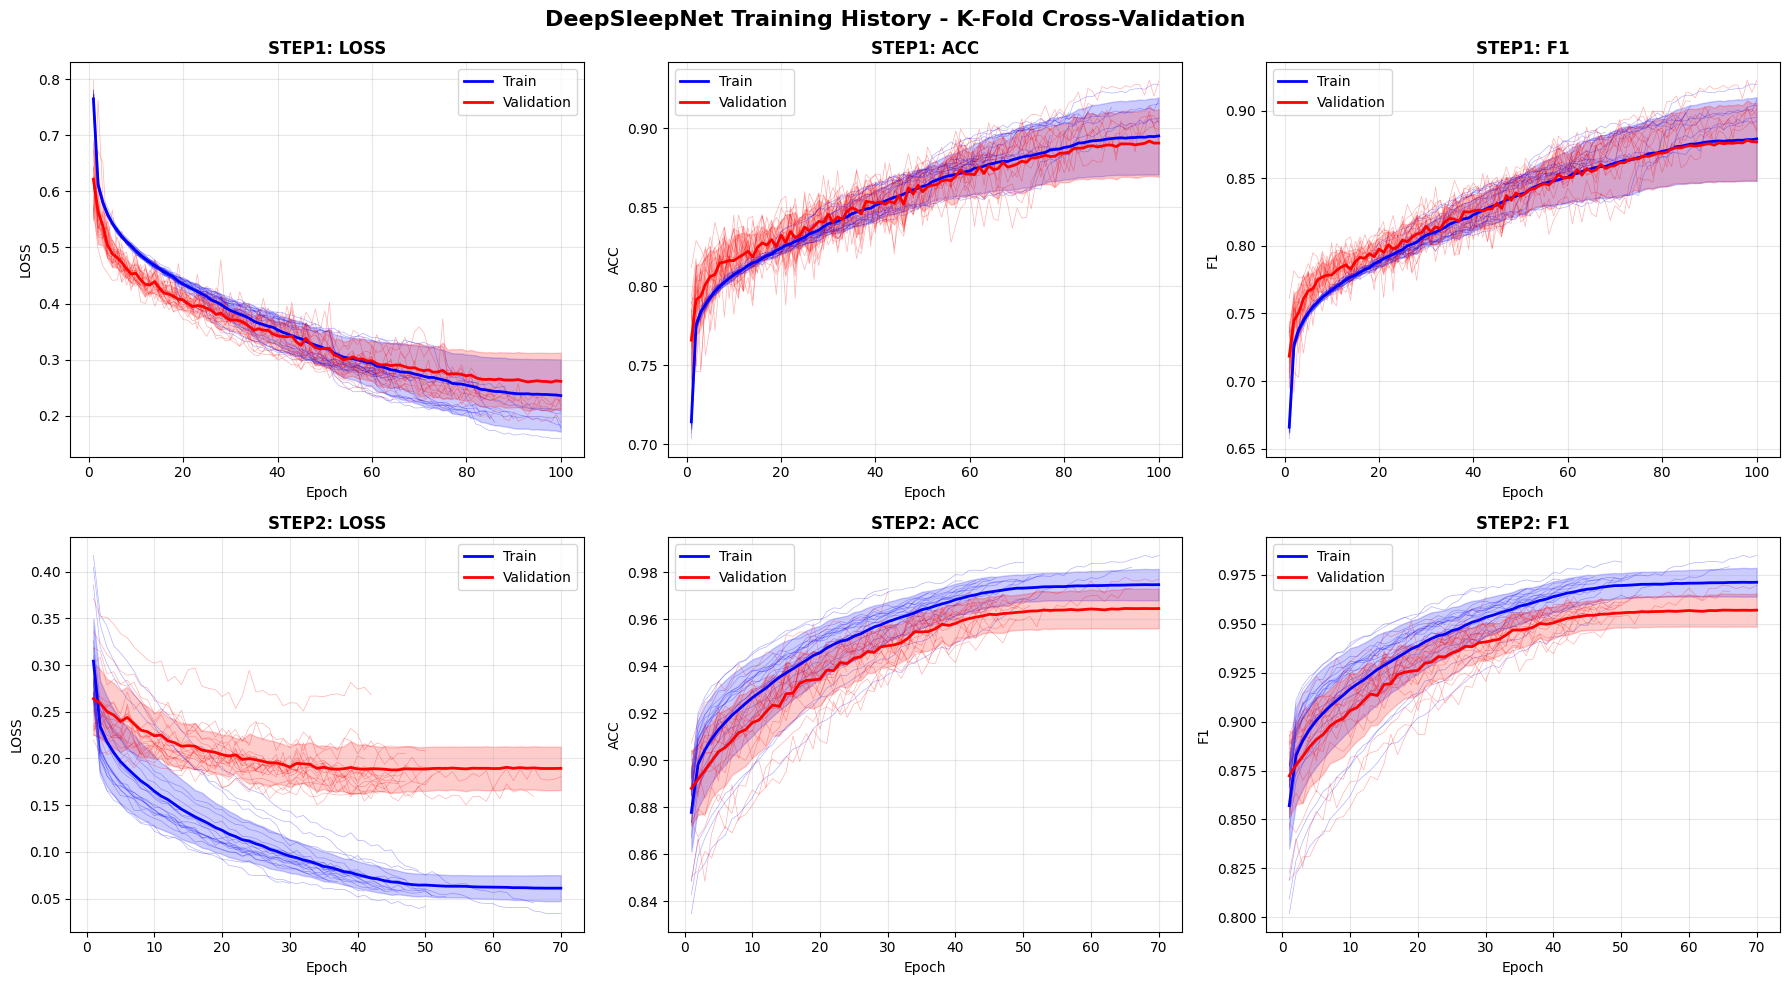

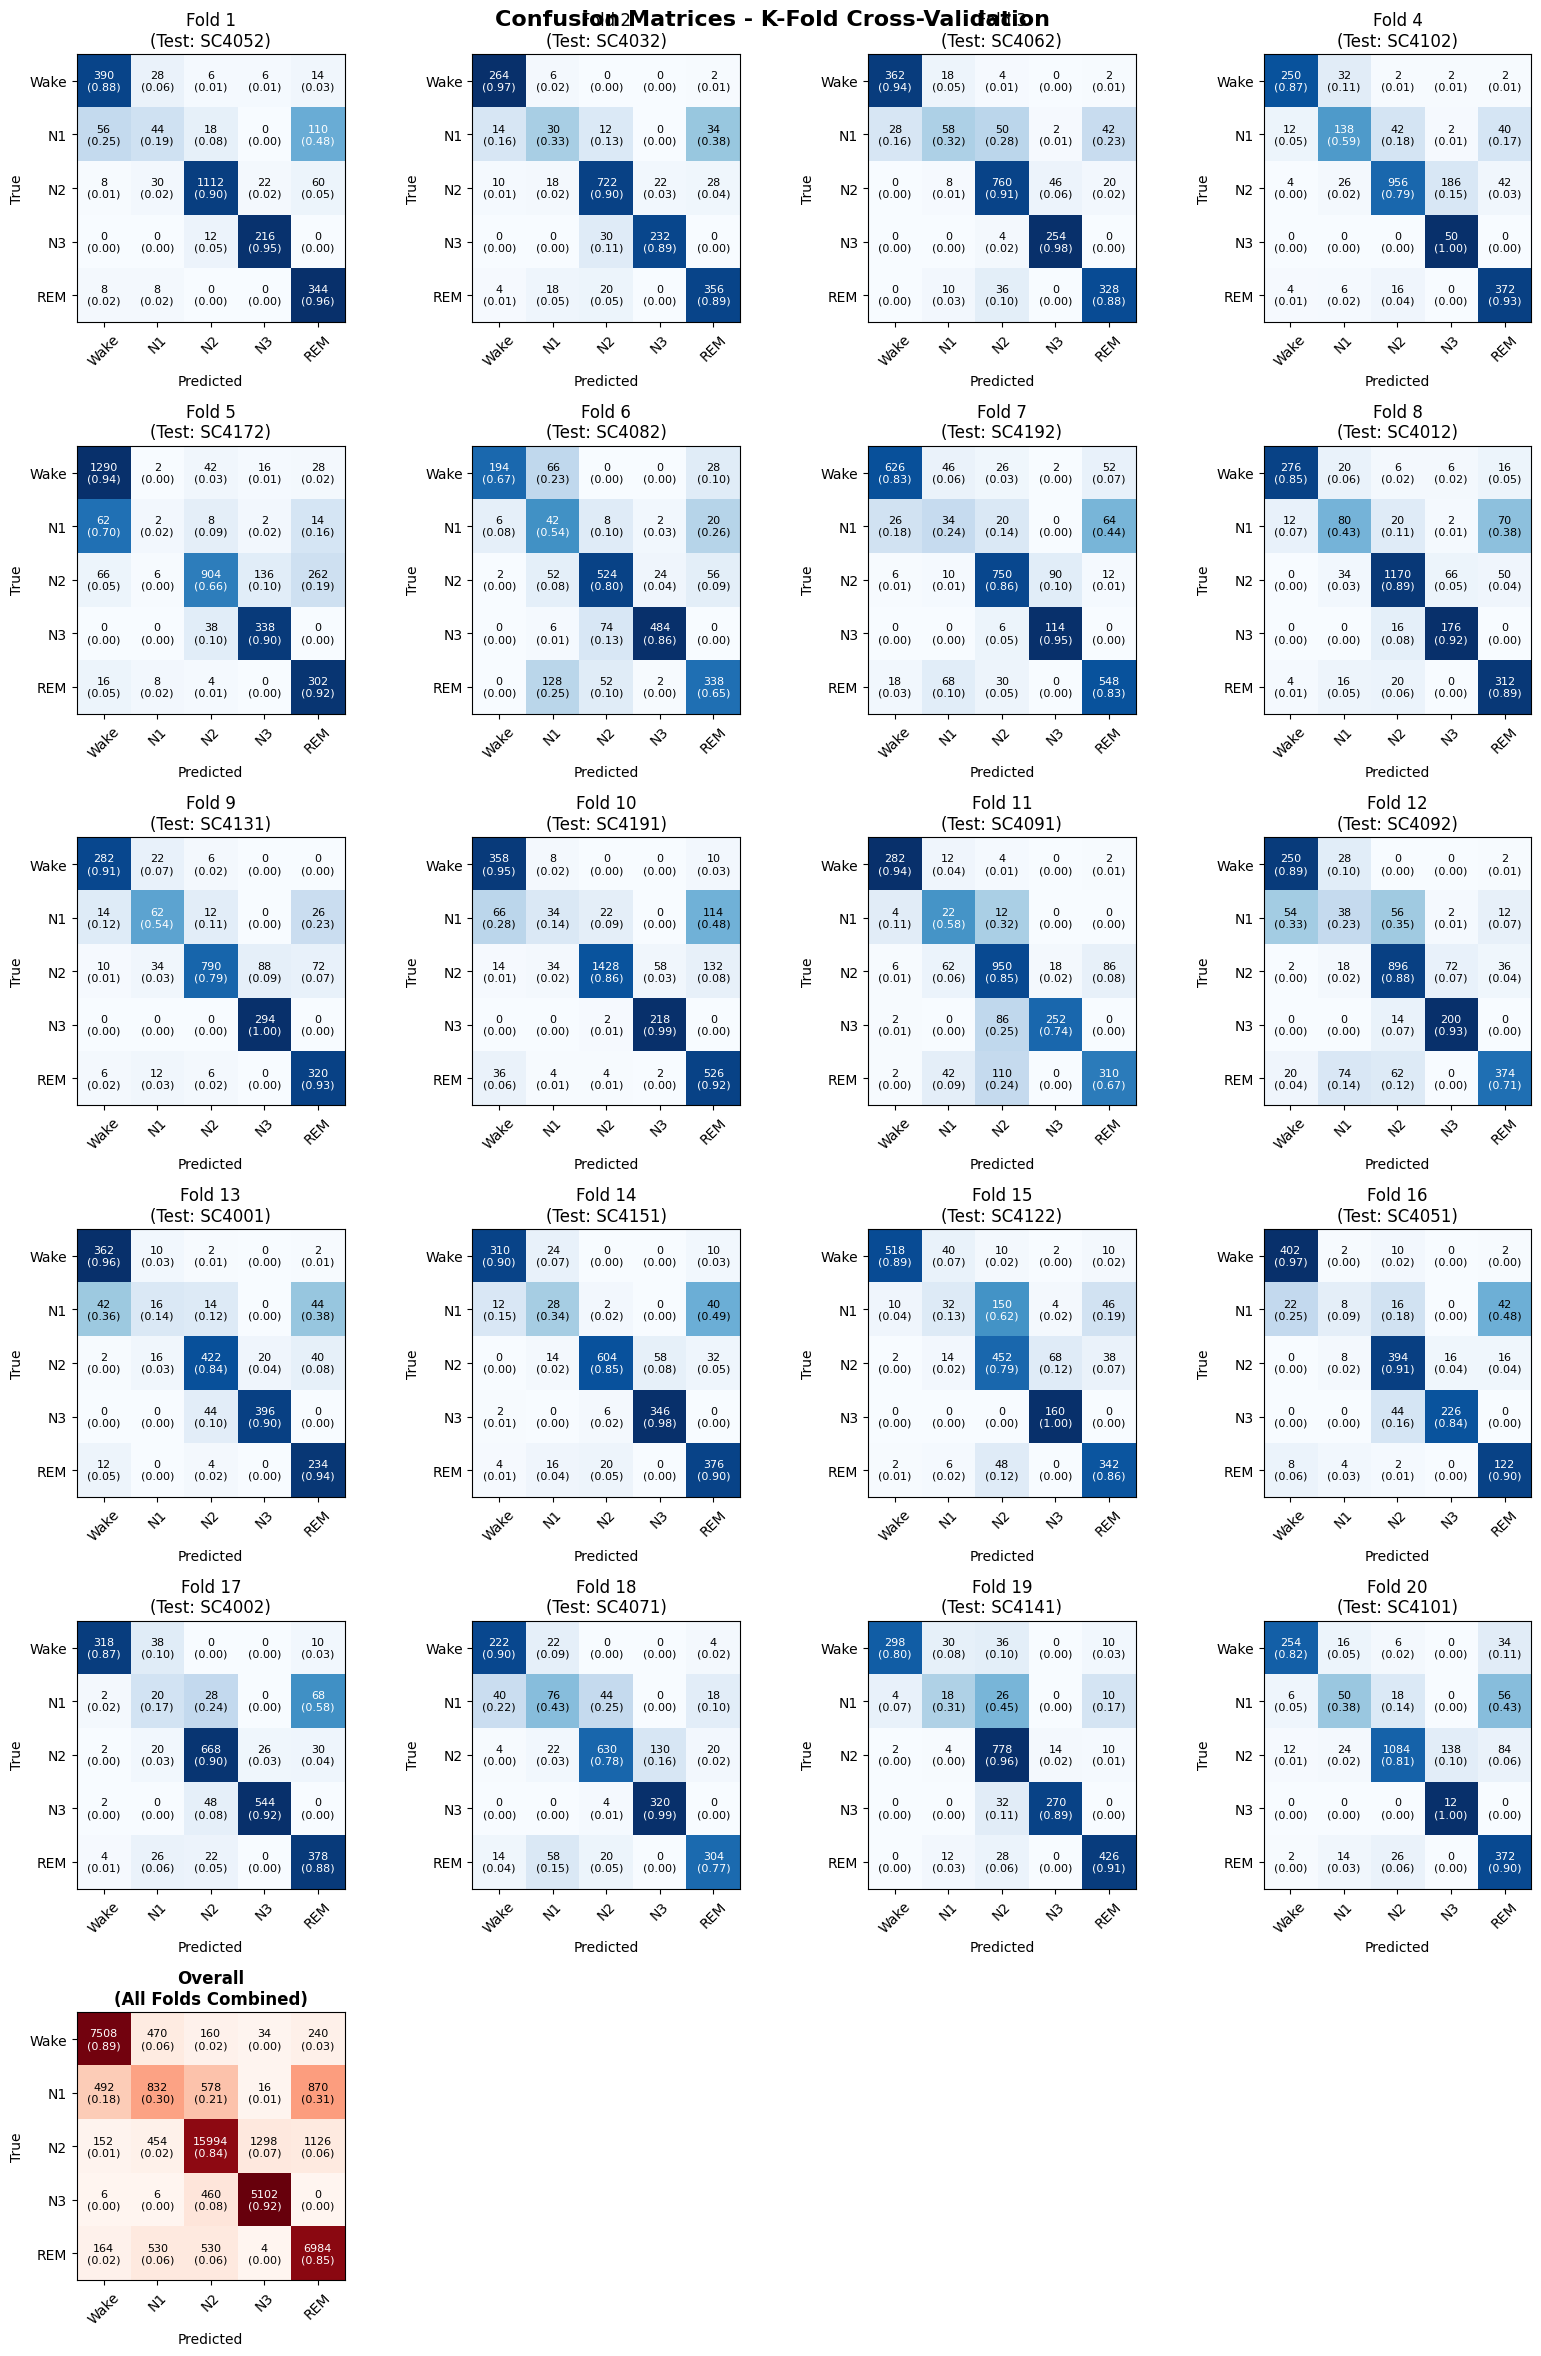


🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆
FINAL RESULTS - DEEPSLEEPNET PERFORMANCE
🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆

📈 OVERALL PERFORMANCE:
  🎯 Accuracy: 0.8296 ± 0.0374
  🎯 Macro F1: 0.7330 ± 0.0510
  🎯 Cohen's Kappa: 0.7607 ± 0.0537

📊 EXPERIMENTAL DETAILS:
  ✅ Successful Folds: 20/20
  ⏱️  Total Time: 9.76 hours
Initializing DeepSleepNet:
  Input size: 3000
  Sampling frequency: 100 Hz
  Classes: 5
  LSTM hidden size: 512
  LSTM layers: 2
Small CNN - Filter1: 50, Stride1: 6
Large CNN - Filter1: 375, Stride1: 50
  CNN feature size: 3200
  LSTM output size: 1024
  Residual FC size: 1024
  Final feature size: 2048
  Total parameters: 27,498,693
  🏗️  Model Parameters: 27,498,693
  📁 Total Epochs Processed: 1,692,320

🏷️  PER-CLASS PERFORMANCE:

✅ DeepSleepNet pipeline completed successfully!
📅 Completed at: 2025-06-04 21:26:15
🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆

In [11]:
final_results, final_summary_df, final_summary_stats = run_full_deepsleepnet_pipeline()